## Data Cleaning Stage

### Data reading

This notebook brings uses the scripts read_data_features.py and read_data_genre_track.py to arrive at a cleaned dataset with ready to use features and labels.

The following is 'read_data_genre_track.py'. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

#matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [3]:
metadata_path = 'fma_metadata'

In [4]:
## Read genre information
genres = pd.read_csv(metadata_path+'\\genres.csv')

In [5]:
genre_grps = genres.groupby('parent')


In [6]:
genre_id_root = genre_grps.get_group(0)['genre_id'] # Extract the parent groups
genre_id_name = genre_grps.get_group(0)['title']
main_label_dict = dict(zip(list(genre_id_root),list(genre_id_name)))

In [7]:
main_label_dict

{2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 17: 'Folk',
 20: 'Spoken',
 21: 'Hip-Hop',
 38: 'Experimental',
 1235: 'Instrumental'}

In [8]:
## Read track information
fields = ['track']
tracks = pd.read_csv(metadata_path+'\\tracks_mod.csv',nrows=85000)
tracks.head()

track_id     genres         genres_all
0         2       [21]               [21]
1         3       [21]               [21]
2         5       [21]               [21]
3        10       [10]               [10]
4        20  [76, 103]  [17, 10, 76, 103]

In [9]:
tracks = tracks.dropna()

In [10]:
tgen = list(tracks['genres'])
#print(tgen)

In [11]:
tgen = [t.replace('[','') for t in tgen]
tgen = [t.replace(']','') for t in tgen]
tgen = [t.replace(' ','') for t in tgen]
#print(tgen)

In [12]:
for k in range(len(tgen)):
    if(len(tgen[k])!=0):
        tgen[k] = [i for i in map(int, tgen[k].split(','))]
    else:
        tgen[k]=[]
#print(tgen)

In [13]:
tracks['genres']=tgen

In [14]:
tracks.head()

track_id     genres         genres_all
0         2       [21]               [21]
1         3       [21]               [21]
2         5       [21]               [21]
3        10       [10]               [10]
4        20  [76, 103]  [17, 10, 76, 103]

In [15]:
print(len(tgen))
#print(tracks.index)

84991


### Extracting relevant tracks and labels

In [16]:
## Match the tracks to the genre data: Create dictionary with genre label as key
genre_dict = {}
for i in range(len(tgen)): # for every track (tgen is a list of lists of genres corresponding to every track)
    if i in tracks.index:  
        ti = tracks['track_id'][i] # ti stores the track id corresponding to the index
        if 1<=len(tgen[i])<=1: # new condition that checks if t has just one genre and only then proceeds
            for k in tgen[i]: # k iterates through list of genres of current track
                if k is not None:
                    if (k in genre_dict.keys()): # if new genre is in the keys of genre_dict
                        genre_dict[k]+=[ti] # append current track id to list of all track ids
                    else:
                        genre_dict.update({k:[ti]}) # if k is a new key, then add new element to dictionary with ti as value

In [17]:
genre_dict[4][0]

144

In [18]:
## Total number of samples for the different root genres
for q in genre_id_root:
    print(q,len(genre_dict[q]))

2 119
3 101
4 320
5 731
8 543
9 16
10 505
12 1717
13 3
14 15
15 2221
17 1205
20 17
21 2363
38 1233
1235 199


Based on the above, the genres with sufficient data is selected for training.

In [19]:
#genre_set = [4,5,8,10,12,15,17,21,38]
#genre_set = [17,15,12,21,38]
#genre_set = [8,5,12,15,17,21,38]
# genre_set = [4,5,10,12,15,17,21,38]
#genre_set = [10,5,12,15,17,21,38]
# genre_set = [4,5,10,15,17,21,38] # removed rock
genre_set = [5,10,12,15,17,21,38] # remove jazz


num_tracks = 320
tr_len = 300 # Training length per class
test_len = 20 # Testing length per class

The code below selects the unique selection of 932 tracks from this list, with no repetitionof tracks

In [20]:
track_list = genre_dict[genre_set[0]]
for k in genre_set[1:]:
    t1 = genre_dict[k]
    i = 0
    while i<num_tracks:
        t2 = t1.pop()
        if t2 not in track_list:
            track_list.append(t2)
            i+=1
            
len(set(track_list))/len(genre_set)

378.7142857142857

Now we create the corresponding list of labels for this list.

In [21]:
label_list = [t for t in genre_set for i in range(num_tracks)]
len(label_list)/9

248.88888888888889

### Creating the training and testing data

Now we create the training and testing set partitions based on track index

In [22]:
tr_set = track_list[0:tr_len]
tr_lbl = label_list[0:tr_len]
test_set = track_list[tr_len:num_tracks]
test_lbl = label_list[tr_len:num_tracks]

print(len(tr_set),len(tr_lbl),len(test_set),len(test_lbl))

for k in range(1,len(genre_set)):
    tr_set+=track_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_set+=track_list[num_tracks*k+tr_len:num_tracks*(k+1)]
    tr_lbl+=label_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_lbl+=label_list[num_tracks*k+tr_len:num_tracks*(k+1)]

print(len(tr_set)/len(genre_set))
print(len(tr_lbl)/len(genre_set))
print(len(test_set)/len(genre_set))
print(len(test_lbl)/len(genre_set))

300 300 20 20
300.0
300.0
20.0
20.0


### Feature extraction for the relevant track ids

The following is 'read_data_features.py'.

In [33]:
## Column information
fields = ['mfcc.40','mfcc.42','mfcc.43','mfcc.44','mfcc.45','mfcc.48','mfcc.49','mfcc.50',\
    'mfcc.53','mfcc.56','mfcc.120','mfcc.121','mfcc.122','mfcc.124','spectral_contrast.14',\
        'spectral_contrast.15','spectral_contrast.16','spectral_contrast.43',\
            'spectral_contrast.44','feature']


In [34]:
## Read feature information 
features = pd.read_csv(metadata_path+'\\features.csv',usecols=fields)

C:\Users\cpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,293,295,296,297,298,301,302,303,306,309,373,374,375,377,428,429,430,457,458) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
features['feature'][3:] = features['feature'][3:].astype(int)

In [36]:
feat_tr = features.loc[features['feature'].isin(tr_set)]
feat_test = features.loc[features['feature'].isin(test_set)]

In [37]:
feat_tr['label'] = tr_lbl
feat_test['label'] = test_lbl

C:\Users\cpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\cpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shuffle the order of the data

In [38]:
feat_tr = feat_tr.sample(frac=1)
feat_test = feat_test.sample(frac=1)

Create separate numpy arrays and convert to type float

In [39]:
feat_tr = feat_tr.to_numpy()
tr_features = feat_tr[:,1:-1]
tr_features = tr_features.astype(float)
feat_test = feat_test.to_numpy()
test_features = feat_test[:,1:-1]
test_features = test_features.astype(float)

In [40]:
tr_features.shape

(2100, 19)

In [41]:
test_features.shape

(140, 19)

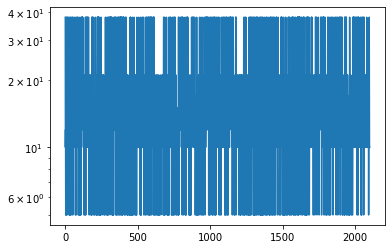

In [42]:
plt.semilogy(feat_tr[:,-1])

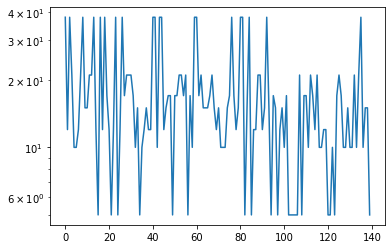

In [43]:
plt.semilogy(feat_test[:,-1])

### To obtain set of one hot codes for our labels

In [44]:
feat_test[:,-1] = [genre_set.index(w) for w in feat_test[:,-1]]
feat_tr[:,-1] = [genre_set.index(w) for w in feat_tr[:,-1]]

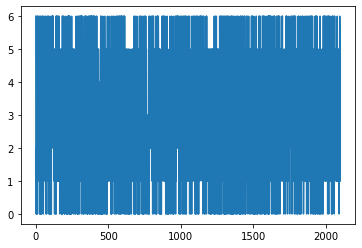

In [45]:
plt.plot(feat_tr[:,-1])

In [46]:
num_classes = len(genre_set)
one_hot = np.zeros((num_classes, num_classes*tr_len))
print(one_hot.shape)
for index_i, i in enumerate(feat_tr[:,-1]):
    one_hot[int(i),index_i] = 1


(7, 2100)


In [47]:
feat_tr[0:10,-1]

array([6, 1, 2, 0, 0, 2, 0, 5, 6, 5], dtype=object)

In [48]:
print(one_hot[:,0:10])
print(one_hot.shape)

[[0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(7, 2100)


## Training Stage

### Setting up data 

In [49]:
x_train = tr_features/1000
x_test = test_features/1000
y_train = feat_tr[:,-1]
y_test = feat_test[:,-1]

In [50]:
class_set = list(range(num_classes))
class_lbl = [genre_set[i] for i in class_set]
class_name = [main_label_dict[genre_set[i]] for i in class_set]
label_dict = dict(zip(class_name,class_set))

In [51]:
label_dict

{'Classical': 0,
 'Pop': 1,
 'Rock': 2,
 'Electronic': 3,
 'Folk': 4,
 'Hip-Hop': 5,
 'Experimental': 6}

In [52]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #plt.figure(figsize=(8,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #matplotlib.rcParams.update({'font.size': 14})

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.gca().set_aspect(3/4, adjustable='box')
    #set_size(5,5)
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels1 = np.zeros((num_records, num_classes))
    #print(true_labels.shape)
    for index_i, i in enumerate(true_labels):
        #print(index_i,i)
        true_labels1[index_i,int(i)] = 1
    return true_labels1

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    one_hot_true = one_hot_encoder(y_test, len(pred), num_classes)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Boosting

In [ ]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, objective='multi:hardprob', \
                                   n_estimators=700, sub_sample = 0.9, num_class = num_classes)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


In [ ]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

In [ ]:
display_results(np.array(y_test,dtype=int), pred_probs)

### SVM 

##### Before changes were made:
Test Set Accuracy =  0.26
Test Set F-score =  0.25
ROC AUC = 0.642
Confusion matrix, without normalization
[[ 4  2  3  4  1  3  0  3]
 [ 0 20  0  0  0  0  0  0]
 [ 3  0  4 11  0  1  1  0]
 [ 6  1  2  5  0  1  5  0]
 [ 2  1  1  8  1  3  1  3]
 [ 5  1  0  2  1  0  8  3]
 [ 1  0  0  3  0  9  4  3]
 [ 1  0  1  4  1  1  8  4]]
 

##### After removing rock


Test Set Accuracy =  0.31
Test Set F-score =  0.30
ROC AUC = 0.658
Confusion matrix, without normalization
[[ 7  0  4  4  2  1  2]
 [ 0 20  0  0  0  0  0]
 [ 5  0  4  2  4  5  0]
 [ 1  1  9  2  1  2  4]
 [ 5  1  2  2  1  4  5]
 [ 1  0  0  1  9  5  4]
 [ 1  2  2  3  1  6  5]]
 
 
##### After removing jazz

Test Set Accuracy =  0.33
Test Set F-score =  0.28
ROC AUC = 0.713
Confusion matrix, without normalization
[[ 6  4  0  6  1  1  2]
 [ 1 14  0  2  2  1  0]
 [12  2  0  5  0  0  1]
 [ 1  1  1 15  0  0  2]
 [ 1  2  3  7  0  4  3]
 [ 0  0  1  8  2  5  4]
 [ 2  0  0  6  1  5  6]]

In [ ]:
cl_weight = dict(pd.Series(np.array(y_train,dtype=int)).value_counts(normalize=True))

In [ ]:
cl_weight

In [ ]:
%%time

# Train
svm_classifier = SVC(C=10000.0, kernel = 'rbf', probability = True, class_weight=cl_weight)
svm_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

In [ ]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

In [ ]:
display_results(np.array(y_test,dtype=int), pred_probs)

### Random Forest

In [ ]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

In [ ]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### Logistic Regression

In [ ]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

In [ ]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### Neural Network

In [128]:
from torch import nn

In [129]:
import torch

In [130]:
x_train = x_train.T
x_train.shape

(19, 2100)

In [131]:
x_test = x_test.T
x_test.shape

(19, 140)

In [132]:
y_train.shape

(2100,)

In [133]:
y_train = y_train.T
y_train.shape

(2100,)

In [134]:
# turn labels into one hot
y_train.shape
print(type(y_train))
y_train = y_train.astype(int)
y_train_onehot = label2onehot(y_train)

<class 'numpy.ndarray'>


In [135]:
print(y_train_onehot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [136]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2
Ni = x_train.shape[0]
Nh = 5
No = y_train_onehot.shape[0]
netinit = init_shallow(Ni, Nh, No)

In [137]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(lbl.size)] = 1
    return d

In [138]:
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [139]:
def softmax(a):
    a_max = np.zeros((1,60000))
    a_max = a.max(axis = 0)
    a_sane = a - a_max
    a_sane_exp = np.exp(a_sane)
    y = a_sane_exp/(a_sane_exp.sum(axis = 0))
    return y

In [140]:
def softmaxp(a,e):
    k = softmax(a)
    part1 = np.multiply(k,e)
    new = part1.sum(axis = 0)
    part2 = np.multiply(new.T,k)
    return(part1 - part2)

In [141]:
def relu(a):
    return(np.where(a>0,a,0))

In [142]:
def relup(a,e):
    a = np.where(a>0,1,0)
    return(a*e)

In [143]:
def forwardprop_shallow(x, net):
#     print(net)
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
#     print("Shape of W1 is ", W1.shape)
#     print(x.shape)
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    return y
yinit = forwardprop_shallow(x_train, netinit)

In [144]:
def eval_loss(y, d):
    sum_vert = -np.log(y)*d
    return(sum_vert.sum()/y.shape[1])
print(eval_loss(yinit, y_train_onehot), 'should be around .26')

2.015462943119223 should be around .26


In [145]:
def eval_perfs(y, lbl):
    y_oneD = onehot2label(y)
    perf_par = (y_oneD != lbl)
    sum_perf_par = perf_par.sum()
    return (sum_perf_par/lbl.shape[0])*100
print(eval_perfs(yinit, y_train))

85.71428571428571


In [146]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    e2 = - d / y
    delta2 = softmaxp(a2,e2)
    e1 = W2.T.dot(delta2)
    delta1 = relup(a1, e1) 
    W2 = W2 - gamma * delta2.dot(a1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis =1, keepdims = True )
    b1 = b1 - gamma * delta1.sum(axis =1, keepdims = True )
    return W1, b1, W2, b2

In [147]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net = update_shallow(x, d, net)
        #net = [W1,b1,W2,b2]
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y, d)
        print(loss)
        performance = eval_perfs(y, lbl)
        print(performance)
    return net

In [149]:
nettrain_batch = backprop_shallow(x_train, y_train_onehot, netinit, 100000)

2.0136704120562907
85.71428571428571
2.0119434366821616
85.71428571428571
2.010278612439139
85.71428571428571
2.008672752901163
85.71428571428571
2.007122873631547
85.71428571428571
2.00562617740266
85.71428571428571
2.004180040647218
85.71428571428571
2.0027820010248214
85.71428571428571
2.001429745999727
85.71428571428571
2.0001211023367076
85.71428571428571
1.998854026431482
85.71428571428571
1.997626595400728
85.71428571428571
1.9964369988642456
85.71428571428571
1.995283531358556
85.71428571428571
1.9941645853271968
85.71428571428571
1.9930786446382973
85.71428571428571
1.9920242785847706
85.71428571428571
1.991000136326705
85.71428571428571
1.9900049417393162
85.71428571428571
1.989037488633257
85.71428571428571
1.988096636317091
85.71428571428571
1.9871813054745127
85.71428571428571
1.9862904743313305
85.71428571428571
1.9854231750894706
85.71428571428571
1.9845784906072454
85.71428571428571
1.98375555130693
85.71428571428571
1.9829535322923388
85.76190476190476
1.98217165066054

1.9423203310963397
88.85714285714286
1.9422890241384279
88.80952380952381
1.9422580519116173
88.80952380952381
1.942227372408532
88.80952380952381
1.9421968970072705
88.80952380952381
1.9421666984061123
88.80952380952381
1.9421367861297507
88.80952380952381
1.942107171712894
88.80952380952381
1.9420778129931375
88.80952380952381
1.9420486450287735
88.80952380952381
1.9420196756095853
88.80952380952381
1.9419909194124305
88.80952380952381
1.9419624149172736
88.80952380952381
1.941934151888806
88.80952380952381
1.9419060389689822
88.80952380952381
1.9418782168305362
88.80952380952381
1.9418506598232141
88.80952380952381
1.941823296262963
88.80952380952381
1.9417961379926134
88.80952380952381
1.9417691694141714
88.80952380952381
1.941742410662303
88.80952380952381
1.9417158578180127
88.80952380952381
1.9416895084232098
88.80952380952381
1.9416634086494728
88.80952380952381
1.94163750878414
88.80952380952381
1.941611830989509
88.80952380952381
1.9415864072541162
88.80952380952381
1.9415611

85.76190476190476
1.9377241071738311
85.71428571428571
1.9377049746397192
85.71428571428571
1.9376858327331135
85.71428571428571
1.9376666997072365
85.66666666666667
1.9376475383760356
85.61904761904762
1.9376283485602597
85.57142857142857
1.937609130082494
85.52380952380952
1.937589891138315
85.52380952380952
1.9375706582105607
85.52380952380952
1.9375513960816233
85.52380952380952
1.9375321045812182
85.47619047619047
1.9375127835407429
85.47619047619047
1.937493432793249
85.47619047619047
1.937474052173411
85.47619047619047
1.9374546415175022
85.33333333333334
1.937435200663362
85.28571428571429
1.9374157294503724
85.23809523809524
1.93739622771943
85.23809523809524
1.9373766953129195
85.28571428571429
1.9373571320746876
85.23809523809524
1.9373375378500177
85.19047619047619
1.937317912485605
85.14285714285714
1.937298253351393
85.14285714285714
1.937278543631781
85.14285714285714
1.937258802327017
85.14285714285714
1.9372390292891721
85.19047619047619
1.9372192243716109
85.142857142

1.9324996359015785
81.71428571428572
1.9324714015812925
81.71428571428572
1.9324431160360638
81.71428571428572
1.9324147791830106
81.71428571428572
1.9323863909392351
81.71428571428572
1.9323579512218254
81.71428571428572
1.9323294598301384
81.71428571428572
1.932300903177716
81.71428571428572
1.932272294804085
81.71428571428572
1.932243634626271
81.71428571428572
1.9322149225612837
81.66666666666667
1.932186158526113
81.66666666666667
1.9321573424377336
81.61904761904762
1.9321284742131009
81.61904761904762
1.9320995537691508
81.61904761904762
1.932070581022801
81.57142857142857
1.9320415558909496
81.57142857142857
1.9320124782904757
81.47619047619048
1.9319833481382362
81.47619047619048
1.9319541653510701
81.47619047619048
1.9319249298457941
81.47619047619048
1.931895641539204
81.52380952380952
1.9318663003480745
81.52380952380952
1.931836906189158
81.57142857142857
1.9318074589791863
81.57142857142857
1.9317779586348678
81.52380952380952
1.9317484050728888
81.47619047619048
1.931718

1.9246996088698876
80.61904761904762
1.9246577436573242
80.61904761904762
1.9246158081908784
80.61904761904762
1.9245738023871128
80.61904761904762
1.9245317261626456
80.61904761904762
1.9244895794341486
80.61904761904762
1.9244473621183495
80.61904761904762
1.924405074132033
80.57142857142857
1.9243627153920404
80.61904761904762
1.924320285815272
80.61904761904762
1.9242777853186843
80.61904761904762
1.9242352138192969
80.61904761904762
1.9241925712341876
80.57142857142857
1.9241498574804963
80.57142857142857
1.9241070724754246
80.57142857142857
1.9240642161362373
80.57142857142857
1.924021288380263
80.57142857142857
1.9239782891248944
80.57142857142857
1.92393521828759
80.57142857142857
1.9238920757858748
80.57142857142857
1.9238488615373404
80.57142857142857
1.9238055754596461
80.57142857142857
1.9237622174705213
80.57142857142857
1.923718787487764
80.52380952380952
1.9236752854292418
80.52380952380952
1.9236317112128967
80.52380952380952
1.9235880647567392
80.52380952380952
1.92354

79.61904761904762
1.912521166318659
79.57142857142857
1.9124603843482333
79.57142857142857
1.9123995159323355
79.57142857142857
1.9123385610302002
79.57142857142857
1.9122775196013906
79.57142857142857
1.9122163916058055
79.57142857142857
1.9121551770036773
79.57142857142857
1.912093875755574
79.57142857142857
1.9120324878224024
79.52380952380952
1.9119710131654064
79.52380952380952
1.9119094517461717
79.47619047619048
1.911847803526625
79.52380952380952
1.911786068469037
79.52380952380952
1.9117242465360227
79.52380952380952
1.9116623376905437
79.52380952380952
1.9116003418959087
79.52380952380952
1.911538259115776
79.52380952380952
1.9114760893141547
79.52380952380952
1.911413832455406
79.52380952380952
1.9113514885042444
79.52380952380952
1.91128905742574
79.52380952380952
1.9112265391853187
79.52380952380952
1.9111639337487647
79.52380952380952
1.9111012410822223
79.52380952380952
1.9110384611521964
79.52380952380952
1.9109755939255535
79.52380952380952
1.910912639369526
79.5238095

79.42857142857143
1.896849461015658
79.42857142857143
1.8967694975198572
79.42857142857143
1.8966894498103335
79.42857142857143
1.8966093179544055
79.42857142857143
1.896529102020014
79.42857142857143
1.8964488020757242
79.42857142857143
1.8963684181907274
79.42857142857143
1.896287950434839
79.42857142857143
1.896207398878503
79.42857142857143
1.8961267635927899
79.42857142857143
1.896046044649399
79.42857142857143
1.8959652421206594
79.42857142857143
1.8958843560795304
79.42857142857143
1.8958033865996022
79.42857142857143
1.895722333755097
79.42857142857143
1.8956411976208705
79.47619047619048
1.895559978272411
79.47619047619048
1.8954786757858422
79.47619047619048
1.8953973176247658
79.52380952380952
1.89531591049021
79.52380952380952
1.8952344208651162
79.52380952380952
1.8951528488280955
79.52380952380952
1.8950711944584333
79.52380952380952
1.8949894578360866
79.52380952380952
1.8949076390416828
79.52380952380952
1.894825738156518
79.52380952380952
1.8947437552625563
79.52380952

79.33333333333333
1.8775935551107104
79.28571428571428
1.8775027943334452
79.28571428571428
1.8774119865087318
79.28571428571428
1.8773211317938332
79.28571428571428
1.8772302000001713
79.28571428571428
1.8771390159792467
79.28571428571428
1.8770477848558274
79.28571428571428
1.8769565111007267
79.28571428571428
1.8768652752293036
79.28571428571428
1.876773993135145
79.28571428571428
1.8766826649988233
79.28571428571428
1.8765912910014009
79.28571428571428
1.8764998184618873
79.28571428571428
1.8764081358574327
79.28571428571428
1.8763164405485664
79.33333333333333
1.8762248365077772
79.33333333333333
1.876133582946574
79.33333333333333
1.8760423936191517
79.33333333333333
1.875951171963285
79.33333333333333
1.8758600721865029
79.33333333333333
1.8757689319353892
79.33333333333333
1.875677751143319
79.33333333333333
1.875586529762631
79.38095238095238
1.8754951571186589
79.38095238095238
1.8754034986935864
79.38095238095238
1.875311907954933
79.38095238095238
1.875220274016752
79.38095

1.8575154842817403
79.42857142857143
1.8574265905140912
79.42857142857143
1.8573377325969749
79.42857142857143
1.8572488854415203
79.42857142857143
1.8571600485844868
79.42857142857143
1.8570712216181504
79.42857142857143
1.8569824041855159
79.42857142857143
1.8568936226384631
79.42857142857143
1.8568048778581834
79.42857142857143
1.8567161435217727
79.42857142857143
1.8566274193038812
79.42857142857143
1.856538704922825
79.42857142857143
1.8564500001368
79.42857142857143
1.8563613139491952
79.42857142857143
1.8562726527943338
79.42857142857143
1.8561840012988815
79.42857142857143
1.8560953592974414
79.42857142857143
1.8560067266543905
79.42857142857143
1.8559181032612877
79.42857142857143
1.855829489034505
79.42857142857143
1.8557408839130605
79.42857142857143
1.8556522878566442
79.42857142857143
1.8555637072500084
79.38095238095238
1.85547515585774
79.38095238095238
1.855386613944689
79.38095238095238
1.855298130705947
79.38095238095238
1.8552097140999921
79.38095238095238
1.85512130

1.8383262233726863
78.95238095238095
1.8382451755973659
78.95238095238095
1.8381641721000779
78.95238095238095
1.838083212560287
78.9047619047619
1.8380023021467706
78.9047619047619
1.8379214928139331
78.95238095238095
1.8378407826485514
78.95238095238095
1.8377601207289394
79.0
1.8376795064102607
79.0
1.8375989470805114
79.0
1.837518486072678
78.9047619047619
1.837438080957885
79.0
1.837357725795087
79.04761904761905
1.837277419826645
79.0952380952381
1.8371971773217541
79.0952380952381
1.8371170039275562
79.0952380952381
1.8370368804675317
79.04761904761905
1.8369568270147758
79.04761904761905
1.8368768518782903
79.0
1.8367969288551649
79.0
1.8367170570629627
78.9047619047619
1.8366372577851415
78.9047619047619
1.8365575360952178
78.9047619047619
1.8364778677464222
78.95238095238095
1.8363982517796122
78.9047619047619
1.8363186873440633
78.95238095238095
1.8362391939929412
78.9047619047619
1.8361597923717168
78.9047619047619
1.8360804580779997
78.9047619047619
1.8360011987215135
79.0

79.28571428571428
1.8211465330356977
79.33333333333333
1.8210789785410455
79.33333333333333
1.821011420992986
79.33333333333333
1.8209438850316282
79.33333333333333
1.8208764576488077
79.28571428571428
1.8208090912980472
79.23809523809524
1.8207417869666407
79.28571428571428
1.8206746117926196
79.28571428571428
1.8206074941364994
79.28571428571428
1.8205404346267378
79.28571428571428
1.8204734248514614
79.28571428571428
1.8204062281361741
79.28571428571428
1.820339096547923
79.28571428571428
1.8202720764456104
79.28571428571428
1.8202051658082556
79.28571428571428
1.8201383131334343
79.28571428571428
1.8200715203730995
79.28571428571428
1.8200047866529299
79.33333333333333
1.8199381114168054
79.28571428571428
1.8198714968486591
79.28571428571428
1.8198050136847428
79.28571428571428
1.8197385912189064
79.28571428571428
1.8196722370497942
79.28571428571428
1.819605986836769
79.28571428571428
1.8195397941587643
79.28571428571428
1.819473661054039
79.28571428571428
1.819407586587736
79.285

1.8075895024762487
80.04761904761905
1.8075357559102603
80.04761904761905
1.807482070912271
80.0952380952381
1.8074284451154357
80.0952380952381
1.8073748787579171
80.0952380952381
1.8073213735879496
80.14285714285714
1.8072679262018079
80.14285714285714
1.8072145416515064
80.14285714285714
1.807161220388014
80.14285714285714
1.807107957433289
80.19047619047619
1.8070547552228402
80.23809523809524
1.8070016108781657
80.23809523809524
1.8069485255119555
80.23809523809524
1.8068955103599305
80.23809523809524
1.806842583167844
80.19047619047619
1.806789716994009
80.19047619047619
1.8067369107168185
80.19047619047619
1.8066841631570694
80.23809523809524
1.8066314765366591
80.23809523809524
1.806578848114079
80.28571428571428
1.806526278647055
80.28571428571428
1.8064737696887094
80.28571428571428
1.8064213179778428
80.23809523809524
1.806368925728831
80.23809523809524
1.8063165926628812
80.28571428571428
1.8062643170660904
80.28571428571428
1.8062121011271566
80.28571428571428
1.8061599432

79.57142857142857
1.7965616776968585
79.57142857142857
1.7965211916348789
79.61904761904762
1.796480757124747
79.61904761904762
1.796440372601278
79.61904761904762
1.7964000144265546
79.61904761904762
1.7963596345715367
79.61904761904762
1.7963193055806883
79.61904761904762
1.7962790279370506
79.61904761904762
1.7962388004262526
79.61904761904762
1.7961986477180418
79.61904761904762
1.7961585948424867
79.61904761904762
1.7961185926090313
79.61904761904762
1.7960786410920446
79.61904761904762
1.7960387402595468
79.61904761904762
1.7959988890526928
79.61904761904762
1.7959590879388312
79.61904761904762
1.795919336810275
79.61904761904762
1.795879635568091
79.61904761904762
1.7958399846541822
79.66666666666666
1.795800383170265
79.66666666666666
1.7957608310565616
79.66666666666666
1.7957213284995739
79.66666666666666
1.7956818754292108
79.61904761904762
1.7956424717790225
79.61904761904762
1.7956031181857657
79.61904761904762
1.795563813251318
79.61904761904762
1.7955245593012494
79.6190

79.28571428571428
1.788708778933536
79.28571428571428
1.7886785782243715
79.28571428571428
1.7886484181703275
79.28571428571428
1.7886182985575458
79.28571428571428
1.7885882191961793
79.28571428571428
1.78855817991697
79.28571428571428
1.7885281805683173
79.33333333333333
1.788498221013759
79.33333333333333
1.7884683011298184
79.33333333333333
1.7884384208041506
79.33333333333333
1.7884085799339602
79.28571428571428
1.7883787784246388
79.28571428571428
1.7883490161886015
79.28571428571428
1.7883192931442857
79.28571428571428
1.7882896092152958
79.28571428571428
1.788259964329668
79.28571428571428
1.78823035841924
79.28571428571428
1.7882007914191123
79.28571428571428
1.7881712632671847
79.28571428571428
1.7881417739037597
79.28571428571428
1.7881123232712024
79.28571428571428
1.7880829113136487
79.23809523809524
1.788053537976757
79.23809523809524
1.7880242032074913
79.28571428571428
1.7879949069539398
79.85714285714286
1.7879656491651565
79.9047619047619
1.787936429791027
79.95238095

1.7827706950587014
79.0
1.7827482171165772
79.0
1.7827257687208105
79.0
1.7827033498319527
79.04761904761905
1.7826809604106666
79.04761904761905
1.7826586004177114
79.14285714285715
1.782636269813937
79.14285714285715
1.7826139685602733
79.14285714285715
1.7825916966177238
79.14285714285715
1.78256945394736
79.23809523809524
1.7825472405103167
79.23809523809524
1.7825250562677872
79.23809523809524
1.7825029011810192
79.19047619047619
1.7824807752113125
79.19047619047619
1.782458678320017
79.23809523809524
1.7824366104685267
79.28571428571428
1.7824145717093194
79.28571428571428
1.7823925620505192
79.28571428571428
1.7823705813043962
79.23809523809524
1.78234862943248
79.23809523809524
1.782326706396351
79.19047619047619
1.7823048121576355
79.23809523809524
1.7822829466780048
79.28571428571428
1.7822611099413397
79.33333333333333
1.7822393020734015
79.33333333333333
1.7822175228375756
79.33333333333333
1.7821957721956776
79.33333333333333
1.7821740501095689
79.28571428571428
1.78215235

1.778419062026446
78.23809523809524
1.7784024125652718
78.23809523809524
1.778385784572185
78.23809523809524
1.7783691780073934
78.23809523809524
1.7783525928325319
78.23809523809524
1.778336029010451
78.23809523809524
1.7783194824087099
78.23809523809524
1.7783028200421613
78.23809523809524
1.7782861877902114
78.23809523809524
1.778269585123015
78.23809523809524
1.7782530420713807
78.28571428571428
1.7782365233319262
78.28571428571428
1.7782200283904932
78.28571428571428
1.7782035568075611
78.28571428571428
1.7781871082067582
78.28571428571428
1.7781706822651429
78.23809523809524
1.7781542787049793
78.28571428571428
1.7781378972867792
78.28571428571428
1.7781215378034128
78.23809523809524
1.7781052070791823
78.19047619047619
1.7780889134009656
78.19047619047619
1.778072640583746
78.19047619047619
1.7780563885945149
78.14285714285715
1.7780401574007971
78.14285714285715
1.7780239469705748
78.14285714285715
1.7780077572722217
78.14285714285715
1.7779915882744481
78.19047619047619
1.7779

77.76190476190476
1.7750777166325575
77.71428571428571
1.7750652622295973
77.76190476190476
1.7750528230230884
77.76190476190476
1.775040398313444
77.76190476190476
1.7750279899271078
77.76190476190476
1.7750155953365165
77.76190476190476
1.7750032166521383
77.66666666666666
1.7749908526678175
77.66666666666666
1.7749785057090053
77.66666666666666
1.7749661751452317
77.66666666666666
1.774953860488019
77.71428571428571
1.7749415602488396
77.71428571428571
1.7749292749333412
77.71428571428571
1.7749170056462784
77.71428571428571
1.7749047524286363
77.66666666666666
1.7748925124597628
77.66666666666666
1.7748802891923052
77.66666666666666
1.7748680798002747
77.61904761904762
1.7748558863719062
77.61904761904762
1.7748437097697911
77.61904761904762
1.774831551538301
77.57142857142857
1.7748194061277347
77.57142857142857
1.7748071472851856
77.57142857142857
1.7747949356184394
77.61904761904762
1.7747827425525156
77.61904761904762
1.774770568718002
77.47619047619048
1.7747584130403025
77.42

76.90476190476191
1.7725583898412698
76.95238095238095
1.772548860112299
76.95238095238095
1.772539339965039
76.95238095238095
1.7725298316954983
76.90476190476191
1.772520332712714
76.90476190476191
1.7725108458431567
76.90476190476191
1.7725013680933162
76.90476190476191
1.7724919022890029
76.90476190476191
1.7724824458486441
76.90476190476191
1.772473008702337
76.90476190476191
1.7724635827419286
76.90476190476191
1.772454169045377
76.90476190476191
1.77244476606102
76.85714285714286
1.7724353747008221
76.85714285714286
1.7724259940909786
76.85714285714286
1.7724166245415767
76.85714285714286
1.7724072658658852
76.85714285714286
1.7723979177371854
76.85714285714286
1.7723885806687802
76.80952380952381
1.7723792536661152
76.80952380952381
1.7723699379580597
76.80952380952381
1.772360631854
76.66666666666667
1.7723513373156583
76.66666666666667
1.772342051933727
76.66666666666667
1.7723327784083838
76.66666666666667
1.7723235137960662
76.66666666666667
1.7723142607782487
76.6666666666

76.47619047619048
1.77066873436575
76.47619047619048
1.7706611875411593
76.47619047619048
1.770653648440344
76.47619047619048
1.770646116375411
76.47619047619048
1.770638593015406
76.47619047619048
1.7706310763234931
76.47619047619048
1.7706235675425464
76.47619047619048
1.7706160667367594
76.47619047619048
1.770608572757927
76.47619047619048
1.770601087250951
76.47619047619048
1.7705936086987966
76.47619047619048
1.7705861390576225
76.47619047619048
1.770578683571072
76.47619047619048
1.7705712349359333
76.47619047619048
1.7705637947267379
76.47619047619048
1.7705563619927451
76.47619047619048
1.7705489364365121
76.47619047619048
1.7705415196361804
76.47619047619048
1.770534109267091
76.47619047619048
1.7705267068904111
76.47619047619048
1.770519312275641
76.47619047619048
1.7705119244583083
76.47619047619048
1.7705045450077155
76.47619047619048
1.7704971723598009
76.47619047619048
1.7704898070843842
76.47619047619048
1.7704824499849847
76.47619047619048
1.7704750993316805
76.47619047

76.38095238095238
1.7691492895096412
76.38095238095238
1.7691430666951007
76.38095238095238
1.76913685060205
76.38095238095238
1.7691306416941426
76.38095238095238
1.769124440540182
76.38095238095238
1.769118245254997
76.38095238095238
1.7691120563792475
76.38095238095238
1.7691058744766104
76.38095238095238
1.7690996982863374
76.38095238095238
1.769093527903741
76.38095238095238
1.769087369051057
76.38095238095238
1.7690812304588757
76.38095238095238
1.7690750904272545
76.38095238095238
1.7690688767194382
76.38095238095238
1.7690626735723685
76.38095238095238
1.769056479279269
76.38095238095238
1.769050293870149
76.38095238095238
1.769044117384209
76.33333333333333
1.769037947855854
76.33333333333333
1.7690317856912643
76.33333333333333
1.7690256313491166
76.38095238095238
1.7690194830843484
76.38095238095238
1.7690133412420364
76.38095238095238
1.7690072063074687
76.38095238095238
1.7690010772881826
76.38095238095238
1.7689949539852594
76.38095238095238
1.7689888369520728
76.38095238

1.7678947687349977
76.47619047619048
1.7678896496315606
76.47619047619048
1.7678845343462248
76.47619047619048
1.7678794231307338
76.47619047619048
1.7678743162956243
76.47619047619048
1.7678692134551068
76.47619047619048
1.7678641142477942
76.47619047619048
1.7678590189917944
76.47619047619048
1.7678539279500907
76.47619047619048
1.7678488409376716
76.47619047619048
1.7678437574204273
76.47619047619048
1.767838677785831
76.47619047619048
1.7678336022284007
76.47619047619048
1.7678285307946953
76.47619047619048
1.7678234627342686
76.47619047619048
1.7678183985117895
76.47619047619048
1.7678133382370194
76.47619047619048
1.7678082822216739
76.47619047619048
1.7678032294592188
76.47619047619048
1.7677981805015637
76.47619047619048
1.767793135359708
76.47619047619048
1.7677880946452296
76.47619047619048
1.7677830570578295
76.47619047619048
1.7677780299362982
76.47619047619048
1.7677730076892366
76.47619047619048
1.7677679912942277
76.47619047619048
1.767762979427477
76.47619047619048
1.76

76.61904761904762
1.7668469345881146
76.61904761904762
1.7668426146054697
76.61904761904762
1.7668382973746681
76.61904761904762
1.766833983021621
76.61904761904762
1.7668296716697167
76.61904761904762
1.766825362390512
76.61904761904762
1.7668210537264935
76.61904761904762
1.766816747803756
76.61904761904762
1.766812444616178
76.61904761904762
1.7668081446503396
76.57142857142857
1.766803846938426
76.57142857142857
1.766799551921761
76.57142857142857
1.7667952596188687
76.57142857142857
1.7667909700249436
76.57142857142857
1.7667866834572297
76.57142857142857
1.766782399457122
76.57142857142857
1.7667781179614195
76.57142857142857
1.7667738391567185
76.57142857142857
1.7667695630387499
76.57142857142857
1.766765291113186
76.57142857142857
1.7667610237156335
76.57142857142857
1.7667567590084143
76.57142857142857
1.7667524972925115
76.57142857142857
1.7667482385081053
76.57142857142857
1.7667439826048876
76.57142857142857
1.766739729984787
76.57142857142857
1.7667354797832946
76.5714285

76.23809523809524
1.7659354204777504
76.23809523809524
1.765931578501737
76.19047619047619
1.7659277383856242
76.19047619047619
1.7659239002609943
76.19047619047619
1.7659200641249815
76.19047619047619
1.765916229974725
76.19047619047619
1.7659123978073692
76.19047619047619
1.7659085679595776
76.19047619047619
1.7659047398026575
76.19047619047619
1.7659009135658883
76.19047619047619
1.7658970893006436
76.19047619047619
1.76589326700409
76.19047619047619
1.7658894466733996
76.19047619047619
1.7658856283081341
76.19047619047619
1.7658818122879785
76.19047619047619
1.7658779978369294
76.19047619047619
1.7658741853404742
76.19047619047619
1.765870374795806
76.19047619047619
1.7658665662001227
76.14285714285714
1.7658627595506255
76.14285714285714
1.765858954879969
76.14285714285714
1.765855152465132
76.14285714285714
1.7658513516364365
76.14285714285714
1.76584755274278
76.14285714285714
1.7658437557813846
76.14285714285714
1.7658399607494786
76.14285714285714
1.7658361676442929
76.1428571

75.80952380952381
1.7651069345893402
75.80952380952381
1.765103491284908
75.80952380952381
1.765100049411622
75.80952380952381
1.7650966089674707
75.80952380952381
1.7650931699504473
75.76190476190476
1.7650897323585473
75.76190476190476
1.7650862961897695
75.76190476190476
1.765082861727011
75.76190476190476
1.765079428402043
75.76190476190476
1.7650759964898768
75.76190476190476
1.7650725659928617
75.76190476190476
1.7650691369090117
75.76190476190476
1.7650657092363446
75.76190476190476
1.7650622829728813
75.76190476190476
1.7650588581166453
75.76190476190476
1.765055434665663
75.76190476190476
1.765052012843754
75.76190476190476
1.7650485922565686
75.76190476190476
1.7650451730087662
75.76190476190476
1.7650417551583555
75.76190476190476
1.7650383387033788
75.76190476190476
1.7650349236418805
75.76190476190476
1.7650315099719085
75.76190476190476
1.7650280976915134
75.76190476190476
1.7650246867987485
75.76190476190476
1.7650212774287806
75.71428571428571
1.765017869449896
75.71428

75.85714285714286
1.7643710977374174
75.85714285714286
1.7643679305320121
75.85714285714286
1.7643647643744151
75.85714285714286
1.7643615992631954
75.85714285714286
1.764358435196924
75.90476190476191
1.7643552723523226
75.90476190476191
1.7643521104055133
75.90476190476191
1.7643489494649316
75.90476190476191
1.7643457895636068
75.95238095238095
1.7643426307001204
75.95238095238095
1.764339472873057
75.95238095238095
1.7643363160810033
75.95238095238095
1.764333160322547
75.95238095238095
1.7643300055962787
75.90476190476191
1.7643268519007909
75.90476190476191
1.764323699234679
75.90476190476191
1.7643205475965396
75.90476190476191
1.7643173970794483
75.90476190476191
1.7643142476070046
75.90476190476191
1.7643110990437878
75.90476190476191
1.7643079515029525
75.90476190476191
1.7643048049831072
76.0
1.7643016594828602
76.0
1.7642985150008232
76.0
1.764295371535611
76.0
1.7642922290858372
76.0
1.7642890876501212
76.0
1.764285947227082
76.0
1.7642828078153416
76.0
1.7642796694135237


76.14285714285714
1.763621978068415
76.14285714285714
1.7636190015837256
76.14285714285714
1.7636160258569777
76.14285714285714
1.7636130508869523
76.14285714285714
1.76361007667247
76.14285714285714
1.7636071032123861
76.14285714285714
1.7636041305672752
76.14285714285714
1.7636011587012772
76.14285714285714
1.7635981874972853
76.14285714285714
1.7635952170433389
76.14285714285714
1.7635922473383914
76.14285714285714
1.7635892783814064
76.14285714285714
1.7635863101713574
76.14285714285714
1.763583342707227
76.14285714285714
1.7635803759880029
76.14285714285714
1.7635774100126806
76.14285714285714
1.76357444478026
76.14285714285714
1.763571480289745
76.14285714285714
1.7635685165401456
76.14285714285714
1.7635655535304726
76.14285714285714
1.7635625912597421
76.14285714285714
1.7635596297269718
76.14285714285714
1.7635566689311828
76.14285714285714
1.7635537088773636
76.14285714285714
1.7635507496930025
76.14285714285714
1.7635477911018391
76.14285714285714
1.7635448332437655
76.14285

1.76295129759084
76.0
1.762948483888392
76.0
1.762945670738766
76.0
1.762942858141244
76.0
1.7629400460951115
76.0
1.7629372345996581
76.0
1.7629344236541762
76.0
1.7629316132579624
76.0
1.7629288034103145
76.0
1.7629259941105344
76.0
1.7629231853579241
76.0
1.7629203771517885
76.0
1.7629175694914345
76.0
1.7629147623761698
76.0
1.7629119558053048
76.0
1.76290914977815
76.0
1.7629063442940178
76.0
1.7629035393522228
76.0
1.762900734952079
76.0
1.7628979310929038
76.0
1.762895127774014
76.0
1.762892324994728
76.0
1.7628895227543657
76.0
1.7628867210522479
76.0
1.7628839198876969
76.0
1.762881119260035
76.0
1.7628783191685866
76.0
1.7628755196126769
76.0
1.7628727205916317
76.0
1.7628699221047783
76.0
1.7628671241514453
76.0
1.7628643267309612
76.0
1.7628615298426566
76.04761904761905
1.7628587334858625
76.04761904761905
1.7628559376599116
76.04761904761905
1.7628531423641367
76.04761904761905
1.762850347597872
76.04761904761905
1.7628475533604533
76.04761904761905
1.7628447596512162
76.

76.09523809523809
1.7623097980182532
76.09523809523809
1.7623071221158721
76.09523809523809
1.7623044466415783
76.09523809523809
1.7623017715920637
76.09523809523809
1.762299096964526
76.09523809523809
1.7622964227565756
76.09523809523809
1.7622937489661632
76.04761904761905
1.7622910755915198
76.04761904761905
1.7622884026311039
76.04761904761905
1.7622857300835642
76.04761904761905
1.7622830579477025
76.04761904761905
1.7622803862224494
76.04761904761905
1.762277714906839
76.04761904761905
1.762275043999992
76.04761904761905
1.7622723735010988
76.04761904761905
1.7622697034094086
76.04761904761905
1.762267033724219
76.04761904761905
1.7622643644448661
76.04761904761905
1.7622616955707189
76.04761904761905
1.7622590271011727
76.04761904761905
1.7622563590356453
76.04761904761905
1.7622536913735733
76.0
1.7622510241144076
76.0
1.7622483572576118
76.0
1.7622456908026596
76.0
1.7622430247490348
76.0
1.7622403590962268
76.0
1.7622376938437316
76.0
1.7622350289910513
76.0
1.762232364537690

76.09523809523809
1.7616293387474655
76.09523809523809
1.7616267328725763
76.09523809523809
1.761624127312545
76.09523809523809
1.7616215220670082
76.09523809523809
1.7616189171356031
76.09523809523809
1.7616163125179676
76.09523809523809
1.76161370821374
76.09523809523809
1.7616111042225604
76.09523809523809
1.761608500544069
76.09523809523809
1.7616058971779063
76.09523809523809
1.7616032941237145
76.09523809523809
1.7616006913811357
76.09523809523809
1.761598088949813
76.09523809523809
1.7615954868293904
76.09523809523809
1.761592885019512
76.09523809523809
1.7615902835198232
76.09523809523809
1.76158768232997
76.09523809523809
1.7615850798540273
76.09523809523809
1.76158247019086
76.14285714285714
1.7615798608373137
76.14285714285714
1.7615772517930395
76.14285714285714
1.7615746430576895
76.14285714285714
1.7615720346309167
76.14285714285714
1.7615694265123745
76.14285714285714
1.761566818701717
76.14285714285714
1.7615642111985985
76.14285714285714
1.7615616040026747
76.142857142

76.14285714285714
1.7610568275119654
76.14285714285714
1.761054296771869
76.14285714285714
1.7610517662740273
76.14285714285714
1.7610492360181893
76.14285714285714
1.7610467060041035
76.14285714285714
1.7610441762315194
76.14285714285714
1.7610416467001864
76.14285714285714
1.7610391174309665
76.14285714285714
1.7610365886284052
76.14285714285714
1.7610340598192384
76.14285714285714
1.761031531250326
76.14285714285714
1.7610290029214182
76.14285714285714
1.761026474832267
76.14285714285714
1.7610239469826245
76.14285714285714
1.7610214193722435
76.14285714285714
1.7610188920008758
76.14285714285714
1.761016364868275
76.14285714285714
1.7610138381368532
76.14285714285714
1.7610113168510084
76.14285714285714
1.7610087916751924
76.14285714285714
1.7610062715099843
76.14285714285714
1.7610037476433398
76.09523809523809
1.7610012289921615
76.09523809523809
1.7609987082853387
76.09523809523809
1.76099618768242
76.09523809523809
1.7609936694574058
76.09523809523809
1.760991152386582
76.09523

76.09523809523809
1.7604970212158932
76.09523809523809
1.7604945341631553
76.09523809523809
1.7604920473230292
76.09523809523809
1.760489560955481
76.09523809523809
1.7604870745504446
76.09523809523809
1.7604845883398506
76.09523809523809
1.7604821023370356
76.09523809523809
1.7604796165412033
76.09523809523809
1.760477130951663
76.09523809523809
1.7604746455678122
76.09523809523809
1.7604721603891205
76.09523809523809
1.760469675415115
76.09523809523809
1.7604671908533303
76.09523809523809
1.760464706355025
76.09523809523809
1.7604622219926014
76.09523809523809
1.760459737833375
76.09523809523809
1.7604572538770418
76.09523809523809
1.760454770123315
76.09523809523809
1.7604522865719234
76.09523809523809
1.7604498032226061
76.09523809523809
1.7604473200751143
76.09523809523809
1.7604448372822163
76.09523809523809
1.7604423546599641
76.09523809523809
1.7604398721164412
76.09523809523809
1.7604373897738133
76.09523809523809
1.7604349076318606
76.09523809523809
1.7604324256903658
76.0952

1.7599490969048854
76.14285714285714
1.759946653556399
76.14285714285714
1.759944210250723
76.14285714285714
1.7599417671215956
76.14285714285714
1.7599393241687595
76.14285714285714
1.759936881391976
76.14285714285714
1.7599344387910212
76.14285714285714
1.7599319963656819
76.14285714285714
1.7599295541157565
76.14285714285714
1.7599271121698878
76.14285714285714
1.75992467042067
76.14285714285714
1.7599222286958265
76.14285714285714
1.7599197871456562
76.14285714285714
1.7599173457699848
76.14285714285714
1.7599149045686415
76.14285714285714
1.759912463541457
76.14285714285714
1.7599100226882651
76.14285714285714
1.759907582008901
76.14285714285714
1.7599051416164826
76.14285714285714
1.7599027014504074
76.14285714285714
1.759900261291542
76.14285714285714
1.7598978213058603
76.14285714285714
1.7598953814932021
76.14285714285714
1.7598929418534095
76.14285714285714
1.7598905034914212
76.14285714285714
1.7598880673816906
76.14285714285714
1.7598856316107676
76.14285714285714
1.7598831

76.14285714285714
1.759409787765648
76.14285714285714
1.7594073927473286
76.14285714285714
1.759404997983954
76.19047619047619
1.7594026031579868
76.19047619047619
1.7594002078348894
76.19047619047619
1.7593978126758127
76.19047619047619
1.7593954176756827
76.19047619047619
1.7593930228303472
76.19047619047619
1.7593906281364058
76.19047619047619
1.75938823359107
76.19047619047619
1.7593858391920492
76.14285714285714
1.7593834450969354
76.14285714285714
1.7593810511117656
76.14285714285714
1.7593786571418095
76.14285714285714
1.7593762633123735
76.14285714285714
1.759373869622572
76.14285714285714
1.7593714760716657
76.14285714285714
1.7593690826590316
76.14285714285714
1.759366689384145
76.14285714285714
1.7593642962465585
76.14285714285714
1.7593619034555312
76.14285714285714
1.7593595106687039
76.14285714285714
1.7593571179410628
76.14285714285714
1.7593547253494637
76.14285714285714
1.7593523328936818
76.14285714285714
1.7593499405735147
76.14285714285714
1.75934754838878
76.142857

1.7588768136562125
76.23809523809524
1.7588744334849322
76.23809523809524
1.7588720534358273
76.23809523809524
1.7588696735088207
76.23809523809524
1.7588672937038343
76.23809523809524
1.7588649140207908
76.23809523809524
1.758862534459613
76.23809523809524
1.758860155020224
76.23809523809524
1.7588577757025463
76.23809523809524
1.758855394113767
76.23809523809524
1.758853009700573
76.23809523809524
1.7588506254107341
76.23809523809524
1.758848241244173
76.23809523809524
1.7588458572008137
76.23809523809524
1.7588434732805787
76.23809523809524
1.7588410894833915
76.23809523809524
1.7588387058091752
76.23809523809524
1.7588363222578538
76.23809523809524
1.7588339388293506
76.23809523809524
1.7588315555235892
76.23809523809524
1.7588291723404936
76.23809523809524
1.7588267892799878
76.23809523809524
1.758824406341996
76.23809523809524
1.7588220235264413
76.23809523809524
1.7588196408332495
76.23809523809524
1.7588172582623434
76.23809523809524
1.7588148758136481
76.23809523809524
1.75881

76.19047619047619
1.7583386335952371
76.19047619047619
1.7583361869858218
76.19047619047619
1.7583337405431163
76.19047619047619
1.758331294428069
76.19047619047619
1.7583288487231448
76.19047619047619
1.7583264031852561
76.19047619047619
1.7583239578141725
76.19047619047619
1.758321512609679
76.19047619047619
1.7583190620384421
76.19047619047619
1.7583166186152595
76.19047619047619
1.7583141774978148
76.19047619047619
1.7583117649130244
76.19047619047619
1.7583093524775812
76.19047619047619
1.7583069401913471
76.19047619047619
1.7583045280541856
76.19047619047619
1.7583021160659618
76.19047619047619
1.7582997042265434
76.19047619047619
1.7582972925357976
76.19047619047619
1.7582948786321702
76.19047619047619
1.758292482304854
76.19047619047619
1.758290086116405
76.19047619047619
1.7582876900667106
76.19047619047619
1.758285294155658
76.19047619047619
1.7582828983831353
76.19047619047619
1.7582805027490307
76.19047619047619
1.7582781072532332
76.19047619047619
1.7582757118956303
76.190

1.75753438922955
76.33333333333333
1.7575211796916916
76.28571428571429
1.7575088894493223
76.14285714285714
1.7574964137617253
76.09523809523809
1.7574829710522062
76.09523809523809
1.7574695075113345
76.0
1.7574573799307316
76.09523809523809
1.757446913762876
76.19047619047619
1.7574376632618993
76.19047619047619
1.7574273620468
75.95238095238095
1.7574174881906608
75.90476190476191
1.7574083884300562
75.90476190476191
1.7574008753832173
75.85714285714286
1.7573939410765183
75.85714285714286
1.7573871009325885
75.90476190476191
1.7573810818890052
75.90476190476191
1.7573750433090152
75.80952380952381
1.7573689418977778
75.90476190476191
1.7573630450561046
75.85714285714286
1.7573564893743878
75.80952380952381
1.7573501495298292
75.71428571428571
1.7573434321553045
75.76190476190476
1.7573367750156488
75.76190476190476
1.7573297402933428
75.66666666666667
1.757322564764673
75.66666666666667
1.7573158933057493
75.66666666666667
1.7573097383819187
75.71428571428571
1.7573039845512954
75

1.7567089891183991
75.71428571428571
1.7567065162595417
75.71428571428571
1.7567040464001824
75.71428571428571
1.7567015777146069
75.71428571428571
1.7566991085567865
75.66666666666667
1.7566966443595171
75.66666666666667
1.7566941760957162
75.66666666666667
1.7566917129791861
75.66666666666667
1.7566892506927272
75.66666666666667
1.7566867891716615
75.66666666666667
1.7566843283612839
75.66666666666667
1.7566818682150176
75.61904761904762
1.7566794086929265
75.61904761904762
1.7566769492176528
75.61904761904762
1.7566744873725617
75.61904761904762
1.7566720280913857
75.61904761904762
1.7566695680717805
75.66666666666667
1.7566671085494847
75.66666666666667
1.7566646466946847
75.66666666666667
1.7566621849215815
75.66666666666667
1.7566597257411263
75.66666666666667
1.7566572670400664
75.66666666666667
1.756654808804284
75.66666666666667
1.7566523510204224
75.76190476190476
1.7566498936758008
75.76190476190476
1.756647437187038
75.76190476190476
1.7566449811864917
75.71428571428571
1.7

75.71428571428571
1.756143571416075
75.66666666666667
1.7561410771562433
75.66666666666667
1.756138578097396
75.66666666666667
1.7561360794070653
75.66666666666667
1.756133579146102
75.66666666666667
1.756131074344301
75.66666666666667
1.7561285697213727
75.66666666666667
1.7561260652643953
75.66666666666667
1.7561235609626107
75.66666666666667
1.756121056440907
75.66666666666667
1.7561185489529385
75.66666666666667
1.7561160528414008
75.66666666666667
1.7561135569630348
75.66666666666667
1.7561110613078397
75.66666666666667
1.7561085658669946
75.66666666666667
1.7561060706326541
75.66666666666667
1.7561035755977796
75.66666666666667
1.756101080855528
75.66666666666667
1.7560985846477213
75.66666666666667
1.7560960833780734
75.66666666666667
1.7560935795867048
75.66666666666667
1.7560910681822108
75.66666666666667
1.7560885498295347
75.66666666666667
1.756086025923619
75.66666666666667
1.7560835268016195
75.66666666666667
1.7560810341575506
75.66666666666667
1.7560785417060518
75.66666

1.7555917733273403
75.71428571428571
1.7555892677808624
75.71428571428571
1.755586762447207
75.71428571428571
1.75558425741618
75.71428571428571
1.755581752616276
75.71428571428571
1.7555792478454926
75.71428571428571
1.7555767432681244
75.71428571428571
1.7555742388807647
75.71428571428571
1.7555717346803579
75.71428571428571
1.7555692306641377
75.71428571428571
1.7555667268295816
75.71428571428571
1.7555642231743687
75.71428571428571
1.7555617203286693
75.71428571428571
1.7555592291788435
75.71428571428571
1.7555567390103974
75.71428571428571
1.7555542497636187
75.71428571428571
1.7555517632403288
75.71428571428571
1.755549278996402
75.71428571428571
1.7555467956769697
75.71428571428571
1.7555443133520947
75.71428571428571
1.7555418323922167
75.71428571428571
1.7555393521454412
75.71428571428571
1.7555368724961673
75.71428571428571
1.7555343936954273
75.71428571428571
1.7555319150834965
75.71428571428571
1.7555294367839234
75.71428571428571
1.7555269587997078
75.71428571428571
1.7555

75.57142857142857
1.7550405595952623
75.57142857142857
1.7550380980371478
75.57142857142857
1.7550356365466475
75.57142857142857
1.7550331751235608
75.57142857142857
1.7550307137676895
75.57142857142857
1.7550282530272363
75.57142857142857
1.7550257931057842
75.57142857142857
1.7550233319721216
75.57142857142857
1.755020870358442
75.57142857142857
1.7550184079161988
75.57142857142857
1.7550159454923528
75.57142857142857
1.755013478074757
75.57142857142857
1.7550110107188384
75.57142857142857
1.7550085434241403
75.57142857142857
1.7550060761902524
75.57142857142857
1.7550036090167982
75.57142857142857
1.7550011444512696
75.57142857142857
1.7549986840781748
75.57142857142857
1.7549962233693468
75.57142857142857
1.7549937619339198
75.57142857142857
1.7549913035814813
75.57142857142857
1.7549888431573597
75.57142857142857
1.7549863823919363
75.57142857142857
1.7549839231824473
75.57142857142857
1.754981464112799
75.57142857142857
1.754979005180956
75.57142857142857
1.7549765463849805
75.57

75.71428571428571
1.7544947808809723
75.71428571428571
1.754492344293124
75.71428571428571
1.754489906999064
75.71428571428571
1.7544874697669466
75.71428571428571
1.754485032596618
75.71428571428571
1.7544825954879286
75.71428571428571
1.7544801584407317
75.71428571428571
1.754477721454882
75.71428571428571
1.754475284530237
75.71428571428571
1.7544728476666565
75.71428571428571
1.7544704108640012
75.71428571428571
1.7544679734183366
75.71428571428571
1.7544655269329172
75.71428571428571
1.754463070580057
75.71428571428571
1.7544606144068509
75.71428571428571
1.7544581569920792
75.71428571428571
1.7544556843231753
75.71428571428571
1.7544532120007101
75.71428571428571
1.7544507404350635
75.76190476190476
1.7544482795090965
75.76190476190476
1.7544458203478086
75.76190476190476
1.7544433705470979
75.76190476190476
1.754440928970163
75.76190476190476
1.7544384899845393
75.76190476190476
1.7544360526922251
75.76190476190476
1.7544336163694743
75.76190476190476
1.7544311801642531
75.76190

1.7539481616170962
75.52380952380953
1.7539457188039589
75.52380952380953
1.753943276136745
75.52380952380953
1.7539408343924008
75.52380952380953
1.7539383923554865
75.52380952380953
1.7539359512290233
75.52380952380953
1.7539335095850512
75.47619047619048
1.7539310686494647
75.47619047619048
1.7539286277443478
75.47619047619048
1.753926186793168
75.47619047619048
1.753923746585611
75.47619047619048
1.7539213061853487
75.47619047619048
1.7539188658817566
75.47619047619048
1.7539164260490994
75.52380952380953
1.7539139864259123
75.52380952380953
1.753911546729044
75.52380952380953
1.753909107250834
75.52380952380953
1.7539066680659294
75.52380952380953
1.753904229260436
75.52380952380953
1.7539017903382828
75.52380952380953
1.7538993516176375
75.52380952380953
1.7538969130939672
75.57142857142857
1.753894474762902
75.57142857142857
1.7538920366202269
75.57142857142857
1.7538895986712908
75.61904761904762
1.7538871633105846
75.61904761904762
1.7538847284598704
75.61904761904762
1.753882

1.753397495054019
75.66666666666667
1.7533948217337698
75.66666666666667
1.753392254760867
75.66666666666667
1.7533897225907609
75.66666666666667
1.7533872114298303
75.66666666666667
1.7533846975211738
75.66666666666667
1.7533821750567802
75.66666666666667
1.7533796392540086
75.66666666666667
1.7533770844592778
75.66666666666667
1.7533745302888926
75.66666666666667
1.7533720073171306
75.61904761904762
1.7533694846773233
75.61904761904762
1.7533669571455375
75.61904761904762
1.7533643975032982
75.61904761904762
1.7533618123558197
75.61904761904762
1.7533592567366132
75.61904761904762
1.7533567016400031
75.61904761904762
1.753354165396659
75.71428571428571
1.7533516286000403
75.71428571428571
1.7533490692205822
75.71428571428571
1.7533465390253238
75.66666666666667
1.7533440345117695
75.66666666666667
1.7533415301416593
75.66666666666667
1.753339025910819
75.66666666666667
1.753336521815381
75.71428571428571
1.7533340178517383
75.71428571428571
1.753331514016509
75.71428571428571
1.75332

1.752827475856708
75.71428571428571
1.7528250694861696
75.66666666666667
1.7528226636905673
75.66666666666667
1.752820258450526
75.66666666666667
1.7528178537473946
75.66666666666667
1.7528154495632189
75.66666666666667
1.7528130458807096
75.66666666666667
1.7528106426832168
75.61904761904762
1.7528082399547054
75.57142857142857
1.7528058376797293
75.57142857142857
1.7528034358434097
75.57142857142857
1.7528010344314129
75.57142857142857
1.7527986334299304
75.57142857142857
1.752796232825657
75.57142857142857
1.7527938326057744
75.57142857142857
1.7527914327579306
75.61904761904762
1.7527890332702243
75.61904761904762
1.752786634131188
75.66666666666667
1.7527842353297696
75.66666666666667
1.7527818368553212
75.66666666666667
1.75277943869758
75.61904761904762
1.7527770408466568
75.61904761904762
1.7527746432930216
75.61904761904762
1.7527722461644477
75.61904761904762
1.752769850799265
75.61904761904762
1.7527674555580441
75.61904761904762
1.7527650606784289
75.61904761904762
1.752762

1.752294870792564
75.76190476190476
1.752292487506232
75.76190476190476
1.7522901047081672
75.76190476190476
1.752287720770997
75.76190476190476
1.7522853369387446
75.76190476190476
1.7522829545144913
75.76190476190476
1.752280571402315
75.76190476190476
1.75227818778791
75.76190476190476
1.7522758046616345
75.76190476190476
1.7522734234734119
75.76190476190476
1.7522710409597249
75.76190476190476
1.7522686584545903
75.76190476190476
1.7522662762419887
75.76190476190476
1.7522638948055291
75.76190476190476
1.7522615136310242
75.76190476190476
1.7522591318589833
75.76190476190476
1.7522567500113455
75.71428571428571
1.752254368480571
75.71428571428571
1.7522519885823784
75.71428571428571
1.7522496074055816
75.71428571428571
1.7522472264271458
75.71428571428571
1.7522448456221416
75.71428571428571
1.752242464970579
75.71428571428571
1.752240085484863
75.71428571428571
1.7522377052703446
75.71428571428571
1.7522353249143967
75.71428571428571
1.7522329446699834
75.71428571428571
1.75223056

75.76190476190476
1.751766707179761
75.76190476190476
1.7517643499294648
75.76190476190476
1.7517619927303372
75.76190476190476
1.7517596355823166
75.71428571428571
1.7517572784853486
75.71428571428571
1.7517549214393857
75.71428571428571
1.7517525644443854
75.71428571428571
1.7517502075003097
75.71428571428571
1.7517478506071238
75.71428571428571
1.7517454937647947
75.71428571428571
1.751743136973294
75.71428571428571
1.751740780232593
75.71428571428571
1.751738424729484
75.71428571428571
1.7517360681478538
75.71428571428571
1.751733711565772
75.71428571428571
1.7517313550344427
75.66666666666667
1.7517289985538078
75.66666666666667
1.7517266424746019
75.66666666666667
1.7517242870736751
75.66666666666667
1.7517219307480074
75.66666666666667
1.7517195744731402
75.66666666666667
1.751717218248982
75.66666666666667
1.7517148620754583
75.66666666666667
1.7517125072499835
75.66666666666667
1.7517101512878022
75.66666666666667
1.7517077952663784
75.66666666666667
1.751705439295785
75.66666

1.7512397706367933
76.14285714285714
1.7512373920450244
76.14285714285714
1.7512350117097792
76.14285714285714
1.7512326333310917
76.14285714285714
1.7512302523257868
76.14285714285714
1.7512278747705854
76.14285714285714
1.751225493906582
76.14285714285714
1.7512231163420071
76.14285714285714
1.7512207354108658
76.14285714285714
1.7512183579156915
76.14285714285714
1.7512159777507597
76.14285714285714
1.7512135997584826
76.14285714285714
1.7512112197877252
76.14285714285714
1.7512088416231004
76.14285714285714
1.7512064625155501
76.14285714285714
1.7512040842307262
76.14285714285714
1.7512017051776343
76.14285714285714
1.751199326551273
76.14285714285714
1.751196948051309
76.14285714285714
1.7511945717754047
76.14285714285714
1.7511921952891951
76.09523809523809
1.7511898157443961
76.09523809523809
1.751187437921015
76.09523809523809
1.7511850581641175
76.09523809523809
1.7511826835386184
76.09523809523809
1.7511803051318289
76.09523809523809
1.7511779282118285
76.09523809523809
1.751

1.7507036110242555
76.09523809523809
1.750701249222094
76.14285714285714
1.750698890498812
76.14285714285714
1.750696528592485
76.14285714285714
1.750694167416363
76.19047619047619
1.7506918068281265
76.19047619047619
1.7506894467154446
76.19047619047619
1.750687087168251
76.19047619047619
1.7506847284092504
76.19047619047619
1.7506823684441957
76.19047619047619
1.7506800088695642
76.19047619047619
1.7506776496145582
76.19047619047619
1.7506752906232907
76.19047619047619
1.7506729318516407
76.14285714285714
1.7506705732647727
76.14285714285714
1.7506682148351786
76.14285714285714
1.7506658565411324
76.14285714285714
1.7506634983654705
76.14285714285714
1.750661140294631
76.14285714285714
1.750658782437731
76.14285714285714
1.7506564262281543
76.14285714285714
1.7506540700271214
76.14285714285714
1.7506517142199096
76.14285714285714
1.7506493589389969
76.14285714285714
1.7506470040847815
76.14285714285714
1.7506446501057356
76.14285714285714
1.7506422961499162
76.14285714285714
1.750639

76.14285714285714
1.750146380636515
76.14285714285714
1.7501440199180052
76.14285714285714
1.7501416603558089
76.09523809523809
1.7501392979607888
76.09523809523809
1.750136927639674
76.09523809523809
1.7501345569578437
76.09523809523809
1.7501321675637167
76.09523809523809
1.7501297792158645
76.09523809523809
1.7501273917987472
76.09523809523809
1.7501250052178028
76.09523809523809
1.7501226193951092
76.09523809523809
1.750120234265968
76.0
1.7501178497762113
76.0
1.7501154658800784
76.0
1.7501130825385385
76.0
1.7501106997179703
76.0
1.7501083173891154
76.0
1.7501059355262538
76.0
1.7501035541065488
75.95238095238095
1.7501011663107169
75.95238095238095
1.7500987751621961
75.95238095238095
1.7500963981516608
76.0
1.7500940266735558
76.0
1.7500916612354465
75.95238095238095
1.750089295968548
75.90476190476191
1.7500869308679177
75.90476190476191
1.7500845659288249
75.90476190476191
1.7500822011467392
75.90476190476191
1.7500798308231007
75.90476190476191
1.7500774522421423
75.85714285

75.66666666666667
1.7496107878091367
75.66666666666667
1.749608437111179
75.66666666666667
1.7496060864861744
75.66666666666667
1.7496037359329528
75.66666666666667
1.74960138545039
75.66666666666667
1.7495990350374038
75.66666666666667
1.749596684692954
75.66666666666667
1.7495943344160396
75.66666666666667
1.749591984205698
75.66666666666667
1.749589634061002
75.66666666666667
1.7495872839810611
75.66666666666667
1.7495849339650185
75.66666666666667
1.749582584012048
75.61904761904762
1.7495802341213569
75.61904761904762
1.7495778842921819
75.61904761904762
1.7495755345237878
75.61904761904762
1.7495731848154683
75.61904761904762
1.7495708351665429
75.61904761904762
1.7495684855763578
75.61904761904762
1.7495661360442833
75.61904761904762
1.749563786569714
75.61904761904762
1.749561437152067
75.57142857142857
1.749559087790781
75.57142857142857
1.749556738485317
75.57142857142857
1.7495543892351557
75.57142857142857
1.7495520400397977
75.57142857142857
1.7495496908987622
75.571428571

1.7490877448654893
75.90476190476191
1.7490853986965404
75.90476190476191
1.7490830525901075
75.90476190476191
1.7490807065458687
75.90476190476191
1.7490783605635207
75.90476190476191
1.7490760146427753
75.90476190476191
1.749073668783359
75.90476190476191
1.74907132298501
75.90476190476191
1.7490689772474786
75.90476190476191
1.7490666315705259
75.90476190476191
1.749064285953922
75.90476190476191
1.7490619403974472
75.90476190476191
1.7490595949008887
75.90476190476191
1.7490572494640433
75.90476190476191
1.7490549040867145
75.90476190476191
1.7490525587687127
75.90476190476191
1.749050213509856
75.90476190476191
1.749047868309968
75.85714285714286
1.7490455231688788
75.90476190476191
1.7490431780864244
75.95238095238095
1.749040833062447
75.95238095238095
1.749038488096793
75.95238095238095
1.7490361431893149
75.90476190476191
1.7490337983146202
75.90476190476191
1.7490314533821085
75.90476190476191
1.7490291085090828
75.90476190476191
1.7490267636951011
75.90476190476191
1.7490244

1.7485545677228493
76.04761904761905
1.7485522546727117
76.04761904761905
1.7485499417450596
76.09523809523809
1.7485476265474504
76.09523809523809
1.7485453120737444
76.09523809523809
1.7485430010399834
76.09523809523809
1.7485406857297499
76.09523809523809
1.7485383715911176
76.09523809523809
1.7485360605574314
76.09523809523809
1.748533745187893
76.09523809523809
1.7485314326243844
76.09523809523809
1.748529120301827
76.09523809523809
1.7485268049248797
76.09523809523809
1.748524494805667
76.09523809523809
1.7485221803122466
76.09523809523809
1.748519867433668
76.09523809523809
1.7485175557257648
76.09523809523809
1.7485152412235758
76.14285714285714
1.7485129311229528
76.14285714285714
1.7485106159021866
76.14285714285714
1.748508306502393
76.14285714285714
1.748505991281022
76.14285714285714
1.748503681882263
76.14285714285714
1.7485013672280003
76.19047619047619
1.748499057288453
76.19047619047619
1.748496743649141
76.19047619047619
1.7484944327482632
76.19047619047619
1.74849212

1.74803453857177
76.23809523809524
1.7480321830818022
76.23809523809524
1.748029827671737
76.23809523809524
1.7480274723408564
76.23809523809524
1.7480251170884702
76.23809523809524
1.7480227619139177
76.23809523809524
1.7480204068165641
76.23809523809524
1.7480180517958
76.23809523809524
1.7480156968510399
76.23809523809524
1.7480133419817194
76.23809523809524
1.7480109750983852
76.23809523809524
1.7480084079639353
76.23809523809524
1.7480058721236202
76.23809523809524
1.7480033616947008
76.23809523809524
1.7480008711026107
76.23809523809524
1.7479983960047685
76.23809523809524
1.747995933018159
76.23809523809524
1.7479934795071554
76.23809523809524
1.7479910334182671
76.23809523809524
1.747988606015052
76.23809523809524
1.7479861935595835
76.23809523809524
1.7479837816522454
76.23809523809524
1.7479813702033866
76.23809523809524
1.7479789591427293
76.23809523809524
1.7479765484151033
76.23809523809524
1.7479741379771234
76.23809523809524
1.7479717277945999
76.23809523809524
1.7479693

1.7474901012424693
76.09523809523809
1.747487726112903
76.14285714285714
1.7474853510721071
76.19047619047619
1.7474829761190622
76.19047619047619
1.7474806012527881
76.19047619047619
1.7474782264723434
76.19047619047619
1.7474758517768227
76.19047619047619
1.7474734771653553
76.19047619047619
1.747471102637104
76.19047619047619
1.747468728191263
76.19047619047619
1.7474663538270578
76.19047619047619
1.7474639795437423
76.19047619047619
1.7474616053405996
76.19047619047619
1.7474592312169384
76.19047619047619
1.7474568571720945
76.19047619047619
1.747454483205428
76.19047619047619
1.747452109316323
76.19047619047619
1.7474497355041874
76.19047619047619
1.7474473617684496
76.19047619047619
1.7474449881085603
76.19047619047619
1.7474426145239905
76.19047619047619
1.7474402410142305
76.19047619047619
1.7474378675787896
76.19047619047619
1.747435494217195
76.19047619047619
1.7474331209289917
76.19047619047619
1.747430747713741
76.19047619047619
1.7474283745418566
76.19047619047619
1.747426

76.09523809523809
1.7469541492402039
76.09523809523809
1.7469516399396485
76.09523809523809
1.746949131015862
76.09523809523809
1.7469466226266
76.09523809523809
1.746944114539895
76.09523809523809
1.746941606727456
76.09523809523809
1.7469390992560623
76.14285714285714
1.74693659211947
76.14285714285714
1.7469340855497328
76.09523809523809
1.7469315792337676
76.09523809523809
1.746929073110701
76.09523809523809
1.7469265673032537
76.09523809523809
1.746924062459087
76.09523809523809
1.7469215696854068
76.09523809523809
1.7469190765532372
76.09523809523809
1.7469165856187192
76.04761904761905
1.746914096511757
76.04761904761905
1.7469116094913892
76.09523809523809
1.7469091239223438
76.09523809523809
1.7469066395963146
76.09523809523809
1.7469041561954164
76.09523809523809
1.7469016738861631
76.09523809523809
1.746899191923693
76.09523809523809
1.7468967110034819
76.09523809523809
1.746894230400162
76.09523809523809
1.7468917501711083
76.09523809523809
1.7468892705943038
76.09523809523

76.28571428571429
1.7464080077900002
76.28571428571429
1.7464056094589675
76.28571428571429
1.7464032112647627
76.28571428571429
1.746400813204423
76.28571428571429
1.7463984152968057
76.23809523809524
1.746396017578436
76.23809523809524
1.7463936199904635
76.28571428571429
1.746391222531397
76.28571428571429
1.7463888252000548
76.28571428571429
1.7463864279954942
76.28571428571429
1.7463840309169572
76.28571428571429
1.7463816339638292
76.28571428571429
1.7463792371356062
76.28571428571429
1.74637684043187
76.28571428571429
1.746374443852269
76.28571428571429
1.746372047396503
76.28571428571429
1.7463696510643114
76.28571428571429
1.7463672548554656
76.28571428571429
1.7463648587697602
76.28571428571429
1.7463624628070085
76.28571428571429
1.7463600669670385
76.28571428571429
1.74635767124969
76.28571428571429
1.7463552756548113
76.28571428571429
1.7463528801822572
76.33333333333333
1.7463504848318887
76.33333333333333
1.7463480896035704
76.33333333333333
1.7463456944971707
76.2857142

76.38095238095238
1.7458764632281913
76.38095238095238
1.7458740683915759
76.38095238095238
1.7458716748659342
76.38095238095238
1.745869282367987
76.38095238095238
1.7458668906791535
76.38095238095238
1.7458644996307757
76.38095238095238
1.745862109092717
76.38095238095238
1.7458597189645646
76.38095238095238
1.7458573291688377
76.38095238095238
1.7458549396457521
76.38095238095238
1.7458525503491755
76.38095238095238
1.7458501612435096
76.42857142857142
1.7458477723012837
76.47619047619048
1.745845383501297
76.47619047619048
1.7458429948271867
76.47619047619048
1.7458406062663219
76.47619047619048
1.7458382178089515
76.47619047619048
1.7458358294475453
76.42857142857142
1.7458334411762881
76.42857142857142
1.745831052990685
76.42857142857142
1.7458286648872625
76.42857142857142
1.7458262768633332
76.42857142857142
1.7458238889168176
76.42857142857142
1.745821501046104
76.42857142857142
1.745819113249942
76.42857142857142
1.74581672552736
76.42857142857142
1.7458143378776019
76.428571

76.76190476190476
1.7453477538654119
76.76190476190476
1.7453454064158016
76.76190476190476
1.7453430590326526
76.76190476190476
1.7453407117159454
76.76190476190476
1.7453383644656615
76.76190476190476
1.7453360172817813
76.80952380952381
1.7453336701642876
76.80952380952381
1.7453313231131609
76.80952380952381
1.7453289761283837
76.80952380952381
1.7453266292099376
76.80952380952381
1.745324282357804
76.80952380952381
1.745321935571966
76.80952380952381
1.7453195888524051
76.80952380952381
1.7453172421991041
76.80952380952381
1.745314895612045
76.80952380952381
1.7453125490912107
76.80952380952381
1.7453102026365837
76.80952380952381
1.7453078562481463
76.80952380952381
1.7453055099258818
76.80952380952381
1.745303163669773
76.85714285714286
1.7453008174798024
76.85714285714286
1.7452984713559532
76.85714285714286
1.7452961252982087
76.85714285714286
1.745293779306552
76.85714285714286
1.745291433380966
76.85714285714286
1.745289087521434
76.80952380952381
1.7452867417279396
76.80952

76.90476190476191
1.7448259508914228
76.90476190476191
1.7448236201604344
76.90476190476191
1.7448212889908272
76.90476190476191
1.74481895704545
76.95238095238095
1.7448166245969332
76.95238095238095
1.7448142931049209
76.95238095238095
1.7448119643643203
76.95238095238095
1.7448096318464459
76.95238095238095
1.7448073000738455
76.95238095238095
1.7448049704260584
76.95238095238095
1.7448026403010684
76.95238095238095
1.7448003080633627
76.95238095238095
1.7447979783747867
76.95238095238095
1.744795649098616
76.95238095238095
1.7447933164584768
76.95238095238095
1.7447909887845618
76.95238095238095
1.7447886578938614
77.0
1.744786326919163
77.0
1.7447839994377505
77.0
1.7447816666031828
77.0
1.7447793410037866
77.0
1.7447770078336735
77.0
1.744774681951883
77.0
1.7447723501672439
77.04761904761904
1.744770023992846
77.04761904761904
1.7447676928749019
77.04761904761904
1.7447653674918377
77.04761904761904
1.7447630383987816
77.0
1.7447607089822967
77.0
1.7447583841237535
77.0
1.744756

1.7441793987057337
76.95238095238095
1.7441770984094136
76.95238095238095
1.744174799892505
76.95238095238095
1.744172501442793
76.95238095238095
1.7441702030584834
76.95238095238095
1.744167904738154
76.95238095238095
1.7441656064806654
76.95238095238095
1.7441633082850998
76.95238095238095
1.7441610101507077
76.95238095238095
1.7441587120768727
76.95238095238095
1.744156414455238
76.95238095238095
1.7441541174396524
76.95238095238095
1.7441518201667674
76.95238095238095
1.7441495232313629
76.95238095238095
1.7441472267488531
76.95238095238095
1.744144929934367
76.95238095238095
1.7441426335106744
76.95238095238095
1.74414033763311
76.95238095238095
1.744138041673512
76.95238095238095
1.7441357457301754
76.95238095238095
1.7441334500233272
76.95238095238095
1.7441311545098854
76.95238095238095
1.7441288591569089
76.95238095238095
1.7441265639392085
76.95238095238095
1.7441242688375223
76.95238095238095
1.74412197383712
76.95238095238095
1.7441196789267348
76.95238095238095
1.744117384

1.7436714582655761
76.90476190476191
1.743669192815007
76.90476190476191
1.743666927415282
76.90476190476191
1.7436646620662404
76.90476190476191
1.7436623967677418
76.90476190476191
1.7436601315196634
76.90476190476191
1.7436578663218951
76.90476190476191
1.7436556011743372
76.90476190476191
1.7436533360768993
76.90476190476191
1.743651071029498
76.90476190476191
1.7436488060320543
76.90476190476191
1.7436465410844968
76.90476190476191
1.7436442761867559
76.90476190476191
1.7436420113387672
76.90476190476191
1.7436397465404687
76.90476190476191
1.7436374817918017
76.90476190476191
1.7436352170927096
76.90476190476191
1.7436329524431387
76.90476190476191
1.743630687843037
76.90476190476191
1.7436284232923542
76.90476190476191
1.7436261587910424
76.90476190476191
1.7436238943390556
76.90476190476191
1.7436216299363478
76.90476190476191
1.7436193655828767
76.90476190476191
1.7436171012785997
76.90476190476191
1.743614837023476
76.90476190476191
1.743612572817467
76.90476190476191
1.74361

1.7431674581496261
76.95238095238095
1.7431652033439229
76.95238095238095
1.7431629485845666
76.95238095238095
1.743160693871547
76.95238095238095
1.7431584392048527
76.95238095238095
1.7431561845844739
76.95238095238095
1.7431539300103998
76.95238095238095
1.743151675482619
76.95238095238095
1.7431494210011218
76.95238095238095
1.7431471665658969
76.95238095238095
1.743144912176934
76.95238095238095
1.7431426578342226
76.95238095238095
1.7431404035377511
76.95238095238095
1.7431381388609088
76.95238095238095
1.7431356888379317
76.95238095238095
1.7431332758236782
76.95238095238095
1.7431308909733982
76.95238095238095
1.7431285434910886
76.95238095238095
1.743126222296059
76.95238095238095
1.7431239090880613
76.95238095238095
1.743121601977553
76.95238095238095
1.7431192995281035
76.95238095238095
1.743117000647658
76.95238095238095
1.7431147045058968
76.95238095238095
1.743112410471423
76.90476190476191
1.743110118064028
76.90476190476191
1.7431078269184102
76.90476190476191
1.7431055

1.7426602129233686
76.85714285714286
1.742657926575613
76.85714285714286
1.7426556466390302
76.85714285714286
1.7426533607582204
76.85714285714286
1.7426510804903752
76.85714285714286
1.7426487953184384
76.85714285714286
1.7426465145027106
76.85714285714286
1.742644230220956
76.85714285714286
1.742641948696487
76.85714285714286
1.7426396654400027
76.85714285714286
1.7426373830878807
76.90476190476191
1.7426351009565806
76.90476190476191
1.7426328176894899
76.90476190476191
1.7426305367565602
76.90476190476191
1.742628252511005
76.90476190476191
1.742625972829352
76.90476190476191
1.7426236876462549
76.90476190476191
1.7426214090287762
76.90476190476191
1.742619124901809
76.90476190476191
1.7426168435926466
76.90476190476191
1.7426145622371279
76.90476190476191
1.74261227860853
76.90476190476191
1.7426100000450848
76.90476190476191
1.7426077200599819
76.85714285714286
1.7426054417815284
76.85714285714286
1.7426031632231618
76.85714285714286
1.742600885937351
76.85714285714286
1.74259860

1.7421506902280568
76.85714285714286
1.7421484091933668
76.85714285714286
1.742146128689227
76.85714285714286
1.742143848409199
76.85714285714286
1.7421415676065268
76.85714285714286
1.7421392874690567
76.85714285714286
1.7421370072242393
76.90476190476191
1.7421347266364964
76.90476190476191
1.7421324467524362
76.90476190476191
1.7421301666434579
76.90476190476191
1.7421278862594998
76.90476190476191
1.7421256065542314
76.90476190476191
1.7421233266472391
76.90476190476191
1.7421210464595125
76.90476190476191
1.742118766883706
76.90476190476191
1.7421164872219033
76.90476190476191
1.7421142072251015
76.90476190476191
1.7421119277460955
76.90476190476191
1.7421096483574325
76.90476190476191
1.7421073685476944
76.90476190476191
1.7421050891438965
76.95238095238095
1.742102812605575
76.95238095238095
1.7421005371795304
76.95238095238095
1.7420982660505286
76.95238095238095
1.742095996652342
76.95238095238095
1.7420937269987609
76.95238095238095
1.742091457121304
76.95238095238095
1.74208

1.7416115114759305
76.90476190476191
1.7416092533480505
76.90476190476191
1.7416069944711583
76.90476190476191
1.7416047367372807
76.85714285714286
1.7416024779021118
76.85714285714286
1.7416002200707421
76.85714285714286
1.7415979616997663
76.85714285714286
1.741595703430491
76.85714285714286
1.7415934456551059
76.85714285714286
1.74159118712898
76.85714285714286
1.741588929660379
76.85714285714286
1.741586671456004
76.85714285714286
1.7415844134388685
76.85714285714286
1.7415821559341993
76.85714285714286
1.7415798976836276
76.85714285714286
1.741577640342459
76.85714285714286
1.7415753825172766
76.85714285714286
1.7415731245695047
76.85714285714286
1.741570867499275
76.85714285714286
1.7415686095083625
76.85714285714286
1.741566352169857
76.85714285714286
1.7415640948379003
76.85714285714286
1.7415618370493193
76.85714285714286
1.7415595800880987
76.85714285714286
1.7415573227011436
76.85714285714286
1.741555065093647
76.85714285714286
1.7415528083577902
76.85714285714286
1.74155055

76.90476190476191
1.7411084215136594
76.90476190476191
1.7411061597329167
76.90476190476191
1.7411038980058147
76.85714285714286
1.7411016363307634
76.85714285714286
1.7410993747064674
76.85714285714286
1.741097113131856
76.85714285714286
1.7410948516060303
76.85714285714286
1.7410925901282246
76.85714285714286
1.7410903286977775
76.85714285714286
1.7410880673141085
76.85714285714286
1.741085805976702
76.85714285714286
1.7410835446850936
76.85714285714286
1.7410812834388607
76.85714285714286
1.7410790222376156
76.85714285714286
1.7410767610809987
76.85714285714286
1.7410744999686745
76.85714285714286
1.7410722389003292
76.85714285714286
1.7410699778756666
76.85714285714286
1.7410677168944064
76.85714285714286
1.7410654559562828
76.85714285714286
1.7410631950610431
76.85714285714286
1.7410609342084462
76.85714285714286
1.7410586733982623
76.85714285714286
1.7410564126302703
76.85714285714286
1.741054151904261
76.85714285714286
1.7410518912200317
76.85714285714286
1.7410496305773893
76.8

1.7406076658125424
76.85714285714286
1.7406054150372714
76.85714285714286
1.7406031642974662
76.85714285714286
1.740600913593105
76.85714285714286
1.7405986629241672
76.85714285714286
1.7405964122906314
76.85714285714286
1.7405941616924765
76.85714285714286
1.7405919111296813
76.85714285714286
1.7405896606110551
76.85714285714286
1.7405874105935606
76.85714285714286
1.740585160098735
76.85714285714286
1.7405829096489367
76.85714285714286
1.7405806592416821
76.85714285714286
1.7405784091228773
76.85714285714286
1.740576159180219
76.85714285714286
1.7405739088159833
76.85714285714286
1.7405716585083455
76.85714285714286
1.7405694087711714
76.85714285714286
1.740567158781668
76.85714285714286
1.740564908514529
76.85714285714286
1.740562658757074
76.85714285714286
1.7405604090229865
76.85714285714286
1.7405581588071009
76.85714285714286
1.7405559093661578
76.85714285714286
1.7405536595265025
76.85714285714286
1.7405514095625045
76.85714285714286
1.7405491603558485
76.90476190476191
1.74054

76.85714285714286
1.740106832975182
76.85714285714286
1.7401045931688983
76.85714285714286
1.7401023533926219
76.85714285714286
1.7401001136463248
76.85714285714286
1.740097873929978
76.85714285714286
1.7400956342435545
76.85714285714286
1.7400933945870254
76.85714285714286
1.7400911549603648
76.85714285714286
1.7400889153635442
76.85714285714286
1.7400866757965376
76.85714285714286
1.7400844362593186
76.85714285714286
1.74008219675186
76.85714285714286
1.7400799572741361
76.85714285714286
1.740077717826121
76.85714285714286
1.740075478407789
76.85714285714286
1.740073239019114
76.85714285714286
1.740070999660071
76.85714285714286
1.7400687603306348
76.85714285714286
1.7400665210307802
76.85714285714286
1.7400642817604826
76.85714285714286
1.7400620425197164
76.85714285714286
1.7400598033084578
76.85714285714286
1.740057564126682
76.85714285714286
1.7400553249743647
76.85714285714286
1.7400530858514813
76.85714285714286
1.740050846758008
76.85714285714286
1.7400486076939208
76.85714285

1.7396071272852462
76.71428571428571
1.7396048737619674
76.71428571428571
1.7396026202722072
76.71428571428571
1.7396003668159266
76.71428571428571
1.7395981133930878
76.71428571428571
1.739595860003652
76.71428571428571
1.739593606647582
76.71428571428571
1.739591353324839
76.71428571428571
1.7395891000353851
76.71428571428571
1.739586846779183
76.71428571428571
1.7395845935561944
76.71428571428571
1.7395823403663813
76.71428571428571
1.7395800872097065
76.71428571428571
1.7395778340861323
76.71428571428571
1.739575580995621
76.71428571428571
1.739573327938135
76.71428571428571
1.7395710719471091
76.71428571428571
1.7395685975786552
76.71428571428571
1.7395661655476216
76.71428571428571
1.7395637649745246
76.71428571428571
1.7395613877864327
76.71428571428571
1.739559056283251
76.71428571428571
1.739556744962554
76.71428571428571
1.7395544356492985
76.71428571428571
1.7395521278535622
76.71428571428571
1.7395498212114378
76.71428571428571
1.7395475154525137
76.71428571428571
1.7395452

76.76190476190476
1.7390958657171225
76.76190476190476
1.739093578889651
76.76190476190476
1.739091292107803
76.76190476190476
1.739089005371511
76.76190476190476
1.739086718680707
76.76190476190476
1.7390844320353245
76.76190476190476
1.7390821454352958
76.76190476190476
1.7390798588805536
76.76190476190476
1.7390775723710312
76.76190476190476
1.7390752859066607
76.76190476190476
1.7390729994873766
76.76190476190476
1.7390707131131107
76.76190476190476
1.7390684267837968
76.76190476190476
1.7390661404993684
76.76190476190476
1.7390638542597585
76.76190476190476
1.7390615682237516
76.76190476190476
1.7390592826594666
76.76190476190476
1.7390569971671224
76.76190476190476
1.739054711739379
76.76190476190476
1.7390524263707963
76.76190476190476
1.7390501410573347
76.76190476190476
1.7390478557959907
76.76190476190476
1.7390455705845276
76.76190476190476
1.7390432854212747
76.76190476190476
1.7390410003049803
76.76190476190476
1.739038715234701
76.76190476190476
1.7390364302097234
76.7619

76.76190476190476
1.738581912975495
76.76190476190476
1.7385796106957077
76.76190476190476
1.7385773085445129
76.76190476190476
1.7385750064939935
76.76190476190476
1.738572704523566
76.76190476190476
1.7385704026180497
76.76190476190476
1.7385681007662506
76.76190476190476
1.7385657989599075
76.76190476190476
1.7385634971929231
76.76190476190476
1.7385611954607953
76.80952380952381
1.738558893760196
76.80952380952381
1.7385565920886632
76.85714285714286
1.738554290444374
76.85714285714286
1.7385519888259746
76.85714285714286
1.738549687232459
76.85714285714286
1.7385473856630764
76.85714285714286
1.7385450841172638
76.85714285714286
1.738542782594598
76.80952380952381
1.7385404810947576
76.80952380952381
1.7385381796174968
76.80952380952381
1.7385358781626263
76.80952380952381
1.7385335767299968
76.80952380952381
1.73853127531949
76.80952380952381
1.738528973931009
76.85714285714286
1.7385266725644757
76.85714285714286
1.7385243712198215
76.85714285714286
1.7385220698969888
76.8571428

1.738072104789391
76.71428571428571
1.7380698117987408
76.71428571428571
1.7380675188234618
76.71428571428571
1.738065225863516
76.71428571428571
1.7380629329188664
76.71428571428571
1.7380606399894762
76.71428571428571
1.7380583470753084
76.71428571428571
1.7380560541763266
76.71428571428571
1.7380537612924953
76.71428571428571
1.7380514684237784
76.71428571428571
1.7380491755701397
76.71428571428571
1.7380468827315447
76.71428571428571
1.7380445899079575
76.71428571428571
1.7380422970993432
76.71428571428571
1.7380400043056674
76.71428571428571
1.7380377115268946
76.71428571428571
1.7380354187629907
76.71428571428571
1.7380331260139217
76.71428571428571
1.7380308332796526
76.71428571428571
1.73802854056015
76.71428571428571
1.7380262478553794
76.71428571428571
1.7380239551653072
76.71428571428571
1.7380216638761876
76.71428571428571
1.7380193729457871
76.71428571428571
1.738017080078454
76.71428571428571
1.738014787284822
76.71428571428571
1.7380124968958162
76.71428571428571
1.73801

1.7375629515129427
76.85714285714286
1.7375606753342998
76.85714285714286
1.7375583992770736
76.80952380952381
1.7375561236077903
76.80952380952381
1.7375538474120567
76.80952380952381
1.7375515712858705
76.80952380952381
1.7375492952132412
76.80952380952381
1.7375470191824551
76.76190476190476
1.7375447434676174
76.76190476190476
1.737542467560874
76.76190476190476
1.7375401914906587
76.76190476190476
1.7375379154716861
76.76190476190476
1.737535639492794
76.76190476190476
1.7375333635458017
76.76190476190476
1.7375310876247103
76.76190476190476
1.737528811781988
76.76190476190476
1.7375265361037335
76.76190476190476
1.7375242601383374
76.76190476190476
1.7375219842134795
76.76190476190476
1.7375197083207752
76.76190476190476
1.7375174324540779
76.76190476190476
1.7375151566088771
76.76190476190476
1.7375128807818605
76.76190476190476
1.7375106049705913
76.76190476190476
1.737508329173274
76.76190476190476
1.7375060533885816
76.76190476190476
1.7375037779349873
76.76190476190476
1.737

76.80952380952381
1.7370558356492434
76.80952380952381
1.7370535623997787
76.80952380952381
1.7370512905133317
76.80952380952381
1.7370490173497095
76.80952380952381
1.7370467450469318
76.80952380952381
1.7370444723097358
76.80952380952381
1.7370421995908532
76.80952380952381
1.7370399272797685
76.80952380952381
1.737037654144232
76.80952380952381
1.737035382259698
76.80952380952381
1.737033109062837
76.80952380952381
1.7370308368926894
76.80952380952381
1.737028564086129
76.80952380952381
1.7370262914390768
76.80952380952381
1.7370240191169766
76.80952380952381
1.7370217459954689
76.80952380952381
1.7370194741553384
76.80952380952381
1.7370172009991975
76.80952380952381
1.7370149287620889
76.80952380952381
1.737012656076466
76.80952380952381
1.7370103833108987
76.80952380952381
1.7370081111592561
76.80952380952381
1.737005838036127
76.80952380952381
1.7370035660798273
76.80952380952381
1.737001293153835
76.80952380952381
1.7369990206219972
76.80952380952381
1.7369967482754378
76.80952

1.7365514534944204
76.76190476190476
1.7365491854295625
76.76190476190476
1.7365469174108141
76.76190476190476
1.7365446494247274
76.76190476190476
1.7365423829534743
76.76190476190476
1.7365401164358067
76.76190476190476
1.7365378505797018
76.76190476190476
1.7365355842165475
76.76190476190476
1.7365333183029266
76.76190476190476
1.7365310534276943
76.76190476190476
1.7365287881424085
76.76190476190476
1.7365265229825912
76.76190476190476
1.7365242579401763
76.76190476190476
1.7365219935994365
76.76190476190476
1.7365197289293333
76.76190476190476
1.7365174640727152
76.76190476190476
1.7365151992468468
76.76190476190476
1.7365129370552763
76.76190476190476
1.7365106725024313
76.76190476190476
1.7365084100942976
76.76190476190476
1.736506147710891
76.76190476190476
1.7365038853462997
76.76190476190476
1.7365016229960932
76.76190476190476
1.7364993606569203
76.76190476190476
1.7364970983262238
76.76190476190476
1.7364948360020256
76.76190476190476
1.7364925736827752
76.76190476190476
1.

1.736046524403518
76.66666666666667
1.7360442323368428
76.66666666666667
1.7360419408719887
76.66666666666667
1.7360396498508812
76.66666666666667
1.7360373591586953
76.66666666666667
1.7360350687119421
76.66666666666667
1.7360327784498393
76.66666666666667
1.7360304883280617
76.66666666666667
1.7360281983142167
76.66666666666667
1.7360259083845626
76.66666666666667
1.736023618521637
76.66666666666667
1.7360213287125352
76.66666666666667
1.7360190389476642
76.66666666666667
1.7360167492198395
76.66666666666667
1.7360144595236326
76.66666666666667
1.7360121698548938
76.66666666666667
1.7360098802104107
76.66666666666667
1.736007590587658
76.71428571428571
1.736005300984617
76.71428571428571
1.7360030113996427
76.71428571428571
1.7360007218313698
76.71428571428571
1.7359984322786421
76.71428571428571
1.7359961427404627
76.71428571428571
1.7359938532159551
76.71428571428571
1.7359915637043395
76.71428571428571
1.7359892742049088
76.71428571428571
1.7359869847170164
76.71428571428571
1.735

76.66666666666667
1.7355290940528965
76.66666666666667
1.7355267805552081
76.66666666666667
1.7355244676826918
76.66666666666667
1.7355221552665954
76.66666666666667
1.7355198432508379
76.66666666666667
1.7355175316695526
76.66666666666667
1.7355152199637929
76.66666666666667
1.7355129084105192
76.66666666666667
1.7355105969728404
76.66666666666667
1.7355082856241335
76.66666666666667
1.735505974345176
76.76190476190476
1.7355036631220784
76.76190476190476
1.7355013519447953
76.76190476190476
1.7354990408060527
76.76190476190476
1.735496729700572
76.76190476190476
1.7354944186245143
76.76190476190476
1.735492107575078
76.76190476190476
1.7354897965502092
76.76190476190476
1.7354874855483922
76.76190476190476
1.7354851747018816
76.76190476190476
1.7354828637841364
76.76190476190476
1.735480552833709
76.76190476190476
1.7354782419050792
76.76190476190476
1.7354759309973784
76.76190476190476
1.7354736201099434
76.76190476190476
1.7354713092422598
76.76190476190476
1.7354689983939207
76.76

76.95238095238095
1.7350069951834362
76.95238095238095
1.7350046907554015
76.95238095238095
1.7350023830388939
76.95238095238095
1.7350000787329132
76.95238095238095
1.7349977728593144
76.95238095238095
1.734995465433152
76.95238095238095
1.7349931624056751
76.95238095238095
1.7349908542417292
76.95238095238095
1.7349885502128517
76.95238095238095
1.73498624385709
76.95238095238095
1.7349839375366025
76.95238095238095
1.7349816331778614
76.95238095238095
1.7349793255117671
76.95238095238095
1.7349770222255072
76.95238095238095
1.7349747139067975
76.95238095238095
1.73497241104261
76.95238095238095
1.73497010257495
76.95238095238095
1.7349677996736153
76.95238095238095
1.7349654914207995
76.95238095238095
1.734963188157464
76.95238095238095
1.7349608803808365
76.95238095238095
1.7349585765256208
76.95238095238095
1.734956269411926
76.95238095238095
1.7349539648023748
76.95238095238095
1.734951658484256
76.95238095238095
1.7349493530059326
76.95238095238095
1.734947047576904
76.952380952

1.7344954665651284
76.80952380952381
1.734493160321069
76.80952380952381
1.7344908576637967
76.80952380952381
1.7344885514432544
76.80952380952381
1.7344862486489123
76.80952380952381
1.7344839430823098
76.80952380952381
1.734481641015657
76.80952380952381
1.7344793341225748
76.80952380952381
1.7344770325929242
76.80952380952381
1.7344747280302686
76.80952380952381
1.7344724226530932
76.80952380952381
1.7344701205219824
76.80952380952381
1.7344678163618785
76.80952380952381
1.7344655108433529
76.80952380952381
1.7344632083842493
76.80952380952381
1.7344609043616268
76.80952380952381
1.7344585987220198
76.80952380952381
1.7344562961060719
76.80952380952381
1.7344539920554456
76.80952380952381
1.734451686307087
76.80952380952381
1.734449383643167
76.80952380952381
1.73444707945898
76.80952380952381
1.7344447736091892
76.80952380952381
1.7344424709683595
76.80952380952381
1.734440166581191
76.80952380952381
1.734437860634185
76.80952380952381
1.7344355580645845
76.80952380952381
1.7344332

76.80952380952381
1.7339849185210339
76.80952380952381
1.7339826368318558
76.80952380952381
1.7339803550905193
76.80952380952381
1.7339780732969428
76.80952380952381
1.733975791451047
76.80952380952381
1.7339735095527542
76.80952380952381
1.7339712276019863
76.80952380952381
1.7339689455986684
76.80952380952381
1.7339666635427256
76.80952380952381
1.7339643814340842
76.80952380952381
1.7339620992726714
76.80952380952381
1.7339598170584156
76.80952380952381
1.7339575347912464
76.80952380952381
1.7339552524710935
76.80952380952381
1.7339529700978882
76.80952380952381
1.733950687671562
76.80952380952381
1.7339484051920473
76.80952380952381
1.7339461226592772
76.80952380952381
1.7339438400731857
76.80952380952381
1.7339415574337074
76.80952380952381
1.7339392747407765
76.80952380952381
1.7339369919943297
76.80952380952381
1.7339347091943023
76.76190476190476
1.733932426340631
76.76190476190476
1.7339301434332532
76.76190476190476
1.7339278604721065
76.76190476190476
1.733925577457129
76.76

1.733477337045319
76.66666666666667
1.7334750492096702
76.66666666666667
1.7334727614372987
76.66666666666667
1.7334704736911486
76.66666666666667
1.7334681859448668
76.66666666666667
1.733465898179697
76.66666666666667
1.7334636103822765
76.66666666666667
1.7334613225430726
76.66666666666667
1.7334590346552734
76.66666666666667
1.7334567467139996
76.66666666666667
1.7334544587157437
76.66666666666667
1.7334521706579744
76.66666666666667
1.733449882538855
76.71428571428571
1.7334475943570422
76.71428571428571
1.7334453061115442
76.71428571428571
1.7334430178016211
76.71428571428571
1.7334407294267111
76.66666666666667
1.7334384409863812
76.66666666666667
1.7334361524802901
76.66666666666667
1.7334338639081641
76.66666666666667
1.733431575269775
76.66666666666667
1.7334292865649321
76.66666666666667
1.7334269977934686
76.66666666666667
1.7334247089552377
76.66666666666667
1.7334224200501058
76.66666666666667
1.7334201310779511
76.66666666666667
1.7334178420386592
76.66666666666667
1.733

76.52380952380953
1.7329664302794563
76.52380952380953
1.7329641332549464
76.52380952380953
1.7329618361523391
76.52380952380953
1.7329595389715806
76.52380952380953
1.732957241712615
76.52380952380953
1.7329549443753884
76.52380952380953
1.7329526469598462
76.52380952380953
1.7329503494659335
76.52380952380953
1.7329480518935962
76.52380952380953
1.7329457542427795
76.52380952380953
1.7329434565134287
76.52380952380953
1.7329411587054893
76.52380952380953
1.732938860818907
76.52380952380953
1.7329365628536264
76.52380952380953
1.7329342648095938
76.52380952380953
1.7329319666867546
76.52380952380953
1.732929668485054
76.52380952380953
1.7329273702044372
76.52380952380953
1.7329250718448503
76.52380952380953
1.7329227734062382
76.52380952380953
1.7329204748885465
76.52380952380953
1.7329181770457713
76.47619047619048
1.7329158795554305
76.47619047619048
1.7329135826861575
76.47619047619048
1.7329112857977162
76.47619047619048
1.7329089889063627
76.47619047619048
1.7329066922583747
76.4

1.7324553412330166
76.57142857142857
1.7324530312445616
76.57142857142857
1.7324507216269978
76.57142857142857
1.7324484101589488
76.57142857142857
1.7324460986698111
76.57142857142857
1.7324437886309894
76.57142857142857
1.732441478932143
76.57142857142857
1.7324391668096812
76.57142857142857
1.7324368561632877
76.57142857142857
1.732434546713924
76.57142857142857
1.7324322340090195
76.57142857142857
1.7324299246762123
76.57142857142857
1.732427613362854
76.57142857142857
1.7324253016814541
76.57142857142857
1.7324229921614072
76.57142857142857
1.7324206795042403
76.57142857142857
1.732418370323691
76.57142857142857
1.7324160577003556
76.57142857142857
1.7324137478610573
76.57142857142857
1.7324114360047922
76.57142857142857
1.7324091248153863
76.52380952380953
1.732406814254495
76.52380952380953
1.7324045012329177
76.52380952380953
1.7324021923461759
76.52380952380953
1.7323998789592145
76.52380952380953
1.7323975683797217
76.52380952380953
1.732395257514952
76.52380952380953
1.73239

76.52380952380953
1.731938624430253
76.52380952380953
1.7319362972504633
76.52380952380953
1.731933969966934
76.52380952380953
1.73193164257961
76.52380952380953
1.7319293150884374
76.52380952380953
1.7319269874933607
76.52380952380953
1.7319246597943248
76.52380952380953
1.731922331991275
76.52380952380953
1.731920004084157
76.52380952380953
1.731917676072915
76.52380952380953
1.7319153479574947
76.52380952380953
1.7319130197378416
76.52380952380953
1.7319106914139002
76.47619047619048
1.7319083629856158
76.47619047619048
1.7319060344529336
76.47619047619048
1.7319037058157989
76.47619047619048
1.7319013770741567
76.47619047619048
1.7318990482279524
76.47619047619048
1.7318967192771306
76.47619047619048
1.7318943902216373
76.47619047619048
1.7318920610614168
76.47619047619048
1.7318897317964146
76.47619047619048
1.7318874024265762
76.47619047619048
1.7318850729518465
76.47619047619048
1.7318827433721704
76.47619047619048
1.7318804136874935
76.47619047619048
1.7318780838977605
76.47619

76.42857142857142
1.7314169955263865
76.42857142857142
1.731414643856297
76.42857142857142
1.7314122920702553
76.42857142857142
1.7314099401682068
76.42857142857142
1.731407588150097
76.42857142857142
1.7314052360158712
76.42857142857142
1.7314028837654742
76.42857142857142
1.731400531398852
76.42857142857142
1.7313981789159498
76.42857142857142
1.7313958263167133
76.42857142857142
1.7313934736010872
76.42857142857142
1.7313911207690171
76.38095238095238
1.7313887678204485
76.38095238095238
1.7313864147553266
76.38095238095238
1.7313840615735971
76.38095238095238
1.7313817082752052
76.38095238095238
1.7313793548600962
76.38095238095238
1.7313770013282155
76.38095238095238
1.7313746476795087
76.38095238095238
1.7313722939139204
76.38095238095238
1.731369940031397
76.38095238095238
1.7313675860318831
76.38095238095238
1.731365231915325
76.38095238095238
1.731362877681667
76.38095238095238
1.731360523330855
76.38095238095238
1.7313581688628348
76.38095238095238
1.7313558142775514
76.38095

76.38095238095238
1.7308903447330444
76.38095238095238
1.7308879762677745
76.38095238095238
1.7308856075937578
76.38095238095238
1.7308832388047288
76.38095238095238
1.730880869899781
76.38095238095238
1.730878500878132
76.38095238095238
1.7308761317390937
76.38095238095238
1.7308737624820503
76.38095238095238
1.7308713931064448
76.38095238095238
1.7308690236117656
76.38095238095238
1.7308666539975408
76.38095238095238
1.73086428426333
76.38095238095238
1.7308619144087203
76.38095238095238
1.7308595445420543
76.38095238095238
1.7308571745129724
76.38095238095238
1.7308548042628853
76.38095238095238
1.7308524338934304
76.38095238095238
1.7308500634039423
76.38095238095238
1.7308476927938552
76.38095238095238
1.7308453220626776
76.38095238095238
1.7308429512099752
76.38095238095238
1.7308405802353577
76.38095238095238
1.7308382091384689
76.38095238095238
1.7308358379189805
76.38095238095238
1.7308334665765879
76.38095238095238
1.7308310951110044
76.38095238095238
1.7308287235219624
76.38

76.38095238095238
1.7303617897252812
76.38095238095238
1.7303594007098113
76.38095238095238
1.730357009537272
76.38095238095238
1.7303546207921474
76.38095238095238
1.7303522318326798
76.38095238095238
1.7303498433588418
76.38095238095238
1.7303474416067224
76.38095238095238
1.7303449923863248
76.38095238095238
1.7303425716102023
76.38095238095238
1.7303401545904533
76.38095238095238
1.730337740148576
76.38095238095238
1.730335327465653
76.38095238095238
1.7303329159724976
76.38095238095238
1.7303305052733635
76.38095238095238
1.730328095092966
76.38095238095238
1.7303256852396918
76.38095238095238
1.7303232755800508
76.38095238095238
1.7303208660209337
76.38095238095238
1.7303184564972924
76.38095238095238
1.7303160469635834
76.38095238095238
1.7303136373878272
76.38095238095238
1.7303112277474788
76.38095238095238
1.7303088180265633
76.38095238095238
1.7303064082136848
76.38095238095238
1.7303039983006414
76.38095238095238
1.7303015882814665
76.38095238095238
1.730299178151757
76.380

1.729824803825473
76.19047619047619
1.7298223712074343
76.19047619047619
1.7298199413269764
76.19047619047619
1.7298175082072171
76.19047619047619
1.7298150781026889
76.19047619047619
1.7298126447522637
76.19047619047619
1.7298102141870328
76.19047619047619
1.729807780796091
76.23809523809524
1.7298053430183198
76.19047619047619
1.729802831936293
76.19047619047619
1.7298003367968033
76.19047619047619
1.729797852665998
76.19047619047619
1.7297953761304343
76.19047619047619
1.7297929048282192
76.19047619047619
1.729790437124744
76.19047619047619
1.729787971888414
76.19047619047619
1.7297855083355533
76.19047619047619
1.7297830459231387
76.19047619047619
1.7297805842746212
76.19047619047619
1.7297781231286242
76.19047619047619
1.7297756623034681
76.19047619047619
1.7297732016726313
76.19047619047619
1.7297707411477827
76.19047619047619
1.7297682806670458
76.19047619047619
1.729765820186881
76.19047619047619
1.7297633596764677
76.19047619047619
1.7297609003589518
76.19047619047619
1.729758

76.14285714285714
1.7292760528006481
76.14285714285714
1.7292735768040473
76.14285714285714
1.7292711006497035
76.14285714285714
1.7292686243375606
76.14285714285714
1.7292661478675628
76.14285714285714
1.7292636712396552
76.14285714285714
1.7292611944537815
76.14285714285714
1.7292587175098868
76.14285714285714
1.7292562404079148
76.14285714285714
1.7292537631478102
76.14285714285714
1.729251285729518
76.14285714285714
1.7292488081529822
76.14285714285714
1.7292463304181473
76.14285714285714
1.7292438525249578
76.14285714285714
1.729241374473359
76.14285714285714
1.7292388962632947
76.14285714285714
1.7292364178947097
76.14285714285714
1.7292339393675489
76.14285714285714
1.7292314606817567
76.14285714285714
1.7292289818372784
76.14285714285714
1.729226502834058
76.14285714285714
1.7292240236720404
76.14285714285714
1.7292215443511707
76.14285714285714
1.7292190648713932
76.14285714285714
1.729216585232653
76.14285714285714
1.7292141054348955
76.14285714285714
1.7292116254780647
76.14

76.09523809523809
1.7287212340385785
76.09523809523809
1.7287187320502364
76.09523809523809
1.7287162275933583
76.09523809523809
1.7287137233343464
76.09523809523809
1.7287112213694222
76.09523809523809
1.7287087173212188
76.09523809523809
1.7287062124179913
76.09523809523809
1.7287037081624463
76.09523809523809
1.7287012054292683
76.09523809523809
1.7286986999440315
76.09523809523809
1.7286961946399293
76.09523809523809
1.728693690903897
76.09523809523809
1.7286911864260064
76.09523809523809
1.7286886804469104
76.09523809523809
1.7286861746033169
76.09523809523809
1.7286836704243178
76.09523809523809
1.728681165099611
76.09523809523809
1.7286786585388056
76.09523809523809
1.7286761520912644
76.09523809523809
1.7286736469642643
76.09523809523809
1.7286711412655529
76.09523809523809
1.7286686340786053
76.09523809523809
1.728666126993279
76.09523809523809
1.7286636206318942
76.09523809523809
1.7286611148242501
76.09523809523809
1.72865860698641
76.09523809523809
1.7286560992436193
76.095

76.04761904761905
1.7280739791756181
76.04761904761905
1.7280714289292614
76.0
1.728068878496541
76.0
1.72806632787738
76.0
1.7280637770717033
76.0
1.7280612260794381
76.0
1.7280586749005125
76.0
1.728056123534857
76.0
1.728053571982404
76.0
1.7280510202430865
76.0
1.7280484683168391
76.0
1.7280459162035986
76.0
1.728043363903302
76.0
1.7280408114158872
76.0
1.7280382587412944
76.0
1.7280357058794644
76.0
1.7280331528303383
76.0
1.7280305995938583
76.0
1.7280280461699684
76.0
1.7280254925586125
76.0
1.728022938759735
76.0
1.7280203847732818
76.0
1.7280178305991987
76.0
1.728015276237433
76.0
1.7280127216879317
76.0
1.7280101669506431
76.0
1.7280076120255154
76.0
1.7280050569124978
76.0
1.728002501611539
76.0
1.72799994612259
76.0
1.7279973904456
76.0
1.7279948345805198
76.0
1.7279922785273008
76.0
1.727989722285894
76.0
1.7279871658562516
76.0
1.7279846092383246
76.0
1.727982052432066
76.0
1.7279794954374277
76.0
1.7279769382543633
76.0
1.7279743808828247
76.0
1.7279718233227666
76.0
1

75.85714285714286
1.7274648102808783
75.85714285714286
1.7274622199037502
75.85714285714286
1.7274596293282467
75.90476190476191
1.7274570385543297
75.90476190476191
1.7274544475819587
75.90476190476191
1.7274518564110946
75.90476190476191
1.727449265041698
75.90476190476191
1.7274466734737295
75.90476190476191
1.7274440817071501
75.90476190476191
1.7274414897419208
75.95238095238095
1.7274388975780024
75.95238095238095
1.727436305215356
75.95238095238095
1.7274337126539425
76.0
1.7274311198937233
76.0
1.7274285269346594
76.0
1.7274259337767122
76.0
1.7274233404198431
76.0
1.7274207468640137
76.0
1.7274181531091848
76.0
1.7274155591553184
76.0
1.7274129650023757
76.0
1.7274103706503185
76.0
1.7274077760991087
76.0
1.727405181348708
76.0
1.7274025863990772
75.95238095238095
1.7273999912501794
75.95238095238095
1.7273973959019755
75.95238095238095
1.7273948003544275
75.95238095238095
1.7273922046074974
75.95238095238095
1.7273896086611478
75.95238095238095
1.7273870125153394
75.952380952

1.7268076821884846
75.90476190476191
1.7268050306710805
75.90476190476191
1.7268023789489912
75.90476190476191
1.7267997270214726
75.90476190476191
1.726797074887827
75.90476190476191
1.7267944225474008
75.90476190476191
1.726791769999581
75.90476190476191
1.7267891172437928
75.90476190476191
1.7267864642794974
75.90476190476191
1.7267838111061884
75.90476190476191
1.7267811577233914
75.90476190476191
1.7267785041306607
75.90476190476191
1.7267758503275779
75.90476190476191
1.72677319631375
75.90476190476191
1.7267705420888073
75.95238095238095
1.7267678876524033
75.95238095238095
1.726765233004211
75.95238095238095
1.7267625781439229
75.95238095238095
1.7267599230712511
75.95238095238095
1.7267572677859224
75.95238095238095
1.726754612287681
75.95238095238095
1.726751956576285
75.95238095238095
1.726749300651507
75.95238095238095
1.7267466445131314
75.95238095238095
1.7267439881609556
75.95238095238095
1.7267413315947882
75.95238095238095
1.7267386748144478
75.95238095238095
1.7267360

1.7261356458279151
75.95238095238095
1.726132933825736
75.95238095238095
1.7261302216144727
75.95238095238095
1.7261275091939234
75.90476190476191
1.726124796563897
75.90476190476191
1.7261220837242135
75.90476190476191
1.7261193706747018
75.90476190476191
1.7261166574152005
75.90476190476191
1.726113943945556
75.90476190476191
1.7261112302656234
75.90476190476191
1.726108516375264
75.90476190476191
1.7261058022743472
75.90476190476191
1.7261030879627481
75.90476190476191
1.7261003734403482
75.90476190476191
1.7260976587070338
75.90476190476191
1.7260949437626978
75.90476190476191
1.7260922286072362
75.90476190476191
1.7260895132405516
75.90476190476191
1.7260867976625485
75.90476190476191
1.7260840818731378
75.90476190476191
1.7260813658722327
75.90476190476191
1.7260786496597504
75.90476190476191
1.7260759332356101
75.90476190476191
1.7260732165997363
75.90476190476191
1.7260704997520542
75.90476190476191
1.726067782692493
75.90476190476191
1.7260650654209837
75.90476190476191
1.7260

75.80952380952381
1.7255259450572396
75.80952380952381
1.7255231949324417
75.80952380952381
1.7255204448146149
75.80952380952381
1.7255176941031556
75.80952380952381
1.7255149432691805
75.80952380952381
1.7255121923035048
75.80952380952381
1.7255094411985057
75.80952380952381
1.7255066899477087
75.80952380952381
1.7255039385455029
75.80952380952381
1.7255011869869432
75.80952380952381
1.7254984352676117
75.80952380952381
1.725495683383518
75.80952380952381
1.7254929313310299
75.80952380952381
1.7254901791068187
75.80952380952381
1.7254874267078222
75.80952380952381
1.72548467413121
75.76190476190476
1.7254819213743622
75.76190476190476
1.7254791684348483
75.76190476190476
1.7254764153104094
75.76190476190476
1.7254736619989461
75.76190476190476
1.7254709084985036
75.76190476190476
1.7254681548072617
75.76190476190476
1.7254654009235242
75.76190476190476
1.725462646845712
75.76190476190476
1.7254598925723512
75.76190476190476
1.7254571381020687
75.76190476190476
1.7254543834335834
75.76

75.66666666666667
1.7249077456266089
75.66666666666667
1.7249049512510302
75.66666666666667
1.724902156655968
75.66666666666667
1.7248993618414061
75.66666666666667
1.7248965668073293
75.66666666666667
1.7248937715537216
75.66666666666667
1.7248909760805677
75.66666666666667
1.7248881803878524
75.66666666666667
1.7248853844755603
75.66666666666667
1.7248825883436762
75.66666666666667
1.7248797919921854
75.66666666666667
1.724876995421073
75.66666666666667
1.724874198630324
75.66666666666667
1.7248714016199238
75.66666666666667
1.724868604389858
75.66666666666667
1.7248658069401124
75.61904761904762
1.7248630092706718
75.61904761904762
1.7248602113815226
75.61904761904762
1.7248574132726504
75.61904761904762
1.724854614944041
75.61904761904762
1.7248518163956803
75.61904761904762
1.7248490176275546
75.61904761904762
1.7248462186396496
75.61904761904762
1.724843419431952
75.61904761904762
1.7248406200044473
75.61904761904762
1.7248378203571222
75.61904761904762
1.724835020489963
75.61904

1.7242831859973418
75.85714285714286
1.72428035602782
75.85714285714286
1.7242775258430798
75.85714285714286
1.7242746954430421
75.85714285714286
1.7242718648276336
75.85714285714286
1.7242690339967846
75.85714285714286
1.7242662029504305
75.85714285714286
1.7242633716885107
75.85714285714286
1.7242605402109676
75.85714285714286
1.724257708517748
75.85714285714286
1.7242548766088013
75.85714285714286
1.7242520444840799
75.85714285714286
1.7242492121435389
75.85714285714286
1.7242463795871363
75.80952380952381
1.7242435468148327
75.80952380952381
1.724240713826591
75.80952380952381
1.7242378806223748
75.80952380952381
1.724235047202151
75.80952380952381
1.724232213565889
75.80952380952381
1.7242293797135573
75.80952380952381
1.724226545645129
75.80952380952381
1.7242237113605763
75.80952380952381
1.7242208768598744
75.80952380952381
1.7242180421429987
75.80952380952381
1.7242152072099257
75.80952380952381
1.7242123720606346
75.80952380952381
1.7242095366951036
75.80952380952381
1.724206

1.7236096644411034
75.95238095238095
1.723606787672326
75.95238095238095
1.7236039106856567
75.95238095238095
1.723601033481094
75.95238095238095
1.723598156058637
75.95238095238095
1.7235952784182846
75.95238095238095
1.7235924005600352
75.95238095238095
1.723589522483889
75.95238095238095
1.723586644189845
75.90476190476191
1.7235837656779027
75.90476190476191
1.723580886948062
75.90476190476191
1.7235780080003225
75.90476190476191
1.7235751288346848
75.90476190476191
1.723572249451148
75.90476190476191
1.7235693698497132
75.95238095238095
1.7235664900303809
75.95238095238095
1.7235636099931506
75.95238095238095
1.7235607297380235
75.95238095238095
1.723557849265
75.95238095238095
1.7235549685740816
75.95238095238095
1.723552087665268
75.95238095238095
1.7235492065385607
76.0
1.723546325193961
75.95238095238095
1.7235434436314694
75.95238095238095
1.7235405618510877
75.90476190476191
1.7235376798528164
75.90476190476191
1.7235347976366575
75.90476190476191
1.7235319152026123
75.90476

76.04761904761905
1.7229594297149942
76.04761904761905
1.722956506002945
76.04761904761905
1.7229535820856026
76.04761904761905
1.722950657962862
76.04761904761905
1.7229477336346268
76.04761904761905
1.7229448091008073
76.04761904761905
1.72294188436132
76.04761904761905
1.7229389594160878
76.04761904761905
1.722936034265038
76.04761904761905
1.722933108908104
76.04761904761905
1.7229301833452224
76.04761904761905
1.722927257576335
76.0
1.7229243316013874
76.0
1.7229214054203286
76.0
1.7229184790331107
76.0
1.7229155524396893
76.0
1.722912625640023
76.0
1.722909698634072
76.0
1.7229067714218
76.0
1.7229038440031734
76.0
1.7229009163781592
76.0
1.7228979885467277
76.0
1.7228950605088502
76.0
1.7228921322645003
76.0
1.7228892038136536
76.0
1.7228862751562857
76.0
1.7228833462923745
76.0
1.7228804172218992
76.0
1.7228774879448407
76.0
1.7228745584611798
75.95238095238095
1.722871628770899
75.95238095238095
1.7228686988739819
75.95238095238095
1.7228657687704128
75.95238095238095
1.722862

1.7222853168410655
75.52380952380953
1.722282352670983
75.52380952380953
1.7222793882967826
75.52380952380953
1.722276423718467
75.52380952380953
1.7222734589360398
75.52380952380953
1.722270493949505
75.52380952380953
1.7222675302620878
75.52380952380953
1.7222645656502162
75.52380952380953
1.7222616004929383
75.52380952380953
1.7222586368983617
75.52380952380953
1.7222556715615271
75.47619047619048
1.7222527072762135
75.47619047619048
1.722249742714093
75.47619047619048
1.7222467772118213
75.47619047619048
1.7222438130781912
75.47619047619048
1.7222408484404004
75.47619047619048
1.7222378830679077
75.47619047619048
1.7222349179771819
75.47619047619048
1.72223195300506
75.47619047619048
1.7222289880438493
75.47619047619048
1.7222260230224067
75.47619047619048
1.7222230578936772
75.47619047619048
1.7222200926264828
75.47619047619048
1.7222171272001179
75.47619047619048
1.722214161600784
75.47619047619048
1.7222111958192459
75.42857142857143
1.7222082298492847
75.42857142857143
1.722205

75.52380952380953
1.7216202865135415
75.52380952380953
1.7216172830293972
75.47619047619048
1.7216142793448137
75.47619047619048
1.7216112754598107
75.47619047619048
1.721608271374409
75.47619047619048
1.7216052670886284
75.47619047619048
1.7216022626024894
75.47619047619048
1.7215992579160126
75.47619047619048
1.7215962530292184
75.47619047619048
1.7215932479421276
75.47619047619048
1.7215902426547602
75.47619047619048
1.7215872371671372
75.47619047619048
1.721584231479279
75.47619047619048
1.7215812255912073
75.47619047619048
1.7215782195029417
75.47619047619048
1.7215752132145041
75.47619047619048
1.7215722067259145
75.47619047619048
1.7215692000371945
75.47619047619048
1.721566193148365
75.42857142857143
1.721563186059447
75.42857142857143
1.7215601787704617
75.42857142857143
1.7215571712814302
75.42857142857143
1.721554163592374
75.42857142857143
1.721551155703314
75.42857142857143
1.7215481476142716
75.42857142857143
1.7215451393252685
75.42857142857143
1.7215421308363261
75.4285

1.7209486973351298
75.28571428571429
1.720945651259673
75.28571428571429
1.72094260499277
75.28571428571429
1.7209395585343306
75.28571428571429
1.7209365118842854
75.28571428571429
1.7209334650425792
75.28571428571429
1.7209304180091676
75.28571428571429
1.7209273707840163
75.28571428571429
1.7209243233670966
75.28571428571429
1.720921275758386
75.28571428571429
1.7209182279578679
75.28571428571429
1.7209151799655276
75.28571428571429
1.7209121317813556
75.28571428571429
1.7209090834053455
75.28571428571429
1.7209060348374938
75.28571428571429
1.720902986077799
75.28571428571429
1.720899937126262
75.28571428571429
1.720896887982887
75.28571428571429
1.7208938386476789
75.28571428571429
1.720890789120645
75.28571428571429
1.7208877394017938
75.23809523809524
1.720884689491136
75.23809523809524
1.7208816393886832
75.23809523809524
1.7208785890944485
75.23809523809524
1.7208755386084462
75.23809523809524
1.7208724879306914
75.23809523809524
1.7208694370612008
75.23809523809524
1.72086638

1.720252429776198
74.90476190476191
1.7202493435482336
74.90476190476191
1.7202462575517126
74.90476190476191
1.7202431710041053
74.90476190476191
1.7202400856616442
74.90476190476191
1.7202369992732178
74.90476190476191
1.7202339126609916
74.90476190476191
1.7202308258378614
74.90476190476191
1.720227739126067
74.90476190476191
1.7202246528819551
74.85714285714286
1.7202215664380685
74.85714285714286
1.7202184794693123
74.85714285714286
1.7202153924127261
74.85714285714286
1.7202123052417808
74.85714285714286
1.7202092179387636
74.85714285714286
1.7202061310305852
74.80952380952381
1.7202030434519926
74.80952380952381
1.7201999556041692
74.80952380952381
1.720196867608753
74.80952380952381
1.7201937794592712
74.80952380952381
1.7201906911511349
74.80952380952381
1.7201876026810095
74.80952380952381
1.720184514109403
74.80952380952381
1.7201814256766856
74.80952380952381
1.7201783366362433
74.80952380952381
1.7201752474359702
74.80952380952381
1.7201721580728306
74.80952380952381
1.720

74.57142857142857
1.7195601232317717
74.57142857142857
1.7195569997679998
74.61904761904762
1.719553875912666
74.61904761904762
1.7195507513267867
74.61904761904762
1.7195476265845437
74.61904761904762
1.7195445016826472
74.61904761904762
1.719541376618782
74.61904761904762
1.7195382523871694
74.61904761904762
1.7195351272735393
74.61904761904762
1.7195320016385456
74.61904761904762
1.7195288758489637
74.61904761904762
1.7195257499013137
74.61904761904762
1.71952262419311
74.61904761904762
1.719519498882817
74.61904761904762
1.7195163723636366
74.61904761904762
1.7195132456929973
74.61904761904762
1.7195101188668749
74.61904761904762
1.7195069920917225
74.61904761904762
1.7195038661654647
74.61904761904762
1.7195007387680026
74.61904761904762
1.7194976112212619
74.57142857142857
1.719494483520946
74.57142857142857
1.719491356004709
74.57142857142857
1.7194882291313747
74.57142857142857
1.719485100860151
74.57142857142857
1.7194819724413468
74.57142857142857
1.7194788438704995
74.571428

1.7188605255656573
74.38095238095238
1.7188573531165452
74.38095238095238
1.718854179084164
74.38095238095238
1.7188510040342744
74.38095238095238
1.7188478311522981
74.38095238095238
1.7188446567508475
74.38095238095238
1.7188414814415254
74.42857142857143
1.7188383087449017
74.42857142857143
1.7188351325075006
74.42857142857143
1.718831959360633
74.42857142857143
1.718828783732459
74.42857142857143
1.7188256091096001
74.38095238095238
1.718822434176958
74.38095238095238
1.718819258886708
74.38095238095238
1.7188160838668332
74.33333333333333
1.7188129084539858
74.33333333333333
1.7188097328524847
74.33333333333333
1.7188065576790748
74.33333333333333
1.7188033811804893
74.33333333333333
1.718800206485168
74.28571428571429
1.7187970289295356
74.28571428571429
1.7187938547329218
74.28571428571429
1.7187906776724924
74.28571428571429
1.718787500911579
74.28571428571429
1.718784325703796
74.28571428571429
1.7187811478563129
74.28571428571429
1.7187779718579692
74.28571428571429
1.7187747

1.7181146060321282
74.0
1.7181114024373547
74.0
1.718108198020188
74.0
1.7181049962150174
74.0
1.7181017921422108
74.0
1.7180985873135566
74.0
1.7180953851774117
74.0
1.718092180617503
73.95238095238095
1.7180889754043582
73.95238095238095
1.7180857731292958
73.95238095238095
1.718082567335263
73.95238095238095
1.7180793630901898
73.85714285714286
1.7180761591663551
73.85714285714286
1.718072953100799
73.85714285714286
1.7180697492114303
73.80952380952381
1.7180665444116185
73.80952380952381
1.7180633399485823
73.80952380952381
1.7180601355599179
73.80952380952381
1.7180569300660713
73.80952380952381
1.7180537249688652
73.80952380952381
1.718050522302967
73.80952380952381
1.7180473164427361
73.80952380952381
1.7180441117410166
73.80952380952381
1.7180409079478254
73.80952380952381
1.7180377017735937
73.76190476190476
1.7180344970387036
73.76190476190476
1.7180312925019023
73.76190476190476
1.7180280859679191
73.76190476190476
1.7180248809774448
73.76190476190476
1.718021675900838
73.76

1.717391343545506
73.85714285714286
1.7173881152030195
73.85714285714286
1.7173848867334802
73.85714285714286
1.7173816581369106
73.85714285714286
1.717378429413337
73.85714285714286
1.7173752005627887
73.85714285714286
1.7173719715852978
73.85714285714286
1.7173687424808988
73.85714285714286
1.7173655132496286
73.85714285714286
1.7173622838915255
73.85714285714286
1.7173590544066302
73.85714285714286
1.717355824794984
73.90476190476191
1.717352595056631
73.90476190476191
1.7173493651916154
73.90476190476191
1.7173461351999824
73.90476190476191
1.7173429050817794
73.90476190476191
1.7173396748370542
73.90476190476191
1.7173364444658554
73.90476190476191
1.7173332139682325
73.90476190476191
1.7173299833442355
73.90476190476191
1.7173267525939162
73.90476190476191
1.7173235217173255
73.90476190476191
1.7173202907145158
73.90476190476191
1.7173170595855396
73.90476190476191
1.717313828330451
73.90476190476191
1.7173105969493028
73.90476190476191
1.7173073654421496
73.90476190476191
1.7173

1.716668921573224
73.76190476190476
1.7166656701065002
73.76190476190476
1.716662418526009
73.76190476190476
1.7166591668317661
73.76190476190476
1.7166559150237906
73.76190476190476
1.7166526631021057
73.76190476190476
1.7166494110667385
73.76190476190476
1.7166461589177198
73.76190476190476
1.7166429066550821
73.76190476190476
1.7166396542788613
73.76190476190476
1.7166364017890963
73.76190476190476
1.716633149185827
73.76190476190476
1.7166298964690963
73.76190476190476
1.7166266436389481
73.76190476190476
1.7166233906954285
73.76190476190476
1.7166201376385848
73.76190476190476
1.7166168844684653
73.76190476190476
1.7166136311851206
73.76190476190476
1.7166103777886017
73.76190476190476
1.7166071242789605
73.76190476190476
1.7166038706562496
73.76190476190476
1.7166006169205237
73.76190476190476
1.7165973630718367
73.76190476190476
1.7165941091102443
73.76190476190476
1.7165908550358024
73.76190476190476
1.7165876008485677
73.76190476190476
1.7165843465485968
73.76190476190476
1.71

73.42857142857143
1.7159413073328413
73.42857142857143
1.7159380293235063
73.42857142857143
1.7159347512140362
73.42857142857143
1.7159314730040829
73.42857142857143
1.7159281946933373
73.42857142857143
1.7159249162815244
73.38095238095238
1.7159216377684017
73.33333333333333
1.7159183591537546
73.33333333333333
1.7159150804373942
73.33333333333333
1.7159118016191557
73.33333333333333
1.7159085226988957
73.33333333333333
1.7159052436764899
73.33333333333333
1.7159019645518323
73.33333333333333
1.715898685324832
73.33333333333333
1.715895405995413
73.33333333333333
1.7158921265635132
73.38095238095238
1.7158888470290818
73.38095238095238
1.7158855673920792
73.38095238095238
1.7158822876524753
73.38095238095238
1.7158790078102493
73.38095238095238
1.7158757278653887
73.38095238095238
1.7158724478178884
73.38095238095238
1.715869167667749
73.38095238095238
1.7158658874149793
73.38095238095238
1.7158626070595915
73.38095238095238
1.7158593266016038
73.38095238095238
1.7158560460410384
73.3

1.7152111548889766
73.14285714285714
1.7152078553716308
73.14285714285714
1.7152045557649116
73.14285714285714
1.7152012560688885
73.14285714285714
1.7151979562836328
73.14285714285714
1.7151946564092149
73.14285714285714
1.7151913564457046
73.14285714285714
1.7151880563931736
73.14285714285714
1.7151847562516909
73.14285714285714
1.7151814560213283
73.14285714285714
1.7151781557021557
73.14285714285714
1.7151748552942438
73.14285714285714
1.7151715547976636
73.14285714285714
1.715168254212485
73.14285714285714
1.7151649535387792
73.14285714285714
1.7151616527766163
73.14285714285714
1.7151583519260674
73.14285714285714
1.715155050987203
73.14285714285714
1.7151517499600932
73.14285714285714
1.7151484488448097
73.14285714285714
1.7151451476414223
73.14285714285714
1.715141846350002
73.14285714285714
1.7151385449706196
73.14285714285714
1.715135243503346
73.09523809523809
1.7151319419482514
73.09523809523809
1.715128640305407
73.09523809523809
1.7151253385748828
73.09523809523809
1.7151

1.7144736697097829
73.14285714285714
1.7144703529388692
73.14285714285714
1.7144670360922276
73.14285714285714
1.714463719169924
73.14285714285714
1.7144604021720236
73.14285714285714
1.7144570850985938
73.14285714285714
1.7144537679497014
73.14285714285714
1.7144504507254148
73.14285714285714
1.714447133425801
73.14285714285714
1.714443816050929
73.14285714285714
1.7144404986008672
73.14285714285714
1.7144371810756855
73.14285714285714
1.7144338634754521
73.14285714285714
1.7144305458002376
73.14285714285714
1.7144272280501107
73.19047619047619
1.7144239102251422
73.19047619047619
1.7144205923254021
73.19047619047619
1.7144172743509605
73.19047619047619
1.7144139563018879
73.19047619047619
1.714410638178255
73.19047619047619
1.7144073199801326
73.19047619047619
1.7144040017075912
73.19047619047619
1.7144006833607022
73.19047619047619
1.714397364939536
73.19047619047619
1.7143940464441647
73.19047619047619
1.7143907278746584
73.19047619047619
1.7143874092310891
73.19047619047619
1.7143

73.14285714285714
1.7137269977315
73.14285714285714
1.713723631630923
73.14285714285714
1.7137202661407918
73.14285714285714
1.713716901196544
73.14285714285714
1.7137135342866996
73.09523809523809
1.7137101711239877
73.09523809523809
1.7137068042966603
73.09523809523809
1.7137034391607233
73.09523809523809
1.713700075365056
73.09523809523809
1.7136967092731072
73.09523809523809
1.7136933438654964
73.09523809523809
1.7136899794909122
73.09523809523809
1.7136866172340202
73.09523809523809
1.7136832523558052
73.09523809523809
1.7136798883065856
73.09523809523809
1.7136765242397844
73.09523809523809
1.7136731609463276
73.09523809523809
1.7136697953699513
73.04761904761905
1.7136664344985504
73.09523809523809
1.7136630659637835
73.04761904761905
1.7136597085962622
73.04761904761905
1.7136563385894144
73.04761904761905
1.713652980392205
73.04761904761905
1.713649615901601
73.04761904761905
1.71364624897082
73.04761904761905
1.7136428875072363
73.04761904761905
1.7136395245479281
73.04761904

72.90476190476191
1.7129546689189719
72.90476190476191
1.7129513161066645
72.90476190476191
1.7129479647978463
72.90476190476191
1.7129446113141917
72.90476190476191
1.7129412580694003
72.90476190476191
1.7129379049696285
72.90476190476191
1.7129345519560748
72.90476190476191
1.7129311997065833
72.90476190476191
1.7129278476131544
72.90476190476191
1.7129244941340984
72.90476190476191
1.7129211408622116
72.90476190476191
1.7129177877154644
72.90476190476191
1.7129144346424687
72.85714285714285
1.7129110821627498
72.85714285714285
1.7129077301227191
72.85714285714285
1.7129043765835363
72.85714285714285
1.7129010232442476
72.80952380952381
1.712897670025545
72.80952380952381
1.7128943168777586
72.80952380952381
1.7128909639864949
72.76190476190476
1.7128876121983276
72.76190476190476
1.7128842585846114
72.76190476190476
1.7128809051692622
72.76190476190476
1.7128775518735728
72.76190476190476
1.7128741986482623
72.76190476190476
1.7128708454624633
72.76190476190476
1.71286749295729
72.8

72.71428571428571
1.7122069277103316
72.71428571428571
1.7122035652994423
72.71428571428571
1.712200202974322
72.66666666666667
1.7121968407194783
72.66666666666667
1.712193478524964
72.66666666666667
1.7121901163843143
72.66666666666667
1.7121867542932603
72.66666666666667
1.712183392248925
72.66666666666667
1.7121800302493166
72.66666666666667
1.712176668293017
72.66666666666667
1.7121733063789777
72.61904761904762
1.712169944506398
72.61904761904762
1.7121665826746446
72.61904761904762
1.7121632208831992
72.61904761904762
1.7121598591316256
72.61904761904762
1.7121564974195513
72.61904761904762
1.7121531357466488
72.57142857142857
1.712149774112628
72.57142857142857
1.7121464125172294
72.57142857142857
1.7121430509602185
72.57142857142857
1.712139689441382
72.57142857142857
1.712136327960526
72.57142857142857
1.7121329665174712
72.57142857142857
1.7121296051120547
72.57142857142857
1.7121262437441245
72.57142857142857
1.7121228824135417
72.57142857142857
1.7121195211201765
72.571428

1.7114555705504166
72.28571428571429
1.7114521779116556
72.28571428571429
1.711448785398588
72.28571428571429
1.7114453930108795
72.28571428571429
1.7114420007482096
72.28571428571429
1.7114386086102682
72.28571428571429
1.7114352165967568
72.28571428571429
1.7114318271776452
72.28571428571429
1.711428437787219
72.28571428571429
1.7114250506113642
72.28571428571429
1.7114216625002163
72.28571428571429
1.7114182761138053
72.28571428571429
1.711414890854457
72.28571428571429
1.7114115063491608
72.28571428571429
1.711408122364693
72.28571428571429
1.7114047387548452
72.28571428571429
1.7114013554276137
72.28571428571429
1.7113979723247892
72.28571428571429
1.7113945894092664
72.28571428571429
1.711391206657144
72.28571428571429
1.7113878240528049
72.28571428571429
1.711384441585855
72.28571428571429
1.7113810597853476
72.28571428571429
1.7113776779171084
72.28571428571429
1.7113742957672342
72.28571428571429
1.7113709137413202
72.28571428571429
1.711367532532282
72.28571428571429
1.711364

71.95238095238096
1.7106714173733606
71.95238095238096
1.7106680679368647
71.95238095238096
1.7106647185610717
71.95238095238096
1.7106613692459736
71.95238095238096
1.7106580199915622
71.95238095238096
1.7106546707978298
71.95238095238096
1.7106513216647694
71.95238095238096
1.7106479725923738
71.95238095238096
1.7106446235806358
71.95238095238096
1.7106412746295492
71.95238095238096
1.7106379257391082
71.95238095238096
1.7106345769093063
71.95238095238096
1.7106312281401383
71.95238095238096
1.7106278794315983
71.95238095238096
1.7106245307836816
71.95238095238096
1.7106211821963826
71.95238095238096
1.7106178336696969
71.95238095238096
1.7106144753741432
71.95238095238096
1.7106109791169564
71.95238095238096
1.7106075350591012
71.95238095238096
1.7106041126670404
71.95238095238096
1.7106007052182952
71.95238095238096
1.7105973060034385
71.95238095238096
1.7105939126866645
71.95238095238096
1.7105905233796561
71.95238095238096
1.710587136802283
71.95238095238096
1.7105837514883941
71

1.709825314118944
71.9047619047619
1.7098219521910911
71.9047619047619
1.709818590992992
71.9047619047619
1.70981522891802
71.9047619047619
1.7098118674122313
71.9047619047619
1.7098085062529496
71.9047619047619
1.7098051444128746
71.9047619047619
1.7098017832998333
71.9047619047619
1.7097984222071214
71.9047619047619
1.7097950606000325
71.95238095238096
1.7097916998592821
71.95238095238096
1.70978833885286
71.95238095238096
1.70978497747766
71.95238095238096
1.7097816170939986
71.95238095238096
1.7097782561886916
71.95238095238096
1.7097748950447003
71.95238095238096
1.7097715350063092
71.9047619047619
1.7097681742137407
71.9047619047619
1.7097648133005077
71.9047619047619
1.7097614535979224
71.9047619047619
1.7097580929274647
71.9047619047619
1.7097547323150233
71.9047619047619
1.709751372831103
71.9047619047619
1.7097480122604476
71.95238095238096
1.709744652156023
71.95238095238096
1.7097412926310587
71.95238095238096
1.7097379323010218
71.95238095238096
1.7097345726529736
71.95238

1.7090643825940381
71.85714285714285
1.709061039744056
71.85714285714285
1.7090576960102377
71.85714285714285
1.7090543535548326
71.85714285714285
1.7090510098214189
71.80952380952381
1.709047667574875
71.80952380952381
1.7090443241832136
71.80952380952381
1.7090409816536287
71.80952380952381
1.7090376388359372
71.80952380952381
1.709034296053925
71.80952380952381
1.709030953782732
71.80952380952381
1.7090276107708178
71.80952380952381
1.7090242690262487
71.80952380952381
1.7090209260335503
71.80952380952381
1.7090175843288302
71.80952380952381
1.7090142418115777
71.80952380952381
1.709010899727549
71.80952380952381
1.7090075578770951
71.80952380952381
1.709004215456197
71.80952380952381
1.709000871125672
71.80952380952381
1.7089975208802841
71.80952380952381
1.70899417472843
71.80952380952381
1.7089908286840918
71.80952380952381
1.708987482743724
71.80952380952381
1.708984136904228
71.80952380952381
1.7089807911628825
71.80952380952381
1.708977445517286
71.80952380952381
1.70897409996

71.52380952380952
1.708320927183795
71.52380952380952
1.708317606044528
71.52380952380952
1.7083142850048618
71.52380952380952
1.7083109642973888
71.52380952380952
1.7083076443993332
71.52380952380952
1.708304323079508
71.52380952380952
1.7083010020521443
71.52380952380952
1.7082976812361175
71.52380952380952
1.708294360581715
71.52380952380952
1.7082910400584448
71.52380952380952
1.7082877196475794
71.52380952380952
1.7082843993375945
71.52380952380952
1.7082810791213798
71.47619047619047
1.7082777589945335
71.47619047619047
1.708274438954315
71.47619047619047
1.708271118999008
71.47619047619047
1.7082677991275292
71.47619047619047
1.7082644793391857
71.47619047619047
1.708261159633529
71.47619047619047
1.7082578400102648
71.47619047619047
1.7082545204691957
71.47619047619047
1.7082512010101882
71.47619047619047
1.7082478816331506
71.47619047619047
1.7082445623380174
71.47619047619047
1.7082412431247451
71.47619047619047
1.7082379239933025
71.47619047619047
1.70823460494367
71.4761904

1.7075856882754787
71.38095238095238
1.7075823859556465
71.38095238095238
1.7075790837242975
71.38095238095238
1.7075757815814678
71.38095238095238
1.7075724795271954
71.38095238095238
1.7075691781200775
71.38095238095238
1.7075658766327295
71.38095238095238
1.707562574725413
71.38095238095238
1.7075592734171274
71.38095238095238
1.7075559725379148
71.38095238095238
1.7075526707565192
71.38095238095238
1.7075493704325262
71.38095238095238
1.7075460691037763
71.38095238095238
1.707542768548616
71.38095238095238
1.7075394677127644
71.38095238095238
1.707536167437238
71.38095238095238
1.7075328665632306
71.38095238095238
1.7075295669046628
71.38095238095238
1.7075262661446633
71.38095238095238
1.707522966378043
71.38095238095238
1.7075196666418817
71.38095238095238
1.707516366451165
71.38095238095238
1.7075130666087357
71.38095238095238
1.7075097675082505
71.38095238095238
1.7075064680874716
71.38095238095238
1.7075031685038422
71.38095238095238
1.7074998691757737
71.38095238095238
1.7074

71.42857142857143
1.7068518278137847
71.42857142857143
1.7068485482220273
71.42857142857143
1.7068452687238613
71.42857142857143
1.7068419893193285
71.42857142857143
1.706838710008471
71.42857142857143
1.7068354307913298
71.42857142857143
1.7068321516679474
71.42857142857143
1.7068288726383651
71.42857142857143
1.706825593702625
71.42857142857143
1.7068223148607693
71.42857142857143
1.706819036112839
71.42857142857143
1.7068157574588765
71.42857142857143
1.7068124788989232
71.42857142857143
1.7068092004330213
71.42857142857143
1.7068059220612126
71.42857142857143
1.7068026437835389
71.42857142857143
1.7067993656000424
71.42857142857143
1.706796087510764
71.42857142857143
1.7067928095157463
71.42857142857143
1.7067895316150312
71.42857142857143
1.70678625380866
71.42857142857143
1.7067829760966748
71.42857142857143
1.7067796984791177
71.42857142857143
1.7067764209560305
71.42857142857143
1.7067731435274547
71.42857142857143
1.7067698661934323
71.42857142857143
1.706766588954005
71.42857

1.7061261290620344
71.47619047619047
1.7061228712626246
71.47619047619047
1.7061196135659145
71.47619047619047
1.7061163559719443
71.47619047619047
1.7061130984807535
71.47619047619047
1.7061098410923825
71.47619047619047
1.7061065838068705
71.47619047619047
1.706103326624258
71.47619047619047
1.7061000695445843
71.47619047619047
1.7060968125678893
71.47619047619047
1.7060935556942127
71.47619047619047
1.706090298923595
71.47619047619047
1.7060870422560754
71.47619047619047
1.7060837856916937
71.47619047619047
1.7060805292304901
71.47619047619047
1.7060772728725035
71.47619047619047
1.7060740166177744
71.47619047619047
1.7060707604663425
71.47619047619047
1.706067504418247
71.47619047619047
1.706064248473528
71.47619047619047
1.7060609926322257
71.47619047619047
1.7060577368943783
71.47619047619047
1.706054481260027
71.47619047619047
1.7060512257292106
71.47619047619047
1.7060479703019689
71.47619047619047
1.7060447149783422
71.47619047619047
1.706041459758369
71.47619047619047
1.70603

71.14285714285714
1.7054022535136604
71.14285714285714
1.7053990195827253
71.14285714285714
1.7053957857630984
71.14285714285714
1.705392552054816
71.14285714285714
1.7053893184579159
71.14285714285714
1.7053860849724352
71.14285714285714
1.7053828515984106
71.14285714285714
1.7053796183358803
71.14285714285714
1.7053763851848809
71.14285714285714
1.7053731521454496
71.14285714285714
1.7053699192176235
71.14285714285714
1.7053666864014398
71.14285714285714
1.7053634536969355
71.14285714285714
1.705360221104148
71.14285714285714
1.7053569886231144
71.14285714285714
1.7053537562538719
71.0952380952381
1.705350523996457
71.0952380952381
1.7053472918509076
71.0952380952381
1.70534405981726
71.0952380952381
1.7053408278955517
71.0952380952381
1.7053375960858197
71.0952380952381
1.7053343643881007
71.0952380952381
1.705331132802432
71.0952380952381
1.705327901328851
71.0952380952381
1.7053246699673936
71.04761904761905
1.7053214387180977
71.04761904761905
1.7053182075810003
71.04761904761905

71.14285714285714
1.7046814743063032
71.14285714285714
1.7046782718477036
71.14285714285714
1.7046750695076176
71.14285714285714
1.7046718672860801
71.14285714285714
1.704668665183125
71.0952380952381
1.7046654631987874
71.0952380952381
1.7046622613331013
71.0952380952381
1.7046590595861015
71.0952380952381
1.704655857957822
71.0952380952381
1.704652656448298
71.0952380952381
1.704649455057564
71.0952380952381
1.7046462537856546
71.0952380952381
1.7046430526326044
71.0952380952381
1.7046398515984484
71.0952380952381
1.7046366506832211
71.0952380952381
1.704633449886957
71.0952380952381
1.7046302492096916
71.0952380952381
1.7046270486514585
71.0952380952381
1.704623848212293
71.0952380952381
1.7046206478922303
71.0952380952381
1.7046174476913045
71.0952380952381
1.7046142476095503
71.0952380952381
1.7046110476470027
71.0952380952381
1.704607847803696
71.0952380952381
1.704604648079665
71.0952380952381
1.7046014484749448
71.04761904761905
1.7045982489895692
71.04761904761905
1.7045950496

1.7039671596474943
70.52380952380952
1.7039639847954013
70.52380952380952
1.70396081012096
70.52380952380952
1.7039576356043173
70.52380952380952
1.703954461233577
70.57142857142857
1.70395128700159
70.57142857142857
1.7039481129040428
70.57142857142857
1.703944938944421
70.57142857142857
1.703941765342775
70.57142857142857
1.7039385915060203
70.57142857142857
1.703935417848861
70.57142857142857
1.7039322443504696
70.57142857142857
1.7039290709984056
70.57142857142857
1.703925897785226
70.57142857142857
1.7039227247064705
70.57142857142857
1.7039195517594574
70.57142857142857
1.7039163789425698
70.57142857142857
1.703913206254828
70.57142857142857
1.703910033695635
70.57142857142857
1.703906861264626
70.57142857142857
1.703903688961574
70.57142857142857
1.7039005167863408
70.57142857142857
1.703897344738839
70.57142857142857
1.7038941728190162
70.57142857142857
1.7038910010268415
70.57142857142857
1.7038878293622977
70.57142857142857
1.7038846578253777
70.57142857142857
1.7038814864160

1.7032628107267196
70.61904761904762
1.7032596674056952
70.61904761904762
1.703256524216556
70.61904761904762
1.7032533811593311
70.61904761904762
1.703250238234049
70.61904761904762
1.7032470954407393
70.61904761904762
1.70324395277943
70.61904761904762
1.703240810250151
70.61904761904762
1.70323766785293
70.61904761904762
1.7032345255877965
70.61904761904762
1.7032313834547794
70.61904761904762
1.7032282414539068
70.61904761904762
1.703225099585208
70.61904761904762
1.7032219578487116
70.61904761904762
1.7032188162444466
70.61904761904762
1.7032156747724414
70.61904761904762
1.703212533432725
70.61904761904762
1.7032093922253257
70.61904761904762
1.7032062511502726
70.61904761904762
1.703203110207594
70.61904761904762
1.7031999693973185
70.61904761904762
1.7031968287194752
70.61904761904762
1.7031936881740921
70.61904761904762
1.7031905477611984
70.61904761904762
1.7031874074808226
70.61904761904762
1.7031842673329933
70.61904761904762
1.7031811273177384
70.61904761904762
1.703177987

70.47619047619048
1.7025655135923319
70.47619047619048
1.7025624022127972
70.47619047619048
1.7025592917581573
70.47619047619048
1.7025561821780997
70.47619047619048
1.7025530740998807
70.47619047619048
1.702549963374554
70.47619047619048
1.7025468533000487
70.47619047619048
1.702543745437754
70.47619047619048
1.7025406373152128
70.47619047619048
1.7025375271545544
70.47619047619048
1.7025344181931619
70.47619047619048
1.7025313115972132
70.47619047619048
1.7025282018727566
70.47619047619048
1.702525093205916
70.47619047619048
1.7025219873592938
70.47619047619048
1.702518878064109
70.47619047619048
1.7025157700883962
70.47619047619048
1.7025126645233173
70.47619047619048
1.7025095556485392
70.47619047619048
1.7025064486487194
70.47619047619048
1.7025033430319032
70.47619047619048
1.7025002345703597
70.47619047619048
1.7024971287629393
70.47619047619048
1.7024940228452625
70.47619047619048
1.7024909147922613
70.47619047619048
1.7024878103479872
70.47619047619048
1.7024847039371176
70.47

1.701878905085676
70.28571428571428
1.7018758304030255
70.28571428571428
1.7018727558911844
70.28571428571428
1.7018696815464227
70.28571428571428
1.7018666073656117
70.28571428571428
1.701863533346096
70.28571428571428
1.7018604594856002
70.28571428571428
1.7018573857821637
70.28571428571428
1.7018543122340895
70.28571428571428
1.7018512388399052
70.28571428571428
1.7018481655983304
70.28571428571428
1.701845092508251
70.28571428571428
1.7018420195686959
70.28571428571428
1.70183894677882
70.28571428571428
1.701835874137886
70.28571428571428
1.701832801645253
70.28571428571428
1.7018297293003621
70.28571428571428
1.7018266571027265
70.28571428571428
1.7018235850519232
70.28571428571428
1.7018205131475845
70.28571428571428
1.701817441389391
70.28571428571428
1.7018143697770653
70.28571428571428
1.7018112983103677
70.28571428571428
1.7018082269890904
70.28571428571428
1.7018051558130542
70.28571428571428
1.7018020847821038
70.28571428571428
1.7017990138961072
70.28571428571428
1.7017959

1.7011973506052016
70.19047619047619
1.7011943135290606
70.19047619047619
1.7011912751503333
70.19047619047619
1.701188237360379
70.19047619047619
1.701185200347248
70.19047619047619
1.7011821617556366
70.19047619047619
1.7011791261802982
70.19047619047619
1.701176086724779
70.19047619047619
1.7011730526395912
70.19047619047619
1.701170012644976
70.19047619047619
1.7011669791725412
70.19047619047619
1.701163941333901
70.19047619047619
1.701160904226622
70.19047619047619
1.701157870179451
70.19047619047619
1.7011548315058425
70.19047619047619
1.7011517980105286
70.19047619047619
1.701148761985725
70.19047619047619
1.701145724337593
70.19047619047619
1.7011426919353692
70.19047619047619
1.7011396559757985
70.19047619047619
1.7011366190316104
70.19047619047619
1.701133586584452
70.19047619047619
1.7011305516801756
70.19047619047619
1.7011275153080536
70.19047619047619
1.701124482269962
70.19047619047619
1.7011214489120907
70.19047619047619
1.7011184130538342
70.19047619047619
1.7011153791

1.700382739857542
69.9047619047619
1.700379744314495
69.9047619047619
1.70037674894776
69.9047619047619
1.7003737537502848
69.9047619047619
1.700370758717768
69.9047619047619
1.700367763847533
69.9047619047619
1.7003647691378705
69.9047619047619
1.700361774587653
69.9047619047619
1.7003587801961098
69.9047619047619
1.700355785962691
69.9047619047619
1.7003527936298113
69.9047619047619
1.700349801399748
69.9047619047619
1.7003468071019385
69.9047619047619
1.7003438141066736
69.9047619047619
1.7003408240589521
69.9047619047619
1.7003378296726026
69.9047619047619
1.7003348393348778
69.9047619047619
1.7003318475371971
69.9047619047619
1.700328855489873
69.9047619047619
1.7003258656033353
69.9047619047619
1.700322873843134
69.9047619047619
1.7003198838300717
69.9047619047619
1.700316893631957
69.9047619047619
1.700313902332611
69.9047619047619
1.7003109144902047
69.9047619047619
1.7003079226364677
69.9047619047619
1.700304934715451
69.9047619047619
1.7003019460184736
69.9047619047619
1.7002

69.85714285714286
1.699704496713997
69.85714285714286
1.6997015399856394
69.85714285714286
1.699698583412389
69.85714285714286
1.6996956269942574
69.85714285714286
1.6996926707312525
69.85714285714286
1.699689714623385
69.85714285714286
1.6996867586706648
69.85714285714286
1.699683802873101
69.85714285714286
1.6996808472307043
69.85714285714286
1.6996778917434838
69.85714285714286
1.6996749364114494
69.85714285714286
1.699671981234611
69.85714285714286
1.699669026212978
69.85714285714286
1.6996660713465606
69.85714285714286
1.699663116635368
69.85714285714286
1.6996601620794105
69.85714285714286
1.699657207678697
69.85714285714286
1.699654253433238
69.85714285714286
1.6996512993430428
69.85714285714286
1.6996483454081208
69.85714285714286
1.699645391628482
69.85714285714286
1.6996424380041362
69.85714285714286
1.6996394845350928
69.85714285714286
1.6996365312213615
69.80952380952381
1.699633578062952
69.80952380952381
1.6996306250598738
69.80952380952381
1.6996276722121366
69.809523809

69.76190476190476
1.699048543878395
69.80952380952381
1.699045624106448
69.80952380952381
1.6990427045006544
69.80952380952381
1.6990397850598393
69.80952380952381
1.6990368657829853
69.80952380952381
1.6990339466692093
69.80952380952381
1.6990310277177465
69.80952380952381
1.6990281089279324
69.80952380952381
1.6990251902991917
69.80952380952381
1.6990222718310235
69.80952380952381
1.6990193535229947
69.80952380952381
1.6990164353747284
69.80952380952381
1.699013517385898
69.80952380952381
1.69901059955622
69.80952380952381
1.6990076818854483
69.80952380952381
1.6990047643733697
69.80952380952381
1.699001847019799
69.80952380952381
1.698998929824576
69.80952380952381
1.6989960127875616
69.80952380952381
1.6989930959086346
69.80952380952381
1.698990179187692
69.80952380952381
1.698987262624642
69.80952380952381
1.6989843462194074
69.80952380952381
1.6989814299719201
69.80952380952381
1.6989785138821223
69.80952380952381
1.6989755979499634
69.80952380952381
1.6989726821753992
69.8095238

1.6984046454937358
69.61904761904762
1.6984017673239675
69.61904761904762
1.6983988862505166
69.61904761904762
1.6983960055379657
69.61904761904762
1.6983931265908057
69.61904761904762
1.6983902485103157
69.61904761904762
1.6983873681193657
69.61904761904762
1.6983844880823458
69.61904761904762
1.6983816100784765
69.61904761904762
1.698378732347714
69.61904761904762
1.6983758526267638
69.61904761904762
1.6983729732560606
69.61904761904762
1.6983700960149208
69.61904761904762
1.6983672188133945
69.61904761904762
1.6983643397555395
69.61904761904762
1.6983614610456872
69.61904761904762
1.6983585844336377
69.61904761904762
1.6983557078943994
69.61904761904762
1.6983528294952672
69.61904761904762
1.6983499514426408
69.61904761904762
1.6983470753564545
69.61904761904762
1.698344199582376
69.61904761904762
1.6983413218389565
69.61904761904762
1.6983384444409966
69.61904761904762
1.6983355687987245
69.61904761904762
1.6983326938715293
69.61904761904762
1.698329816781652
69.61904761904762
1.69

69.38095238095238
1.6977664729828903
69.38095238095238
1.6977636304687582
69.38095238095238
1.6977607892989548
69.38095238095238
1.6977579461341723
69.38095238095238
1.6977551034498368
69.38095238095238
1.6977522611119382
69.38095238095238
1.697749419043724
69.38095238095238
1.6977465772011635
69.38095238095238
1.6977437355589364
69.38095238095238
1.6977408941024272
69.38095238095238
1.6977380528231532
69.38095238095238
1.6977352117161506
69.38095238095238
1.697732370778481
69.38095238095238
1.697729530008375
69.38095238095238
1.6977266894047431
69.33333333333334
1.6977238489668942
69.33333333333334
1.697721008694372
69.33333333333334
1.6977181685868632
69.33333333333334
1.6977153286441435
69.33333333333334
1.6977124888660424
69.33333333333334
1.6977096492524286
69.33333333333334
1.697706809803194
69.33333333333334
1.6977039705182497
69.33333333333334
1.6977011313975197
69.33333333333334
1.6976982924409398
69.33333333333334
1.6976954536484525
69.33333333333334
1.6976926150200082
69.333

69.23809523809524
1.6971366808047126
69.23809523809524
1.697133876077464
69.23809523809524
1.6971310709963932
69.23809523809524
1.6971282665022274
69.23809523809524
1.6971254618873615
69.23809523809524
1.6971226575556388
69.23809523809524
1.6971198534650345
69.23809523809524
1.6971170492393073
69.23809523809524
1.6971142457205506
69.23809523809524
1.6971114417760413
69.23809523809524
1.6971086384293788
69.23809523809524
1.6971058351107304
69.23809523809524
1.6971030317319482
69.23809523809524
1.697100229001793
69.23809523809524
1.697097426101063
69.23809523809524
1.6970946232613586
69.23809523809524
1.697091820964098
69.23809523809524
1.6970890186414433
69.23809523809524
1.6970862163247615
69.23809523809524
1.6970834143243225
69.23809523809524
1.6970806127015003
69.23809523809524
1.6970778108972306
69.23809523809524
1.6970750092995626
69.23809523809524
1.6970722080324454
69.23809523809524
1.6970694070112797
69.23809523809524
1.6970666059042678
69.23809523809524
1.6970638049947018
69.23

1.6965173440720407
69.14285714285714
1.696514572437353
69.14285714285714
1.6965118009625944
69.14285714285714
1.6965090296477627
69.14285714285714
1.6965062584928545
69.14285714285714
1.6965034874978675
69.14285714285714
1.6965007166627986
69.14285714285714
1.696497945987645
69.14285714285714
1.696495175472404
69.14285714285714
1.6964924051170727
69.14285714285714
1.6964896349216476
69.14285714285714
1.696486864886127
69.14285714285714
1.696484095010507
69.14285714285714
1.6964813252947855
69.14285714285714
1.6964785557389588
69.14285714285714
1.6964757863430242
69.14285714285714
1.6964730171069793
69.14285714285714
1.696470248030821
69.14285714285714
1.696467479114546
69.14285714285714
1.6964647103581514
69.14285714285714
1.6964619417616347
69.19047619047619
1.6964591733249925
69.19047619047619
1.696456405048222
69.19047619047619
1.6964536369313203
69.19047619047619
1.6964508689742845
69.19047619047619
1.6964481011771113
69.19047619047619
1.6964453335397978
69.19047619047619
1.6964425

69.0952380952381
1.695897750299576
69.0952380952381
1.6958950145613467
69.0952380952381
1.6958922789821849
69.0952380952381
1.6958895435620858
69.0952380952381
1.695886808301045
69.0952380952381
1.6958840731990572
69.0952380952381
1.6958813382561173
69.0952380952381
1.6958786034722206
69.0952380952381
1.6958758688473625
69.0952380952381
1.6958731343815374
69.0952380952381
1.6958704000747409
69.0952380952381
1.6958676659269678
69.0952380952381
1.695864931938213
69.0952380952381
1.695862198108472
69.0952380952381
1.6958594644377392
69.0952380952381
1.69585673092601
69.0952380952381
1.6958539975732794
69.0952380952381
1.695851264379542
69.0952380952381
1.6958485313447935
69.0952380952381
1.695845798469028
69.0952380952381
1.695843065752241
69.0952380952381
1.6958403331944272
69.0952380952381
1.6958376007955815
69.0952380952381
1.6958348685556992
69.0952380952381
1.6958321364747753
69.0952380952381
1.6958294045528037
69.0952380952381
1.6958266727897808
69.0952380952381
1.6958239411857001
6

1.6952861004002135
69.19047619047619
1.6952833979289001
69.19047619047619
1.6952806956217967
69.19047619047619
1.6952779934788462
69.19047619047619
1.6952752914999958
69.19047619047619
1.6952725896851961
69.19047619047619
1.6952698880344017
69.19047619047619
1.6952671865475692
69.19047619047619
1.6952644852246577
69.19047619047619
1.6952617840656288
69.23809523809524
1.6952590830704446
69.23809523809524
1.6952563822390712
69.23809523809524
1.6952536815714736
69.23809523809524
1.6952509810676193
69.23809523809524
1.6952482807274765
69.23809523809524
1.6952455805510147
69.23809523809524
1.6952428805382034
69.23809523809524
1.6952401806890136
69.23809523809524
1.695237481003416
69.23809523809524
1.6952347814813835
69.23809523809524
1.6952320821228877
69.23809523809524
1.695229382927902
69.23809523809524
1.6952266838963992
69.23809523809524
1.695223985028353
69.23809523809524
1.6952212863237375
69.23809523809524
1.6952185877825268
69.23809523809524
1.6952158894046954
69.23809523809524
1.69

69.28571428571428
1.6946874685987958
69.28571428571428
1.6946848021789997
69.28571428571428
1.6946821359188993
69.28571428571428
1.694679469818479
69.28571428571428
1.694676803877723
69.28571428571428
1.6946741380966162
69.28571428571428
1.6946714724751422
69.28571428571428
1.6946688070132856
69.28571428571428
1.694666141711031
69.28571428571428
1.6946634765683628
69.28571428571428
1.6946608115852653
69.28571428571428
1.6946581467617226
69.28571428571428
1.694655482097719
69.28571428571428
1.6946528175932403
69.28571428571428
1.6946501532482694
69.28571428571428
1.6946474890627918
69.28571428571428
1.6946448250367914
69.28571428571428
1.6946421611702525
69.28571428571428
1.6946394974631602
69.23809523809524
1.694636833915499
69.23809523809524
1.694634170527253
69.23809523809524
1.6946315072984073
69.23809523809524
1.6946288442289457
69.23809523809524
1.6946261813188532
69.23809523809524
1.6946235185681147
69.23809523809524
1.694620855976714
69.23809523809524
1.6946181935446363
69.23809

1.6940999329097857
69.19047619047619
1.694097304603332
69.19047619047619
1.6940946764528155
69.19047619047619
1.6940920488889548
69.19047619047619
1.6940894213411308
69.23809523809524
1.6940867936319497
69.23809523809524
1.694084166314016
69.23809523809524
1.6940815395687896
69.23809523809524
1.694078912288659
69.23809523809524
1.6940762856370921
69.23809523809524
1.6940736592131145
69.23809523809524
1.6940710323658228
69.23809523809524
1.6940684066865586
69.23809523809524
1.6940657802521295
69.23809523809524
1.694063154499574
69.23809523809524
1.6940605287636379
69.23809523809524
1.6940579031586092
69.23809523809524
1.6940552778861167
69.23809523809524
1.694052652605871
69.23809523809524
1.694050027614023
69.23809523809524
1.6940474028029682
69.23809523809524
1.6940447779449699
69.23809523809524
1.6940421537226404
69.23809523809524
1.6940395289082897
69.23809523809524
1.694036905326474
69.23809523809524
1.6940342810154616
69.23809523809524
1.6940316570863263
69.23809523809524
1.694029

69.23809523809524
1.6935178681264529
69.23809523809524
1.693515275404895
69.19047619047619
1.6935126828369687
69.19047619047619
1.6935100904226577
69.19047619047619
1.6935074981619478
69.19047619047619
1.693504906054823
69.19047619047619
1.6935023141012686
69.19047619047619
1.6934997223012687
69.19047619047619
1.6934971306548083
69.19047619047619
1.6934945391618723
69.19047619047619
1.6934919478224453
69.19047619047619
1.693489356636512
69.19047619047619
1.6934867656040569
69.19047619047619
1.693484174725065
69.19047619047619
1.6934815839995214
69.19047619047619
1.6934789934274097
69.19047619047619
1.693476403008716
69.19047619047619
1.6934738127434241
69.19047619047619
1.693471222631519
69.19047619047619
1.693468632672985
69.19047619047619
1.693466042867808
69.19047619047619
1.6934634532159716
69.19047619047619
1.693460863717461
69.19047619047619
1.6934582743722608
69.19047619047619
1.6934556851803562
69.19047619047619
1.6934530961417307
69.19047619047619
1.6934505072563708
69.1904761

1.6928974300535584
69.0
1.6928948739148815
69.0
1.6928923179261381
69.0
1.692889762087313
69.0
1.6928872063983904
69.0
1.6928846508593551
69.0
1.692882095470191
69.0
1.6928795402308836
69.0
1.692876985141416
69.0
1.6928744302017735
69.0
1.6928718754119403
69.0
1.692869320771901
69.0
1.6928667662816395
69.0
1.6928642119411408
69.0
1.692861657750389
69.0
1.6928591037093683
69.0
1.6928565498180637
69.0
1.692853996076459
69.0
1.6928514424845391
69.0
1.6928488890422881
69.0
1.6928463357496906
69.0
1.6928437826067309
69.0
1.6928412296133932
69.0
1.6928386767696622
69.0
1.692836124075522
69.0
1.6928335715309575
69.0
1.6928310191359526
69.0
1.6928284668904914
69.0
1.692825914794559
69.0
1.6928233628481395
69.0
1.692820811051217
69.0
1.6928182594037764
69.0
1.6928157079058017
69.0
1.6928131565572773
69.0
1.6928106053581875
69.0
1.6928080543085167
69.0
1.6928055034082492
69.0
1.6928029526573694
69.0
1.692800402055862
69.0
1.692797851603711
69.0
1.6927953013009007
69.0
1.6927927511474155
69.0
1.6

1.6921673983654104
69.0952380952381
1.6921648850081352
69.0952380952381
1.6921623714220984
69.0952380952381
1.692159858312051
69.0952380952381
1.6921573451318934
69.0952380952381
1.6921548321449427
69.0952380952381
1.6921523194096184
69.0952380952381
1.692149806595503
69.0952380952381
1.6921472942567504
69.0952380952381
1.6921447816656112
69.0952380952381
1.6921422696535386
69.0952380952381
1.6921397573987673
69.0952380952381
1.692137245560137
69.0952380952381
1.692134733699572
69.0952380952381
1.6921322220761934
69.0952380952381
1.6921297105700688
69.0952380952381
1.6921271991936855
69.0952380952381
1.6921246880122178
69.0952380952381
1.6921221769076111
69.0952380952381
1.6921196660275202
69.0952380952381
1.6921171552145613
69.0952380952381
1.692114644617084
69.0952380952381
1.6921121341120628
69.0952380952381
1.6921096237817437
69.0952380952381
1.692107113598236
69.0952380952381
1.692104603522147
69.0952380952381
1.692102093671604
69.0952380952381
1.692099583838811
69.0952380952381
1

69.14285714285714
1.6916006619326913
69.14285714285714
1.69159818208214
69.14285714285714
1.691595702372771
69.14285714285714
1.6915932228045667
69.14285714285714
1.6915907433775101
69.14285714285714
1.6915882641938302
69.14285714285714
1.6915857854045087
69.14285714285714
1.691583306321346
69.14285714285714
1.6915808274148623
69.14285714285714
1.691578349081389
69.14285714285714
1.691575870646428
69.14285714285714
1.6915733920714129
69.14285714285714
1.6915709142920843
69.14285714285714
1.6915684361572982
69.14285714285714
1.6915659582988432
69.14285714285714
1.691563480747316
69.14285714285714
1.6915610031088806
69.14285714285714
1.6915585258349715
69.14285714285714
1.6915560486013692
69.14285714285714
1.691553571439196
69.14285714285714
1.6915510947215397
69.14285714285714
1.6915486176287686
69.14285714285714
1.6915461413724262
69.14285714285714
1.6915436648232518
69.14285714285714
1.6915411882921854
69.14285714285714
1.691538712356079
69.14285714285714
1.6915362364010529
69.1428571

1.6909851515573375
69.04761904761905
1.6909827068952117
69.04761904761905
1.690980262369797
69.04761904761905
1.6909778179810762
69.04761904761905
1.6909753737290307
69.04761904761905
1.6909729296136422
69.04761904761905
1.6909704856348933
69.04761904761905
1.6909680417927653
69.04761904761905
1.6909655980872405
69.04761904761905
1.6909631545183004
69.04761904761905
1.690960711085927
69.04761904761905
1.690958267790102
69.04761904761905
1.6909558246308076
69.04761904761905
1.6909533816080258
69.04761904761905
1.6909509387217379
69.04761904761905
1.690948495971926
69.04761904761905
1.6909460533585727
69.04761904761905
1.6909436108816587
69.04761904761905
1.6909411685411664
69.04761904761905
1.6909387263370779
69.04761904761905
1.6909362842693745
69.04761904761905
1.6909338423380385
69.0
1.6909314005430518
69.0
1.6909289588843959
69.0
1.6909265173620527
69.0
1.6909240759760045
69.0
1.6909216347262326
69.0
1.6909191936127195
69.0
1.6909167526354463
69.0
1.690914311794395
69.0
1.6909118710

1.6903059851960045
68.9047619047619
1.6903035794561776
68.9047619047619
1.690301174192496
68.9047619047619
1.6902987668261222
68.9047619047619
1.690296359991956
68.9047619047619
1.6902939543895557
68.9047619047619
1.6902915501367304
68.9047619047619
1.6902891431122173
68.9047619047619
1.6902867366992893
68.9047619047619
1.6902843325189927
68.9047619047619
1.690281927914472
68.9047619047619
1.6902795213497153
68.9047619047619
1.6902771160034493
68.9047619047619
1.6902747133044373
68.9047619047619
1.690272306857261
68.9047619047619
1.6902699017923462
68.9047619047619
1.690267499539832
68.9047619047619
1.6902650933592203
68.9047619047619
1.6902626892259454
68.9047619047619
1.6902602867974035
68.9047619047619
1.690257880950466
68.9047619047619
1.690255478052758
68.9047619047619
1.6902530751600724
68.9047619047619
1.6902506696758661
68.9047619047619
1.690248268168048
68.9047619047619
1.6902458646638334
68.9047619047619
1.6902434598705363
68.9047619047619
1.6902410596592221
68.9047619047619


1.6897396247986105
68.95238095238095
1.6897372507470803
68.95238095238095
1.6897348769142424
68.95238095238095
1.689732503258695
68.95238095238095
1.6897301302545222
68.95238095238095
1.6897277582787302
68.95238095238095
1.6897253843306097
68.95238095238095
1.6897230108422852
68.95238095238095
1.6897206376615612
68.95238095238095
1.6897182647063533
68.95238095238095
1.6897158921803865
68.95238095238095
1.6897135213462102
68.95238095238095
1.689711148085801
68.95238095238095
1.689708775316784
68.95238095238095
1.6897064028726907
68.95238095238095
1.6897040306637112
68.95238095238095
1.6897016593265866
68.95238095238095
1.6896992888473714
68.95238095238095
1.6896969163318387
68.95238095238095
1.6896945443134366
68.95238095238095
1.6896921726232406
68.95238095238095
1.689689801248636
68.95238095238095
1.6896874321645088
68.95238095238095
1.6896850601804756
68.95238095238095
1.68968268873798
68.95238095238095
1.6896803176479342
68.95238095238095
1.6896779470664907
68.95238095238095
1.68967

1.68918056168975
68.95238095238095
1.6891782148554029
68.95238095238095
1.6891758735403768
68.95238095238095
1.6891735270197576
68.95238095238095
1.689171185878098
68.95238095238095
1.6891688396777165
68.95238095238095
1.6891664987033068
68.95238095238095
1.6891641528285886
68.95238095238095
1.6891618120162595
68.95238095238095
1.6891594664718086
68.95238095238095
1.6891571258171214
68.95238095238095
1.6891547806068952
68.95238095238095
1.6891524401059934
68.95238095238095
1.6891500952334297
68.95238095238095
1.6891477548829295
68.95238095238095
1.68914541035104
68.95238095238095
1.689143070147947
68.95238095238095
1.6891407259593902
68.95238095238095
1.6891383859010334
68.95238095238095
1.6891360420581731
68.95238095238095
1.689133702142153
68.95238095238095
1.689131358647105
68.95238095238095
1.6891290188712502
68.95238095238095
1.6891266757259222
68.95238095238095
1.689124336088253
68.95238095238095
1.689121993294376
68.95238095238095
1.6891196537930762
68.95238095238095
1.689117311

1.6886608233674407
68.80952380952381
1.6886585053536258
68.80952380952381
1.6886561864399474
68.80952380952381
1.6886538719785522
68.80952380952381
1.6886515543307108
68.80952380952381
1.6886492357784213
68.80952380952381
1.6886469216334592
68.80952380952381
1.6886446043813643
68.80952380952381
1.688642286187779
68.80952380952381
1.688639972338946
68.80952380952381
1.6886376555015856
68.80952380952381
1.6886353376652132
68.80952380952381
1.6886330240982603
68.80952380952381
1.6886307076889888
68.80952380952381
1.6886283902088808
68.80952380952381
1.6886260769130685
68.80952380952381
1.6886237609419346
68.80952380952381
1.6886214438174105
68.80952380952381
1.6886191307842613
68.80952380952381
1.6886168152591592
68.80952380952381
1.6886144984896896
68.80952380952381
1.6886121857123015
68.80952380952381
1.688609870639614
68.80952380952381
1.6886075542247625
68.80952380952381
1.6886052364985673
68.80952380952381
1.6886028215744568
68.80952380952381
1.6886004820122413
68.80952380952381
1.68

1.688147698085966
68.76190476190476
1.6881454029451188
68.76190476190476
1.6881431057607874
68.76190476190476
1.6881408090479906
68.76190476190476
1.6881385141979093
68.76190476190476
1.6881362154873556
68.76190476190476
1.6881339232896053
68.76190476190476
1.6881316246925244
68.76190476190476
1.6881293303753586
68.76190476190476
1.6881270362486496
68.76190476190476
1.6881247391037713
68.76190476190476
1.6881224444453136
68.76190476190476
1.6881201518907545
68.76190476190476
1.6881178555371565
68.76190476190476
1.6881155604114078
68.76190476190476
1.688113266678376
68.76190476190476
1.6881109746878016
68.76190476190476
1.6881086794948716
68.76190476190476
1.6881063852558404
68.76190476190476
1.6881040916001409
68.76190476190476
1.6881017983281321
68.76190476190476
1.6880995053312824
68.76190476190476
1.6880972125497773
68.76190476190476
1.6880949199499822
68.76190476190476
1.6880926275124386
68.76190476190476
1.688090335225456
68.76190476190476
1.6880880430816727
68.76190476190476
1.68

68.61904761904762
1.6876395249717202
68.61904761904762
1.6876372621681044
68.61904761904762
1.6876349994752802
68.61904761904762
1.6876327368932267
68.61904761904762
1.687630474421922
68.61904761904762
1.6876282120613453
68.61904761904762
1.687625949811475
68.61904761904762
1.6876236876722899
68.61904761904762
1.6876214256437692
68.61904761904762
1.6876191637258908
68.61904761904762
1.6876169019186342
68.61904761904762
1.687614640221978
68.61904761904762
1.6876123786359012
68.61904761904762
1.6876101171603823
68.61904761904762
1.6876078557954
68.61904761904762
1.6876055945409336
68.61904761904762
1.6876033333969618
68.61904761904762
1.6876010723634634
68.61904761904762
1.6875988114404177
68.61904761904762
1.6875965506278028
68.61904761904762
1.6875942899255985
68.61904761904762
1.6875920293337832
68.61904761904762
1.6875897688523358
68.61904761904762
1.6875875084812353
68.61904761904762
1.6875852482204612
68.61904761904762
1.6875829880699915
68.61904761904762
1.6875807280298059
68.6190

68.57142857142857
1.6871376304811414
68.57142857142857
1.6871353908712943
68.57142857142857
1.6871331526229798
68.57142857142857
1.6871309171188444
68.57142857142857
1.6871286770119234
68.57142857142857
1.6871264378174269
68.61904761904762
1.6871242004822917
68.61904761904762
1.6871219649142044
68.57142857142857
1.6871197252242882
68.61904761904762
1.6871174864484129
68.61904761904762
1.687115250074988
68.61904761904762
1.6871130143934503
68.61904761904762
1.6871107751227188
68.61904761904762
1.6871085367669445
68.61904761904762
1.6871063013855603
68.61904761904762
1.6871040655594405
68.61904761904762
1.6871018267089546
68.61904761904762
1.6870995887740403
68.61904761904762
1.6870973544047232
68.61904761904762
1.6870951184132754
68.61904761904762
1.687092879983592
68.61904761904762
1.6870906425853862
68.61904761904762
1.6870884101559824
68.61904761904762
1.6870861716545784
68.61904761904762
1.6870839342456656
68.61904761904762
1.6870817002774567
68.61904761904762
1.6870794653566747
68.

1.6866438125212304
68.57142857142857
1.6866416035046916
68.57142857142857
1.686639390354275
68.57142857142857
1.6866371756155814
68.57142857142857
1.6866349677765438
68.57142857142857
1.686632752302265
68.57142857142857
1.6866305418757215
68.57142857142857
1.6866283309735395
68.57142857142857
1.686626116316456
68.57142857142857
1.6866239077956253
68.57142857142857
1.6866216957848985
68.57142857142857
1.6866194816245341
68.57142857142857
1.6866172740961487
68.57142857142857
1.6866150617705304
68.57142857142857
1.6866128482514962
68.57142857142857
1.6866106415028979
68.57142857142857
1.6866084272003246
68.57142857142857
1.6866062177626528
68.57142857142857
1.6866040081371882
68.57142857142857
1.6866017946233323
68.57142857142857
1.6865995869856905
68.57142857142857
1.6865973763443058
68.57142857142857
1.6865951633157825
68.57142857142857
1.6865929566140836
68.57142857142857
1.68659074570867
68.57142857142857
1.6865885330574921
68.57142857142857
1.6865863269441355
68.57142857142857
1.6865

68.71428571428572
1.6861529412047294
68.71428571428572
1.6861507543142806
68.71428571428572
1.6861485616586196
68.71428571428572
1.6861463711121412
68.71428571428572
1.68614418459681
68.71428571428572
1.686141992233887
68.71428571428572
1.6861398018983396
68.71428571428572
1.6861376157581425
68.71428571428572
1.6861354236877795
68.71428571428572
1.686133233562793
68.71428571428572
1.6861310477977438
68.71428571428572
1.6861288560197623
68.71428571428572
1.686126666104971
68.71428571428572
1.6861244807150801
68.71428571428572
1.686122289229302
68.71428571428572
1.6861200995243426
68.71428571428572
1.686117914509618
68.71428571428572
1.6861157233158652
68.71428571428572
1.6861135338203774
68.71428571428572
1.686111349180823
68.71428571428572
1.6861091582789178
68.71428571428572
1.6861069689925459
68.71428571428572
1.6861047847281627
68.71428571428572
1.6861025941179273
68.71428571428572
1.6861004050403166
68.71428571428572
1.6860982211511042
68.71428571428572
1.6860960308323605
68.714285

68.76190476190476
1.6856673241539115
68.76190476190476
1.6856651626424706
68.76190476190476
1.6856629962103498
68.76190476190476
1.6856608352779308
68.76190476190476
1.6856586699678886
68.76190476190476
1.685656510639025
68.76190476190476
1.6856543481843087
68.76190476190476
1.685652185388571
68.76190476190476
1.6856500233538274
68.76190476190476
1.685647858402136
68.76190476190476
1.6856457038028856
68.76190476190476
1.6856435381182566
68.76190476190476
1.6856413763488787
68.76190476190476
1.6856392178127066
68.76190476190476
1.685637056687916
68.76190476190476
1.6856348948097075
68.76190476190476
1.685632734963205
68.76190476190476
1.6856305767094553
68.76190476190476
1.6856284129953256
68.76190476190476
1.685626254134717
68.76190476190476
1.6856240980774926
68.76190476190476
1.685621934945461
68.76190476190476
1.6856197747133532
68.76190476190476
1.6856176181457316
68.76190476190476
1.6856154583650265
68.76190476190476
1.685613300095452
68.71428571428572
1.6856111417817106
68.761904

1.6851899948700946
68.76190476190476
1.6851878555688462
68.76190476190476
1.685185715481208
68.76190476190476
1.6851835763760161
68.76190476190476
1.6851814364489475
68.76190476190476
1.6851792975402202
68.76190476190476
1.6851771577731571
68.76190476190476
1.6851750190613002
68.76190476190476
1.6851728794536804
68.76190476190476
1.6851707409390975
68.76190476190476
1.6851686014903628
68.76190476190476
1.6851664631734546
68.76190476190476
1.6851643238830483
68.76190476190476
1.685162185764213
68.76190476190476
1.6851600466315815
68.76190476190476
1.6851579087112154
68.76190476190476
1.6851557697358075
68.76190476190476
1.6851536320143043
68.76190476190476
1.6851514931955713
68.76190476190476
1.6851493556733217
68.76190476190476
1.6851472170107173
68.76190476190476
1.6851450796881107
68.80952380952381
1.6851429411810916
68.80952380952381
1.6851408040585139
68.80952380952381
1.685138665706539
68.80952380952381
1.6851365287843743
68.80952380952381
1.6851343905869045
68.80952380952381
1.68

68.80952380952381
1.684715220228384
68.80952380952381
1.6847131062855252
68.80952380952381
1.684710992799034
68.80952380952381
1.684708879594423
68.80952380952381
1.6847067678731509
68.80952380952381
1.6847046567084394
68.80952380952381
1.6847025426475297
68.80952380952381
1.6847004293042618
68.80952380952381
1.6846983163778528
68.80952380952381
1.6846962037125526
68.80952380952381
1.6846940922315277
68.80952380952381
1.6846919818328288
68.80952380952381
1.6846898683096778
68.80952380952381
1.6846877554936708
68.80952380952381
1.684685643088778
68.80952380952381
1.684683530941751
68.80952380952381
1.684681419490979
68.80952380952381
1.6846793100849577
68.80952380952381
1.684677197079287
68.80952380952381
1.6846750847790743
68.80952380952381
1.6846729728888707
68.80952380952381
1.6846708612557661
68.80952380952381
1.6846687498003112
68.80952380952381
1.6846666396627772
68.80952380952381
1.6846645300216156
68.80952380952381
1.6846624177184033
68.80952380952381
1.684660306073123
68.809523

1.6842483961021963
68.80952380952381
1.6842463125012217
68.80952380952381
1.684244208830122
68.80952380952381
1.6842421254305917
68.80952380952381
1.6842400357900538
68.80952380952381
1.6842379380248396
68.80952380952381
1.6842358463735247
68.80952380952381
1.6842337636246203
68.80952380952381
1.6842316617265822
68.80952380952381
1.6842295758050125
68.80952380952381
1.6842274901245446
68.80952380952381
1.6842253906753835
68.80952380952381
1.684223300491218
68.80952380952381
1.6842212170323672
68.80952380952381
1.6842191185243467
68.80952380952381
1.684217028717058
68.80952380952381
1.6842149480907969
68.80952380952381
1.684212845594621
68.80952380952381
1.6842107590626225
68.80952380952381
1.684208663948408
68.80952380952381
1.684206578925387
68.80952380952381
1.6842044869250583
68.80952380952381
1.684202395240534
68.80952380952381
1.6842003101489897
68.80952380952381
1.6841982240094873
68.80952380952381
1.6841961297981023
68.80952380952381
1.6841940391539383
68.80952380952381
1.684191

68.85714285714286
1.6837820213626373
68.85714285714286
1.6837799467158159
68.85714285714286
1.6837778761105502
68.85714285714286
1.6837758015502766
68.85714285714286
1.6837737311780516
68.85714285714286
1.6837716567041197
68.85714285714286
1.6837695865649276
68.85714285714286
1.6837675121771354
68.85714285714286
1.683765442270966
68.85714285714286
1.6837633679691155
68.85714285714286
1.6837612982959558
68.85714285714286
1.6837592240798516
68.85714285714286
1.6837571546396872
68.85714285714286
1.683755080509136
68.85714285714286
1.6837530113019517
68.85714285714286
1.6837509372567616
68.85714285714286
1.6837488682825412
68.85714285714286
1.6837467969393964
68.85714285714286
1.6837447289622625
68.85714285714286
1.6837426556205564
68.85714285714286
1.683740589667598
68.85714285714286
1.683738516804594
68.85714285714286
1.683736450523054
68.85714285714286
1.683734379577344
68.85714285714286
1.6837323171287342
68.85714285714286
1.6837302529919824
68.85714285714286
1.6837281787658176
68.8571

68.76190476190476
1.6833227823545014
68.76190476190476
1.683320729208639
68.76190476190476
1.6833186815908356
68.76190476190476
1.68331663384349
68.76190476190476
1.6833145799106626
68.76190476190476
1.6833125318741207
68.76190476190476
1.6833104812593545
68.76190476190476
1.6833084310369713
68.76190476190476
1.6833063833674442
68.76190476190476
1.6833043335292976
68.76190476190476
1.6833022811016178
68.76190476190476
1.6833002334956024
68.76190476190476
1.6832981871163715
68.76190476190476
1.683296133889388
68.76190476190476
1.6832940857553595
68.76190476190476
1.6832920366024215
68.76190476190476
1.6832899870896618
68.76190476190476
1.6832879392065088
68.76190476190476
1.6832858909421096
68.76190476190476
1.6832838392092782
68.76190476190476
1.68328179133744
68.76190476190476
1.6832797465909213
68.76190476190476
1.6832776940548084
68.76190476190476
1.6832756455348155
68.76190476190476
1.6832735981258833
68.76190476190476
1.6832715493718895
68.76190476190476
1.683269500969768
68.76190

1.6828695076359435
68.76190476190476
1.6828674740805891
68.76190476190476
1.6828654409031116
68.76190476190476
1.6828634096868549
68.76190476190476
1.6828613756144257
68.76190476190476
1.6828593421249787
68.76190476190476
1.682857308966239
68.76190476190476
1.6828552760104654
68.76190476190476
1.6828532431929457
68.76190476190476
1.6828512111092158
68.76190476190476
1.682849179734582
68.76190476190476
1.6828471468775044
68.76190476190476
1.6828451146433028
68.76190476190476
1.6828430814246174
68.76190476190476
1.682841048752959
68.76190476190476
1.6828390185996227
68.76190476190476
1.6828369851250782
68.76190476190476
1.6828349523624373
68.76190476190476
1.682832919995085
68.76190476190476
1.6828308878628364
68.76190476190476
1.6828288566969918
68.76190476190476
1.6828268260067194
68.76190476190476
1.6828247933121916
68.76190476190476
1.6828227611504327
68.76190476190476
1.6828207292940187
68.76190476190476
1.682818697627769
68.76190476190476
1.6828166660956658
68.76190476190476
1.6828

68.66666666666667
1.6824178284478717
68.66666666666667
1.6824158105200682
68.66666666666667
1.6824137950234546
68.66666666666667
1.6824117762509756
68.66666666666667
1.6824097580601096
68.66666666666667
1.6824077402012871
68.66666666666667
1.6824057226579576
68.66666666666667
1.682403707448941
68.66666666666667
1.682401689010932
68.66666666666667
1.682399671154686
68.66666666666667
1.6823976536305318
68.66666666666667
1.6823956364813906
68.66666666666667
1.6823936215491864
68.66666666666667
1.6823916034454622
68.66666666666667
1.682389585923601
68.66666666666667
1.6823875687338399
68.66666666666667
1.682385551985773
68.66666666666667
1.6823835373224894
68.66666666666667
1.6823815195527603
68.66666666666667
1.682379502364965
68.66666666666667
1.6823774855092541
68.66666666666667
1.6823754691674115
68.66666666666667
1.68237345476693
68.66666666666667
1.6823714373308438
68.66666666666667
1.682369420476745
68.66666666666667
1.682367403954701
68.66666666666667
1.6823653880231466
68.66666666

1.6819699560443007
68.66666666666667
1.6819679373546759
68.66666666666667
1.6819659250555021
68.66666666666667
1.6819639072152461
68.66666666666667
1.6819618899183848
68.66666666666667
1.681959877098914
68.66666666666667
1.6819578584442079
68.66666666666667
1.6819558443818658
68.66666666666667
1.6819538290106073
68.66666666666667
1.6819518107646365
68.66666666666667
1.6819497992408945
68.66666666666667
1.681947781907452
68.66666666666667
1.6819457659116361
68.66666666666667
1.681943753061007
68.66666666666667
1.681941734951478
68.66666666666667
1.681939722812118
68.66666666666667
1.681937706822485
68.66666666666667
1.681935690744572
68.66666666666667
1.6819336787042067
68.66666666666667
1.681931660880218
68.66666666666667
1.6819296492577824
68.66666666666667
1.681927633530245
68.66666666666667
1.6819256182485671
68.66666666666667
1.6819236063304897
68.66666666666667
1.681921590514689
68.66666666666667
1.6819195813171908
68.66666666666667
1.6819175660902332
68.66666666666667
1.681915555

1.681523332625646
68.57142857142857
1.6815213412439443
68.57142857142857
1.6815193488925044
68.57142857142857
1.681517355834739
68.57142857142857
1.6815153652530752
68.57142857142857
1.681513370949382
68.57142857142857
1.6815113817579221
68.57142857142857
1.681509386414799
68.57142857142857
1.6815073984579674
68.57142857142857
1.6815054022258131
68.57142857142857
1.681503415214266
68.57142857142857
1.681501420257903
68.57142857142857
1.6814994302983284
68.57142857142857
1.6814974382720187
68.57142857142857
1.6814954459569122
68.57142857142857
1.6814934563456454
68.57142857142857
1.6814914620394181
68.57142857142857
1.6814894745398146
68.57142857142857
1.6814874791965533
68.57142857142857
1.6814854920385296
68.57142857142857
1.6814834985750677
68.57142857142857
1.6814815078593912
68.57142857142857
1.6814795178970467
68.57142857142857
1.6814775243185827
68.57142857142857
1.681475537244065
68.57142857142857
1.681473542575381
68.57142857142857
1.6814715551997717
68.57142857142857
1.6814695

1.6810810141866408
68.47619047619048
1.681079043380148
68.47619047619048
1.6810770726298871
68.47619047619048
1.6810751019358234
68.47619047619048
1.681073131297925
68.47619047619048
1.6810711607161606
68.47619047619048
1.6810691901905017
68.47619047619048
1.6810672197209213
68.47619047619048
1.6810652493073928
68.47619047619048
1.6810632789498912
68.47619047619048
1.6810613086483919
68.47619047619048
1.6810593384028718
68.47619047619048
1.6810573682133076
68.47619047619048
1.6810553980796763
68.47619047619048
1.6810534280019562
68.47619047619048
1.6810514579801255
68.47619047619048
1.6810494880141622
68.47619047619048
1.6810475181040458
68.47619047619048
1.6810455482497555
68.47619047619048
1.6810435784512698
68.47619047619048
1.6810416087085684
68.47619047619048
1.681039639021631
68.47619047619048
1.6810376693904372
68.47619047619048
1.6810356998149671
68.47619047619048
1.6810337302952005
68.47619047619048
1.6810317608311176
68.47619047619048
1.6810297914226988
68.47619047619048
1.68

68.47619047619048
1.6806428804207996
68.47619047619048
1.6806409216876814
68.47619047619048
1.6806389630068355
68.47619047619048
1.6806370043782453
68.47619047619048
1.680635045801895
68.47619047619048
1.680633087277769
68.47619047619048
1.6806311288058513
68.47619047619048
1.680629171872397
68.47619047619048
1.680627215066246
68.47619047619048
1.680625256536906
68.47619047619048
1.6806232981460603
68.47619047619048
1.6806213425847998
68.47619047619048
1.6806193853632374
68.47619047619048
1.68061742683882
68.47619047619048
1.6806154712404096
68.47619047619048
1.6806135146146322
68.47619047619048
1.6806115560183987
68.47619047619048
1.680609602113458
68.47619047619048
1.6806076441993927
68.47619047619048
1.6806056879616236
68.47619047619048
1.6806037324980665
68.47619047619048
1.6806017751982907
68.47619047619048
1.6805998208577495
68.47619047619048
1.6805978634439627
68.47619047619048
1.6805959092770366
68.47619047619048
1.680593952473242
68.47619047619048
1.6805919977645316
68.4761904

1.680210508536152
68.38095238095238
1.6802085712966826
68.38095238095238
1.6802066341064672
68.38095238095238
1.680204696965474
68.38095238095238
1.6802027598736724
68.38095238095238
1.6802008228310332
68.38095238095238
1.680198885837527
68.38095238095238
1.6801969488931252
68.38095238095238
1.6801950119977993
68.38095238095238
1.6801930751515217
68.38095238095238
1.6801911383542647
68.38095238095238
1.6801892016060023
68.38095238095238
1.6801872649067064
68.38095238095238
1.680185328256352
68.38095238095238
1.680183391654912
68.38095238095238
1.6801814551023613
68.38095238095238
1.680179518598674
68.38095238095238
1.680177582143825
68.38095238095238
1.6801756457377892
68.38095238095238
1.6801737093805418
68.38095238095238
1.6801717730720587
68.38095238095238
1.680169836812315
68.38095238095238
1.680167900601287
68.38095238095238
1.6801659644389506
68.38095238095238
1.680164028325282
68.38095238095238
1.680162092260258
68.38095238095238
1.680160156243855
68.38095238095238
1.68015822027

1.6797779563780268
68.38095238095238
1.6797760100709431
68.38095238095238
1.679774063824921
68.38095238095238
1.6797721176398621
68.38095238095238
1.6797701715156728
68.38095238095238
1.679768225452262
68.38095238095238
1.6797662794495434
68.38095238095238
1.679764333507432
68.38095238095238
1.6797623876258465
68.38095238095238
1.6797604418047059
68.38095238095238
1.6797584960439325
68.38095238095238
1.6797565503434488
68.38095238095238
1.67975460470318
68.38095238095238
1.679752659123051
68.38095238095238
1.6797507136029888
68.38095238095238
1.679748768142921
68.38095238095238
1.679746822742776
68.38095238095238
1.6797448774024835
68.38095238095238
1.6797429321219728
68.38095238095238
1.679740986901175
68.38095238095238
1.6797390417400215
68.38095238095238
1.679737096638444
68.38095238095238
1.6797351515963745
68.38095238095238
1.6797332066137467
68.38095238095238
1.6797312616904938
68.38095238095238
1.6797293168265497
68.38095238095238
1.6797273720218489
68.38095238095238
1.679725427

1.679345724790323
68.33333333333333
1.6793437930598376
68.33333333333333
1.6793418613741502
68.33333333333333
1.6793399297332428
68.33333333333333
1.6793379981370964
68.33333333333333
1.6793360665856927
68.33333333333333
1.6793341350790125
68.33333333333333
1.6793322036170386
68.33333333333333
1.6793302721997516
68.33333333333333
1.6793283408271331
68.33333333333333
1.6793264094991647
68.33333333333333
1.6793244782158283
68.33333333333333
1.6793225469771051
68.33333333333333
1.6793206157829768
68.33333333333333
1.6793186846334252
68.33333333333333
1.6793167535284317
68.33333333333333
1.6793148224679784
68.33333333333333
1.6793128914520465
68.33333333333333
1.679310960480618
68.33333333333333
1.6793090295536741
68.33333333333333
1.6793070986711975
68.33333333333333
1.6793051678331692
68.33333333333333
1.6793032370395715
68.33333333333333
1.6793013062903857
68.33333333333333
1.6792993755855938
68.33333333333333
1.6792974449251776
68.33333333333333
1.6792955143091193
68.33333333333333
1.6

68.38095238095238
1.6789160006627324
68.38095238095238
1.678914077719927
68.38095238095238
1.6789121548177646
68.38095238095238
1.6789102319562244
68.38095238095238
1.678908309135287
68.38095238095238
1.6789063863549332
68.38095238095238
1.6789044636151447
68.38095238095238
1.678902540915904
68.38095238095238
1.678900618257194
68.38095238095238
1.6788986956389973
68.38095238095238
1.6788967730612978
68.38095238095238
1.6788948505240795
68.38095238095238
1.678892928027326
68.38095238095238
1.6788910055710218
68.38095238095238
1.6788890831551506
68.38095238095238
1.6788871607796976
68.38095238095238
1.678885238444647
68.38095238095238
1.6788833161499839
68.38095238095238
1.6788813938956917
68.38095238095238
1.678879471681757
68.38095238095238
1.6788775495081631
68.38095238095238
1.6788756273748957
68.38095238095238
1.6788737061378756
68.38095238095238
1.678871787490865
68.38095238095238
1.6788698640392783
68.38095238095238
1.6788679413563694
68.38095238095238
1.6788660190695768
68.380952

68.42857142857143
1.6784872210980397
68.42857142857143
1.678485283715881
68.42857142857143
1.6784833465469178
68.42857142857143
1.6784814095666067
68.42857142857143
1.6784794727547363
68.42857142857143
1.678477536094649
68.42857142857143
1.6784755995726057
68.42857142857143
1.6784736631772623
68.42857142857143
1.67847172689924
68.42857142857143
1.6784697907307746
68.42857142857143
1.6784678546654284
68.42857142857143
1.6784659186978508
68.42857142857143
1.6784639828235859
68.42857142857143
1.6784620470389136
68.42857142857143
1.678460111340716
68.42857142857143
1.6784581757263732
68.42857142857143
1.6784562401936727
68.42857142857143
1.6784543047407392
68.42857142857143
1.6784523693659732
68.42857142857143
1.678450434068004
68.42857142857143
1.6784484988456483
68.42857142857143
1.6784465636978785
68.42857142857143
1.6784446286237955
68.42857142857143
1.6784426936226062
68.42857142857143
1.6784407586936052
68.42857142857143
1.6784388238361612
68.42857142857143
1.6784368890497023
68.4285

1.6780595083137444
68.33333333333333
1.6780575880151885
68.33333333333333
1.678055667758148
68.33333333333333
1.6780537475425887
68.33333333333333
1.6780518273684786
68.33333333333333
1.6780499072357837
68.33333333333333
1.6780479871444705
68.33333333333333
1.6780460670945072
68.33333333333333
1.6780441470858598
68.33333333333333
1.678042227118496
68.33333333333333
1.6780403071923835
68.33333333333333
1.6780383873074889
68.33333333333333
1.67803646746378
68.33333333333333
1.6780345476612248
68.33333333333333
1.6780326278997901
68.33333333333333
1.6780307081794446
68.33333333333333
1.678028788500156
68.33333333333333
1.6780268688618918
68.33333333333333
1.6780249492646202
68.33333333333333
1.67802302970831
68.33333333333333
1.6780211101929285
68.33333333333333
1.6780191907184452
68.33333333333333
1.6780172712848278
68.33333333333333
1.6780153518920446
68.33333333333333
1.6780134325400649
68.33333333333333
1.6780115132288569
68.33333333333333
1.6780095939583894
68.33333333333333
1.678007

68.23809523809524
1.6776322639795738
68.23809523809524
1.6776303522773497
68.23809523809524
1.6776284406107043
68.23809523809524
1.6776265289796188
68.23809523809524
1.6776246173840736
68.23809523809524
1.6776227058240494
68.23809523809524
1.6776207942995274
68.23809523809524
1.6776188828104888
68.23809523809524
1.6776169713569136
68.23809523809524
1.6776150599387827
68.23809523809524
1.6776131485560783
68.23809523809524
1.6776112372087806
68.23809523809524
1.6776093258968705
68.23809523809524
1.6776074146203297
68.23809523809524
1.6776055033791384
68.23809523809524
1.6776035921732784
68.23809523809524
1.6776016810027308
68.23809523809524
1.6775997698674767
68.23809523809524
1.6775978587674976
68.23809523809524
1.6775959477027742
68.23809523809524
1.677594036673288
68.23809523809524
1.6775921256790207
68.23809523809524
1.677590214719953
68.23809523809524
1.677588303796067
68.23809523809524
1.6775863929073438
68.23809523809524
1.6775844820537646
68.23809523809524
1.6775825712353114
68.2

68.23809523809524
1.6772037447776498
68.23809523809524
1.6772018249554614
68.23809523809524
1.6771999051666344
68.23809523809524
1.6771979854111514
68.23809523809524
1.6771960656889933
68.23809523809524
1.6771941460001425
68.23809523809524
1.6771922263445798
68.23809523809524
1.677190306722288
68.23809523809524
1.6771883871332482
68.23809523809524
1.6771864675774426
68.23809523809524
1.6771845480548526
68.23809523809524
1.6771826285654605
68.23809523809524
1.6771807091092485
68.23809523809524
1.6771787896861978
68.23809523809524
1.6771768702962908
68.23809523809524
1.6771749509395097
68.23809523809524
1.6771730316158364
68.23809523809524
1.6771711123252528
68.23809523809524
1.6771691930677415
68.23809523809524
1.6771672738432841
68.23809523809524
1.6771653546518632
68.23809523809524
1.6771634354934608
68.23809523809524
1.6771615163680593
68.23809523809524
1.6771595972756408
68.19047619047619
1.677157678216188
68.19047619047619
1.677155759189683
68.19047619047619
1.6771538401961084
68.1

1.6767783381097012
68.28571428571428
1.6767764253057968
68.28571428571428
1.6767745125316083
68.28571428571428
1.6767725997871223
68.28571428571428
1.6767706870723258
68.28571428571428
1.6767687743872055
68.28571428571428
1.676766861731749
68.28571428571428
1.6767649491059433
68.28571428571428
1.676763036509775
68.28571428571428
1.6767611239432318
68.28571428571428
1.6767592114063
68.28571428571428
1.6767572988989672
68.28571428571428
1.6767553864212206
68.28571428571428
1.6767534739730472
68.28571428571428
1.676751561554434
68.28571428571428
1.6767496491653682
68.28571428571428
1.676747736805837
68.28571428571428
1.6767458244758273
68.28571428571428
1.6767439121753271
68.28571428571428
1.6767419999043227
68.28571428571428
1.6767400876628016
68.28571428571428
1.6767381754507515
68.28571428571428
1.6767362632681593
68.28571428571428
1.6767343511150117
68.28571428571428
1.6767324389912965
68.28571428571428
1.6767305268970012
68.28571428571428
1.676728614832113
68.28571428571428
1.6767267

1.676352530877831
68.19047619047619
1.6763506246117088
68.19047619047619
1.676348718372543
68.19047619047619
1.6763468121603227
68.19047619047619
1.6763449059750366
68.19047619047619
1.6763429998166737
68.19047619047619
1.6763410936852232
68.19047619047619
1.6763391875806737
68.19047619047619
1.6763372815030146
68.19047619047619
1.6763353754522343
68.19047619047619
1.6763334694283223
68.19047619047619
1.6763315634312677
68.19047619047619
1.6763296574610593
68.19047619047619
1.6763277515176858
68.19047619047619
1.6763258456011365
68.19047619047619
1.6763239397114007
68.19047619047619
1.6763220338484672
68.14285714285714
1.676320128012325
68.14285714285714
1.6763182222029633
68.14285714285714
1.6763163164203714
68.14285714285714
1.676314410664538
68.14285714285714
1.6763125049354524
68.14285714285714
1.6763105992331038
68.14285714285714
1.6763086935574814
68.14285714285714
1.6763067879085736
68.14285714285714
1.6763048822863704
68.14285714285714
1.676302976690861
68.14285714285714
1.6763

68.14285714285714
1.675928085578204
68.14285714285714
1.6759261847023885
68.14285714285714
1.6759242840047055
68.14285714285714
1.6759223848342335
68.14285714285714
1.6759204879701564
68.14285714285714
1.6759185868741506
68.14285714285714
1.6759166865292747
68.14285714285714
1.675914791315336
68.14285714285714
1.6759128899400557
68.14285714285714
1.6759109909714573
68.14285714285714
1.6759090946343769
68.14285714285714
1.6759071930732576
68.14285714285714
1.6759052971575368
68.14285714285714
1.6759033979362776
68.14285714285714
1.6759014986416154
68.14285714285714
1.6758996026232484
68.14285714285714
1.6758977017307954
68.14285714285714
1.6758958071111987
68.14285714285714
1.6758939058999789
68.14285714285714
1.6758920114369051
68.14285714285714
1.6758901108530808
68.14285714285714
1.6758882156358372
68.14285714285714
1.6758863164032827
68.14285714285714
1.675884419737492
68.14285714285714
1.6758825224244438
68.14285714285714
1.675880623767454
68.14285714285714
1.6758787288275834
68.14

68.19047619047619
1.6755060793961076
68.19047619047619
1.6755041933640153
68.19047619047619
1.6755023073554152
68.19047619047619
1.6755004213702909
68.19047619047619
1.6754985354086247
68.19047619047619
1.6754966494704016
68.19047619047619
1.675494763555604
68.19047619047619
1.6754928776642157
68.19047619047619
1.675490991796221
68.19047619047619
1.675489105951603
68.190476190476191.6753722286122206
68.14285714285714
1.6753703442105603
68.14285714285714
1.6753684598313663
68.14285714285714
1.675366575474627
68.14285714285714
1.6753646911403288
68.14285714285714
1.6753628068284594
68.14285714285714
1.6753609225390058
68.14285714285714
1.6753590382719559
68.14285714285714
1.6753571540272967
68.14285714285714
1.6753552698050156
68.14285714285714
1.6753533856051006
68.14285714285714
1.6753515014275382
68.14285714285714
1.675349617272317
68.14285714285714
1.675347733139424
68.14285714285714
1.675345849028847
68.14285714285714
1.6753439649405735
68.14285714285714
1.6753420808745914
68.142857

1.674973210279716
68.14285714285714
1.6749713303807003
68.14285714285714
1.6749694503575046
68.14285714285714
1.6749675703787021
68.14285714285714
1.67496569043136
68.14285714285714
1.6749638105093971
68.14285714285714
1.6749619306099395
68.14285714285714
1.6749600507316131
68.14285714285714
1.6749581708863328
68.14285714285714
1.6749562911415754
68.14285714285714
1.6749544112762458
68.14285714285714
1.6749525314552391
68.14285714285714
1.6749506516656236
68.14285714285714
1.6749487719013203
68.14285714285714
1.6749468921594546
68.14285714285714
1.6749450124386545
68.14285714285714
1.674943132757897
68.14285714285714
1.6749412531638084
68.14285714285714
1.6749393734558218
68.14285714285714
1.6749374937920896
68.14285714285714
1.6749356141596794
68.14285714285714
1.6749337345525135
68.14285714285714
1.6749318549677195
68.14285714285714
1.6749299754039246
68.14285714285714
1.6749280958902122
68.14285714285714
1.6749262164432255
68.14285714285714
1.6749243368920625
68.14285714285714
1.674

68.14285714285714
1.6745488914745805
68.14285714285714
1.6745470146666528
68.14285714285714
1.674545141265077
68.14285714285714
1.674543264088137
68.14285714285714
1.6745413911313278
68.14285714285714
1.674539513580412
68.14285714285714
1.6745376410730712
68.14285714285714
1.674535763143575
68.14285714285714
1.6745338910900773
68.14285714285714
1.6745320127776937
68.14285714285714
1.6745301411821463
68.14285714285714
1.6745282624828115
68.14285714285714
1.674526391349099
68.14285714285714
1.674524512258953
68.14285714285714
1.6745226415907768
68.14285714285714
1.6745207621660931
68.14285714285714
1.6745188917187954
68.14285714285714
1.6745170135819287
68.14285714285714
1.6745151405578471
68.14285714285714
1.6745132647544638
68.14285714285714
1.6745113898687305
68.14285714285714
1.6745095157871766
68.14285714285714
1.6745076394655403
68.14285714285714
1.6745057667565197
68.14285714285714
1.67450388926362
68.14285714285714
1.6745020177083136
68.14285714285714
1.674500139219188
68.1428571

68.04761904761905
1.6741293295152986
68.0952380952381
1.6741274551514607
68.0952380952381
1.6741255847335355
68.04761904761905
1.674123714754798
68.04761904761905
1.674121846242538
68.04761904761905
1.6741199773560242
68.04761904761905
1.6741181042378244
68.04761904761905
1.6741162336284738
68.04761904761905
1.674114360092909
68.04761904761905
1.6741124985620799
68.04761904761905
1.674110621792614
68.04761904761905
1.6741087541114537
68.04761904761905
1.6741068775514514
68.04761904761905
1.6741050154061456
68.04761904761905
1.6741031449637847
68.04761904761905
1.6741012701254352
68.04761904761905
1.674099404421843
68.04761904761905
1.674097528085949
68.04761904761905
1.674095663708535
68.04761904761905
1.6740937957137254
68.0952380952381
1.674091918974477
68.04761904761905
1.6740900543354023
68.04761904761905
1.6740881822390514
68.0952380952381
1.674086308632714
68.04761904761905
1.674084445268656
68.0952380952381
1.6740825746100305
68.0952380952381
1.674080699432786
68.0952380952381
1

1.6737071132749168
68.14285714285714
1.6737052467787736
68.14285714285714
1.67370338039498
68.14285714285714
1.6737015140805676
68.14285714285714
1.6736996478140234
68.14285714285714
1.6736977815840415
68.14285714285714
1.6736959153842825
68.14285714285714
1.67369404921091
68.14285714285714
1.6736921830614144
68.14285714285714
1.6736903169340376
68.14285714285714
1.6736884508274814
68.14285714285714
1.6736865847407518
68.14285714285714
1.6736847186730697
68.14285714285714
1.6736828526238154
68.14285714285714
1.6736809865924906
68.14285714285714
1.6736791205786927
68.14285714285714
1.673677254582096
68.14285714285714
1.6736753886024347
68.14285714285714
1.6736735228442197
68.14285714285714
1.6736716580819844
68.14285714285714
1.6736697917120726
68.14285714285714
1.6736679255411677
68.14285714285714
1.6736660594808603
68.14285714285714
1.6736641934884482
68.14285714285714
1.6736623275426523
68.14285714285714
1.6736604616323612
68.14285714285714
1.6736585957513956
68.14285714285714
1.6736

68.14285714285714
1.673291320544985
68.14285714285714
1.6732894576400585
68.14285714285714
1.673287594749081
68.14285714285714
1.6732857318720458
68.14285714285714
1.6732838690089444
68.14285714285714
1.673282006159769
68.14285714285714
1.6732801433245126
68.14285714285714
1.6732782805031665
68.14285714285714
1.6732764176957236
68.14285714285714
1.6732745549021761
68.14285714285714
1.6732726921225163
68.14285714285714
1.673270829356736
68.14285714285714
1.6732689666048284
68.14285714285714
1.6732671038667852
68.14285714285714
1.6732652411425992
68.14285714285714
1.673263378432262
68.14285714285714
1.6732615157357666
68.14285714285714
1.673259653053105
68.14285714285714
1.6732577903842698
68.14285714285714
1.6732559277292534
68.14285714285714
1.6732540650880479
68.14285714285714
1.673252202460646
68.14285714285714
1.6732503398470402
68.14285714285714
1.673248477247222
68.14285714285714
1.673246614661185
68.14285714285714
1.6732447520889209
68.14285714285714
1.6732428895304226
68.1428571

68.04761904761905
1.6728762246325597
68.04761904761905
1.6728743646592719
68.04761904761905
1.6728725046983675
68.04761904761905
1.67287064474984
68.04761904761905
1.6728687848136832
68.04761904761905
1.6728669248898906
68.04761904761905
1.672865064978455
68.04761904761905
1.6728632050793715
68.04761904761905
1.6728613451926322
68.04761904761905
1.6728594853182308
68.04761904761905
1.6728576254561616
68.04761904761905
1.6728557656064176
68.04761904761905
1.6728539057689926
68.04761904761905
1.67285204594388
68.04761904761905
1.6728501861310732
68.04761904761905
1.6728483263305667
68.04761904761905
1.6728464665423528
68.04761904761905
1.6728446067664255
68.04761904761905
1.6728427470027791
68.04761904761905
1.6728408872514064
68.04761904761905
1.6728390275123013
68.04761904761905
1.672837167785457
68.04761904761905
1.6728353080708678
68.04761904761905
1.6728334483685268
68.04761904761905
1.6728315886784275
68.04761904761905
1.672829729000564
68.04761904761905
1.6728278693349294
68.04761

67.95238095238095
1.6720502164390887
67.95238095238095
1.6720483587693746
67.95238095238095
1.6720464847365408
67.95238095238095
1.6720446276188927
67.95238095238095
1.6720427534784617
67.95238095238095
1.672040895355215
67.95238095238095
1.6720390260531117
67.95238095238095
1.6720371599864305
67.95238095238095
1.672035297006696
67.95238095238095
1.6720334267770782
67.95238095238095
1.6720315670163455
67.95238095238095
1.6720296945064785
67.95238095238095
1.6720278365577887
67.95238095238095
1.6720259627497474
67.95238095238095
1.6720241050185363
67.95238095238095
1.6720222356150125
67.95238095238095
1.6720203696907778
67.95238095238095
1.6720185068321878
67.95238095238095
1.672016636605397
67.95238095238095
1.6720147770783527
67.95238095238095
1.6720129044903964
67.95238095238095
1.6720110468404128
67.95238095238095
1.6720091731451456
67.95238095238095
1.6720073152683395
67.95238095238095
1.6720054462188403
67.95238095238095
1.672003580113838
67.95238095238095
1.6720017176416344
67.95

67.9047619047619
1.671608328692137
67.9047619047619
1.6716064600143992
67.9047619047619
1.671604602980222
67.9047619047619
1.6716027383297252
67.9047619047619
1.6716008696976745
67.9047619047619
1.6715990127661977
67.9047619047619
1.6715971480716274
67.9047619047619
1.6715952794763655
67.9047619047619
1.6715934225883857
67.9047619047619
1.6715915579056626
67.9047619047619
1.671589689342935
67.9047619047619
1.6715878324588007
67.9047619047619
1.6715859678257847
67.9047619047619
1.6715840992931639
67.9047619047619
1.6715822423840303
67.9047619047619
1.6715803778284248
67.9047619047619
1.671578509324338
67.9047619047619
1.671576652368163
67.9047619047619
1.6715747879112006
67.9047619047619
1.6715729194345519
67.9047619047619
1.671571062413905
67.9047619047619
1.6715691980724052
67.9047619047619
1.6715673296223967
67.9047619047619
1.6715654725230962
67.9047619047619
1.671563608310759
67.9047619047619
1.6715617398867957
67.9047619047619
1.671559882696984
67.9047619047619
1.671558018625273
6

1.6711036061598026
68.0
1.671101748543858
68.0
1.6710998890431041
67.95238095238095
1.6710980237000754
68.0
1.67109616028831
68.0
1.671094302523369
68.0
1.671092443222881
68.0
1.6710905779053729
68.04761904761905
1.671088714519565
68.0
1.67108685659617
68.04761904761905
1.6710849984679244
68.0
1.6710831361049767
68.04761904761905
1.67108127174216
68.04761904761905
1.6710794178587107
68.0
1.671077556308104
68.04761904761905
1.6710756915558607
68.04761904761905
1.6710738359993271
68.04761904761905
1.671071980055701
68.0
1.671070111788866
68.04761904761905
1.67106825818249
68.04761904761905
1.6710663999841848
68.0
1.671064535041184
68.04761904761905
1.671062678671022
68.04761904761905
1.6710608212113771
68.0
1.6710589564641227
68.04761904761905
1.6710571054934749
68.04761904761905
1.67105525954261
68.0
1.6710533902377938
68.0
1.6710515232186987
68.04761904761905
1.671049671631498
68.04761904761905
1.6710478271327176
68.0
1.6710459554025074
68.0
1.6710440889441351
68.04761904761905
1.67104

1.6706675633048367
67.85714285714286
1.670665709248447
67.85714285714286
1.6706638551975255
67.85714285714286
1.6706620011520665
67.85714285714286
1.6706601471120641
67.85714285714286
1.6706582930775113
67.85714285714286
1.6706564390484033
67.85714285714286
1.6706545850247334
67.85714285714286
1.670652731006496
67.85714285714286
1.6706508769936852
67.85714285714286
1.670649022986295
67.85714285714286
1.6706471689843194
67.85714285714286
1.6706453149877527
67.85714285714286
1.670643460996589
67.85714285714286
1.6706416070108225
67.85714285714286
1.6706397530304475
67.85714285714286
1.6706378990554576
67.85714285714286
1.670636045085848
67.85714285714286
1.670634191121612
67.85714285714286
1.6706323371627445
67.85714285714286
1.6706304832092393
67.85714285714286
1.6706286292610912
67.85714285714286
1.670626775318294
67.85714285714286
1.6706249213808422
67.85714285714286
1.6706230674487301
67.85714285714286
1.6706212135219527
67.85714285714286
1.6706193596005032
67.85714285714286
1.670617

1.6702542343079398
67.85714285714286
1.670252381341804
67.85714285714286
1.670250528380026
67.85714285714286
1.6702486754226018
67.85714285714286
1.6702468224695266
67.85714285714286
1.6702449695207962
67.85714285714286
1.6702431165764067
67.85714285714286
1.6702412636363526
67.85714285714286
1.6702394107006309
67.85714285714286
1.6702375577692357
67.85714285714286
1.6702357048421634
67.85714285714286
1.6702338519194095
67.85714285714286
1.6702319990009695
67.85714285714286
1.670230146086839
67.85714285714286
1.6702282931770134
67.85714285714286
1.6702264402714886
67.85714285714286
1.6702245873702606
67.85714285714286
1.6702227356373494
67.85714285714286
1.6702208852230542
67.85714285714286
1.670219031286632
67.85714285714286
1.6702171779277701
67.85714285714286
1.6702153269940971
67.85714285714286
1.6702134763989718
67.85714285714286
1.6702116219907182
67.85714285714286
1.670209770899832
67.85714285714286
1.6702079204939007
67.85714285714286
1.6702060656320987
67.85714285714286
1.6702

67.80952380952381
1.6698417504640286
67.80952380952381
1.6698399030635687
67.80952380952381
1.6698380561750186
67.80952380952381
1.669836209603165
67.80952380952381
1.6698343632445778
67.80952380952381
1.669832517039809
67.80952380952381
1.6698306709515933
67.80952380952381
1.6698288259638239
67.80952380952381
1.6698269809871316
67.80952380952381
1.6698251342537342
67.80952380952381
1.669823287878949
67.80952380952381
1.6698214417163408
67.80952380952381
1.6698195956914024
67.80952380952381
1.6698177497633513
67.80952380952381
1.669815903907874
67.80952380952381
1.669814058109192
67.80952380952381
1.669812212356305
67.80952380952381
1.6698103666411312
67.80952380952381
1.6698085209575206
67.80952380952381
1.669806675300693
67.80952380952381
1.6698048296668846
67.80952380952381
1.6698029840531081
67.80952380952381
1.6698011384569824
67.80952380952381
1.6697992928766034
67.80952380952381
1.6697974473104455
67.80952380952381
1.669795601757284
67.80952380952381
1.6697937562161327
67.809523

67.76190476190476
1.6694305627681936
67.76190476190476
1.6694287079801806
67.76190476190476
1.669426855199299
67.76190476190476
1.669425003705004
67.76190476190476
1.6694231531007075
67.76190476190476
1.6694213031482494
67.76190476190476
1.6694194536919682
67.76190476190476
1.6694176046227542
67.76190476190476
1.6694157558601805
67.76190476190476
1.669413907342989
67.76190476190476
1.6694120590235852
67.76190476190476
1.6694102108645563
67.76190476190476
1.6694083628362977
67.76190476190476
1.6694065149152926
67.76190476190476
1.6694046670828202
67.76190476190476
1.669402819323958
67.76190476190476
1.6694009716267992
67.76190476190476
1.6693991239818389
67.76190476190476
1.6693972763814846
67.76190476190476
1.669395428819667
67.76190476190476
1.669393581291533
67.76190476190476
1.6693917337931985
67.76190476190476
1.66938988632155
67.76190476190476
1.6693880388740927
67.76190476190476
1.6693861914488217
67.76190476190476
1.6693843440441252
67.76190476190476
1.6693824966587025
67.761904

1.6690206792016162
67.61904761904762
1.6690188341129717
67.61904761904762
1.6690169890301962
67.61904761904762
1.6690151439532748
67.61904761904762
1.6690132988821897
67.61904761904762
1.6690114538169258
67.61904761904762
1.669009608757467
67.61904761904762
1.6690077637037974
67.66666666666666
1.6690059186559012
67.66666666666666
1.669004073613762
67.66666666666666
1.6690022285773647
67.66666666666666
1.6690003835466931
67.66666666666666
1.6689985385217316
67.66666666666666
1.6689966935024652
67.66666666666666
1.6689948484888777
67.66666666666666
1.6689930034809533
67.66666666666666
1.6689911584786774
67.66666666666666
1.668989313482034
67.66666666666666
1.668987468491008
67.66666666666666
1.668985623505584
67.66666666666666
1.6689837785257469
67.66666666666666
1.6689819335514815
67.66666666666666
1.6689800885827721
67.66666666666666
1.6689782436196041
67.66666666666666
1.6689763986619628
67.66666666666666
1.6689745537098326
67.66666666666666
1.6689727087631987
67.66666666666666
1.6689

67.80952380952381
1.6683382998633147
67.80952380952381
1.6683364563257792
67.80952380952381
1.6683346127901768
67.80952380952381
1.6683327692565009
67.80952380952381
1.6683309257247456
67.80952380952381
1.6683290821949044
67.80952380952381
1.6683272386669723
67.80952380952381
1.6683253951409425
67.80952380952381
1.6683235516168093
67.80952380952381
1.6683217080945676
67.80952380952381
1.6683198645742114
67.80952380952381
1.6683180210557353
67.80952380952381
1.6683161775391337
67.80952380952381
1.6683143340244009
67.80952380952381
1.6683124905115316
67.80952380952381
1.6683106470005205
67.80952380952381
1.6683088034913618
67.80952380952381
1.6683069599840503
67.80952380952381
1.6683051164785805
67.80952380952381
1.6683032729749472
67.80952380952381
1.6683014294731446
67.80952380952381
1.668299585973168
67.80952380952381
1.6682977424750114
67.80952380952381
1.6682958989786698
67.80952380952381
1.668294055484138
67.80952380952381
1.6682922119914099
67.80952380952381
1.668290368500481
67.8

1.6679264388499906
67.9047619047619
1.667924588430133
67.9047619047619
1.6679227380196786
67.9047619047619
1.6679208876185727
67.9047619047619
1.667919037226762
67.9047619047619
1.6679171868441947
67.9047619047619
1.667915336470818
67.9047619047619
1.667913486106581
67.9047619047619
1.6679116357514325
67.9047619047619
1.6679097854053229
67.9047619047619
1.667907935068203
67.9047619047619
1.6679060847400233
67.9047619047619
1.6679042344207362
67.9047619047619
1.667902384110294
67.9047619047619
1.667900533808649
67.9047619047619
1.6678986835157552
67.9047619047619
1.6678968332315665
67.9047619047619
1.6678949829560377
67.9047619047619
1.6678931326891233
67.9047619047619
1.6678912824307797
67.9047619047619
1.667889432180962
67.9047619047619
1.6678875819396282
67.9047619047619
1.6678857317067342
67.9047619047619
1.6678838814822383
67.9047619047619
1.6678820312660982
67.9047619047619
1.6678801810582726
67.9047619047619
1.6678783308587204
67.9047619047619
1.6678764806674011
67.9047619047619


1.6675083992656734
67.9047619047619
1.6675065495221166
67.9047619047619
1.6675046997829972
67.9047619047619
1.6675028500482922
67.9047619047619
1.66750100031798
67.9047619047619
1.6674991505920413
67.9047619047619
1.667497300870456
67.9047619047619
1.6674954511532065
67.9047619047619
1.667493601440274
67.9047619047619
1.667491751731642
67.9047619047619
1.6674899020272933
67.9047619047619
1.667488052327211
67.9047619047619
1.6674862026313795
67.9047619047619
1.6674843529397818
67.9047619047619
1.6674825032524025
67.9047619047619
1.6674806535692257
67.9047619047619
1.6674788038902357
67.9047619047619
1.6674769542154173
67.9047619047619
1.667475104544755
67.9047619047619
1.6674732548782334
67.9047619047619
1.6674714052158375
67.9047619047619
1.6674695555575518
67.9047619047619
1.6674677059033618
67.9047619047619
1.6674658562532525
67.9047619047619
1.6674640066072082
67.9047619047619
1.6674621569652157
67.9047619047619
1.6674603073272587
67.9047619047619
1.6674584576933231
67.9047619047619

1.667092313640442
67.76190476190476
1.6670904703038147
67.76190476190476
1.667088615988927
67.76190476190476
1.6670867734297423
67.76190476190476
1.6670849187316397
67.76190476190476
1.6670830756691348
67.76190476190476
1.6670812242615296
67.76190476190476
1.6670793757826807
67.76190476190476
1.6670775284700023
67.76190476190476
1.6670756776098061
67.76190476190476
1.6670738319144593
67.76190476190476
1.6670719801333647
67.76190476190476
1.6670701349802046
67.76190476190476
1.6670682829721795
67.76190476190476
1.6670664378616622
67.76190476190476
1.6670645859683146
67.76190476190476
1.6670627406500615
67.76190476190476
1.667060889051468
67.76190476190476
1.6670590433882015
67.76190476190476
1.6670571921881947
67.76190476190476
1.6670553460969995
67.76190476190476
1.6670534953613312
67.71428571428572
1.667051648787451
67.71428571428572
1.667049798561256
67.71428571428572
1.6670479514659016
67.71428571428572
1.6670461017820601
67.71428571428572
1.6670442541363837
67.71428571428572
1.6670

1.6666819841370897
67.61904761904762
1.6666801361328856
67.61904761904762
1.666678300919211
67.61904761904762
1.6666764570129966
67.61904761904762
1.66667459290805
67.61904761904762
1.6666727444683536
67.61904761904762
1.6666709143705198
67.61904761904762
1.6666690654672303
67.61904761904762
1.6666672030084992
67.61904761904762
1.6666653796896342
67.61904761904762
1.66666350675491
67.61904761904762
1.6666616803234129
67.61904761904762
1.666659827834565
67.61904761904762
1.6666579689347456
67.61904761904762
1.6666561420761548
67.61904761904762
1.6666542696041247
67.61904761904762
1.666652429318173
67.61904761904762
1.666650591270349
67.61904761904762
1.6666487475938807
67.61904761904762
1.6666468847833749
67.61904761904762
1.6666450599127711
67.61904761904762
1.6666431899146488
67.61904761904762
1.6666413458077929
67.61904761904762
1.6666395100102265
67.61904761904762
1.666637663698454
67.61904761904762
1.666635805425422
67.61904761904762
1.66663395628888
67.61904761904762
1.66663211223

67.61904761904762
1.6662702787057109
67.61904761904762
1.6662684326275916
67.61904761904762
1.6662665865484638
67.61904761904762
1.66626474046832
67.61904761904762
1.6662628943871538
67.61904761904762
1.6662610483049576
67.61904761904762
1.6662592022217246
67.61904761904762
1.6662573561374474
67.61904761904762
1.6662555100521201
67.61904761904762
1.666253663965735
67.61904761904762
1.6662518178782855
67.61904761904762
1.6662499717897645
67.61904761904762
1.6662481257001656
67.61904761904762
1.6662462796094817
67.61904761904762
1.6662444335177058
67.61904761904762
1.6662425874248314
67.61904761904762
1.6662407413308522
67.61904761904762
1.6662388952357612
67.61904761904762
1.666237049139551
67.61904761904762
1.666235203042216
67.61904761904762
1.666233356943749
67.61904761904762
1.6662315108441441
67.61904761904762
1.6662296647433938
67.61904761904762
1.666227818641492
67.61904761904762
1.6662259725384325
67.61904761904762
1.6662241264342084
67.61904761904762
1.6662222803288131
67.61904

1.6658604140749802
67.61904761904762
1.6658585676370297
67.61904761904762
1.6658567211969666
67.61904761904762
1.6658548747547883
67.61904761904762
1.6658530283104913
67.61904761904762
1.6658511818640713
67.61904761904762
1.665849335415526
67.61904761904762
1.6658474889648502
67.61904761904762
1.665845642512042
67.61904761904762
1.6658437960570966
67.61904761904762
1.6658419496000114
67.61904761904762
1.665840103140782
67.61904761904762
1.665838256679406
67.61904761904762
1.665836410215879
67.61904761904762
1.665834563750198
67.61904761904762
1.665832717282359
67.61904761904762
1.6658308708123593
67.61904761904762
1.6658290243401948
67.61904761904762
1.6658271778658624
67.61904761904762
1.665825331389359
67.61904761904762
1.6658234849106797
67.61904761904762
1.6658216384298226
67.61904761904762
1.6658197919467836
67.66666666666666
1.6658179454615596
67.66666666666666
1.6658160989741473
67.66666666666666
1.6658142524845425
67.66666666666666
1.6658124059927424
67.66666666666666
1.6658105

67.66666666666666
1.6654486002827946
67.66666666666666
1.6654467532968658
67.66666666666666
1.6654449063081704
67.66666666666666
1.6654430593167067
67.66666666666666
1.6654412123224718
67.66666666666666
1.6654393653254629
67.66666666666666
1.665437518325678
67.66666666666666
1.6654356713231149
67.66666666666666
1.6654338243177702
67.66666666666666
1.665431977309642
67.66666666666666
1.6654301302987278
67.66666666666666
1.6654282832850253
67.66666666666666
1.6654264362685316
67.66666666666666
1.6654245892492447
67.66666666666666
1.665422742227162
67.66666666666666
1.6654208952022809
67.66666666666666
1.6654190481745987
67.66666666666666
1.6654172011441135
67.66666666666666
1.6654153541108228
67.66666666666666
1.6654135070747236
67.66666666666666
1.6654116600358144
67.66666666666666
1.6654098129940917
67.66666666666666
1.665407965949554
67.66666666666666
1.6654061189021983
67.66666666666666
1.6654042718520221
67.66666666666666
1.6654024247990236
67.66666666666666
1.6654005777431997
67.66

67.57142857142857
1.6647215298116653
67.57142857142857
1.6647196748331692
67.57142857142857
1.6647178192324397
67.57142857142857
1.6647159638467177
67.57142857142857
1.6647141085590789
67.57142857142857
1.6647122533194663
67.57142857142857
1.6647103981058153
67.57142857142857
1.6647085429079185
67.57142857142857
1.664706687720699
67.57142857142857
1.6647048325413827
67.57142857142857
1.6647029773682915
67.57142857142857
1.6647011222003112
67.57142857142857
1.6646992670366516
67.57142857142857
1.6646974118767235
67.57142857142857
1.664695556720077
67.57142857142857
1.6646937015663616
67.57142857142857
1.664691846415302
67.57142857142857
1.6646899912666795
67.57142857142857
1.6646881361203199
67.57142857142857
1.6646862809760834
67.57142857142857
1.6646844258338571
67.57142857142857
1.6646825706935495
67.57142857142857
1.6646807155550845
67.57142857142857
1.6646788604184004
67.57142857142857
1.664677005283444
67.57142857142857
1.6646751501501724
67.57142857142857
1.664673295018546
67.571

67.57142857142857
1.6643081875392676
67.57142857142857
1.6643063348806035
67.57142857142857
1.6643044822193707
67.57142857142857
1.6643026295555632
67.57142857142857
1.6643007768891758
67.57142857142857
1.664298924220203
67.57142857142857
1.6642970715486396
67.57142857142857
1.6642952188744797
67.57142857142857
1.664293366197718
67.57142857142857
1.6642915135183491
67.57142857142857
1.6642896608363684
67.57142857142857
1.6642878081517696
67.57142857142857
1.664285955464548
67.57142857142857
1.664284102774698
67.57142857142857
1.6642822500822145
67.57142857142857
1.6642803973870925
67.57142857142857
1.6642785446893265
67.57142857142857
1.6642766919889118
67.57142857142857
1.664274839285843
67.57142857142857
1.664272986580115
67.57142857142857
1.6642711338717224
67.57142857142857
1.664269281160661
67.57142857142857
1.664267428446925
67.57142857142857
1.6642655757305098
67.57142857142857
1.6642637230114106
67.57142857142857
1.6642618702896215
67.57142857142857
1.6642600175651387
67.571428

1.663897210508258
67.52380952380952
1.6638953605479405
67.52380952380952
1.6638935106010133
67.52380952380952
1.6638916606637246
67.52380952380952
1.6638898107334024
67.52380952380952
1.6638879608080641
67.52380952380952
1.6638861108862018
67.52380952380952
1.663884260966654
67.52380952380952
1.663882411048518
67.52380952380952
1.6638805611310896
67.52380952380952
1.663878711213819
67.52380952380952
1.6638768612962744
67.52380952380952
1.6638750113781178
67.52380952380952
1.6638731614590825
67.52380952380952
1.6638713115389592
67.52380952380952
1.6638694616175822
67.52380952380952
1.6638676116948206
67.52380952380952
1.6638657617705708
67.52380952380952
1.6638639118447494
67.52380952380952
1.6638620619172901
67.52380952380952
1.6638602119881392
67.52380952380952
1.6638583620572531
67.52380952380952
1.6638565121245967
67.52380952380952
1.6638546621901404
67.52380952380952
1.6638528122538592
67.52380952380952
1.6638509623157327
67.52380952380952
1.6638491123757428
67.52380952380952
1.663

67.52380952380952
1.6634846866950543
67.52380952380952
1.6634828370164785
67.52380952380952
1.663480987335018
67.52380952380952
1.663479137650671
67.52380952380952
1.6634772879634334
67.52380952380952
1.6634754382733024
67.52380952380952
1.6634735885802747
67.52380952380952
1.6634717388843474
67.52380952380952
1.663469889185517
67.52380952380952
1.6634680394837809
67.52380952380952
1.6634661897791356
67.52380952380952
1.6634643400715776
67.52380952380952
1.6634624903611044
67.52380952380952
1.663460640647713
67.52380952380952
1.6634587909313998
67.52380952380952
1.6634569412121618
67.52380952380952
1.6634550914899957
67.47619047619048
1.663453241764899
67.47619047619048
1.663451392036868
67.47619047619048
1.6634495423059001
67.47619047619048
1.6634476925719923
67.47619047619048
1.6634458428351406
67.47619047619048
1.6634439930953426
67.47619047619048
1.6634421433525954
67.47619047619048
1.6634402936068955
67.47619047619048
1.6634384438582401
67.47619047619048
1.6634365941066258
67.4761

1.6630742023261795
67.42857142857143
1.6630723534833094
67.42857142857143
1.6630705046385479
67.42857142857143
1.6630686557918872
67.42857142857143
1.6630668069433208
67.42857142857143
1.6630649580928403
67.42857142857143
1.66306310924044
67.47619047619048
1.6630612603861117
67.47619047619048
1.663059411529849
67.47619047619048
1.6630575626716446
67.47619047619048
1.6630557138114919
67.47619047619048
1.6630538649493831
67.47619047619048
1.6630520160853122
67.47619047619048
1.6630501672192721
67.47619047619048
1.6630483183512557
67.47619047619048
1.6630464694812563
67.47619047619048
1.6630446206092673
67.47619047619048
1.6630427717352818
67.47619047619048
1.6630409228592933
67.47619047619048
1.6630390739812948
67.47619047619048
1.6630372251012802
67.47619047619048
1.6630353762192425
67.47619047619048
1.663033527335175
67.47619047619048
1.6630316784490717
67.47619047619048
1.6630298295609258
67.47619047619048
1.6630279806707307
67.47619047619048
1.6630261317784802
67.47619047619048
1.663

67.52380952380952
1.6626618529114827
67.52380952380952
1.662660003510384
67.52380952380952
1.6626581541062864
67.52380952380952
1.662656304699186
67.52380952380952
1.6626544552890794
67.52380952380952
1.6626526058759632
67.52380952380952
1.6626507564598332
67.52380952380952
1.6626489070406865
67.52380952380952
1.6626470576185182
67.52380952380952
1.6626452081933258
67.52380952380952
1.6626433587651055
67.52380952380952
1.6626415093338534
67.52380952380952
1.6626396598995656
67.52380952380952
1.6626378104622392
67.52380952380952
1.6626359610218702
67.52380952380952
1.6626341115784549
67.52380952380952
1.6626322621319898
67.52380952380952
1.6626304126824718
67.52380952380952
1.6626285632298963
67.52380952380952
1.6626267137742607
67.52380952380952
1.662624864315561
67.52380952380952
1.6626230148537937
67.52380952380952
1.6626211653889553
67.52380952380952
1.6626193159210423
67.52380952380952
1.662617466450051
67.52380952380952
1.662615616975978
67.52380952380952
1.6626137674988202
67.523

67.52380952380952
1.6622500295094842
67.52380952380952
1.6622481844442873
67.52380952380952
1.6622463397417453
67.52380952380952
1.6622444965061505
67.52380952380952
1.6622426580078673
67.52380952380952
1.6622408099298154
67.52380952380952
1.6622389639587765
67.52380952380952
1.6622371188552687
67.52380952380952
1.6622352741179742
67.52380952380952
1.6622334314835305
67.52380952380952
1.6622315923459983
67.52380952380952
1.6622297442317284
67.52380952380952
1.6622278982277825
67.47619047619048
1.6622260530933368
67.47619047619048
1.662224208326438
67.47619047619048
1.6622223664144842
67.47619047619048
1.6622205265102603
67.47619047619048
1.662218678365071
67.47619047619048
1.6622168323320887
67.47619047619048
1.662214987169602
67.47619047619048
1.6622131427123454
67.47619047619048
1.662211305566341
67.47619047619048
1.6622094570946049
67.47619047619048
1.6622076109003883
67.47619047619048
1.6622057656466127
67.47619047619048
1.6622039207920443
67.47619047619048
1.662202079405707
67.476

67.28571428571428
1.6616079732362394
67.28571428571428
1.6616061324122877
67.28571428571428
1.6616042890425906
67.28571428571428
1.6616024381298826
67.28571428571428
1.6616005899606174
67.28571428571428
1.6615987497389346
67.28571428571428
1.6615969057317657
67.28571428571428
1.6615950548310199
67.28571428571428
1.6615932067891805
67.28571428571428
1.6615913702329894
67.28571428571428
1.6615895183890266
67.28571428571428
1.6615876697971586
67.28571428571428
1.6615858277330249
67.28571428571428
1.6615839854909695
67.28571428571428
1.6615821343809087
67.28571428571428
1.6615802860879276
67.28571428571428
1.6615784455080738
67.28571428571428
1.6615766017568856
67.28571428571428
1.661574750762499
67.28571428571428
1.6615729025698311
67.28571428571428
1.6615710660562057
67.28571428571428
1.6615692141359433
67.28571428571428
1.6615673654761547
67.28571428571428
1.661565523404103
67.28571428571428
1.6615636810677747
67.28571428571428
1.661561829892133
67.28571428571428
1.6615599815379
67.2857

67.33333333333333
1.6611966733701538
67.33333333333333
1.6611948297813033
67.33333333333333
1.661192986188506
67.33333333333333
1.6611911425917567
67.33333333333333
1.6611892989910475
67.33333333333333
1.6611874553863735
67.33333333333333
1.661185611777728
67.33333333333333
1.6611837681651043
67.33333333333333
1.6611819245484967
67.33333333333333
1.6611800809278991
67.33333333333333
1.6611782373033055
67.33333333333333
1.6611763936747095
67.33333333333333
1.6611745500421053
67.33333333333333
1.6611727064054866
67.33333333333333
1.661170862764848
67.33333333333333
1.661169019120183
67.33333333333333
1.6611671754714863
67.33333333333333
1.6611653318187514
67.33333333333333
1.661163488161973
67.33333333333333
1.661161644501145
67.33333333333333
1.6611598018899523
67.33333333333333
1.6611579602614661
67.33333333333333
1.6611561154806787
67.33333333333333
1.6611542713535754
67.33333333333333
1.66115242871854
67.33333333333333
1.661150587548633
67.33333333333333
1.6611487423368254
67.3333333

1.6607876490438502
67.42857142857143
1.6607858064253214
67.42857142857143
1.6607839638017263
67.42857142857143
1.6607821211730638
67.42857142857143
1.660780278539333
67.42857142857143
1.660778435900533
67.42857142857143
1.6607765932566632
67.42857142857143
1.6607747506077222
67.42857142857143
1.6607729079537095
67.42857142857143
1.6607710652946233
67.42857142857143
1.6607692226304638
67.42857142857143
1.6607673799612297
67.42857142857143
1.6607655372869197
67.42857142857143
1.660763694607533
67.42857142857143
1.6607618519230691
67.42857142857143
1.6607600092335264
67.42857142857143
1.6607581665389048
67.42857142857143
1.6607563238392031
67.42857142857143
1.66075448113442
67.42857142857143
1.6607526384245552
67.42857142857143
1.6607507957096073
67.42857142857143
1.6607489529895758
67.42857142857143
1.6607471102644593
67.42857142857143
1.6607452675342573
67.42857142857143
1.660743424798969
67.42857142857143
1.660741582058593
67.42857142857143
1.6607397393131287
67.42857142857143
1.660737

67.38095238095238
1.6603767898779824
67.38095238095238
1.6603749486224917
67.38095238095238
1.660373107367743
67.38095238095238
1.6603712661131094
67.38095238095238
1.6603694248581045
67.38095238095238
1.6603675836023493
67.38095238095238
1.6603657423455476
67.38095238095238
1.6603639010874665
67.38095238095238
1.6603620598279212
67.38095238095238
1.6603602185667652
67.38095238095238
1.660358377303881
67.38095238095238
1.6603565360391723
67.38095238095238
1.660354694772562
67.38095238095238
1.6603528535039849
67.38095238095238
1.6603510122333862
67.33333333333333
1.6603491709607199
67.33333333333333
1.6603473296859452
67.33333333333333
1.6603454884090272
67.33333333333333
1.660343647129933
67.33333333333333
1.6603418058486352
67.33333333333333
1.6603399645651062
67.33333333333333
1.6603381232793215
67.33333333333333
1.6603362819912577
67.33333333333333
1.6603344407008926
67.33333333333333
1.660332599408205
67.33333333333333
1.660330758113174
67.33333333333333
1.6603289168157795
67.3333

67.23809523809524
1.6599659716744521
67.23809523809524
1.659964125373686
67.23809523809524
1.6599622790810051
67.23809523809524
1.6599604327959632
67.23809523809524
1.6599585865181872
67.23809523809524
1.6599567402473627
67.23809523809524
1.659954893983221
67.23809523809524
1.6599530477255269
67.23809523809524
1.659951201474073
67.23809523809524
1.659949355228673
67.23809523809524
1.6599475089891582
67.23809523809524
1.6599456627553735
67.23809523809524
1.6599438165271727
67.23809523809524
1.6599419703044198
67.23809523809524
1.6599401240869858
67.23809523809524
1.6599382778747471
67.23809523809524
1.659936431667585
67.23809523809524
1.659934585465385
67.23809523809524
1.6599327392680356
67.23809523809524
1.6599308930754288
67.23809523809524
1.6599290468874601
67.23809523809524
1.6599272007040256
67.23809523809524
1.6599253545250252
67.23809523809524
1.6599235083503603
67.23809523809524
1.6599216621799335
67.23809523809524
1.6599198160136506
67.23809523809524
1.659917969851418
67.23809

67.38095238095238
1.6595550032176436
67.38095238095238
1.6595531664720642
67.38095238095238
1.659551321417859
67.38095238095238
1.6595494791952314
67.38095238095238
1.6595476429893776
67.38095238095238
1.6595458066686768
67.38095238095238
1.6595439616203536
67.38095238095238
1.659542119402739
67.38095238095238
1.6595402827470398
67.38095238095238
1.65953844688101
67.38095238095238
1.659536601835626
67.38095238095238
1.6595347596206822
67.38095238095238
1.6595329225013662
67.38095238095238
1.6595310871027826
67.38095238095238
1.6595292420584629
67.38095238095238
1.659527399844657
67.38095238095238
1.6595255622577925
67.38095238095238
1.659523727329649
67.38095238095238
1.659521882285133
67.38095238095238
1.659520040071405
67.38095238095238
1.6595182020187171
67.38095238095238
1.6595163675583928
67.38095238095238
1.6595145225127834
67.38095238095238
1.659512680298356
67.38095238095238
1.6595108417847755
67.38095238095238
1.6595090077864778
67.38095238095238
1.6595071627390965
67.38095238

67.42857142857143
1.6591453854361766
67.42857142857143
1.6591435419340828
67.42857142857143
1.6591417130792254
67.42857142857143
1.6591398762580927
67.42857142857143
1.659138033120545
67.42857142857143
1.6591362055990189
67.42857142857143
1.6591343675381847
67.42857142857143
1.6591325252895965
67.42857142857143
1.659130699089916
67.42857142857143
1.6591288541531304
67.42857142857143
1.659127022587867
67.42857142857143
1.659125188053058
67.42857142857143
1.6591233445467628
67.42857142857143
1.6591215160965462
67.42857142857143
1.659119678831456
67.42857142857143
1.6591178360202878
67.42857142857143
1.6591160102569444
67.42857142857143
1.6591141652398589
67.42857142857143
1.6591123333956876
67.42857142857143
1.659110499079458
67.42857142857143
1.6591086555269896
67.42857142857143
1.6591068269098086
67.42857142857143
1.65910498976357
67.38095238095238
1.6591031468225477
67.42857142857143
1.6591013211395083
67.38095238095238
1.65909947608975
67.38095238095238
1.6590976441617593
67.38095238

67.33333333333333
1.6587358554182183
67.33333333333333
1.6587340289084183
67.33333333333333
1.6587321831316229
67.33333333333333
1.658730350854234
67.33333333333333
1.6587285156541727
67.33333333333333
1.6587266713560411
67.33333333333333
1.6587248423695127
67.33333333333333
1.6587230042723116
67.33333333333333
1.6587211608983592
67.33333333333333
1.6587193342878384
67.33333333333333
1.6587174884770044
67.33333333333333
1.6587156562456966
67.33333333333333
1.6587138209393706
67.33333333333333
1.6587119766075809
67.33333333333333
1.6587101476705752
67.33333333333333
1.6587083094635315
67.33333333333333
1.658706466137601
67.33333333333333
1.65870463941725
67.33333333333333
1.6587027935720835
67.33333333333333
1.6587009613955623
67.33333333333333
1.6586991259737325
67.33333333333333
1.6586972816079946
67.33333333333333
1.6586954527293492
67.33333333333333
1.658693614403098
67.33333333333333
1.6586917711341096
67.33333333333333
1.6586899442944818
67.33333333333333
1.658688098414699
67.3333

1.6580599342161038
67.33333333333333
1.658058103512577
67.33333333333333
1.6580562664462613
67.33333333333333
1.65805443103778
67.33333333333333
1.658052596280123
67.33333333333333
1.6580507636720305
67.33333333333333
1.6580489327044134
67.33333333333333
1.6580470956126068
67.33333333333333
1.6580452601791396
67.33333333333333
1.6580434253966188
67.33333333333333
1.6580415930117363
67.33333333333333
1.6580397617731804
67.33333333333333
1.6580379246558965
67.33333333333333
1.6580360891974466
67.33333333333333
1.658034254390057
67.33333333333333
1.6580324222345166
67.33333333333333
1.6580305907187853
67.33333333333333
1.6580287535760163
67.33333333333333
1.6580269180925709
67.33333333333333
1.6580250832602954
67.33333333333333
1.6580232513398607
67.33333333333333
1.6580214195410956
67.33333333333333
1.6580195823728228
67.33333333333333
1.6580177468643607
67.33333333333333
1.6580159120657265
67.33333333333333
1.6580140832256616
67.33333333333333
1.6580122457010251
67.33333333333333
1.6580

67.33333333333333
1.657650802812036
67.28571428571428
1.6576489640883274
67.33333333333333
1.6576471276177063
67.33333333333333
1.6576452982425574
67.33333333333333
1.657643458901069
67.33333333333333
1.657641621842008
67.33333333333333
1.6576397894348593
67.33333333333333
1.6576379561894556
67.33333333333333
1.6576361173394958
67.33333333333333
1.6576342805660784
67.33333333333333
1.65763245140496
67.33333333333333
1.6576306119920419
67.33333333333333
1.657628774876549
67.33333333333333
1.6576269423854015
67.33333333333333
1.6576251091516405
67.33333333333333
1.657623270252189
67.33333333333333
1.6576214334631207
67.33333333333333
1.6576196042444868
67.33333333333333
1.6576177647865689
67.33333333333333
1.6576159276289328
67.33333333333333
1.6576140951774614
67.33333333333333
1.6576122618329863
67.33333333333333
1.657610422892311
67.33333333333333
1.6576085861677257
67.33333333333333
1.657606756813299
67.33333333333333
1.6576049173152998
67.33333333333333
1.657603080119075
67.33333333

67.0952380952381
1.6572396970083954
67.0952380952381
1.6572378609390654
67.0952380952381
1.6572360259090388
67.0952380952381
1.6572341946366373
67.0952380952381
1.657232362799348
67.0952380952381
1.65723052699031
67.0952380952381
1.657228692148295
67.0952380952381
1.657226858768773
67.0952380952381
1.6572250290518513
67.0952380952381
1.6572231933739165
67.0952380952381
1.6572213586295634
67.0952380952381
1.65721952438323
67.0952380952381
1.6572176919207355
67.0952380952381
1.6572158612483594
67.0952380952381
1.6572140259568633
67.0952380952381
1.6572121914699351
67.0952380952381
1.6572103574051316
67.0952380952381
1.657208523590815
67.0952380952381
1.6572066917387904
67.0952380952381
1.657204860286931
67.0952380952381
1.6572030253428776
67.0952380952381
1.6572011910967588
67.0952380952381
1.6571993572055543
67.0952380952381
1.6571975235188678
67.0952380952381
1.6571956899633797
67.0952380952381
1.6571938571308265
67.0952380952381
1.6571920264186866
67.0952380952381
1.6571901917228993
6

1.6568271686798162
67.14285714285714
1.656825334891773
67.14285714285714
1.6568235010994001
67.14285714285714
1.656821667302691
67.14285714285714
1.656819833501639
67.14285714285714
1.6568179996962382
67.14285714285714
1.6568161658864815
67.14285714285714
1.6568143320723632
67.14285714285714
1.6568124982538766
67.14285714285714
1.6568106644310154
67.14285714285714
1.6568088306037738
67.14285714285714
1.6568069967721453
67.14285714285714
1.656805162936124
67.14285714285714
1.6568033290957038
67.14285714285714
1.6568014952508787
67.14285714285714
1.6567996614016423
67.14285714285714
1.6567978275479893
67.14285714285714
1.6567959936899137
67.14285714285714
1.656794159827409
67.14285714285714
1.6567923259604702
67.14285714285714
1.6567904920890912
67.14285714285714
1.6567886582132658
67.14285714285714
1.6567868243329893
67.14285714285714
1.6567849904482552
67.14285714285714
1.6567831565590583
67.14285714285714
1.656781322665393
67.14285714285714
1.6567794887672533
67.14285714285714
1.65677

67.19047619047619
1.65641846615566
67.19047619047619
1.6564166367259852
67.19047619047619
1.6564148007617734
67.19047619047619
1.65641297170246
67.19047619047619
1.65641114234712
67.19047619047619
1.6564093063711651
67.19047619047619
1.6564074772210227
67.19047619047619
1.6564056479354459
67.19047619047619
1.6564038119474518
67.19047619047619
1.6564019827111445
67.19047619047619
1.6564001534902688
67.19047619047619
1.656398317489994
67.19047619047619
1.6563964881725106
67.19047619047619
1.6563946590109853
67.19047619047619
1.6563928229982288
67.19047619047619
1.656390993604741
67.19047619047619
1.6563891644970616
67.19047619047619
1.656387328471649
67.19047619047619
1.6563854990074205
67.19047619047619
1.6563836699480154
67.19047619047619
1.6563818339097933
67.19047619047619
1.6563800043801191
67.19047619047619
1.6563781753634046
67.19047619047619
1.6563763393122355
67.19047619047619
1.656374509722403
67.19047619047619
1.6563726807428212
67.23809523809524
1.6563708446785794
67.19047619

67.28571428571428
1.6560099915772934
67.28571428571428
1.6560081546993561
67.28571428571428
1.6560063266189269
67.28571428571428
1.6560044913877696
67.28571428571428
1.6560026644493482
67.28571428571428
1.6560008350082536
67.28571428571428
1.6559990003853673
67.28571428571428
1.6559971666609523
67.28571428571428
1.655995335418576
67.28571428571428
1.6559935038248121
67.28571428571428
1.6559916752329384
67.28571428571428
1.6559898427322726
67.28571428571428
1.6559880088926846
67.28571428571428
1.6559861777568468
67.28571428571428
1.6559843452340777
67.28571428571428
1.655982522210702
67.23809523809524
1.6559806828489798
67.28571428571428
1.6559788527323172
67.28571428571428
1.6559770174070334
67.28571428571428
1.655975189372109
67.28571428571428
1.65597335841092
67.23809523809524
1.6559715293975152
67.23809523809524
1.6559696922848421
67.23809523809524
1.655967862462713
67.23809523809524
1.655966029931056
67.23809523809524
1.6559641965989977
67.23809523809524
1.655962368558714
67.238095

67.23809523809524
1.6556015939873916
67.23809523809524
1.6555997635414081
67.23809523809524
1.6555979331659658
67.23809523809524
1.6555961028354984
67.23809523809524
1.6555942735260183
67.23809523809524
1.6555924452215536
67.23809523809524
1.6555906138877414
67.23809523809524
1.6555887830633724
67.23809523809524
1.6555869524705218
67.23809523809524
1.6555851219963482
67.23809523809524
1.655583291590764
67.23809523809524
1.655581461228666
67.23809523809524
1.6555796313560096
67.23809523809524
1.6555778035254467
67.23809523809524
1.6555759721607408
67.23809523809524
1.6555741413043308
67.23809523809524
1.6555723106784137
67.23809523809524
1.6555704801703437
67.23809523809524
1.6555686497302093
67.23809523809524
1.6555668193330475
67.23809523809524
1.6555649889646202
67.23809523809524
1.6555631596159242
67.23809523809524
1.6555613310780626
67.23809523809524
1.6555594928713293
67.23809523809524
1.6555574681473098
67.23809523809524
1.6555556070683286
67.23809523809524
1.6555537555955553
67.

1.6549510106875374
67.14285714285714
1.6549491715172284
67.14285714285714
1.654947333016301
67.14285714285714
1.654945494769751
67.14285714285714
1.654943656624924
67.14285714285714
1.654941818524039
67.14285714285714
1.6549399804440328
67.14285714285714
1.654938142374854
67.14285714285714
1.6549363045017031
67.14285714285714
1.6549344711506233
67.19047619047619
1.654932630225763
67.19047619047619
1.6549307910694304
67.14285714285714
1.654928952562174
67.14285714285714
1.6549271142990634
67.14285714285714
1.654925276131797
67.14285714285714
1.6549234380046969
67.14285714285714
1.654921599895859
67.14285714285714
1.6549197617959486
67.14285714285714
1.6549179237004963
67.14285714285714
1.6549160856070522
67.14285714285714
1.6549142475140988
67.14285714285714
1.6549124094534797
67.14285714285714
1.6549105760478613
67.19047619047619
1.6549087351390654
67.19047619047619
1.6549068965544909
67.19047619047619
1.6549050602594022
67.19047619047619
1.6549032206916046
67.19047619047619
1.65490138

67.23809523809524
1.654529261777826
67.23809523809524
1.6545274067462925
67.23809523809524
1.6545255517457123
67.23809523809524
1.654523696775881
67.23809523809524
1.654521841836599
67.23809523809524
1.6545199869276717
67.23809523809524
1.6545181320489077
67.23809523809524
1.6545162772001187
67.23809523809524
1.6545144223811192
67.23809523809524
1.6545125675917254
67.23809523809524
1.6545107128317553
67.23809523809524
1.654508858101029
67.23809523809524
1.6545070033993683
67.23809523809524
1.654505148726596
67.23809523809524
1.6545032940825364
67.23809523809524
1.654501439467015
67.23809523809524
1.6544995848798585
67.23809523809524
1.654497730320895
67.23809523809524
1.6544958757899537
67.23809523809524
1.654494021286865
67.23809523809524
1.6544921668114594
67.23809523809524
1.6544903123635704
67.23809523809524
1.6544884579430306
67.23809523809524
1.654486603549675
67.23809523809524
1.654484749183339
67.23809523809524
1.6544828948438592
67.23809523809524
1.654481040531073
67.238095238

67.0952380952381
1.654100063558427
67.0952380952381
1.6540981689467875
67.0952380952381
1.6540962744295173
67.0952380952381
1.6540943800061507
67.0952380952381
1.6540924856762258
67.0952380952381
1.6540905914392827
67.14285714285714
1.654088697294865
67.14285714285714
1.6540868032425178
67.14285714285714
1.6540849092817906
67.14285714285714
1.6540830154122341
67.14285714285714
1.6540811216334022
67.14285714285714
1.654079227944851
67.14285714285714
1.6540773343461408
67.14285714285714
1.6540754408368323
67.14285714285714
1.65407354741649
67.14285714285714
1.6540716555072406
67.14285714285714
1.654069772049347
67.14285714285714
1.654067875847664
67.14285714285714
1.6540659880500725
67.14285714285714
1.654064101845839
67.14285714285714
1.6540622095576816
67.14285714285714
1.6540603258470241
67.14285714285714
1.654058436888377
67.14285714285714
1.654056548530737
67.14285714285714
1.654054666545158
67.14285714285714
1.6540527751237923
67.14285714285714
1.6540508919925037
67.14285714285714


1.6536808134355618
67.19047619047619
1.6536789365514453
67.19047619047619
1.6536770597007688
67.19047619047619
1.6536751828813583
67.19047619047619
1.6536733060915894
67.19047619047619
1.6536714293302295
67.19047619047619
1.6536695525963319
67.19047619047619
1.6536676758891602
67.19047619047619
1.653665799208137
67.19047619047619
1.6536639225528
67.19047619047619
1.6536620459227755
67.19047619047619
1.6536601693177555
67.19047619047619
1.6536582927374808
67.19047619047619
1.653656416181729
67.19047619047619
1.6536545396503062
67.19047619047619
1.6536526631430377
67.19047619047619
1.6536507866597663
67.19047619047619
1.653648910200346
67.19047619047619
1.6536470337646398
67.19047619047619
1.6536451573525175
67.19047619047619
1.6536432809638537
67.19047619047619
1.6536414045985284
67.19047619047619
1.6536395282564238
67.19047619047619
1.6536376519374252
67.19047619047619
1.6536357756414195
67.19047619047619
1.653633899368295
67.19047619047619
1.6536320231179424
67.19047619047619
1.653630

67.14285714285714
1.6532629431286157
67.14285714285714
1.6532610712026696
67.14285714285714
1.653259199279096
67.14285714285714
1.6532573273578761
67.14285714285714
1.6532554554389913
67.14285714285714
1.6532535835224238
67.14285714285714
1.6532517116081549
67.14285714285714
1.6532498396961663
67.14285714285714
1.6532479677864402
67.14285714285714
1.6532460958789579
67.14285714285714
1.653244223973702
67.14285714285714
1.6532423520706543
67.14285714285714
1.653240480169797
67.14285714285714
1.6532386082711121
67.14285714285714
1.653236736374582
67.14285714285714
1.6532348644801889
67.14285714285714
1.6532329925879148
67.14285714285714
1.653231120697743
67.14285714285714
1.6532292488096556
67.14285714285714
1.6532273769236348
67.14285714285714
1.6532255050396638
67.14285714285714
1.653223633157725
67.14285714285714
1.6532217612778013
67.14285714285714
1.653219889399875
67.14285714285714
1.65321801752393
67.14285714285714
1.6532161456499483
67.14285714285714
1.6532142737779132
67.1428571

67.14285714285714
1.6528380481430607
67.14285714285714
1.6528361759898123
67.14285714285714
1.6528343040831588
67.14285714285714
1.6528324322635792
67.14285714285714
1.6528305607838718
67.14285714285714
1.6528286894725142
67.14285714285714
1.652826817308985
67.14285714285714
1.6528249453950188
67.14285714285714
1.6528230737637748
67.14285714285714
1.6528212026212628
67.14285714285714
1.6528193304103043
67.14285714285714
1.6528174584752153
67.14285714285714
1.6528155869838974
67.14285714285714
1.652813715702201
67.14285714285714
1.6528118434793202
67.14285714285714
1.652809971536646
67.14285714285714
1.6528081002622057
67.14285714285714
1.6528062287626757
67.14285714285714
1.6528043565339547
67.14285714285714
1.6528024847790204
67.14285714285714
1.6528006137265432
67.14285714285714
1.6527987414137424
67.14285714285714
1.6527968696170219
67.14285714285714
1.6527949985888322
67.14285714285714
1.6527931262510909
67.14285714285714
1.6527912545410606
67.14285714285714
1.6527893834194411
67.1

67.14285714285714
1.6524206633064644
67.14285714285714
1.6524187916405861
67.14285714285714
1.652416919974058
67.14285714285714
1.652415048306871
67.14285714285714
1.6524131766390158
67.14285714285714
1.6524113049704843
67.14285714285714
1.6524094333012675
67.14285714285714
1.6524075616313565
67.14285714285714
1.652405689960743
67.14285714285714
1.6524038182894187
67.14285714285714
1.652401946617374
67.14285714285714
1.6524000749446008
67.14285714285714
1.6523982032710904
67.14285714285714
1.6523963315968349
67.14285714285714
1.6523944599218248
67.14285714285714
1.6523925882460524
67.14285714285714
1.652390716569509
67.14285714285714
1.6523888448921866
67.14285714285714
1.652386973214076
67.14285714285714
1.6523851015351694
67.14285714285714
1.6523832298554584
67.14285714285714
1.652381358174935
67.14285714285714
1.6523794864935903
67.14285714285714
1.6523776148114169
67.14285714285714
1.6523757431284058
67.14285714285714
1.6523738714445495
67.14285714285714
1.6523719997598394
67.14285

1.6520051080356897
67.23809523809524
1.6520032354868188
67.23809523809524
1.6520013629374182
67.23809523809524
1.6519994903874435
67.23809523809524
1.6519976178368585
67.23809523809524
1.6519957452856353
67.23809523809524
1.6519938727337498
67.23809523809524
1.6519920001811828
67.23809523809524
1.6519901276279176
67.23809523809524
1.6519882550739395
67.23809523809524
1.651986382519236
67.23809523809524
1.6519845099637944
67.23809523809524
1.6519826374076045
67.23809523809524
1.651980764850656
67.23809523809524
1.651978892292939
67.23809523809524
1.651977019734444
67.23809523809524
1.6519751471751627
67.23809523809524
1.6519732746150857
67.23809523809524
1.6519714020542042
67.23809523809524
1.6519695294925105
67.23809523809524
1.6519676569299955
67.23809523809524
1.6519657843666513
67.23809523809524
1.6519639118024692
67.23809523809524
1.6519620392374421
67.23809523809524
1.651960166671561
67.23809523809524
1.6519582941048185
67.23809523809524
1.651956421776003
67.23809523809524
1.65195

1.6512955627958574
67.23809523809524
1.6512936843063433
67.23809523809524
1.6512918174977844
67.23809523809524
1.6512899392670515
67.23809523809524
1.6512880721644017
67.23809523809524
1.6512861942420387
67.23809523809524
1.651284326801547
67.23809523809524
1.651282449225903
67.23809523809524
1.6512805814135476
67.23809523809524
1.6512787042146544
67.23809523809524
1.651276836003605
67.23809523809524
1.651274959205333
67.23809523809524
1.6512730905740838
67.23809523809524
1.6512712141957373
67.23809523809524
1.6512693451267253
67.23809523809524
1.6512674691842195
67.23809523809524
1.6512655996628107
67.23809523809524
1.6512637241695434
67.23809523809524
1.65126185418328
67.23809523809524
1.6512599791507745
67.23809523809524
1.6512581086888203
67.23809523809524
1.6512562341272008
67.23809523809524
1.651254363179932
67.23809523809524
1.6512524890982765
67.23809523809524
1.6512506176569786
67.23809523809524
1.6512487440635766
67.23809523809524
1.651246872120222
67.23809523809524
1.6512449

67.28571428571428
1.650877921367595
67.28571428571428
1.6508760490525292
67.28571428571428
1.6508741793210773
67.28571428571428
1.6508723029613792
67.28571428571428
1.6508704283469016
67.28571428571428
1.6508685608184925
67.28571428571428
1.6508666843117203
67.28571428571428
1.6508648091831335
67.28571428571428
1.6508629396853216
67.28571428571428
1.6508610672596717
67.28571428571428
1.650859191228884
67.28571428571428
1.650857317662439
67.28571428571428
1.6508554491443015
67.28571428571428
1.6508535727793
67.28571428571428
1.650851697740599
67.28571428571428
1.6508498283152704
67.28571428571428
1.650847955804782
67.28571428571428
1.650846079828061
67.28571428571428
1.6508442059688986
67.28571428571428
1.650842337731234
67.33333333333333
1.6508404613967131
67.33333333333333
1.6508385863776662
67.28571428571428
1.6508367163599642
67.28571428571428
1.6508348444167233
67.33333333333333
1.650832968449524
67.33333333333333
1.6508310938597457
67.33333333333333
1.6508292263278928
67.333333333

67.28571428571428
1.6504603163228921
67.28571428571428
1.6504584455449494
67.28571428571428
1.650456574767317
67.28571428571428
1.6504547039899058
67.28571428571428
1.6504528332126425
67.28571428571428
1.6504509624354657
67.28571428571428
1.6504490916583225
67.28571428571428
1.650447220881167
67.28571428571428
1.650445350103957
67.28571428571428
1.6504434793266556
67.28571428571428
1.6504416085492277
67.28571428571428
1.6504397377716407
67.28571428571428
1.6504378669938633
67.28571428571428
1.6504359962158661
67.28571428571428
1.6504341254376202
67.28571428571428
1.6504322546590982
67.28571428571428
1.6504303838802727
67.28571428571428
1.650428513101117
67.28571428571428
1.6504266423216054
67.28571428571428
1.6504247715417122
67.28571428571428
1.6504229007614124
67.28571428571428
1.650421029980681
67.28571428571428
1.650419159199494
67.28571428571428
1.650417288417827
67.28571428571428
1.6504154176356565
67.28571428571428
1.6504135468529586
67.28571428571428
1.6504116760697107
67.28571

1.6500449734349003
67.23809523809524
1.6500431022961546
67.23809523809524
1.6500412311549553
67.23809523809524
1.650039360011299
67.23809523809524
1.6500374888651834
67.23809523809524
1.6500356177166053
67.23809523809524
1.6500337465655617
67.23809523809524
1.6500318754120504
67.23809523809524
1.650030004256068
67.23809523809524
1.6500281330976123
67.23809523809524
1.6500262619366806
67.23809523809524
1.6500243907732697
67.28571428571428
1.6500225196073772
67.28571428571428
1.6500206484390012
67.23809523809524
1.6500187772681378
67.23809523809524
1.6500169060947856
67.23809523809524
1.650015034918942
67.23809523809524
1.650013163740604
67.23809523809524
1.6500112925597694
67.23809523809524
1.6500094213764358
67.23809523809524
1.6500075501906009
67.23809523809524
1.650005679002262
67.23809523809524
1.6500038078114172
67.23809523809524
1.650001936618064
67.23809523809524
1.6500000654222002
67.23809523809524
1.6499981942238233
67.23809523809524
1.6499963230229315
67.19047619047619
1.64999

67.14285714285714
1.6496275738612332
67.14285714285714
1.649625701721943
67.14285714285714
1.6496238295800292
67.14285714285714
1.6496219574354931
67.14285714285714
1.649620085288336
67.14285714285714
1.649618213138559
67.14285714285714
1.6496163409861637
67.14285714285714
1.649614468831151
67.14285714285714
1.6496125966735222
67.14285714285714
1.6496107245132787
67.14285714285714
1.649608852350422
67.14285714285714
1.6496069801849533
67.14285714285714
1.6496051080168734
67.14285714285714
1.649603235846184
67.14285714285714
1.649601363672887
67.14285714285714
1.649599491496982
67.14285714285714
1.6495976193184716
67.14285714285714
1.649595747137357
67.14285714285714
1.6495938749536392
67.14285714285714
1.6495920027673197
67.14285714285714
1.6495901305783993
67.14285714285714
1.6495882583868802
67.14285714285714
1.649586386192763
67.14285714285714
1.6495845139960494
67.14285714285714
1.64958264179674
67.14285714285714
1.6495807695948372
67.14285714285714
1.6495788973903416
67.1428571428

67.23809523809524
1.6492102382628007
67.23809523809524
1.6492083696970343
67.23809523809524
1.6492065011306352
67.23809523809524
1.649204632563596
67.23809523809524
1.6492027639959108
67.23809523809524
1.6492008954275725
67.23809523809524
1.6491990268585748
67.23809523809524
1.6491971582889104
67.23809523809524
1.6491952897185744
67.23809523809524
1.6491934211475592
67.23809523809524
1.6491915525758591
67.23809523809524
1.6491896840034683
67.23809523809524
1.6491878154303803
67.23809523809524
1.6491859468565897
67.23809523809524
1.6491840782820901
67.23809523809524
1.649182209706876
67.23809523809524
1.6491803411309416
67.23809523809524
1.6491784725542813
67.23809523809524
1.6491766039768896
67.23809523809524
1.6491747353987605
67.23809523809524
1.649172866819889
67.23809523809524
1.6491709982402696
67.23809523809524
1.6491691296598967
67.23809523809524
1.6491672610787655
67.23809523809524
1.6491653924968706
67.23809523809524
1.6491635239142066
67.23809523809524
1.6491616553307686
67.2

67.23809523809524
1.6487935228019026
67.23809523809524
1.648791653961114
67.23809523809524
1.6487897851192463
67.23809523809524
1.6487879162763
67.23809523809524
1.6487860474322726
67.23809523809524
1.648784178587165
67.23809523809524
1.6487823097409757
67.23809523809524
1.6487804408937043
67.23809523809524
1.6487785720453503
67.23809523809524
1.6487767031959129
67.23809523809524
1.6487748343453914
67.23809523809524
1.6487729654937853
67.23809523809524
1.648771096641094
67.23809523809524
1.648769227787317
67.23809523809524
1.6487673592367955
67.23809523809524
1.6487654959911444
67.23809523809524
1.648763624039998
67.23809523809524
1.648761754156063
67.23809523809524
1.6487598849352647
67.23809523809524
1.6487580159324573
67.23809523809524
1.6487561490582152
67.23809523809524
1.6487542846463112
67.19047619047619
1.6487524123828754
67.23809523809524
1.6487505423471644
67.23809523809524
1.6487486734677943
67.23809523809524
1.648746811452925
67.19047619047619
1.6487449385977344
67.19047619

1.6483718676613563
67.19047619047619
1.6483699997672447
67.19047619047619
1.6483681249184126
67.19047619047619
1.6483662539739001
67.19047619047619
1.648364384340801
67.19047619047619
1.6483625093590883
67.19047619047619
1.648360640843852
67.19047619047619
1.6483587687625345
67.19047619047619
1.6483568959549983
67.19047619047619
1.6483550267567009
67.19047619047619
1.6483531531496811
67.19047619047619
1.6483512840052494
67.19047619047619
1.6483494110293386
67.19047619047619
1.6483475409467125
67.19047619047619
1.6483456691918443
67.19047619047619
1.6483437977494328
67.19047619047619
1.6483419274949298
67.19047619047619
1.6483400544773015
67.19047619047619
1.6483381858789834
67.19047619047619
1.6483363111649172
67.19047619047619
1.6483344436402876
67.19047619047619
1.6483325720005328
67.19047619047619
1.6483306983887076
67.19047619047619
1.6483288303066594
67.19047619047619
1.6483269595662793
67.19047619047619
1.6483250862214607
67.19047619047619
1.648323216296202
67.19047619047619
1.64

67.14285714285714
1.6476665442263991
67.14285714285714
1.6476646725769553
67.14285714285714
1.6476628009278202
67.14285714285714
1.647660929278994
67.14285714285714
1.6476590576304762
67.14285714285714
1.6476571859822655
67.14285714285714
1.6476553143343617
67.14285714285714
1.6476534426867646
67.14285714285714
1.6476515710394737
67.14285714285714
1.647649699392488
67.14285714285714
1.6476478277458078
67.14285714285714
1.647645956099432
67.14285714285714
1.6476440844533609
67.14285714285714
1.647642212807593
67.14285714285714
1.6476403411621292
67.14285714285714
1.6476384695169686
67.14285714285714
1.6476365978721108
67.14285714285714
1.6476347262275557
67.14285714285714
1.6476328545833026
67.14285714285714
1.6476309829393518
67.14285714285714
1.6476291112957027
67.14285714285714
1.6476272396523546
67.14285714285714
1.647625368009309
67.14285714285714
1.6476234963665632
67.14285714285714
1.6476216253800258
67.14285714285714
1.6476197567814432
67.14285714285714
1.6476178838255224
67.142

1.64724924408754
67.04761904761905
1.6472473798107734
67.04761904761905
1.6472455018355199
67.04761904761905
1.6472436365655057
67.04761904761905
1.647241762407935
67.04761904761905
1.6472398910965331
67.04761904761905
1.64723802183294
67.04761904761905
1.6472361470399424
67.04761904761905
1.6472342806151958
67.04761904761905
1.6472324036042703
67.04761904761905
1.6472305390457591
67.04761904761905
1.647228661016053
67.04761904761905
1.6472267961724698
67.04761904761905
1.6472249215594312
67.04761904761905
1.6472230507599885
67.04761904761905
1.6472211809597739
67.04761904761905
1.6472193067446859
67.04761904761905
1.6472174397222676
67.04761904761905
1.6472155633400454
67.04761904761905
1.647213698137495
67.04761904761905
1.647211820270113
67.04761904761905
1.6472099563386202
67.04761904761905
1.6472080781423584
67.04761904761905
1.647206213103794
67.04761904761905
1.647204338593795
67.04761904761905
1.6472024678504529
67.04761904761905
1.6472005979185265
67.04761904761905
1.647198723

1.6468282402862249
67.04761904761905
1.6468263703929236
67.0952380952381
1.646824498057723
67.04761904761905
1.6468226283357106
67.0952380952381
1.6468207558311816
67.04761904761905
1.6468188862816175
67.0952380952381
1.6468170136065456
67.04761904761905
1.646815144230708
67.0952380952381
1.646813271383779
67.04761904761905
1.6468114021830287
67.04761904761905
1.6468095291628624
67.04761904761905
1.6468076601386135
67.04761904761905
1.646805786943786
67.04761904761905
1.6468039180974876
67.04761904761905
1.6468020447280636
67.04761904761905
1.6468001756070512
67.04761904761905
1.6467983022818555
67.04761904761905
1.6467964336906324
67.04761904761905
1.6467945603550003
67.04761904761905
1.6467926922255158
67.04761904761905
1.6467908178332362
67.04761904761905
1.6467889502878879
67.04761904761905
1.6467870756225946
67.04761904761905
1.6467852077571958
67.04761904761905
1.646783333275193
67.04761904761905
1.6467814658154896
67.04761904761905
1.6467795913758827
67.04761904761905
1.64677772

1.646409147973612
67.04761904761905
1.6464072838519366
67.04761904761905
1.646405409540335
67.0
1.6464035391779155
67.04761904761905
1.6464016699324757
67.0
1.646399795933629
67.04761904761905
1.646397929678677
67.0
1.6463960533075044
67.04761904761905
1.6463941890788936
67.0
1.6463923114867187
67.04761904761905
1.6463904472013426
67.04761904761905
1.646388573080322
67.0
1.6463867025371424
67.04761904761905
1.6463848334978783
67.0
1.6463829593056996
67.04761904761905
1.646381093268529
67.0
1.64637921669412
67.04761904761905
1.6463773526925258
67.0
1.6463754751118322
67.0
1.6463736106147557
67.04761904761905
1.646371736729486
67.0
1.6463698659658006
67.04761904761905
1.6463679985581563
67.0
1.6463661280903619
67.04761904761905
1.6463642605387967
67.0
1.646362383670954
67.0
1.6463605206813965
67.04761904761905
1.646358649680166
67.0
1.6463567753695147
67.04761904761905
1.6463549159998676
67.0
1.6463530415445624
67.0
1.6463511747438733
67.04761904761905
1.6463493115521726
67.0
1.646347432

66.85714285714286
1.6459273401656667
66.85714285714286
1.6459254729011072
66.85714285714286
1.645923601658265
66.85714285714286
1.645921739664457
66.85714285714286
1.6459198717182544
66.85714285714286
1.6459180005314231
66.85714285714286
1.645916139030643
66.85714285714286
1.6459142706232186
66.85714285714286
1.6459123994715372
66.85714285714286
1.6459105383251453
66.85714285714286
1.6459086695869896
66.85714285714286
1.6459067984700546
66.85714285714286
1.6459049378035782
66.85714285714286
1.645903069056215
66.85714285714286
1.645901197934201
66.85714285714286
1.645899336187236
66.85714285714286
1.645897468492111
66.85714285714286
1.645895596882132
66.85714285714286
1.6458937355008754
66.85714285714286
1.6458918670314593
66.85714285714286
1.645889995909274
66.85714285714286
1.6458881347802266
66.85714285714286
1.6458862660577827
66.85714285714286
1.645884394980702
66.85714285714286
1.6458825343649381
66.85714285714286
1.6458806656176286
66.85714285714286
1.6458787944279405
66.85714285

1.6455091860936741
66.9047619047619
1.645507321232687
66.9047619047619
1.645505450727375
66.9047619047619
1.6455035861626022
66.9047619047619
1.645501721956638
66.9047619047619
1.645499851011785
66.9047619047619
1.645497987025773
66.9047619047619
1.6454961223711382
66.9047619047619
1.6454942518425053
66.9047619047619
1.6454923871591571
66.9047619047619
1.6454905231300065
66.9047619047619
1.645488652195425
66.9047619047619
1.645486788079888
66.9047619047619
1.6454849235844904
66.9047619047619
1.6454830530299007
66.95238095238095
1.6454811882640885
66.9047619047619
1.6454793243847672
66.9047619047619
1.6454774534631174
66.9047619047619
1.6454755892336783
66.9047619047619
1.6454737248828837
66.95238095238095
1.6454718542993738
66.95238095238095
1.645469989463835
66.9047619047619
1.6454681257270585
66.9047619047619
1.6454662548193388
66.95238095238095
1.645464390479256
66.95238095238095
1.6454625262702374
66.95238095238095
1.645460655654741
66.95238095238095
1.6454587907537528
66.904761904

1.6450463787770848
67.0
1.6450445088371088
67.0
1.6450426416194526
67.0
1.645040781634954
67.0
1.645038911625403
67.0
1.6450370437302744
67.0
1.6450351844141862
67.0
1.6450333143675466
67.0
1.6450314461027786
67.0
1.6450295854062036
67.0
1.6450277192611356
67.0
1.6450258498624772
67.0
1.6450239854980733
67.0
1.6450221228598443
67.0
1.6450202531051583
67.0
1.6450183869477777
67.0
1.6450165260296112
67.0
1.6450146561355883
67.0
1.6450127889213428
67.0
1.6450109290320862
67.0
1.6450090590685387
67.0
1.645007191173586
67.0
1.6450053319561664
67.0
1.6450034619556053
67.0
1.6450015937388602
67.0
1.644999733040513
67.0
1.6449978669965803
67.0
1.644995997644504
67.0
1.6449941332732485
67.0
1.6449922707412645
67.0
1.644990401032965
67.0
1.644988534865276
67.0
1.644986674056961
67.0
1.6449848042093371
67.0
1.6449829369817928
67.0
1.6449810772055624
67.0
1.6449792072884748
67.0
1.6449773393774445
67.0
1.644975480276028
67.0
1.6449736103220098
67.0
1.6449717421537589
67.0
1.6449698814379514
67.0
1

1.6442798039270772
66.85714285714286
1.6442779352687729
66.85714285714286
1.6442760684276043
66.85714285714286
1.6442742086562003
66.85714285714286
1.6442723444705383
66.85714285714286
1.6442704764460063
66.85714285714286
1.644268612806033
66.85714285714286
1.644266752328307
66.85714285714286
1.6442648839344691
66.85714285714286
1.6442630183876683
66.85714285714286
1.6442611597462244
66.85714285714286
1.644259291208198
66.85714285714286
1.6442574245297208
66.85714285714286
1.6442555669955168
66.85714285714286
1.6442536983864553
66.85714285714286
1.644251831596176
66.85714285714286
1.6442499718297128
66.85714285714286
1.6442481077445414
66.85714285714286
1.6442462397697
66.85714285714286
1.6442443761329677
66.85714285714286
1.6442425157574807
66.85714285714286
1.6442406474131936
66.85714285714286
1.6442387818692232
66.85714285714286
1.6442369233305771
66.85714285714286
1.6442350548421347
66.85714285714286
1.6442331881664
66.85714285714286
1.6442313307352583
66.85714285714286
1.644229462

66.76190476190477
1.643864142969648
66.76190476190477
1.6438622754772236
66.76190476190477
1.6438604110097308
66.76190476190477
1.64385855316205
66.76190476190477
1.6438566855172143
66.76190476190477
1.643854819846655
66.76190476190477
1.6438529631780494
66.76190476190477
1.6438510954579613
66.76190476190477
1.643849229581829
66.76190476190477
1.6438473707996766
66.76190476190477
1.6438455076079472
66.76190476190477
1.643843640525043
66.76190476190477
1.6438417778217254
66.76190476190477
1.6438399183913053
66.76190476190477
1.6438380509351942
66.76190476190477
1.6438361863030104
66.76190476190477
1.643834328733262
66.76190476190477
1.6438324611326456
66.76190476190477
1.6438305953571408
66.76190476190477
1.6438287389091688
66.76190476190477
1.6438268712382622
66.76190476190477
1.6438250054151786
66.76190476190477
1.6438231465749962
66.76190476190477
1.643821283560713
66.76190476190477
1.6438194165314972
66.76190476190477
1.643817553786183
66.76190476190477
1.6438156945173341
66.7142857

1.6434490709824738
66.71428571428571
1.6434472013005963
66.71428571428571
1.6434453316464857
66.71428571428571
1.6434434620200002
66.71428571428571
1.643441592420999
66.71428571428571
1.643439722849344
66.71428571428571
1.643437853304897
66.71428571428571
1.6434359842925952
66.71428571428571
1.6434341271190296
66.71428571428571
1.6434322537442634
66.71428571428571
1.6434303827426715
66.71428571428571
1.6434285125635708
66.71428571428571
1.6434266427319675
66.71428571428571
1.6434247773035757
66.71428571428571
1.643422919246696
66.71428571428571
1.6434210449878008
66.71428571428571
1.6434191734630907
66.71428571428571
1.643417302976509
66.71428571428571
1.6434154436905781
66.71428571428571
1.6434135807596855
66.71428571428571
1.643411705817408
66.71428571428571
1.6434098338997172
66.71428571428571
1.643407974708192
66.71428571428571
1.6434061125255968
66.71428571428571
1.6434042366529842
66.71428571428571
1.6434023667168007
66.71428571428571
1.6434005153576103
66.71428571428571
1.643398

66.71428571428571
1.6430343369338252
66.71428571428571
1.643032480578039
66.71428571428571
1.643030624235316
66.71428571428571
1.6430287679056201
66.71428571428571
1.6430269115889142
66.71428571428571
1.6430250552851635
66.71428571428571
1.643023198994332
66.71428571428571
1.6430213427163844
66.71428571428571
1.6430194864512861
66.71428571428571
1.6430176301990023
66.71428571428571
1.6430157739594984
66.71428571428571
1.6430139177327405
66.71428571428571
1.6430120615186952
66.71428571428571
1.6430102053173283
66.71428571428571
1.643008349128607
66.71428571428571
1.643006492952498
66.71428571428571
1.643004636788969
66.71428571428571
1.6430027806379874
66.71428571428571
1.6430009244995207
66.71428571428571
1.642999068373538
66.71428571428571
1.6429972122600063
66.71428571428571
1.6429953561588952
66.71428571428571
1.6429935000701732
66.71428571428571
1.6429916439938097
66.71428571428571
1.6429897879297737
66.71428571428571
1.642987931878035
66.71428571428571
1.6429860758385635
66.714285

66.85714285714286
1.6426206528588756
66.85714285714286
1.642618798904092
66.85714285714286
1.6426169449585821
66.85714285714286
1.6426150910223394
66.85714285714286
1.642613237095359
66.85714285714286
1.6426113831776346
66.85714285714286
1.6426095292691614
66.85714285714286
1.6426076753699332
66.85714285714286
1.642605821479945
66.85714285714286
1.6426039675991915
66.85714285714286
1.6426021137276667
66.85714285714286
1.6426002598653664
66.85714285714286
1.6425984060122845
66.85714285714286
1.6425965521684158
66.85714285714286
1.6425946983337556
66.85714285714286
1.6425928445082982
66.85714285714286
1.6425909906920388
66.85714285714286
1.642589136884973
66.85714285714286
1.642587283087095
66.85714285714286
1.6425854292984001
66.85714285714286
1.6425835755188831
66.85714285714286
1.64258172174854
66.85714285714286
1.6425798679873653
66.85714285714286
1.6425780142353548
66.85714285714286
1.642576160492503
66.85714285714286
1.642574306758806
66.85714285714286
1.642572453034259
66.85714285

1.642209295901274
66.80952380952381
1.642207443929857
66.80952380952381
1.6422055919672371
66.80952380952381
1.6422037400134148
66.80952380952381
1.642201888068389
66.80952380952381
1.6422000361321607
66.80952380952381
1.6421981842047297
66.80952380952381
1.6421963322860955
66.80952380952381
1.642194480376259
66.80952380952381
1.64219262847522
66.80952380952381
1.6421907765829786
66.80952380952381
1.6421889249445811
66.80952380952381
1.6421870741486242
66.80952380952381
1.6421852217636506
66.80952380952381
1.6421833700579913
66.80952380952381
1.6421815194665415
66.80952380952381
1.642179666921342
66.80952380952381
1.6421778161749365
66.80952380952381
1.6421759646625804
66.80952380952381
1.6421741130079062
66.80952380952381
1.642172262007967
66.80952380952381
1.6421704105095978
66.80952380952381
1.6421685591781066
66.80952380952381
1.6421667082453795
66.80952380952381
1.642164856300456
66.80952380952381
1.6421630060980785
66.80952380952381
1.6421611540146248
66.80952380952381
1.64215930

66.80952380952381
1.641796746258355
66.80952380952381
1.641794899465871
66.80952380952381
1.641793048591654
66.80952380952381
1.6417912058448145
66.80952380952381
1.6417893510421842
66.80952380952381
1.6417875070821923
66.80952380952381
1.6417856585326744
66.80952380952381
1.641783810011273
66.80952380952381
1.641781964856801
66.80952380952381
1.6417801099133444
66.80952380952381
1.6417782689347804
66.80952380952381
1.6417764176714444
66.80952380952381
1.6417745721696528
66.80952380952381
1.6417727237438664
66.80952380952381
1.6417708722544
66.80952380952381
1.641769028969835
66.80952380952381
1.6417671760822945
66.80952380952381
1.6417653335691904
66.80952380952381
1.6417634828500594
66.80952380952381
1.641761638634605
66.80952380952381
1.641759784732721
66.80952380952381
1.6417579429517564
66.80952380952381
1.6417560895293042
66.80952380952381
1.641754246827422
66.80952380952381
1.6417523970664016
66.80952380952381
1.6417505517853324
66.80952380952381
1.641748699401245
66.80952380952

66.76190476190477
1.6413802252870167
66.76190476190477
1.641378363543185
66.76190476190477
1.6413764906751265
66.76190476190477
1.6413746287623967
66.76190476190477
1.6413727561413467
66.76190476190477
1.641370894044993
66.76190476190477
1.6413690216840258
66.76190476190477
1.6413671593918466
66.76190476190477
1.6413652873019335
66.76190476190477
1.6413634248034916
66.76190476190477
1.6413615529941314
66.76190476190477
1.6413596902802237
66.76190476190477
1.6413578187598865
66.76190476190477
1.6413559558221769
66.76190476190477
1.6413540845986099
66.76190476190477
1.641352221429371
66.76190476190477
1.6413503505098133
66.76190476190477
1.6413484871017483
66.76190476190477
1.6413466164930794
66.76190476190477
1.6413447528391973
66.76190476190477
1.6413428825480423
66.76190476190477
1.6413410186415711
66.76190476190477
1.6413391486743725
66.76190476190477
1.6413372845086975
66.76190476190477
1.6413354148717658
66.76190476190477
1.6413335504403883
66.76190476190477
1.641331681139938
66.76

1.6407246588283206
66.80952380952381
1.6407228057607526
66.80952380952381
1.6407209527050595
66.80952380952381
1.6407190996612382
66.80952380952381
1.6407172466292852
66.80952380952381
1.6407153936091974
66.80952380952381
1.6407135406009716
66.80952380952381
1.6407116876046053
66.80952380952381
1.640709834620095
66.80952380952381
1.6407079816474375
66.80952380952381
1.6407061286866302
66.80952380952381
1.64070427573767
66.80952380952381
1.6407024228005536
66.80952380952381
1.6407005698752781
66.80952380952381
1.6406987169618408
66.80952380952381
1.6406968640602388
66.80952380952381
1.640695011170469
66.80952380952381
1.6406931582925284
66.80952380952381
1.6406913054264143
66.80952380952381
1.640689452572124
66.80952380952381
1.6406875997296542
66.80952380952381
1.6406857468990026
66.80952380952381
1.6406838940801658
66.80952380952381
1.6406820412731418
66.80952380952381
1.6406801884779274
66.80952380952381
1.6406783356945196
66.80952380952381
1.6406764829229161
66.80952380952381
1.6406

66.76190476190477
1.6403087725362828
66.76190476190477
1.6403069093223115
66.76190476190477
1.6403050461478328
66.76190476190477
1.6403031830112456
66.76190476190477
1.6403013199114074
66.76190476190477
1.6402994568474927
66.76190476190477
1.6402975938188964
66.76190476190477
1.6402957308251653
66.76190476190477
1.6402938678659507
66.76190476190477
1.640292004940977
66.76190476190477
1.6402901420500213
66.76190476190477
1.640288279192894
66.76190476190477
1.6402864163694306
66.76190476190477
1.640284553579484
66.76190476190477
1.6402826908229196
66.76190476190477
1.6402808280996102
66.76190476190477
1.6402789654094363
66.76190476190477
1.640277102752282
66.76190476190477
1.6402752401280352
66.76190476190477
1.6402733775365859
66.76190476190477
1.6402715149778258
66.76190476190477
1.640269652451649
66.76190476190477
1.6402677899579499
66.76190476190477
1.640265927496625
66.76190476190477
1.640264065067571
66.76190476190477
1.6402622026706861
66.76190476190477
1.6402603403058686
66.76190

1.639896445436068
66.76190476190477
1.639894595662191
66.76190476190477
1.63989274677628
66.76190476190477
1.6398908894350261
66.76190476190477
1.6398890354978712
66.76190476190477
1.6398871844063083
66.76190476190477
1.6398853369760502
66.76190476190477
1.6398834798183626
66.76190476190477
1.6398816260082603
66.76190476190477
1.6398797731750767
66.76190476190477
1.6398779226355988
66.76190476190477
1.639876074705076
66.76190476190477
1.6398742180422343
66.76190476190477
1.6398723644773465
66.76190476190477
1.6398705118039423
66.76190476190477
1.6398686594264928
66.76190476190477
1.6398668080566798
66.76190476190477
1.6398649609491864
66.76190476190477
1.6398631046354213
66.76190476190477
1.6398612512773998
66.76190476190477
1.63985939875649
66.76190476190477
1.639857546505415
66.76190476190477
1.639855694364064
66.76190476190477
1.63985384228177
66.76190476190477
1.6398519902390365
66.76190476190477
1.639850138226412
66.76190476190477
1.6398482862384074
66.76190476190477
1.63984643427

1.6394837067700925
66.80952380952381
1.6394818574011187
66.80952380952381
1.6394800080450944
66.80952380952381
1.6394781587020195
66.80952380952381
1.6394763093718943
66.80952380952381
1.639474460054719
66.80952380952381
1.6394726107504938
66.80952380952381
1.6394707614592192
66.80952380952381
1.6394689121808954
66.80952380952381
1.6394670629155228
66.80952380952381
1.6394652136631014
66.80952380952381
1.639463364423632
66.80952380952381
1.6394615151971144
66.80952380952381
1.6394596659835494
66.80952380952381
1.639457816782937
66.80952380952381
1.6394559675952782
66.80952380952381
1.6394541184205722
66.80952380952381
1.6394522692588207
66.80952380952381
1.639450420110023
66.80952380952381
1.6394485709741808
66.80952380952381
1.6394467218512934
66.80952380952381
1.6394448727413615
66.80952380952381
1.639443023644386
66.80952380952381
1.6394411745603668
66.80952380952381
1.6394393254893047
66.80952380952381
1.6394374764312003
66.80952380952381
1.6394356273860538
66.80952380952381
1.6394

66.76190476190477
1.6390717593177886
66.76190476190477
1.6390699131862152
66.76190476190477
1.6390680745976425
66.76190476190477
1.6390662250822419
66.76190476190477
1.639064377836321
66.76190476190477
1.6390625381056707
66.76190476190477
1.6390606936738967
66.76190476190477
1.6390588449847627
66.76190476190477
1.639057000248827
66.76190476190477
1.6390551610185757
66.76190476190477
1.6390533126647227
66.76190476190477
1.639051466718059
66.76190476190477
1.639049625136959
66.76190476190477
1.6390477834822368
66.76190476190477
1.6390459371899224
66.76190476190477
1.639044091438172
66.76190476190477
1.6390422474900341
66.76190476190477
1.6390404091291109
66.76190476190477
1.6390385622906598
66.76190476190477
1.6390367173461198
66.76190476190477
1.6390348730797522
66.76190476190477
1.6390330300286569
66.76190476190477
1.6390311913441282
66.76190476190477
1.6390293449987245
66.76190476190477
1.6390275002170114
66.76190476190477
1.639025656037332
66.76190476190477
1.6390238121556246
66.7619

66.66666666666666
1.6386609676579968
66.66666666666666
1.638659125954785
66.66666666666666
1.6386572851241
66.66666666666666
1.638655444851992
66.66666666666666
1.638653611888375
66.66666666666666
1.6386517667700544
66.66666666666666
1.6386499250258753
66.66666666666666
1.6386480842038933
66.66666666666666
1.638646245734399
66.66666666666666
1.6386444111495795
66.66666666666666
1.6386425660482837
66.66666666666666
1.6386407243403527
66.66666666666666
1.6386388845188902
66.66666666666666
1.6386370515462634
66.66666666666666
1.6386352061171672
66.66666666666666
1.6386333643216433
66.66666666666666
1.6386315254591122
66.66666666666666
1.6386296916526624
66.66666666666666
1.6386278462064936
66.66666666666666
1.6386260044250145
66.66666666666666
1.6386241670124189
66.66666666666666
1.6386223318719935
66.66666666666666
1.63862048645354
66.66666666666666
1.638618644709644
66.66666666666666
1.6386168089405506
66.66666666666666
1.6386149722706613
66.66666666666666
1.6386131268948538
66.66666666

1.6382528539323171
66.57142857142857
1.6382510086486435
66.57142857142857
1.638249179356969
66.57142857142857
1.638247341455674
66.57142857142857
1.6382455006890728
66.57142857142857
1.638243670780141
66.57142857142857
1.6382418257422335
66.57142857142857
1.6382399987544218
66.57142857142857
1.6382381532560484
66.57142857142857
1.6382363229218846
66.57142857142857
1.638234486518369
66.57142857142857
1.638232644341496
66.57142857142857
1.6382308158880265
66.57142857142857
1.6382289708907591
66.57142857142857
1.6382271409073872
66.57142857142857
1.6382253044311559
66.57142857142857
1.638223462162584
66.57142857142857
1.6382216343449771
66.57142857142857
1.6382197893147012
66.57142857142857
1.6382179584172754
66.57142857142857
1.6382161231550467
66.57142857142857
1.6382142800854482
66.57142857142857
1.6382124531370488
66.57142857142857
1.6382106082449315
66.57142857142857
1.6382087766175608
66.57142857142857
1.6382069421526315
66.57142857142857
1.6382050988800971
66.57142857142857
1.63820

1.6375483843684717
66.61904761904762
1.6375465218151184
66.61904761904762
1.6375446563943288
66.61904761904762
1.6375427846611483
66.61904761904762
1.6375409237602505
66.61904761904762
1.6375390571802881
66.61904761904762
66.61904761904762
1.6375148065202834
66.61904761904762
1.6375129346433068
66.61904761904762
1.6375110751281128
66.61904761904762
1.6375092091725345
66.61904761904762
1.6375073405104223
66.61904761904762
1.637505482166201
66.61904761904762
1.637503610446075
66.61904761904762
1.6375017515466581
66.61904761904762
1.637499885602909
66.61904761904762
1.637498017855548
66.61904761904762
1.6374961592254558
66.61904761904762
1.637494287789458
66.61904761904762
1.637492430086296
66.61904761904762
1.6374905636142694
66.61904761904762
1.6374886971527753
66.61904761904762
1.6374868379006562
66.61904761904762
1.6374849668016749
66.61904761904762
1.63748311151089
66.61904761904762
1.637481239995245
66.61904761904762
1.6374793815804995
66.61904761904762
1.6374775165219448
66.6190476

1.6371139646095474
66.52380952380952
1.6371121157640802
66.52380952380952
1.637110273022686
66.52380952380952
1.637108418620435
66.52380952380952
1.63710657489805
66.52380952380952
1.6371047249626425
66.52380952380952
1.6371028736460982
66.52380952380952
1.6371010310931557
66.52380952380952
1.6370991780214272
66.52380952380952
1.6370973347779594
66.52380952380952
1.6370954793792662
66.52380952380952
1.6370936396164126
66.52380952380952
1.6370917879322022
66.52380952380952
1.6370899334826854
66.52380952380952
1.6370880979486542
66.52380952380952
1.6370862427790662
66.52380952380952
1.6370843898157683
66.52380952380952
1.6370825523872146
66.52380952380952
1.637080696197239
66.52380952380952
1.6370788503454865
66.52380952380952
1.637077005913072
66.52380952380952
1.6370751566560726
66.52380952380952
1.6370733114720157
66.52380952380952
1.6370714559881743
66.52380952380952
1.6370696124476554
66.52380952380952
1.6370677669751816
66.52380952380952
1.637065919074012
66.52380952380952
1.637064

1.6367029623913267
66.47619047619048
1.636701123499323
66.47619047619048
1.6366992789107186
66.47619047619048
1.6366974437902873
66.47619047619048
1.6366956052262744
66.47619047619048
1.6366937606988554
66.47619047619048
1.636691925355049
66.47619047619048
1.6366900871336327
66.47619047619048
1.6366882426672644
66.47619047619048
1.6366864070856881
66.47619047619048
1.6366845692211205
66.47619047619048
1.6366827248156885
66.47619047619048
1.636680888982232
66.47619047619048
1.636679051363404
66.47619047619048
1.6366772103904041
66.47619047619048
1.6366753670464644
66.47619047619048
1.6366735327640756
66.47619047619048
1.6366716932162473
66.47619047619048
1.6366698531509127
66.47619047619048
1.6366680130279314
66.47619047619048
1.6366661703412293
66.47619047619048
1.6366643374231808
66.47619047619048
1.6366624958440248
66.47619047619048
1.6366606559194636
66.47619047619048
1.6366588162765006
66.47619047619048
1.6366569767247292
66.47619047619048
1.6366551372159701
66.47619047619048
1.636

66.52380952380952
1.6362931320458938
66.52380952380952
1.6362912963366167
66.52380952380952
1.6362894606462595
66.52380952380952
1.6362876249748215
66.52380952380952
1.6362857893223026
66.52380952380952
1.6362839536887026
66.52380952380952
1.6362821180740208
66.52380952380952
1.6362802824782574
66.52380952380952
1.6362784469014116
66.52380952380952
1.6362766113434835
66.52380952380952
1.6362747758044722
66.52380952380952
1.636272940284378
66.52380952380952
1.6362711047832004
66.52380952380952
1.6362692693009393
66.52380952380952
1.636267433837594
66.52380952380952
1.6362655983931647
66.52380952380952
1.6362637629676509
66.52380952380952
1.6362619275610524
66.52380952380952
1.636260092173369
66.52380952380952
1.6362582568046007
66.52380952380952
1.6362564214547468
66.52380952380952
1.636254586123808
66.52380952380952
1.6362527508117832
66.52380952380952
1.6362509155186724
66.52380952380952
1.6362490802444758
66.52380952380952
1.6362472449891927
66.52380952380952
1.636245409752824
66.523

1.6358860688868537
66.28571428571428
1.6358842373834253
66.28571428571428
1.6358824058990207
66.28571428571428
1.6358805744336415
66.28571428571428
1.6358787429872887
66.28571428571428
1.6358769115599632
66.28571428571428
1.6358750801516662
66.28571428571428
1.6358732487623984
66.28571428571428
1.6358714173921618
66.28571428571428
1.6358695860409567
66.28571428571428
1.6358677547087848
66.28571428571428
1.6358659233956465
66.28571428571428
1.6358640921015437
66.28571428571428
1.635862260826477
66.28571428571428
1.6358604295704477
66.28571428571428
1.6358585983334573
66.28571428571428
1.6358567671155062
66.28571428571428
1.635854935916596
66.28571428571428
1.6358531047367277
66.28571428571428
1.6358512735759025
66.28571428571428
1.635849442434122
66.28571428571428
1.6358476113113865
66.28571428571428
1.635845780207698
66.28571428571428
1.635843949123057
66.28571428571428
1.635842118057465
66.28571428571428
1.6358402870109232
66.28571428571428
1.635838455983433
66.28571428571428
1.635836

1.6354781230092852
66.33333333333333
1.6354762925350745
66.33333333333333
1.6354744644579728
66.33333333333333
1.6354726375106956
66.33333333333333
1.6354708154867474
66.33333333333333
1.635468984809281
66.33333333333333
1.635467156695672
66.33333333333333
1.6354653315344354
66.33333333333333
1.635463507896435
66.33333333333333
1.6354616772297652
66.33333333333333
1.6354598500833648
66.33333333333333
1.6354580283003057
66.33333333333333
1.6354561971984514
66.33333333333333
1.635454370768611
66.33333333333333
1.6354525483023137
66.33333333333333
1.6354507171415795
66.33333333333333
1.635448892046446
66.33333333333333
1.63544706833262
66.33333333333333
1.6354452371815318
66.33333333333333
1.6354434136544047
66.33333333333333
1.6354415884731095
66.33333333333333
1.6354397573543762
66.33333333333333
1.6354379355113968
66.33333333333333
1.6354361087528149
66.33333333333333
1.6354342793548613
66.33333333333333
1.6354324576735937
66.33333333333333
1.6354306262157938
66.33333333333333
1.635428

1.6350712853197131
66.19047619047619
1.6350694624557456
66.19047619047619
1.6350676396111903
66.19047619047619
1.635065816786037
66.19047619047619
1.6350639939802794
66.19047619047619
1.6350621711939117
66.19047619047619
1.635060348426931
66.19047619047619
1.6350585256793346
66.19047619047619
1.635056702951121
66.19047619047619
1.6350548802422882
66.19047619047619
1.6350530575528361
66.19047619047619
1.6350512348827633
66.19047619047619
1.6350494122320696
66.19047619047619
1.635047589600754
66.19047619047619
1.6350457669888163
66.19047619047619
1.6350439443962559
66.19047619047619
1.6350421218230735
66.19047619047619
1.6350402992692679
66.19047619047619
1.635038476734839
66.19047619047619
1.6350366542197867
66.19047619047619
1.6350348317241112
66.19047619047619
1.6350330092478123
66.19047619047619
1.6350311867908898
66.19047619047619
1.635029364353344
66.19047619047619
1.6350275419351745
66.19047619047619
1.6350257195363818
66.19047619047619
1.635023897156966
66.19047619047619
1.635022

66.19047619047619
1.6346655630795344
66.19047619047619
1.6346637504808166
66.19047619047619
1.6346619314536466
66.19047619047619
1.6346601196538406
66.19047619047619
1.6346582999094348
66.19047619047619
1.6346564889117292
66.19047619047619
1.6346546684471024
66.19047619047619
1.6346528582543018
66.19047619047619
1.6346510376976215
66.19047619047619
1.6346492258617513
66.19047619047619
1.6346474105010627
66.19047619047619
1.6346455918185698
66.19047619047619
1.634643781229038
66.19047619047619
1.6346419611870935
66.19047619047619
1.6346401487115774
66.19047619047619
1.6346383343431288
66.19047619047619
1.6346365152704154
66.19047619047619
1.6346347032542334
66.19047619047619
1.6346328887589658
66.19047619047619
1.6346310699151234
66.19047619047619
1.6346292575054828
66.19047619047619
1.6346274435828896
66.19047619047619
1.6346256248592392
66.19047619047619
1.634623811787358
66.19047619047619
1.634621998675424
66.19047619047619
1.6346201800426443
66.19047619047619
1.634618366181102
66.19

1.633980784016435
66.0952380952381
1.6339789758212888
66.0952380952381
1.6339771676490524
66.0952380952381
1.6339753594997222
66.0952380952381
1.6339735513732947
66.0952380952381
1.6339717432697676
66.0952380952381
1.633969935189137
66.0952380952381
1.6339681271314008
66.0952380952381
1.6339663190965552
66.0952380952381
1.6339645110845973
66.0952380952381
1.6339627030955246
66.0952380952381
1.6339608951293343
66.0952380952381
1.6339590871860228
66.0952380952381
1.633957279265588
66.0952380952381
1.6339554713680269
66.0952380952381
1.6339536634933367
66.0952380952381
1.6339518556415147
66.0952380952381
1.6339500478125584
66.0952380952381
1.6339482400064649
66.0952380952381
1.6339464322232315
66.0952380952381
1.6339446244628562
66.0952380952381
1.633942816725336
66.0952380952381
1.6339410090106685
66.0952380952381
1.633939201318851
66.0952380952381
1.6339373936498816
66.0952380952381
1.633935586003757
66.0952380952381
1.6339337783804757
66.0952380952381
1.633931970780035
66.0952380952381

1.6335673020907118
66.0952380952381
1.6335654991073845
66.0952380952381
1.6335636961468043
66.0952380952381
1.6335618932089717
66.0952380952381
1.6335600902938867
66.0952380952381
1.6335582874015506
66.0952380952381
1.6335564845319641
66.0952380952381
1.6335546816851276
66.0952380952381
1.6335528788610418
66.0952380952381
1.6335510760597078
66.0952380952381
1.633549273281126
66.0952380952381
1.633547470525298
66.0952380952381
1.6335456677922229
66.0952380952381
1.6335438650819027
66.0952380952381
1.633542062593683
66.14285714285715
1.633540273268466
66.14285714285715
1.6335384620627447
66.14285714285715
1.6335366573909265
66.14285714285715
1.6335348542149695
66.14285714285715
1.63353305142528
66.14285714285715
1.6335312510524667
66.14285714285715
1.6335294607067803
66.14285714285715
1.6335276491658985
66.14285714285715
1.6335258443929688
66.14285714285715
1.6335240412117733
66.14285714285715
1.6335222429750316
66.14285714285715
1.63352045112351
66.14285714285715
1.63351863928526
66.142

1.633158857811351
66.0952380952381
1.6331570624256555
66.0952380952381
1.6331552779081278
66.0952380952381
1.6331534692629994
66.0952380952381
1.6331516729105897
66.0952380952381
1.6331498895089587
66.0952380952381
1.633148080940172
66.0952380952381
1.6331462835956483
66.0952380952381
1.633144501335064
66.0952380952381
1.633142692842432
66.0952380952381
1.633140894480761
66.0952380952381
1.6331391133860156
66.0952380952381
1.6331373049693572
66.0952380952381
1.6331355055658623
66.0952380952381
1.6331337256614007
66.0952380952381
1.6331319173205407
66.0952380952381
1.6331301176963215
66.0952380952381
1.6331283288941933
66.0952380952381
1.6331265396303125
66.0952380952381
1.633124732848563
66.0952380952381
1.6331229350048877
66.0952380952381
1.6331211541731432
66.0952380952381
1.6331193463437141
66.0952380952381
1.6331175470742318
66.0952380952381
1.6331157577175683
66.0952380952381
1.6331139693828012
66.0952380952381
1.63311216287454
66.0952380952381
1.633110364093353
66.0952380952381
1

66.19047619047619
1.6327535294255013
66.19047619047619
1.6327517387815873
66.19047619047619
1.6327499481628232
66.19047619047619
1.6327481575691938
66.19047619047619
1.632746367000685
66.19047619047619
1.6327445764572823
66.19047619047619
1.6327427859389718
66.19047619047619
1.63274099544574
66.19047619047619
1.6327392049775729
66.19047619047619
1.6327374145344573
66.19047619047619
1.63273562411638
66.19047619047619
1.6327338337233281
66.19047619047619
1.6327320433552888
66.19047619047619
1.6327302530122487
66.19047619047619
1.6327284626941958
66.19047619047619
1.6327266724011174
66.19047619047619
1.6327248821330012
66.19047619047619
1.6327230918940017
66.19047619047619
1.6327213024249956
66.19047619047619
1.6327195120023532
66.19047619047619
1.6327177226897718
66.19047619047619
1.6327159326857754
66.19047619047619
1.6327141429455687
66.19047619047619
1.632712353593772
66.19047619047619
1.632710563799765
66.19047619047619
1.6327087743743158
66.19047619047619
1.632706985070475
66.190476

1.6323567553866376
66.14285714285715
1.6323549708320957
66.14285714285715
1.632353186301267
66.14285714285715
1.6323514017941518
66.14285714285715
1.6323496173107517
66.14285714285715
1.632347832851068
66.14285714285715
1.6323460484151024
66.14285714285715
1.632344264002856
66.14285714285715
1.6323424796143302
66.14285714285715
1.6323406952495259
66.14285714285715
1.6323389109084447
66.14285714285715
1.6323371265910886
66.14285714285715
1.6323353422974582
66.14285714285715
1.6323335580275553
66.14285714285715
1.6323317737813814
66.14285714285715
1.6323299895589376
66.14285714285715
1.6323282053602253
66.14285714285715
1.6323264211852464
66.14285714285715
1.6323246370340019
66.14285714285715
1.632322852906493
66.14285714285715
1.6323210688027217
66.14285714285715
1.6323192847226893
66.14285714285715
1.6323175006663972
66.14285714285715
1.6323157166338464
66.14285714285715
1.6323139326250395
66.14285714285715
1.6323121486399772
66.14285714285715
1.6323103646786608
66.14285714285715
1.632

66.04761904761904
1.6319522729570992
66.04761904761904
1.631950493830257
66.04761904761904
1.6319487147275598
66.04761904761904
1.6319469356490102
66.04761904761904
1.6319451565946101
66.04761904761904
1.6319433775643621
66.04761904761904
1.6319415985582686
66.04761904761904
1.6319398195763315
66.04761904761904
1.6319380406185533
66.04761904761904
1.631936261684936
66.04761904761904
1.631934482775482
66.04761904761904
1.631932703890194
66.04761904761904
1.6319309250290737
66.04761904761904
1.6319291461921237
66.04761904761904
1.631927367379346
66.04761904761904
1.6319255885907433
66.04761904761904
1.6319238098263174
66.04761904761904
1.6319220310860714
66.04761904761904
1.6319202523700065
66.04761904761904
1.631918473678126
66.04761904761904
1.6319166950104314
66.04761904761904
1.6319149163669255
66.0
1.6319131377476102
66.0
1.6319113591524885
66.0
1.6319095805815618
66.0
1.631907802034833
66.0
1.6319060235123042
66.0
1.631904245013978
66.0
1.6319024665398563
66.0
1.6319006880899414
66

1.6314424543322585
66.0
1.631440689919012
66.0
1.631438909815367
66.0
1.6314371364975484
66.0
1.6314353716474732
66.0
1.6314335915877027
66.0
1.6314318189963133
66.0
1.6314300535628217
66.0
1.6314282735614714
66.0
1.631426501781072
66.0
1.6314247356843776
66.0
1.6314229557490019
66.0
1.6314211848278146
66.0
1.631419418022258
66.0
1.6314176381568235
66.0
1.6314158681240254
66.0
1.6314141005817735
66.0
1.6314123207883617
66.0
1.6314105516630912
66.0
1.6314087833656934
66.0
1.6314070036453956
66.0
1.63140523544147
66.0
1.6314034663754482
66.0
1.631401686728836
66.0
1.6313999194572235
66.0
1.6313981496117664
66.0
1.63139637003914
66.0
1.6313946037092564
66.0
1.6313928330750125
66.0
1.631391053576531
66.0
1.631389288196917
66.0
1.6313875167653606
66.0
1.6313857377033383
66.0
1.6313839756142614
66.0
1.631382194523079
66.0
1.631380427842255
66.0
1.6313786576322924
66.0
1.6313768784280565
66.0
1.6313751164830301
66.0
1.6313733353644089
66.0
1.6313715693129411
66.0
1.6313697986690954
66.0
1.631

65.95238095238095
1.6307282833614622
65.95238095238095
1.6307265261484725
65.95238095238095
1.6307247560127571
65.95238095238095
1.6307229945573714
65.95238095238095
1.630721237774262
65.95238095238095
1.6307194677194625
65.95238095238095
1.6307177067176697
65.95238095238095
1.630715954475569
65.95238095238095
1.6307141814760255
65.95238095238095
1.630712417926304
65.95238095238095
1.6307106679792716
65.95238095238095
1.6307088946297692
65.95238095238095
1.6307071321066298
65.95238095238095
1.6307053704706522
65.95238095238095
1.630703608963118
65.95238095238095
1.6307018475104325
65.95238095238095
1.6307000860953638
65.95238095238095
1.6306983247127442
65.95238095238095
1.6306965633604116
65.95238095238095
1.630694802037198
65.95238095238095
1.6306930407423943
65.95238095238095
1.6306912794755504
65.95238095238095
1.630689518236376
65.95238095238095
1.6306877570246836
65.9047619047619
1.6306859958403506
65.9047619047619
1.6306842346832968
65.9047619047619
1.6306824735534695
65.9047619

65.85714285714286
1.630332641004576
65.85714285714286
1.6303308832785752
65.85714285714286
1.6303291351428384
65.85714285714286
1.63032737905502
65.85714285714286
1.6303256297134197
65.85714285714286
1.6303238747669058
65.85714285714286
1.6303221246014723
65.85714285714286
1.6303203704717797
65.85714285714286
1.630318619732771
65.85714285714286
1.630316866213282
65.85714285714286
1.6303151150607316
65.85714285714286
1.6303133620215355
65.85714285714286
1.630311610556064
65.85714285714286
1.6303098579165614
65.85714285714286
1.630308106200192
65.85714285714286
1.6303063539114009
65.85714285714286
1.6303046019812224
65.85714285714286
1.6303028500144225
65.85714285714286
1.6303010978914687
65.85714285714286
1.6302993462309197
65.85714285714286
1.6302975939259146
65.85714285714286
1.630295842564182
65.85714285714286
1.6302940900812493
65.85714285714286
1.6302923390162016
65.85714285714286
1.6302905863552555
65.85714285714286
1.6302888355881342
65.85714285714286
1.630287082746421
65.8571428

65.9047619047619
1.6299314510367675
65.9047619047619
1.6299296580697644
65.9047619047619
1.6299278651712852
65.9047619047619
1.629926072341105
65.9047619047619
1.629924279579001
65.9047619047619
1.6299224868847528
65.9047619047619
1.6299206942581403
65.9047619047619
1.6299189016989475
65.9047619047619
1.6299171092069598
65.9047619047619
1.629915316781963
65.9047619047619
1.629913524423747
65.9047619047619
1.629911732132102
65.9047619047619
1.6299099399068204
65.9047619047619
1.6299081477476969
65.9047619047619
1.629906355654527
65.9047619047619
1.629904563627109
65.9047619047619
1.6299027716652423
65.9047619047619
1.6299009797687292
65.9047619047619
1.6298991879373719
65.9047619047619
1.629897396170975
65.9047619047619
1.629895604469346
65.9047619047619
1.6298938128322922
65.9047619047619
1.6298920212596235
65.9047619047619
1.6298902297511515
65.9047619047619
1.629888438306689
65.9047619047619
1.6298866469260507
65.9047619047619
1.6298848556090524
65.9047619047619
1.6298830643555122
65

1.629527913837984
65.95238095238095
1.6295261265050704
65.95238095238095
1.6295243392442214
65.95238095238095
1.62952255205497
65.95238095238095
1.629520764936895
65.95238095238095
1.629518977889605
65.95238095238095
1.6295171909127302
65.95238095238095
1.6295154040059168
65.95238095238095
1.6295136171688223
65.95238095238095
1.6295118304011145
65.95238095238095
1.6295100437024679
65.95238095238095
1.6295082570725654
65.95238095238095
1.6295064705110944
65.95238095238095
1.6295046840177496
65.95238095238095
1.6295028975922292
65.95238095238095
1.6295011112342372
65.95238095238095
1.6294993249434833
65.95238095238095
1.6294975387196802
65.95238095238095
1.6294957525625466
65.95238095238095
1.6294939664718047
65.95238095238095
1.6294921804471816
65.95238095238095
1.6294903944884078
65.95238095238095
1.6294886085952192
65.95238095238095
1.6294868227673545
65.95238095238095
1.629485037004557
65.95238095238095
1.6294832513065745
65.95238095238095
1.6294814656731569
65.95238095238095
1.62947

1.629130795672214
65.95238095238095
1.629129017950066
65.95238095238095
1.6291272402760686
65.95238095238095
1.6291254626475442
65.95238095238095
1.6291236850638475
65.95238095238095
1.6291219075247494
65.95238095238095
1.6291201300301237
65.95238095238095
1.6291183525798798
65.95238095238095
1.6291165751739456
65.95238095238095
1.6291147978122573
65.95238095238095
1.629113020494759
65.95238095238095
1.6291112432213983
65.95238095238095
1.6291094659921248
65.95238095238095
1.6291076888068914
65.95238095238095
1.6291059116656508
65.95238095238095
1.6291041345683577
65.95238095238095
1.6291023575149668
65.95238095238095
1.629100580505434
65.95238095238095
1.6290988035397154
65.95238095238095
1.629097026617767
65.95238095238095
1.6290952497395457
65.95238095238095
1.6290934729050088
65.95238095238095
1.629091696114113
65.95238095238095
1.629089919366817
65.95238095238095
1.629088142663078
65.95238095238095
1.6290863660028538
65.95238095238095
1.6290845893861037
65.95238095238095
1.6290828

66.04761904761904
1.6286490211012208
66.04761904761904
1.6286472588343293
66.04761904761904
1.6286454966033532
66.04761904761904
1.6286437344082556
66.04761904761904
1.6286419722490006
66.04761904761904
1.6286402101255542
66.04761904761904
1.6286384480378808
66.04761904761904
1.628636685985947
66.04761904761904
1.6286349239697193
66.04761904761904
1.6286331619891652
66.04761904761904
1.6286314000442526
66.04761904761904
1.6286296381349499
66.04761904761904
1.6286278762612263
66.04761904761904
1.6286261144230512
66.04761904761904
1.628624352620394
66.04761904761904
1.6286225908532264
66.04761904761904
1.628620829121519
66.04761904761904
1.6286190674252432
66.04761904761904
1.6286173057643716
66.04761904761904
1.6286155441388763
66.04761904761904
1.6286137825487306
66.04761904761904
1.6286120209939077
66.04761904761904
1.628610259474382
66.04761904761904
1.6286084979901274
66.04761904761904
1.6286067365411188
66.04761904761904
1.628604975127332
66.04761904761904
1.628603213748742
66.0476

1.6282551370951253
66.14285714285715
1.6282533825010674
66.14285714285715
1.6282516279406025
66.14285714285715
1.6282498734137278
66.14285714285715
1.6282481189204407
66.14285714285715
1.6282463644607397
66.14285714285715
1.6282446100346222
66.14285714285715
1.628242855642085
66.14285714285715
1.6282411012831273
66.14285714285715
1.6282393469577454
66.14285714285715
1.628237592665938
66.14285714285715
1.6282358384077027
66.14285714285715
1.6282340841830372
66.14285714285715
1.6282323299919388
66.14285714285715
1.6282305758344062
66.14285714285715
1.6282288217104364
66.14285714285715
1.628227067620028
66.14285714285715
1.6282253135631781
66.14285714285715
1.6282235595398855
66.14285714285715
1.6282218055501472
66.14285714285715
1.6282200515939615
66.14285714285715
1.6282182976713262
66.14285714285715
1.6282165437822393
66.14285714285715
1.6282147899266988
66.14285714285715
1.6282130361047027
66.14285714285715
1.6282112823162485
66.14285714285715
1.628209528561335
66.14285714285715
1.628

66.23809523809524
1.6273267235067885
66.23809523809524
1.6273249904940021
66.23809523809524
1.627323257513642
66.23809523809524
1.627321524565709
66.23809523809524
1.6273197916502047
66.23809523809524
1.6273180587671296
66.23809523809524
1.6273163259164856
66.23809523809524
1.6273145930982738
66.23809523809524
1.627312860312495
66.23809523809524
1.6273111275591505
66.23809523809524
1.6273093948382418
66.23809523809524
1.6273076621497697
66.23809523809524
1.6273059294937362
66.23809523809524
1.6273041968701416
66.23809523809524
1.6273024642789875
66.23809523809524
1.6273007317202755
66.23809523809524
1.6272989991940063
66.23809523809524
1.6272972667001813
66.23809523809524
1.6272955342388018
66.23809523809524
1.627293801809869
66.23809523809524
1.6272920694133841
66.23809523809524
1.6272903370493488
66.23809523809524
1.6272886047177637
66.23809523809524
1.627286872418631
66.23809523809524
1.627285140151951
66.23809523809524
1.6272834079177254
66.23809523809524
1.6272816757159554
66.2380

66.23809523809524
1.6269151840002363
66.23809523809524
1.6269134587443244
66.23809523809524
1.62691173356809
66.23809523809524
1.6269100126441889
66.23809523809524
1.6269082841916362
66.23809523809524
1.6269065584138946
66.23809523809524
1.6269048331538518
66.23809523809524
1.6269031080304308
66.23809523809524
1.6269013829706844
66.23809523809524
1.626899657957237
66.23809523809524
1.6268979329840427
66.23809523809524
1.6268962080481417
66.23809523809524
1.6268944831478223
66.23809523809524
1.6268927582820365
66.23809523809524
1.6268910334501336
66.23809523809524
1.6268893086517064
66.23809523809524
1.6268875839613428
66.23809523809524
1.6268858635079988
66.23809523809524
1.6268841354975094
66.23809523809524
1.6268824101691457
66.23809523809524
1.6268806853619646
66.23809523809524
1.6268789606935852
66.23809523809524
1.6268772360902792
66.23809523809524
1.6268755115341653
66.23809523809524
1.6268737870188736
66.23809523809524
1.6268720625412398
66.23809523809524
1.626870338099423
66.23

66.28571428571428
1.6265311900928667
66.28571428571428
1.6265294679183053
66.28571428571428
1.62652775306546
66.28571428571428
1.6265260310004548
66.28571428571428
1.6265243161717913
66.28571428571428
1.6265225942152177
66.28571428571428
1.626520879411854
66.28571428571428
1.6265191575626186
66.28571428571428
1.6265174427856464
66.28571428571428
1.626515721042676
66.28571428571428
1.6265140062931696
66.28571428571428
1.626512284655407
66.28571428571428
1.626510569934427
66.28571428571428
1.6265088484008283
66.28571428571428
1.6265071337094232
66.28571428571428
1.626505412278954
66.28571428571428
1.6265036976181637
66.28571428571428
1.6265019762897992
66.28571428571428
1.626500261660655
66.28571428571428
1.6264985404333776
66.28571428571428
1.6264968258369026
66.28571428571428
1.6264951047097032
66.28571428571428
1.6264933901469136
66.28571428571428
1.6264916691187894
66.28571428571428
1.626489954590696
66.28571428571428
1.6264882336606508
66.28571428571428
1.6264865191682558
66.2857142

66.23809523809524
1.6261487828932202
66.23809523809524
1.6261470761068952
66.23809523809524
1.626145360784193
66.23809523809524
1.6261436541117864
66.23809523809524
1.6261419388093814
66.23809523809524
1.6261402322515226
66.23809523809524
1.6261385169688003
66.23809523809524
1.6261368105261156
66.23809523809524
1.626135095262463
66.23809523809524
1.6261333889355778
66.23809523809524
1.6261316736903844
66.23809523809524
1.6261299674799214
66.23809523809524
1.6261282522525786
66.23809523809524
1.626126546159159
66.23809523809524
1.6261248309490601
66.23809523809524
1.6261231249733021
66.23809523809524
1.6261214097798433
66.23809523809524
1.6261197039223638
66.23809523809524
1.626117988744942
66.23809523809524
1.6261162830063562
66.23809523809524
1.6261145678443714
66.23809523809524
1.6261128622252914
66.23809523809524
1.626111147078145
66.23809523809524
1.6261094415791821
66.23809523809524
1.6261077264462775
66.23809523809524
1.6261060210680403
66.23809523809524
1.626104305948783
66.2380

66.23809523809524
1.6257680569281752
66.23809523809524
1.625766349107807
66.23809523809524
1.625764651288903
66.23809523809524
1.6257629423213842
66.23809523809524
1.6257612421335468
66.23809523809524
1.6257595397786624
66.23809523809524
1.6257578320189519
66.23809523809524
1.6257561344804392
66.23809523809524
1.6257544256837437
66.23809523809524
1.625752725554198
66.23809523809524
1.6257510234826307
66.23809523809524
1.6257493157791856
66.23809523809524
1.6257476185255297
66.23809523809524
1.6257459098996896
66.23809523809524
1.6257442098240704
66.23809523809524
1.6257425080402585
66.23809523809524
1.6257408003906064
66.23809523809524
1.6257391014522815
66.23809523809524
1.6257373988947637
66.23809523809524
1.6257356918831285
66.23809523809524
1.6257339945936482
66.23809523809524
1.625732286303407
66.23809523809524
1.6257305866061316
66.23809523809524
1.6257288850161278
66.23809523809524
1.6257271776649596
66.23809523809524
1.625725478985665
66.23809523809524
1.6257237767260613
66.238

1.6253907152359106
66.23809523809524
1.6253890232481791
66.23809523809524
1.6253873229430844
66.23809523809524
1.625385627580792
66.23809523809524
1.6253839358039168
66.23809523809524
1.6253822356023184
66.23809523809524
1.6253805402348458
66.23809523809524
1.6253788486702736
66.23809523809524
1.6253771485721833
66.23809523809524
1.6253754531981186
66.23809523809524
1.625373761847289
66.23809523809524
1.6253720618527197
66.23809523809524
1.6253703664706578
66.23809523809524
1.6253686753350036
66.23809523809524
1.6253669754439677
66.23809523809524
1.625365280052511
66.23809523809524
1.6253635891334568
66.23809523809524
1.6253618893459676
66.23809523809524
1.6253601939437248
66.23809523809524
1.6253585032426896
66.23809523809524
1.6253568035587591
66.23809523809524
1.625355108144347
66.23809523809524
1.625353417662742
66.23809523809524
1.625351718082383
66.23809523809524
1.625350022654424
66.23809523809524
1.6253483323936544
66.23809523809524
1.62534663291688
66.23809523809524
1.62534493

66.23809523809524
1.6250133875857222
66.23809523809524
1.6250116991780248
66.23809523809524
1.6250100117799597
66.23809523809524
1.6250083277365746
66.23809523809524
1.6250066359866793
66.23809523809524
1.6250049471819497
66.23809523809524
1.6250032589492094
66.23809523809524
1.6250015716068784
66.23809523809524
1.6249998878568477
66.23809523809524
1.6249981962814142
66.23809523809524
1.6249965076517061
66.23809523809524
1.6249948195939419
66.23809523809524
1.6249931323021127
66.23809523809524
1.624991448850745
66.23809523809524
1.6249897574497945
66.23809523809524
1.6249880689951326
66.23809523809524
1.6249863811123708
66.23809523809524
1.6249846938659436
66.23809523809524
1.6249830107184124
66.23809523809524
1.6249813194919727
66.23809523809524
1.6249796312123854
66.23809523809524
1.6249779435046554
66.23809523809524
1.6249762562986125
66.23809523809524
1.6249745734600083
66.23809523809524
1.6249728824081087
66.23809523809524
1.6249711943036262
66.23809523809524
1.6249695067709586
66

1.6246411375503698
66.19047619047619
1.624639469289529
66.19047619047619
1.6246378010640534
66.19047619047619
1.624636132873942
66.19047619047619
1.624634464719193
66.19047619047619
1.6246327965998058
66.19047619047619
1.6246311285157782
66.19047619047619
1.624629460467109
66.19047619047619
1.6246277924537973
66.19047619047619
1.624626124475841
66.19047619047619
1.6246244565332395
66.19047619047619
1.6246227886259907
66.19047619047619
1.624621120754094
66.19047619047619
1.6246194529175475
66.19047619047619
1.6246177851163508
66.19047619047619
1.6246161173505018
66.19047619047619
1.6246144496199995
66.19047619047619
1.6246127819248428
66.19047619047619
1.6246111142650308
66.19047619047619
1.624609446640562
66.19047619047619
1.624607779051435
66.19047619047619
1.6246061114976493
66.19047619047619
1.624604443979203
66.19047619047619
1.6246027764960957
66.19047619047619
1.624601109048326
66.19047619047619
1.6245994416358929
66.19047619047619
1.6245977742587951
66.19047619047619
1.624596106

1.6240238924061525
66.0952380952381
1.6240222384285006
66.0952380952381
1.624020595599068
66.0952380952381
1.6240189368431142
66.0952380952381
1.6240172830618846
66.0952380952381
1.6240156402488821
66.0952380952381
1.6240139815972088
66.0952380952381
1.6240123280174257
66.0952380952381
1.624010685215821
66.0952380952381
1.6240090266684348
66.0952380952381
1.6240073732950566
66.0952380952381
1.6240057304998836
66.0952380952381
1.624004072056791
66.0952380952381
1.6240024188947138
66.0952380952381
1.6240007761010695
66.0952380952381
1.6239991177622786
66.0952380952381
1.6239974648163353
66.0952380952381
1.623995822019381
66.04761904761904
1.6239941637848976
66.0952380952381
1.623992511059864
66.0952380952381
1.6239908682548188
66.04761904761904
1.62398921012465
66.04761904761904
1.6239875576252425
66.04761904761904
1.6239859148073859
66.04761904761904
1.6239842567815395
66.04761904761904
1.6239826045124175
66.04761904761904
1.6239809616770862
66.04761904761904
1.6239793037555694
66.04761

66.04761904761904
1.6235893649214037
66.04761904761904
1.6235877116875923
66.04761904761904
1.623586058661096
66.04761904761904
1.6235844057824202
66.04761904761904
1.6235827530225617
66.04761904761904
1.6235811003647602
66.04761904761904
1.62357944779877
66.04761904761904
1.623577795318177
66.04761904761904
1.6235761429188824
66.04761904761904
1.623574490598197
66.04761904761904
1.6235728383542931
66.04761904761904
1.6235711861858704
66.04761904761904
1.623569534091954
66.04761904761904
1.6235678820717676
66.04761904761904
1.6235662301246612
66.04761904761904
1.6235645782500634
66.04761904761904
1.6235629264474538
66.04761904761904
1.6235612747163457
66.04761904761904
1.6235596230562752
66.04761904761904
1.6235579714667958
66.04761904761904
1.6235563199474736
66.04761904761904
1.6235546684978852
66.04761904761904
1.6235530171176162
66.04761904761904
1.6235513658062597
66.04761904761904
1.6235497145634157
66.04761904761904
1.6235480633886925
66.04761904761904
1.6235464122817027
66.0476

1.6231715137948908
66.04761904761904
1.6231698741178708
66.04761904761904
1.6231682358521764
66.04761904761904
1.6231666030151473
66.04761904761904
1.6231649594090078
66.04761904761904
1.6231633188328056
66.04761904761904
1.6231616790476926
66.04761904761904
1.6231600396027754
66.04761904761904
1.623158404990642
66.04761904761904
1.623156783407144
66.04761904761904
1.6231551322813769
66.04761904761904
1.6231534896598943
66.04761904761904
1.6231518490785788
66.04761904761904
1.6231502139498215
66.04761904761904
1.6231485771745988
66.04761904761904
1.6231469364555906
66.04761904761904
1.6231453037160415
66.04761904761904
1.6231436619941146
66.04761904761904
1.6231420295243477
66.04761904761904
1.623140388663378
66.04761904761904
1.623138755048865
66.04761904761904
1.6231371159582386
66.04761904761904
1.623135480462772
66.04761904761904
1.6231338436661966
66.04761904761904
1.6231322058641993
66.04761904761904
1.6231305716778166
66.04761904761904
1.623128931315334
66.04761904761904
1.62312

66.04761904761904
1.6228075561149087
66.04761904761904
1.6228059283089187
66.04761904761904
1.6228043005419863
66.04761904761904
1.6228026728140927
66.04761904761904
1.6228010451252202
66.04761904761904
1.622799417475351
66.04761904761904
1.6227977898644683
66.04761904761904
1.6227961622925549
66.04761904761904
1.6227945347595933
66.04761904761904
1.622792907265568
66.04761904761904
1.6227912798104622
66.04761904761904
1.6227896523942602
66.04761904761904
1.6227880250169455
66.04761904761904
1.622786397678503
66.04761904761904
1.6227847703789182
66.04761904761904
1.622783143118175
66.04761904761904
1.6227815158962589
66.04761904761904
1.6227798887131555
66.04761904761904
1.62277826156885
66.04761904761904
1.6227766344633292
66.04761904761904
1.622775007396578
66.04761904761904
1.6227733803685835
66.04761904761904
1.622771753379332
66.04761904761904
1.6227701264288097
66.04761904761904
1.6227684995170044
66.04761904761904
1.6227668726439026
66.04761904761904
1.6227652458094912
66.047619

1.622315957650836
66.04761904761904
1.6223143254735792
66.04761904761904
1.6223126933742595
66.04761904761904
1.6223110613525615
66.04761904761904
1.6223094294081744
66.04761904761904
1.6223077975407894
66.04761904761904
1.6223061657501023
66.04761904761904
1.6223045340358129
66.04761904761904
1.622302902397624
66.0
1.6223012708352416
66.0
1.622299639348376
66.0
1.62229800793674
66.0
1.62229637660005
66.0
1.6222947453380259
66.0
1.622293114150391
66.0
1.6222914830368707
66.0
1.6222898519971949
66.0
1.6222882210310956
66.0
1.6222865901383088
66.0
1.6222849593185724
66.0
1.622283328571628
66.0
1.62228169789722
66.0
1.6222800672950954
66.0
1.6222784367650047
66.0
1.6222768063067001
66.0
1.6222751759199374
66.0
1.6222735456044748
66.0
1.6222719153600735
66.0
1.622270285186497
66.0
1.622268655083511
66.0
1.622267025050885
66.0
1.62226539508839
66.0
1.6222637651957996
66.0
1.6222621353728903
66.0
1.6222605056194408
66.0
1.6222588759352317
66.0
1.6222572463200469
66.0
1.6222556167736721
66.0


1.6218115704578442
66.0
1.6218099522370766
66.0
1.621808334092179
66.0
1.6218067160154888
66.0
1.6218050980023904
66.0
1.6218034800500938
66.0
1.6218018621569048
66.0
1.621800244321785
66.0
1.62179862654409
66.0
1.6217970088234113
66.0
1.6217953911594827
66.0
1.6217937735521224
66.0
1.6217921560012007
66.0
1.621790538506618
66.0
1.6217889210682932
66.0
1.6217873036861576
66.0
1.6217856863601485
66.0
1.6217840690902077
66.0
1.6217824518762805
66.0
1.6217808347183125
66.0
1.621779217616252
66.0
1.6217776005700473
66.0
1.6217759835796481
66.0
1.6217743666450042
66.0
1.621772749766066
66.0
1.6217711329427835
66.0
1.621769516175109
66.0
1.6217678994629938
66.0
1.6217662828063897
66.0
1.6217646662052487
66.0
1.6217630496595241
66.0
1.6217614331691683
66.0
1.6217598167341352
66.0
1.621758200354378
66.0
1.621756584029851
66.0
1.6217549677605083
66.0
1.6217533515463047
66.0
1.621751735387195
66.0
1.621750119283135
66.0
1.62174850323408
66.0
1.6217468872399856
66.0
1.6217452713008078
66.0
1.6217

1.6214054835907037
66.04761904761904
1.6214038785965625
66.04761904761904
1.621402273651619
66.04761904761904
1.6214006687558555
66.04761904761904
1.6213990639092544
66.04761904761904
1.6213974591117983
66.04761904761904
1.6213958543634701
66.04761904761904
1.6213942496642522
66.04761904761904
1.6213926450141276
66.04761904761904
1.6213910404130794
66.04761904761904
1.6213894358610896
66.04761904761904
1.6213878313581416
66.04761904761904
1.6213862269042179
66.04761904761904
1.6213846224993025
66.04761904761904
1.6213830181433773
66.04761904761904
1.6213814138364264
66.04761904761904
1.621379809578432
66.04761904761904
1.621378205369378
66.04761904761904
1.621376601209247
66.04761904761904
1.6213749970980231
66.04761904761904
1.621373393035689
66.04761904761904
1.6213717890222286
66.04761904761904
1.6213701850576248
66.04761904761904
1.6213685811418612
66.04761904761904
1.6213669772749215
66.04761904761904
1.6213653734567892
66.04761904761904
1.6213637696874479
66.04761904761904
1.6213

66.04761904761904
1.6207835545947424
66.0952380952381
1.6207819620061563
66.0952380952381
1.6207804092743276
66.04761904761904
1.6207788324653476
66.04761904761904
1.6207772342692615
66.0952380952381
1.6207756414402885
66.0952380952381
1.6207740713601049
66.0952380952381
1.620772499840286
66.0952380952381
1.6207709034275306
66.0952380952381
1.6207693294044474
66.0952380952381
1.6207677617201888
66.0952380952381
1.6207661651318908
66.0952380952381
1.6207645890882383
66.0952380952381
1.620763023655383
66.0952380952381
1.6207614271365025
66.0952380952381
1.6207598494483588
66.04761904761904
1.6207582859303835
66.0952380952381
1.6207566895265841
66.0952380952381
1.620755110328861
66.04761904761904
1.620753548603217
66.0952380952381
1.6207519523322265
66.0952380952381
1.6207503716719465
66.04761904761904
1.6207488116968374
66.0952380952381
1.6207472155664384
66.0952380952381
1.6207456334516988
66.04761904761904
1.620744075221114
66.0952380952381
1.6207424792346465
66.04761904761904
1.620740

1.6204334906069926
66.0952380952381
1.6204319322544827
66.0952380952381
1.6204303739515589
66.0952380952381
1.6204288156981268
66.0952380952381
1.6204272574940926
66.0952380952381
1.6204256993393644
66.0952380952381
1.6204241412338511
66.0952380952381
1.6204225831774628
66.0952380952381
1.6204210251701106
66.0952380952381
1.6204194672117067
66.0952380952381
1.6204179093021653
66.0952380952381
1.6204163514414003
66.0952380952381
1.6204147936293276
66.0952380952381
1.6204132358658638
66.0952380952381
1.6204116781509268
66.0952380952381
1.6204101204844354
66.0952380952381
1.6204085628663092
66.0952380952381
1.6204070052964694
66.0952380952381
1.620405447774837
66.0952380952381
1.6204038903013356
66.0952380952381
1.6204023328758885
66.0952380952381
1.6204007754984204
66.0952380952381
1.6203992181688565
66.0952380952381
1.6203976608871238
66.0952380952381
1.6203961036531496
66.0952380952381
1.6203945464668612
66.0952380952381
1.620392989328189
66.0952380952381
1.6203914322370625
66.09523809

1.6200793630497685
66.0952380952381
1.6200778147946757
66.0952380952381
1.6200762665813433
66.0952380952381
1.6200747184097617
66.0952380952381
1.6200731702799207
66.04761904761904
1.6200716221918108
66.04761904761904
1.6200700741454228
66.04761904761904
1.6200685261407468
66.04761904761904
1.6200669781777735
66.04761904761904
1.6200654302564932
66.04761904761904
1.6200638823768971
66.04761904761904
1.6200623345389755
66.04761904761904
1.6200607867427195
66.04761904761904
1.62005923898812
66.04761904761904
1.6200576912751679
66.04761904761904
1.6200561436038545
66.04761904761904
1.6200545959741703
66.04761904761904
1.6200530483861066
66.04761904761904
1.6200515008396554
66.04761904761904
1.6200499533348072
66.04761904761904
1.6200484058715534
66.04761904761904
1.6200468584498862
66.04761904761904
1.620045311069796
66.04761904761904
1.6200437637312752
66.04761904761904
1.6200422164343151
66.04761904761904
1.6200406691789073
66.04761904761904
1.6200391219650438
66.04761904761904
1.620037

1.6196398792818434
66.04761904761904
1.6196383432942585
66.04761904761904
1.6196368073476
66.04761904761904
1.619635271441863
66.04761904761904
1.6196337355770418
66.0952380952381
1.6196321997531318
66.0952380952381
1.6196306639701274
66.0952380952381
1.6196291282280237
66.0952380952381
1.6196275925268153
66.0952380952381
1.6196260568664973
66.0952380952381
1.6196245212470646
66.0952380952381
1.6196229856685127
66.0952380952381
1.619621450130836
66.0952380952381
1.6196199146340298
66.0952380952381
1.6196183791780894
66.0952380952381
1.6196168437630096
66.0952380952381
1.619615308388786
66.0952380952381
1.6196137730554139
66.0952380952381
1.6196122377628883
66.0952380952381
1.6196107025112043
66.0952380952381
1.6196091673003576
66.0952380952381
1.6196076321303436
66.0952380952381
1.6196060970011574
66.0952380952381
1.6196045619127943
66.0952380952381
1.6196030268652504
66.0952380952381
1.6196014918585209
66.0952380952381
1.619599956892601
66.0952380952381
1.6195984219674864
66.095238095

1.6192350802236621
65.95238095238095
1.6192335356263652
65.95238095238095
1.619231991260866
65.95238095238095
1.619230447288028
65.95238095238095
1.6192289048839397
65.95238095238095
1.619227359638863
65.95238095238095
1.6192258152521044
65.95238095238095
1.6192242711006068
65.95238095238095
1.6192227275750217
65.95238095238095
1.619221185164409
65.95238095238095
1.619219640133843
65.95238095238095
1.6192180959632854
65.95238095238095
1.6192165520287993
65.95238095238095
1.6192150089837223
65.95238095238095
1.6192134665301836
65.95238095238095
1.6192119217163132
65.95238095238095
1.6192103777629407
65.95238095238095
1.6192088340921562
65.95238095238095
1.6192072926481853
65.95238095238095
1.6192057479124888
65.95238095238095
1.6192042040830312
65.95238095238095
1.6192026605109853
65.95238095238095
1.6192011180403088
65.95238095238095
1.6191995758066513
65.95238095238095
1.6191980313615855
65.95238095238095
1.6191964877859877
65.95238095238095
1.6191949448417229
65.95238095238095
1.6191

1.618844720350589
65.95238095238095
1.6188431888399355
65.95238095238095
1.618841657562149
65.95238095238095
1.618840127014367
65.95238095238095
1.618838597269161
65.95238095238095
1.6188370650950594
65.95238095238095
1.6188355337854106
65.95238095238095
1.6188340027081993
65.95238095238095
1.618832472154447
65.95238095238095
1.6188309428119234
65.95238095238095
1.6188294108380563
65.95238095238095
1.6188278797285858
65.95238095238095
1.6188263488514063
65.95238095238095
1.6188248182734826
65.95238095238095
1.618823289351803
65.95238095238095
1.6188217575777242
65.95238095238095
1.6188202266681146
65.95238095238095
1.6188186959907254
65.95238095238095
1.6188171654315247
65.95238095238095
1.6188156355510745
65.95238095238095
1.6188141063616486
65.95238095238095
1.6188125748899629
65.95238095238095
1.6188110442547539
65.95238095238095
1.6188095138371117
65.95238095238095
1.618807983529298
65.95238095238095
1.6188064537930982
65.95238095238095
1.6188049249247616
65.95238095238095
1.618803

1.6182672744606814
65.9047619047619
1.6182657594101397
65.9047619047619
1.6182642452065608
65.9047619047619
1.6182627285852687
65.9047619047619
1.6182612161875052
65.9047619047619
1.6182596982119863
65.9047619047619
1.618258185708861
65.9047619047619
1.6182566723181604
65.9047619047619
1.6182551551746267
65.9047619047619
1.618253641124604
65.9047619047619
1.6182521296897125
65.9047619047619
1.618250612795673
65.9047619047619
1.618249098401191
65.9047619047619
1.6182475844538786
65.9047619047619
1.6182460706666444
65.9047619047619
1.6182445569764747
65.9047619047619
1.618243043358648
65.9047619047619
1.6182415298001538
65.9047619047619
1.6182400162935773
65.9047619047619
1.6182385028346162
65.9047619047619
1.618236989420761
65.9047619047619
1.6182354760505395
65.9047619047619
1.618233962723085
65.9047619047619
1.6182324494378806
65.9047619047619
1.6182309361946132
65.9047619047619
1.6182294229930887
65.9047619047619
1.6182279098331813
65.9047619047619
1.6182263967148065
65.9047619047619

65.80952380952381
1.6179230789751533
65.80952380952381
1.6179215739465769
65.80952380952381
1.617920068957452
65.80952380952381
1.6179185640077767
65.80952380952381
1.6179170590975487
65.80952380952381
1.6179155542267663
65.80952380952381
1.6179140493954267
65.80952380952381
1.6179125446035292
65.80952380952381
1.6179110398510714
65.80952380952381
1.6179095351380512
65.80952380952381
1.6179080304644669
65.80952380952381
1.6179065258303167
65.80952380952381
1.6179050212355988
65.80952380952381
1.6179035166803117
65.80952380952381
1.6179020121644532
65.80952380952381
1.6179005076880215
65.80952380952381
1.6178990032510154
65.80952380952381
1.617897498853433
65.80952380952381
1.6178959944952724
65.80952380952381
1.6178944901765322
65.80952380952381
1.6178929858972109
65.80952380952381
1.6178914816573067
65.80952380952381
1.617889977456818
65.80952380952381
1.6178884732957433
65.80952380952381
1.617886969174081
65.80952380952381
1.61788546509183
65.80952380952381
1.6178839610489884
65.8095

65.80952380952381
1.6175884225375072
65.80952380952381
1.6175869249680352
65.80952380952381
1.6175854275784705
65.80952380952381
1.617583930307733
65.80952380952381
1.6175824331220177
65.80952380952381
1.617580936001971
65.80952380952381
1.6175794389364395
65.80952380952381
1.6175779419189864
65.80952380952381
1.6175764449458958
65.80952380952381
1.6175749480150237
65.80952380952381
1.617573451125131
65.80952380952381
1.6175719542755032
65.80952380952381
1.6175704574657261
65.80952380952381
1.6175689606955628
65.80952380952381
1.6175674639648736
65.80952380952381
1.6175659672735798
65.80952380952381
1.617564470621635
65.80952380952381
1.617562974009012
65.80952380952381
1.6175614774356946
65.80952380952381
1.6175599809016745
65.80952380952381
1.6175584844069455
65.80952380952381
1.6175569879515046
65.80952380952381
1.6175554915353494
65.80952380952381
1.6175539951584788
65.80952380952381
1.617552498820892
65.80952380952381
1.617551002522588
65.80952380952381
1.6175495062635665
65.80952

1.6172569979724436
65.76190476190476
1.6172555094546983
65.76190476190476
1.6172540209762805
65.76190476190476
1.6172525325371905
65.76190476190476
1.6172510441374288
65.76190476190476
1.617249555776996
65.76190476190476
1.6172480674558922
65.76190476190476
1.617246579174118
65.76190476190476
1.6172450909316738
65.76190476190476
1.6172436027285597
65.76190476190476
1.6172421145647764
65.76190476190476
1.617240626440324
65.76190476190476
1.6172391383552034
65.76190476190476
1.6172376503094141
65.76190476190476
1.6172361623029572
65.76190476190476
1.617234674335833
65.76190476190476
1.6172331864080416
65.76190476190476
1.6172316985195838
65.76190476190476
1.6172302106704597
65.76190476190476
1.6172287228606697
65.76190476190476
1.6172272350902142
65.76190476190476
1.6172257473590936
65.76190476190476
1.6172242596673083
65.76190476190476
1.6172227720148586
65.76190476190476
1.617221284401745
65.76190476190476
1.617219796827968
65.76190476190476
1.6172183092935277
65.76190476190476
1.61721

1.6169280583396886
65.80952380952381
1.6169265847168879
65.80952380952381
1.616925111133545
65.80952380952381
1.6169236375896603
65.80952380952381
1.6169221640852334
65.80952380952381
1.6169206906202647
65.80952380952381
1.6169192171947535
65.80952380952381
1.6169177438087001
65.80952380952381
1.6169162704621045
65.80952380952381
1.6169147971549664
65.80952380952381
1.6169133238872864
65.80952380952381
1.6169118506590638
65.80952380952381
1.6169103774702986
65.80952380952381
1.6169089043209914
65.80952380952381
1.6169074312111418
65.80952380952381
1.6169059581407497
65.80952380952381
1.6169044851098149
65.80952380952381
1.6169030121183379
65.80952380952381
1.6169015391663184
65.80952380952381
1.6169000662537567
65.80952380952381
1.6168985933806523
65.80952380952381
1.6168971205470055
65.80952380952381
1.6168956477528165
65.80952380952381
1.616894174998085
65.85714285714286
1.6168927022828112
65.85714285714286
1.6168912296069948
65.85714285714286
1.6168897569706362
65.85714285714286
1.6

1.6165975127692531
65.9047619047619
1.6165960393539596
65.9047619047619
1.6165945865848543
65.9047619047619
1.616593110905182
65.9047619047619
1.616591653083403
65.9047619047619
1.6165901916185361
65.9047619047619
1.616588718810513
65.9047619047619
1.6165872656206557
65.9047619047619
1.616585789995481
65.9047619047619
1.6165843334770682
65.9047619047619
1.6165828710556833
65.9047619047619
1.6165813997464116
65.9047619047619
1.6165799454111758
65.9047619047619
1.6165784710056708
65.9047619047619
1.6165770184689088
65.9047619047619
1.6165755432383055
65.9047619047619
1.6165740913280866
65.9047619047619
1.6165726159095124
65.9047619047619
1.616571164188441
65.9047619047619
1.6165696888803347
65.9047619047619
1.6165682371209995
65.9047619047619
1.6165667620908026
65.9047619047619
1.6165653101631672
65.9047619047619
1.6165638355093852
65.9047619047619
1.6165623833364113
65.9047619047619
1.6165609091185447
65.9047619047619
1.6165594566531312
65.9047619047619
1.6165579829083345
65.90476190476

1.616267722394241
65.95238095238095
1.6162662697875732
65.95238095238095
1.6162648172211633
65.95238095238095
1.6162633646950046
65.95238095238095
1.6162619122090915
65.95238095238095
1.6162604597634176
65.95238095238095
1.616259007357978
65.95238095238095
1.616257554992766
65.95238095238095
1.6162561026677766
65.95238095238095
1.6162546503830044
65.95238095238095
1.6162531981384434
65.95238095238095
1.616251745934089
65.95238095238095
1.6162502937699355
65.95238095238095
1.6162488416459782
65.95238095238095
1.6162473895622118
65.95238095238095
1.6162459375186313
65.95238095238095
1.6162444855152325
65.95238095238095
1.6162430335520097
65.95238095238095
1.616241581628959
65.95238095238095
1.6162401297460756
65.95238095238095
1.6162386779033546
65.95238095238095
1.6162372261007922
65.95238095238095
1.6162357743383837
65.95238095238095
1.6162343226161249
65.95238095238095
1.6162328709340117
65.95238095238095
1.61623141929204
65.95238095238095
1.6162299676902052
65.95238095238095
1.616228

1.6159224390306064
66.0
1.6159209823931742
66.0
1.6159195258014136
66.0
1.615918069255289
66.0
1.615916612754764
66.0
1.6159151562998022
66.0
1.6159136998903683
66.0
1.615912243526428
66.0
1.6159107872079452
66.0
1.615909330934887
66.0
1.6159078747072184
66.0
1.6159064185249061
66.0
1.6159049623879174
66.0
1.615903506547701
66.0
1.6159020509999213
66.0
1.6159005950164025
66.0
1.6158991395636244
66.0
1.615897684047277
66.0
1.615896228318117
66.0
1.6158947730882711
66.0
1.6158933180808908
66.0
1.6158918626029393
66.0
1.6158904074890208
66.0
1.6158889524725544
66.0
1.6158874975169975
66.0
1.615886042613158
66.0
1.6158845877569785
66.0
1.6158831329462668
66.0
1.6158816781797862
66.0
1.6158802234568326
66.0
1.615878768777001
66.0
1.615877314140059
66.0
1.6158758595458702
66.0
1.615874404994353
66.0
1.6158729504854576
66.0
1.6158714960191514
66.0
1.6158700415954128
66.0
1.6158685881336299
66.0
1.6158671806337404
66.0
1.6158656878425335
66.0
1.6158642738605322
66.0
1.615862780575744
66.0
1.61

1.6152365640070825
65.95238095238095
1.6152351305624082
65.95238095238095
1.6152337156954972
65.95238095238095
1.615232265871582
65.95238095238095
1.6152308299148523
65.9047619047619
1.6152293955973909
65.9047619047619
1.6152279616229717
65.9047619047619
1.6152265278021627
65.9047619047619
1.61522509408049
65.9047619047619
1.615223660432287
65.9047619047619
1.6152222268435628
65.9047619047619
1.6152207933064697
65.9047619047619
1.6152193599091558
65.9047619047619
1.6152179458926657
65.9047619047619
1.6152164965116356
65.9047619047619
1.6152150610063922
65.9047619047619
1.6152136271401252
65.9047619047619
1.6152121936167818
65.9047619047619
1.6152107602470094
65.9047619047619
1.6152093269763312
65.9047619047619
1.6152078937790741
65.9047619047619
1.6152064606412444
65.9047619047619
1.6152050275549938
65.9047619047619
1.6152035945158973
65.9047619047619
1.6152021616994534
65.9047619047619
1.6152007480260802
65.9047619047619
1.6151992991553206
65.9047619047619
1.6151978641578986
65.904761

65.9047619047619
1.6148304171080414
65.9047619047619
1.614828986999381
65.9047619047619
1.6148275569481512
65.9047619047619
1.614826126954063
65.9047619047619
1.6148246970168905
65.9047619047619
1.614823267136446
65.9047619047619
1.6148218373125625
65.9047619047619
1.614820407545087
65.9047619047619
1.6148189778338737
65.9047619047619
1.614817548178783
65.9047619047619
1.6148161185796788
65.9047619047619
1.6148146890364274
65.9047619047619
1.6148132595488995
65.9047619047619
1.6148118301169654
65.9047619047619
1.614810400740499
65.9047619047619
1.6148089714193758
65.9047619047619
1.6148075421534727
65.9047619047619
1.614806112942668
65.9047619047619
1.6148046837868433
65.9047619047619
1.6148032546858797
65.9047619047619
1.6148018256396615
65.9047619047619
1.614800396648074
65.9047619047619
1.6147989682003965
65.9047619047619
1.614797545310141
65.9047619047619
1.614796112439057
65.9047619047619
1.6147946840610916
65.9047619047619
1.6147932615753495
65.9047619047619
1.6147918283344003
65

65.95238095238095
1.614508974397517
65.95238095238095
1.6145075574994026
65.95238095238095
1.6145061406443448
65.95238095238095
1.6145047238323382
65.95238095238095
1.6145033070633754
65.95238095238095
1.6145018903374508
65.95238095238095
1.614500473654558
65.95238095238095
1.614499057014691
65.95238095238095
1.614497640417843
65.95238095238095
1.6144962238640086
65.95238095238095
1.614494807353181
65.95238095238095
1.6144933908853547
65.95238095238095
1.6144919744605233
65.95238095238095
1.6144905580786806
65.95238095238095
1.6144891417398208
65.95238095238095
1.6144877254439378
65.95238095238095
1.614486309191026
65.95238095238095
1.614484892981079
65.95238095238095
1.614483476814091
65.95238095238095
1.6144820606900565
65.95238095238095
1.6144806446089688
65.95238095238095
1.6144792285708232
65.95238095238095
1.6144778125756125
65.95238095238095
1.6144763966233326
65.95238095238095
1.6144749807139762
65.95238095238095
1.6144735648475386
65.95238095238095
1.6144721490240135
65.952380

1.6141110971021444
65.95238095238095
1.6141096921673688
65.95238095238095
1.6141082872745485
65.95238095238095
1.614106882423682
65.95238095238095
1.6141054776147659
65.95238095238095
1.6141040728477984
65.95238095238095
1.6141026681227768
66.0
1.6141012634396983
66.0
1.614099858798561
66.0
1.6140984541993624
66.0
1.6140970496420994
66.0
1.6140956451267705
66.0
1.6140942406533725
66.0
1.6140928362219034
66.0
1.6140914318323603
66.0
1.6140900274847412
66.0
1.6140886231790434
66.0
1.6140872189152649
66.0
1.614085814693403
66.0
1.6140844105134553
66.0
1.6140830063754195
66.0
1.6140816022792928
66.0
1.6140801982250736
66.0
1.6140787942127588
66.0
1.6140773902423464
66.0
1.6140759863138339
66.0
1.614074582427219
66.0
1.614073178582499
66.0
1.6140717747796722
66.0
1.6140703710187358
66.0
1.614068967299688
66.0
1.6140675636225252
66.0
1.6140661599872468
66.0
1.6140647563938486
66.0
1.6140633528423298
66.0
1.6140619493326873
66.0
1.6140605458649195
66.0
1.6140591424390234
66.0
1.61405773905499

66.04761904761904
1.6137773255812813
66.04761904761904
1.6137759378108218
66.04761904761904
1.6137745500812586
66.04761904761904
1.6137731623925857
66.04761904761904
1.613771774744798
66.04761904761904
1.6137703871378901
66.04761904761904
1.6137689995718563
66.04761904761904
1.613767612046692
66.04761904761904
1.6137662245623912
66.04761904761904
1.6137648371189495
66.04761904761904
1.613763449716362
66.04761904761904
1.6137620623546234
66.04761904761904
1.6137606750337288
66.04761904761904
1.613759287753673
66.04761904761904
1.613757900514452
66.04761904761904
1.613756513316061
66.04761904761904
1.6137551261584944
66.04761904761904
1.6137537390417487
66.04761904761904
1.6137523519658186
66.04761904761904
1.6137509649307
66.04761904761904
1.6137495779363884
66.04761904761904
1.6137481909828792
66.04761904761904
1.6137468040701688
66.04761904761904
1.6137454171982517
66.04761904761904
1.6137440303671247
66.04761904761904
1.6137426435767832
66.04761904761904
1.6137412568272231
66.0476190

1.6134681482797806
66.0952380952381
1.613466777354224
66.0952380952381
1.6134654064699467
66.0952380952381
1.6134640356269359
66.0952380952381
1.6134626648251769
66.0952380952381
1.613461294064656
66.0952380952381
1.6134599233453608
66.0952380952381
1.6134585526672776
66.0952380952381
1.6134571820303938
66.0952380952381
1.613455811434696
66.0952380952381
1.6134544408801723
66.0952380952381
1.61345307036681
66.0952380952381
1.6134516998945967
66.0952380952381
1.6134503294635203
66.0952380952381
1.613448959073569
66.0952380952381
1.613447588724731
66.0952380952381
1.6134462184169946
66.0952380952381
1.6134448481503483
66.0952380952381
1.6134434779247813
66.0952380952381
1.6134421077402816
66.0952380952381
1.6134407375968387
66.0952380952381
1.6134393674944416
66.0952380952381
1.6134379974330797
66.0952380952381
1.613436627412742
66.0952380952381
1.6134352574334185
66.0952380952381
1.6134338874950989
66.0952380952381
1.6134325175977724
66.0952380952381
1.6134311477414294
66.0952380952381


1.6129051487094717
66.0
1.6129037886182407
66.0
1.6129024285696452
66.0
1.6129010685636782
66.0
1.612899708600333
66.0
1.6128983486796031
66.0
1.612896988801481
66.0
1.6128956289659613
66.0
1.6128942691730366
66.0
1.6128929094227005
66.0
1.6128915497149465
66.0
1.612890190049768
66.0
1.612888830427159
66.0
1.6128874708471124
66.0
1.6128861113096224
66.0
1.6128847518146823
66.0
1.6128833923622863
66.0
1.6128820329524276
66.0
1.6128806735851002
66.0
1.6128793142602982
66.0
1.612877954978015
66.0
1.6128765957382445
66.0
1.612875236540981
66.0
1.612873877386218
66.0
1.6128725182739498
66.0
1.6128711592041702
66.0
1.6128698001768735
66.0
1.6128684411920535
66.0
1.6128670822497042
66.0
1.6128657233498203
66.0
1.6128643644923955
66.0
1.6128630056774242
66.0
1.6128616469049004
66.0
1.6128602881748186
66.0
1.6128589294871727
66.0
1.6128575708419575
66.0
1.6128562122391672
66.0
1.6128548536787959
66.0
1.6128534951608384
66.0
1.6128521366852886
66.0
1.6128507782521413
66.0
1.612849419861391
66.0


1.6125172272400652
65.9047619047619
1.6125158829437003
65.9047619047619
1.6125145386879858
65.9047619047619
1.6125131944729192
65.9047619047619
1.6125118502984994
65.9047619047619
1.612510506164725
65.9047619047619
1.6125091620715943
65.9047619047619
1.612507818019106
65.9047619047619
1.612506474007258
65.9047619047619
1.6125051300360496
65.9047619047619
1.6125037861054787
65.9047619047619
1.612502442215544
65.9047619047619
1.6125010983662442
65.9047619047619
1.6124997545575774
65.9047619047619
1.6124984107895424
65.9047619047619
1.6124970670621375
65.9047619047619
1.6124957233753616
65.9047619047619
1.6124943797292126
65.9047619047619
1.6124930361236895
65.9047619047619
1.612491692558791
65.9047619047619
1.6124903490345155
65.9047619047619
1.6124890055508612
65.9047619047619
1.6124876621078268
65.9047619047619
1.612486318705411
65.9047619047619
1.6124849753436123
65.9047619047619
1.6124836320224292
65.9047619047619
1.6124822887418604
65.9047619047619
1.6124809455019042
65.904761904761

1.6122131121211676
65.95238095238095
1.6122117770196474
65.95238095238095
1.612210441958509
65.95238095238095
1.6122091069377518
65.9047619047619
1.6122077719573744
65.9047619047619
1.612206437017376
65.9047619047619
1.6122051021177557
65.9047619047619
1.6122037672585126
65.9047619047619
1.6122024324396453
65.9047619047619
1.6122010976611534
65.9047619047619
1.612199762923036
65.9047619047619
1.6121984282252915
65.9047619047619
1.6121970935679193
65.9047619047619
1.6121957589509184
65.9047619047619
1.6121944243742883
65.9047619047619
1.6121930898380274
65.9047619047619
1.612191755342135
65.9047619047619
1.6121904208866105
65.85714285714286
1.6121890864714525
65.85714285714286
1.6121877520966605
65.85714285714286
1.6121864177622327
65.85714285714286
1.6121850834681695
65.85714285714286
1.6121837492144684
65.85714285714286
1.6121824150011297
65.85714285714286
1.612181080828152
65.85714285714286
1.6121797466955343
65.85714285714286
1.6121784126032759
65.85714285714286
1.6121770785513756
6

1.61191640582823
65.85714285714286
1.6119150802751592
65.85714285714286
1.6119137547635374
65.85714285714286
1.611912429293333
65.85714285714286
1.6119111038645217
65.85714285714286
1.6119097784770833
65.85714285714286
1.611908453130999
65.85714285714286
1.6119071278262531
65.85714285714286
1.6119058025628292
65.85714285714286
1.611904477340712
65.85714285714286
1.6119031521598866
65.85714285714286
1.611901827020339
65.85714285714286
1.611900501922054
65.85714285714286
1.6118991768650177
65.85714285714286
1.6118978518492166
65.85714285714286
1.6118965268746366
65.85714285714286
1.6118952019412647
65.85714285714286
1.6118938770490872
65.85714285714286
1.6118925521980911
65.85714285714286
1.6118912273882635
65.85714285714286
1.611889902619592
65.85714285714286
1.6118885778920633
65.85714285714286
1.6118872532056658
65.85714285714286
1.6118859285603866
65.85714285714286
1.6118846039562145
65.85714285714286
1.6118832793931368
65.85714285714286
1.6118819548711418
65.85714285714286
1.6118806

65.80952380952381
1.6116205545462887
65.80952380952381
1.6116192380321548
65.80952380952381
1.611617945064847
65.80952380952381
1.611616606838713
65.80952380952381
1.611615290959243
65.80952380952381
1.6116139976031163
65.80952380952381
1.6116126594903368
65.80952380952381
1.611611344279197
65.80952380952381
1.61161005050043
65.80952380952381
1.6116087125010234
65.80952380952381
1.611607397991275
65.80952380952381
1.611606103756659
65.80952380952381
1.611604765870645
65.80952380952381
1.6116034520947584
65.80952380952381
1.611602157371682
65.80952380952381
1.6116008195990825
65.80952380952381
1.6115995065889508
65.80952380952381
1.6115982113453866
65.80952380952381
1.6115968736862238
65.80952380952381
1.6115955614731765
65.80952380952381
1.6115942656776678
65.80952380952381
1.6115929281319656
65.80952380952381
1.611591616746781
65.80952380952381
1.6115903203684276
65.80952380952381
1.61158898293621
65.80952380952381
1.6115876724091274
65.80952380952381
1.6115863754175739
65.80952380952

65.80952380952381
1.6113281537889543
65.80952380952381
1.6113268217346137
65.80952380952381
1.6113255404163906
65.80952380952381
1.6113241986949702
65.80952380952381
1.6113228060493898
65.80952380952381
1.6113214357991539
65.85714285714286
1.6113201028504502
65.85714285714286
1.611318775439628
65.85714285714286
1.6113174499553986
65.85714285714286
1.6113161254744306
65.85714285714286
1.611314801575008
65.85714285714286
1.6113134780344665
65.85714285714286
1.6113121547323352
65.85714285714286
1.6113108316030142
65.85714285714286
1.611309508610565
65.85714285714286
1.6113081857350964
65.85714285714286
1.6113068629654093
65.85714285714286
1.611305540295015
65.85714285714286
1.6113042177199803
65.85714285714286
1.611302895237764
65.85714285714286
1.6113015728465863
65.85714285714286
1.6113002505450864
65.85714285714286
1.6112989283321404
65.85714285714286
1.611297606206758
65.85714285714286
1.6112962841680314
65.85714285714286
1.6112949624318698
65.85714285714286
1.6112936643107012
65.8571

1.611035788395758
65.85714285714286
1.6110344817390896
65.85714285714286
1.6110331895185213
65.85714285714286
1.611031856118282
65.85714285714286
1.6110305496369897
65.85714285714286
1.6110292575141643
65.85714285714286
1.6110279242458434
65.85714285714286
1.6110266179449588
65.85714285714286
1.611025325914422
65.85714285714286
1.6110239927777679
65.85714285714286
1.6110226866625807
65.85714285714286
1.611021394718631
65.85714285714286
1.611020061713399
65.85714285714286
1.6110187557894482
65.85714285714286
1.6110174639261436
65.85714285714286
1.6110161310520956
65.85714285714286
1.6110148253251597
65.85714285714286
1.6110135335363298
65.85714285714286
1.611012200793233
65.85714285714286
1.611010895269323
65.85714285714286
1.6110096035485733
65.85714285714286
1.6110082709362015
65.85714285714286
1.61100696562155
65.85714285714286
1.6110056739622733
65.85714285714286
1.6110043414804056
65.85714285714286
1.611003036381461
65.85714285714286
1.6110017447768434
65.85714285714286
1.611000412

65.95238095238095
1.6107455873194345
65.95238095238095
1.6107443031624704
65.95238095238095
1.6107430259481745
65.95238095238095
1.6107417359271121
65.95238095238095
1.6107404512413124
65.95238095238095
1.61073916931412
65.95238095238095
1.610737890561506
65.95238095238095
1.6107366010999002
65.95238095238095
1.610735316729665
65.95238095238095
1.610734034459011
65.95238095238095
1.6107327564086227
65.95238095238095
1.6107314671878128
65.95238095238095
1.610730183028937
65.95238095238095
1.610728899985012
65.95238095238095
1.6107276230555103
65.95238095238095
1.6107263340285012
65.95238095238095
1.610725050055724
65.95238095238095
1.6107237666784928
65.95238095238095
1.6107224840340588
65.95238095238095
1.6107212070967953
65.95238095238095
1.6107199184611893
65.95238095238095
1.610718634783373
65.95238095238095
1.6107173516651307
65.95238095238095
1.6107160687137798
65.95238095238095
1.610714787711522
65.95238095238095
1.6107135563679955
65.95238095238095
1.610712228734717
65.952380952

1.6102609104509202
65.80952380952381
1.610259642794947
65.80952380952381
1.6102583751786255
65.80952380952381
1.610257107601955
65.80952380952381
1.6102558400649336
65.80952380952381
1.6102545725675605
65.80952380952381
1.6102533051098344
65.80952380952381
1.6102520376917544
65.80952380952381
1.6102507703133189
65.80952380952381
1.6102495029745267
65.80952380952381
1.610248235675377
65.80952380952381
1.6102469684158682
65.80952380952381
1.6102457011959992
65.80952380952381
1.6102444340157689
65.80952380952381
1.6102431668751762
65.80952380952381
1.6102418997742196
65.80952380952381
1.6102406327128986
65.80952380952381
1.6102393656912115
65.80952380952381
1.610238098709157
65.80952380952381
1.6102368317667342
65.80952380952381
1.610235564863942
65.80952380952381
1.6102342980007789
65.80952380952381
1.6102330311772441
65.80952380952381
1.6102317643933362
65.80952380952381
1.6102304976490545
65.80952380952381
1.6102292309443973
65.80952380952381
1.6102279642793638
65.80952380952381
1.6102

65.71428571428571
1.6099792027062163
65.71428571428571
1.6099779438667312
65.71428571428571
1.609976685066677
65.71428571428571
1.6099754263060524
65.71428571428571
1.6099741675848573
65.71428571428571
1.60997290890309
65.71428571428571
1.60997165026075
65.71428571428571
1.6099703916578367
65.71428571428571
1.6099691330943486
65.71428571428571
1.6099678745702852
65.71428571428571
1.609966616085646
65.71428571428571
1.6099653576404294
65.71428571428571
1.6099640992346351
65.71428571428571
1.6099628408682618
65.71428571428571
1.6099615825413087
65.71428571428571
1.609960324253775
65.71428571428571
1.6099590660056604
65.71428571428571
1.6099578077969632
65.71428571428571
1.6099565496276829
65.71428571428571
1.6099552914978186
65.71428571428571
1.6099540334073694
65.71428571428571
1.6099527753563343
65.71428571428571
1.609951517344713
65.71428571428571
1.6099502593725037
65.71428571428571
1.6099490014397064
65.71428571428571
1.6099477435463199
65.71428571428571
1.6099464856923433
65.714285

65.76190476190476
1.609699455972527
65.76190476190476
1.609698205905055
65.76190476190476
1.6096969558768262
65.76190476190476
1.609695705887839
65.76190476190476
1.6096944559380928
65.76190476190476
1.609693206027587
65.76190476190476
1.6096919561563205
65.76190476190476
1.6096907063242925
65.76190476190476
1.6096894565315023
65.76190476190476
1.6096882067779488
65.76190476190476
1.6096869570636319
65.76190476190476
1.6096857073885498
65.76190476190476
1.609684457752702
65.76190476190476
1.6096832081560883
65.76190476190476
1.609681958598707
65.76190476190476
1.609680709080558
65.76190476190476
1.6096794596016397
65.76190476190476
1.609678210161952
65.76190476190476
1.6096769607614936
65.76190476190476
1.609675711400264
65.76190476190476
1.609674462078262
65.76190476190476
1.609673212795487
65.76190476190476
1.609671963551938
65.76190476190476
1.6096707143476146
65.76190476190476
1.6096694651825154
65.76190476190476
1.6096682160566402
65.76190476190476
1.6096669669699877
65.7619047619

65.61904761904762
1.6094188854414941
65.61904761904762
1.6094176360708132
65.61904761904762
1.6094163867597084
65.61904761904762
1.6094151375063117
65.61904761904762
1.6094138883095785
65.61904761904762
1.609412639168899
65.61904761904762
1.6094113900838949
65.61904761904762
1.6094101410543107
65.61904761904762
1.6094088920799563
65.61904761904762
1.6094076431606763
65.61904761904762
1.6094063942963355
65.61904761904762
1.609405145486808
65.61904761904762
1.6094038967319744
65.61904761904762
1.6094026480317196
65.61904761904762
1.6094013993859306
65.61904761904762
1.6094001507944957
65.61904761904762
1.6093989022573052
65.61904761904762
1.60939765377425
65.61904761904762
1.609396405345223
65.61904761904762
1.6093951569701168
65.61904761904762
1.6093939086488267
65.61904761904762
1.6093926603812472
65.61904761904762
1.6093914121672748
65.61904761904762
1.6093901640068067
65.61904761904762
1.6093889158997414
65.61904761904762
1.6093876678459773
65.61904761904762
1.6093864198454149
65.619

1.6091427511803305
65.57142857142857
1.609141512459991
65.57142857142857
1.6091402737830889
65.57142857142857
1.6091390351496024
65.57142857142857
1.6091377965595097
65.57142857142857
1.6091365580127897
65.57142857142857
1.60913531950942
65.52380952380953
1.6091340810493802
65.52380952380953
1.6091328426326488
65.52380952380953
1.6091316042592048
65.52380952380953
1.6091303659290275
65.52380952380953
1.6091291276420954
65.52380952380953
1.609127889398389
65.52380952380953
1.6091266511978868
65.52380952380953
1.609125413040569
65.52380952380953
1.6091241749264151
65.52380952380953
1.609122936855405
65.52380952380953
1.609121698827519
65.52380952380953
1.6091204608427367
65.52380952380953
1.609119222901039
65.52380952380953
1.6091179850024058
65.52380952380953
1.6091167471468175
65.52380952380953
1.609115509334255
65.52380952380953
1.6091142715646993
65.52380952380953
1.6091130338381305
65.52380952380953
1.6091117961545303
65.52380952380953
1.6091105585138792
65.52380952380953
1.60910932

1.6088675621491233
65.42857142857143
1.6088663327478547
65.42857142857143
1.6088651033872468
65.42857142857143
1.6088638740672925
65.42857142857143
1.608862644787985
65.42857142857143
1.6088614155493175
65.42857142857143
1.608860186351283
65.42857142857143
1.6088589571938752
65.42857142857143
1.608857728077087
65.42857142857143
1.6088564990009118
65.42857142857143
1.6088552699653431
65.42857142857143
1.608854040970374
65.42857142857143
1.608852812015998
65.42857142857143
1.608851583102208
65.42857142857143
1.6088503542289982
65.42857142857143
1.608849125396362
65.42857142857143
1.6088478966042923
65.42857142857143
1.6088466678527833
65.42857142857143
1.6088454391418276
65.42857142857143
1.6088442104714198
65.42857142857143
1.608842981841553
65.42857142857143
1.608841753252221
65.42857142857143
1.608840524703417
65.42857142857143
1.6088392961951348
65.42857142857143
1.6088380677273684
65.42857142857143
1.6088368393001116
65.42857142857143
1.6088356109133577
65.42857142857143
1.608834382

65.42857142857143
1.608594410607589
65.42857142857143
1.608593190193237
65.42857142857143
1.6085919698184046
65.42857142857143
1.6085907494830887
65.42857142857143
1.608589529187286
65.42857142857143
1.6085883089309945
65.42857142857143
1.608587088714211
65.42857142857143
1.6085858685369325
65.42857142857143
1.608584648399156
65.42857142857143
1.6085834283008784
65.42857142857143
1.6085822082420977
65.42857142857143
1.6085809882228101
65.42857142857143
1.6085797682430134
65.42857142857143
1.6085785483027042
65.42857142857143
1.6085773284018805
65.42857142857143
1.6085761085405386
65.42857142857143
1.608574888718676
65.42857142857143
1.6085736689362902
65.42857142857143
1.608572449193378
65.42857142857143
1.6085712294899366
65.42857142857143
1.608570009825963
65.42857142857143
1.6085687902014552
65.42857142857143
1.60856757061641
65.42857142857143
1.608566351070824
65.42857142857143
1.6085651315646956
65.42857142857143
1.608563912098021
65.42857142857143
1.608562692670798
65.42857142857

65.42857142857143
1.6083233139622943
65.42857142857143
1.6083221233670582
65.42857142857143
1.6083208897171324
65.42857142857143
1.6083197027353822
65.42857142857143
1.608318466907873
65.42857142857143
1.6083172816640494
65.42857142857143
1.6083160447214107
65.42857142857143
1.6083148604677042
65.42857142857143
1.6083136231632968
65.42857142857143
1.6083124276100162
65.42857142857143
1.608311222192108
65.42857142857143
1.6083099953021531
65.42857142857143
1.608308804555841
65.42857142857143
1.6083075721253683
65.42857142857143
1.6083063846970136
65.42857142857143
1.6083051503096923
65.42857142857143
1.608303964432047
65.42857142857143
1.608302729080968
65.42857142857143
1.6083015440612802
65.42857142857143
1.6083003082229381
65.42857142857143
1.6082991237082938
65.42857142857143
1.6082978876371086
65.42857142857143
1.608296703437359
65.42857142857143
1.6082954672737257
65.42857142857143
1.608294283282457
65.42857142857143
1.6082930471070458
65.42857142857143
1.6082918632614474
65.42857

1.6078353787380182
65.38095238095238
1.607834212526739
65.38095238095238
1.6078329941124905
65.38095238095238
1.6078318282373663
65.38095238095238
1.607830609664363
65.38095238095238
1.6078294441051568
65.38095238095238
1.6078282253934113
65.38095238095238
1.6078270601294538
65.38095238095238
1.6078258412992106
65.38095238095238
1.607824676309775
65.38095238095238
1.6078234573812427
65.38095238095238
1.6078222926457342
65.38095238095238
1.6078210736389502
65.38095238095238
1.6078199091370022
65.38095238095238
1.6078186900903912
65.38095238095238
1.6078175128770873
65.38095238095238
1.6078163278048128
65.38095238095238
1.6078151195042099
65.38095238095238
1.607813947957218
65.38095238095238
1.6078127344484183
65.38095238095238
1.6078115660544752
65.38095238095238
1.6078103506788746
65.38095238095238
1.6078091837676236
65.38095238095238
1.6078079674810637
65.38095238095238
1.6078068013831741
65.38095238095238
1.6078055846482915
65.38095238095238
1.6078044190214846
65.38095238095238
1.607

65.42857142857143
1.6075706317808263
65.42857142857143
1.6075694509993268
65.42857142857143
1.607568270256645
65.42857142857143
1.6075670895524985
65.42857142857143
1.6075659088867373
65.42857142857143
1.607564728259282
65.42857142857143
1.607563547670087
65.42857142857143
1.6075623671191268
65.42857142857143
1.6075611866063844
65.42857142857143
1.6075600061318491
65.42857142857143
1.6075588256955118
65.42857142857143
1.6075576452973646
65.42857142857143
1.6075564649374012
65.42857142857143
1.6075552846156154
65.42857142857143
1.607554104332001
65.42857142857143
1.6075529240865525
65.42857142857143
1.6075517438792637
65.42857142857143
1.6075505637101295
65.42857142857143
1.6075493835791443
65.42857142857143
1.6075482034863027
65.42857142857143
1.6075470234315992
65.42857142857143
1.6075458434150287
65.42857142857143
1.6075446634365862
65.42857142857143
1.6075434834962656
65.42857142857143
1.6075423035940635
65.42857142857143
1.6075411237299735
65.42857142857143
1.6075399439039912
65.42

1.607309564319651
65.52380952380953
1.6073083992276345
65.47619047619048
1.607307227259498
65.52380952380953
1.6073060591372252
65.47619047619048
1.6073048903487892
65.52380952380953
1.6073037192226696
65.47619047619048
1.6073025535868808
65.52380952380953
1.6073013794838036
65.47619047619048
1.6073002169733819
65.52380952380953
1.6072990399203015
65.52380952380953
1.6072978805080336
65.52380952380953
1.6072967005317589
65.52380952380953
1.607295544190648
65.52380952380953
1.6072943628734773
65.52380952380953
1.6072931787215479
65.52380952380953
1.6072920096495096
65.52380952380953
1.6072908428707542
65.52380952380953
1.6072897015357466
65.52380952380953
1.60728851286678
65.52380952380953
1.6072873433410124
65.52380952380953
1.60728617556827
65.52380952380953
1.6072850134483603
65.52380952380953
1.607283867799915
65.52380952380953
1.6072826796441808
65.52380952380953
1.6072815104733555
65.52380952380953
1.6072803452072764
65.52380952380953
1.6072792032239647
65.52380952380953
1.6072780

65.47619047619048
1.6070503303148673
65.47619047619048
1.6070491727287417
65.47619047619048
1.607048015181585
65.47619047619048
1.6070468576733805
65.47619047619048
1.6070457002041125
65.47619047619048
1.6070445427737654
65.47619047619048
1.6070433853823232
65.47619047619048
1.6070422280297703
65.47619047619048
1.6070410707160907
65.47619047619048
1.6070399134412696
65.47619047619048
1.6070387562052915
65.47619047619048
1.6070375990081414
65.47619047619048
1.6070364418498044
65.47619047619048
1.6070352847302656
65.47619047619048
1.6070341276495106
65.47619047619048
1.6070329706075248
65.47619047619048
1.6070318136042943
65.47619047619048
1.6070306566398038
65.47619047619048
1.6070294997140402
65.47619047619048
1.607028342826989
65.47619047619048
1.6070271859786367
65.47619047619048
1.6070260291689695
65.47619047619048
1.6070248723979736
65.47619047619048
1.607023715665636
65.47619047619048
1.6070225589719433
65.47619047619048
1.6070214023168818
65.47619047619048
1.6070202457004392
65.4

1.606794283011303
65.47619047619048
1.6067931338454897
65.47619047619048
1.606791984717
65.47619047619048
1.6067908356258305
65.47619047619048
1.6067896865719784
65.47619047619048
1.60678853755544
65.47619047619048
1.6067873885762127
65.47619047619048
1.6067862396342931
65.47619047619048
1.6067850907296777
65.47619047619048
1.606783941862364
65.47619047619048
1.6067827930323486
65.47619047619048
1.6067816442396279
65.47619047619048
1.6067804954842
65.47619047619048
1.6067793467660607
65.47619047619048
1.6067781980852076
65.47619047619048
1.6067770494416376
65.47619047619048
1.6067759008353475
65.47619047619048
1.606774752266334
65.47619047619048
1.6067736037345952
65.47619047619048
1.606772455240127
65.47619047619048
1.6067713067829272
65.47619047619048
1.606770158362992
65.47619047619048
1.6067690099803194
65.47619047619048
1.606767861634906
65.47619047619048
1.606766713326749
65.47619047619048
1.606765565055845
65.47619047619048
1.6067644168221922
65.47619047619048
1.6067632686257867

1.6065390929928882
65.52380952380953
1.606537967532541
65.52380952380953
1.6065368113464753
65.52380952380953
1.6065356697876416
65.52380952380953
1.6065345335578993
65.52380952380953
1.6065334093257635
65.52380952380953
1.6065322533341326
65.52380952380953
1.6065311119520191
65.52380952380953
1.6065299745205743
65.52380952380953
1.6065288517968948
65.52380952380953
1.6065276959690198
65.52380952380953
1.606526554747821
65.52380952380953
1.606525416021343
65.52380952380953
1.6065242948989311
65.52380952380953
1.606523139226672
65.52380952380953
1.6065219981620964
65.52380952380953
1.6065208584380606
65.52380952380953
1.6065197218008698
65.52380952380953
1.6065185988707968
65.52380952380953
1.6065174438027745
65.52380952380953
1.6065163031177083
65.52380952380953
1.6065151636813044
65.52380952380953
1.606514026215718
65.52380952380953
1.6065129044648052
65.52380952380953
1.6065117496515564
65.52380952380953
1.6065106091933101
65.52380952380953
1.6065094699677132
65.52380952380953
1.6065

65.47619047619048
1.6062858152910036
65.47619047619048
1.606284656284689
65.42857142857143
1.6062835050674928
65.42857142857143
1.60628235734077
65.42857142857143
1.6062812113995395
65.42857142857143
1.6062800663916195
65.42857142857143
1.606278921884094
65.42857142857143
1.6062777776566406
65.42857142857143
1.6062766335970748
65.42857142857143
1.6062754896482339
65.42857142857143
1.6062743457809523
65.42857142857143
1.6062732019803125
65.42857142857143
1.6062720582386476
65.42857142857143
1.60627091455198
65.42857142857143
1.606269770918212
65.42857142857143
1.606268627336203
65.42857142857143
1.6062674838053006
65.42857142857143
1.6062663403251018
65.42857142857143
1.606265196895332
65.42857142857143
1.6062640535157833
65.42857142857143
1.6062629101862813
65.42857142857143
1.6062617669066717
65.42857142857143
1.60626062367681
65.42857142857143
1.606259480496559
65.42857142857143
1.606258337365785
65.42857142857143
1.6062571942843578
65.42857142857143
1.6062560512521495
65.42857142857

1.6058623997583623
65.52380952380953
1.6058613551624958
65.52380952380953
1.605860096866373
65.52380952380953
1.605859034176798
65.52380952380953
1.6058578788359683
65.52380952380953
1.6058568734099719
65.52380952380953
1.6058556100514072
65.52380952380953
1.605854544644678
65.52380952380953
1.6058533890513356
65.52380952380953
1.6058523823926605
65.52380952380953
1.6058511274374425
65.52380952380953
1.6058500525935682
65.52380952380953
1.6058489067712656
65.52380952380953
1.6058477952988268
65.52380952380953
1.6058466727026028
65.52380952380953
1.6058456385913298
65.52380952380953
1.6058444088409725
65.52380952380953
1.6058433115345416
65.52380952380953
1.6058421878917528
65.52380952380953
1.6058410556292926
65.52380952380953
1.605839953430712
65.52380952380953
1.6058388115871098
65.52380952380953
65.52380952380953
1.605823142510234
65.52380952380953
1.6058220354907715
65.52380952380953
1.6058208935704503
65.52380952380953
1.6058198033918272
65.52380952380953
1.6058186583711984
65.523

1.605600284121014
65.52380952380953
1.6055991624356414
65.57142857142857
1.6055980629385167
65.52380952380953
1.605596941227642
65.57142857142857
1.6055958408081679
65.52380952380953
1.6055947090501774
65.52380952380953
1.6055936187527597
65.57142857142857
1.6055925047245656
65.52380952380953
1.6055913773632469
65.52380952380953
1.6055902869300531
65.52380952380953
1.605589156826444
65.52380952380953
1.6055880652737875
65.52380952380953
1.605586949264784
65.52380952380953
1.605585824814352
65.52380952380953
1.6055847317263774
65.52380952380953
1.6055836045834428
65.52380952380953
1.6055825134711932
65.52380952380953
1.605581394489476
65.52380952380953
1.6055802734554723
65.52380952380953
1.6055791772955892
65.52380952380953
1.6055780518019747
65.52380952380953
1.6055769478072497
65.52380952380953
1.605575843194561
65.52380952380953
1.605574718779803
65.52380952380953
1.6055736179871913
65.52380952380953
1.6055725105065064
65.52380952380953
1.6055713863022698
65.52380952380953
1.6055702

65.42857142857143
1.605353276827529
65.42857142857143
1.605352151092906
65.42857142857143
1.6053510717338975
65.42857142857143
1.6053499428530857
65.42857142857143
1.6053488662680961
65.42857142857143
1.605347735160901
65.42857142857143
1.6053466606860685
65.42857142857143
1.605345527813946
65.42857142857143
1.6053444551139187
65.42857142857143
1.605343320715412
65.42857142857143
1.6053422496162004
65.42857142857143
1.6053411138174356
65.42857142857143
1.6053400442257364
65.42857142857143
1.605338907326214
65.42857142857143
1.6053378145134751
65.42857142857143
1.6053367308097284
65.42857142857143
1.6053356014485927
65.42857142857143
1.6053345283089124
65.42857142857143
1.6053333934379534
65.42857142857143
1.6053323243969135
65.42857142857143
1.6053311871997746
65.42857142857143
1.6053301130776176
65.42857142857143
1.6053289842468002
65.42857142857143
1.6053279076994191
65.42857142857143
1.6053267799959927
65.42857142857143
1.6053257030403305
65.42857142857143
1.6053245756141643
65.4285

1.6051093929798568
65.33333333333333
1.6051082583450074
65.33333333333333
1.6051072065451093
65.33333333333333
1.6051060727662032
65.33333333333333
1.6051050202024442
65.33333333333333
1.6051038880012969
65.33333333333333
1.6051027940516747
65.33333333333333
1.6051017017583344
65.33333333333333
1.6051006096691824
65.33333333333333
1.605099517674777
65.33333333333333
1.6050984262814703
65.33333333333333
1.6050973661564196
65.33333333333333
1.6050962514886176
65.33333333333333
1.6050951797069979
65.33333333333333
1.6050940652370385
65.33333333333333
1.6050929954290347
65.33333333333333
1.6050918795577265
65.33333333333333
1.6050908107361248
65.33333333333333
1.6050896945328
65.33333333333333
1.6050886258293828
65.33333333333333
1.605087510225116
65.33333333333333
1.6050864168608876
65.33333333333333
1.605085325144895
65.33333333333333
1.6050842336280458
65.33333333333333
1.6050831422030871
65.33333333333333
1.6050820512712285
65.33333333333333
1.6050809841428826
65.33333333333333
1.60507

1.6048667265707341
65.38095238095238
1.6048656422469925
65.38095238095238
1.6048645581056544
65.38095238095238
1.6048634758626328
65.38095238095238
1.6048624146891675
65.38095238095238
1.6048613098479831
65.38095238095238
1.6048602240317196
65.38095238095238
1.604859139603668
65.38095238095238
1.6048580555325955
65.38095238095238
1.6048569716428973
65.38095238095238
1.6048558894067135
65.38095238095238
1.6048548287180517
65.38095238095238
1.6048537241235223
65.38095238095238
1.6048526385585862
65.38095238095238
1.6048515543812392
65.38095238095238
1.6048504705606468
65.38095238095238
1.6048493869212792
65.38095238095238
1.6048483045909352
65.38095238095238
1.6048472444893949
65.38095238095238
1.6048461401398413
65.38095238095238
1.604845054825193
65.38095238095238
1.6048439708978255
65.38095238095238
1.6048428873271467
65.38095238095238
1.6048418039376262
65.38095238095238
1.6048407214263087
65.38095238095238
1.604839661998593
65.38095238095238
1.6048385578934883
65.38095238095238
1.60

1.6046258737103167
65.38095238095238
1.6046247975685626
65.38095238095238
1.6046237214639008
65.38095238095238
1.6046226453954076
65.38095238095238
1.6046215693626171
65.38095238095238
1.6046204933652954
65.38095238095238
1.6046194174033206
65.38095238095238
1.6046183414766282
65.38095238095238
1.604617265585183
65.38095238095238
1.60461619082249
65.38095238095238
1.604615127278571
65.38095238095238
1.6046140410777145
65.38095238095238
1.60461296444273
65.38095238095238
1.6046118903597402
65.38095238095238
1.6046108270188926
65.38095238095238
1.60460974038789
65.38095238095238
1.6046086651458378
65.38095238095238
1.604607602877611
65.38095238095238
1.6046065157250464
65.38095238095238
1.6046054430774404
65.38095238095238
1.604604378308276
65.38095238095238
1.6046032910682932
65.38095238095238
1.6046022219786609
65.38095238095238
1.6046011538090486
65.38095238095238
1.6046000684234738
65.38095238095238
1.6045990069068914
65.38095238095238
1.604597920287768
65.38095238095238
1.6045968588

65.28571428571428
1.604387224923143
65.28571428571428
1.6043861590609638
65.28571428571428
1.6043850932335906
65.28571428571428
1.6043840274410193
65.28571428571428
1.6043829616832457
65.28571428571428
1.6043818959602674
65.28571428571428
1.6043808302720797
65.28571428571428
1.6043797646186795
65.28571428571428
1.6043786990000635
65.28571428571428
1.6043776334162274
65.28571428571428
1.6043765678671689
65.28571428571428
1.6043755023528834
65.28571428571428
1.6043744368733683
65.28571428571428
1.6043733714286195
65.28571428571428
1.604372306018634
65.28571428571428
1.6043712406434083
65.28571428571428
1.6043701753029391
65.28571428571428
1.6043691099972235
65.28571428571428
1.6043680447262574
65.28571428571428
1.6043669794900384
65.28571428571428
1.6043659142885627
65.28571428571428
1.604364849121827
65.28571428571428
1.6043637838671672
65.28571428571428
1.6043627111355805
65.28571428571428
1.6043616424919085
65.28571428571428
1.6043605751282806
65.28571428571428
1.6043595083875954
65.2

1.6041512488074607
65.28571428571428
1.604150189764103
65.28571428571428
1.6041491307557143
65.28571428571428
1.6041480717822896
65.28571428571428
1.6041470128438235
65.28571428571428
1.604145953940312
65.28571428571428
1.6041448950717494
65.28571428571428
1.6041438362381306
65.28571428571428
1.6041427774394517
65.28571428571428
1.6041417186757072
65.28571428571428
1.6041406599468926
65.28571428571428
1.604139601253003
65.28571428571428
1.604138542594033
65.28571428571428
1.6041374839699791
65.28571428571428
1.604136425380836
65.28571428571428
1.6041353668265992
65.28571428571428
1.6041343083072637
65.28571428571428
1.6041332498228253
65.28571428571428
1.6041321913732793
65.28571428571428
1.6041311329586212
65.28571428571428
1.604130074578846
65.28571428571428
1.6041290162339499
65.28571428571428
1.604127957923928
65.28571428571428
1.6041268996487759
65.28571428571428
1.6041258414084891
65.28571428571428
1.6041247832030634
65.28571428571428
1.6041237250324942
65.28571428571428
1.604122

1.6037500595462544
65.23809523809524
1.6037490298974448
65.23809523809524
1.603747953541568
65.23809523809524
1.6037468975650813
65.23809523809524
1.6037458449702988
65.23809523809524
1.603744816721882
65.23809523809524
1.6037437405061947
65.23809523809524
1.6037426846730307
65.23809523809524
1.603741630965541
65.23809523809524
1.6037406041191644
65.23809523809524
1.6037395280433018
65.23809523809524
1.603738472353161
65.23809523809524
1.603737418308583
65.23809523809524
1.6037363686130666
65.23809523809524
1.6037353379830517
65.23809523809524
1.6037342626226287
65.23809523809524
1.6037332073570574
65.23809523809524
1.6037321536121472
65.23809523809524
1.6037311041738307
65.23809523809524
1.6037300736055633
65.23809523809524
1.6037289985011616
65.23809523809524
1.6037279434552367
65.23809523809524
1.6037268899098072
65.23809523809524
1.603725840145503
65.23809523809524
1.6037248150577925
65.23809523809524
1.6037237771003277
65.23809523809524
1.6037227117191308
65.23809523809524
1.60372

65.23809523809524
1.6035176087021383
65.23809523809524
1.6035165890328589
65.23809523809524
1.603515534035561
65.23809523809524
1.6035145147096261
65.23809523809524
1.6035134595073437
65.23809523809524
1.6035124405206693
65.28571428571428
1.6035113851174516
65.23809523809524
1.60351036646598
65.28571428571428
1.6035093108658491
65.23809523809524
1.603508292545549
65.28571428571428
1.6035072367525018
65.23809523809524
1.6035062187593683
65.28571428571428
1.6035051627773742
65.23809523809524
1.603504145107429
65.28571428571428
1.6035030889404325
65.23809523809524
1.6035020715897228
65.28571428571428
1.6035010152416418
65.23809523809524
1.6034999982062408
65.28571428571428
1.6034989416809684
65.19047619047619
1.603497924956975
65.28571428571428
1.6034968682583786
65.19047619047619
1.6034958518419162
65.28571428571428
1.6034947949738385
65.19047619047619
1.6034937788610564
65.28571428571428
1.6034927218273147
65.19047619047619
1.6034917060143863
65.28571428571428
1.6034906488187741
65.1904

1.6032881586690904
65.23809523809524
1.6032871569659888
65.28571428571428
1.6032860991836035
65.23809523809524
1.6032850974933408
65.28571428571428
1.6032840398335317
65.23809523809524
1.6032830381539638
65.28571428571428
1.6032819806188547
65.23809523809524
1.6032809789478484
65.23809523809524
1.603279921539552
65.23809523809524
1.6032789198749848
65.23809523809524
1.6032778625956026
65.23809523809524
1.6032768609353631
65.23809523809524
1.603275803786987
65.23809523809524
1.6032748021289742
65.23809523809524
1.6032737451136845
65.23809523809524
1.6032727434558078
65.23809523809524
1.6032716865756746
65.23809523809524
1.6032706849158547
65.23809523809524
1.6032696281729382
65.23809523809524
1.6032686265091047
65.23809523809524
1.6032675699054542
65.23809523809524
1.603266568235548
65.23809523809524
1.6032655117732035
65.23809523809524
1.6032645100951755
65.23809523809524
1.6032634537761654
65.23809523809524
1.603262452087977
65.23809523809524
1.6032613959143205
65.23809523809524
1.603

65.23809523809524
1.603059473210681
65.23809523809524
1.6030584517441047
65.23809523809524
1.603057430310762
65.23809523809524
1.6030564089106525
65.23809523809524
1.603055387543773
65.23809523809524
1.603054366210122
65.23809523809524
1.6030533449096982
65.23809523809524
1.6030523236424992
65.23809523809524
1.603051302408523
65.23809523809524
1.603050281207768
65.23809523809524
1.6030492600402324
65.23809523809524
1.6030482389059142
65.23809523809524
1.6030472178048114
65.23809523809524
1.603046196876366
65.23809523809524
1.6030452130167567
65.23809523809524
1.603044203416539
65.28571428571428
1.6030431380093046
65.23809523809524
1.6030421461115656
65.28571428571428
1.6030411019998807
65.23809523809524
1.6030401078904306
65.28571428571428
1.603039063144878
65.23809523809524
1.6030380705645209
65.28571428571428
1.6030370248694177
65.23809523809524
1.6030360278612732
65.23809523809524
1.603035035055274
65.28571428571428
1.6030339975239833
65.23809523809524
1.6030330014805785
65.28571428

65.33333333333333
1.6028335390365729
65.38095238095238
1.6028326207823718
65.33333333333333
1.6028315234096913
65.38095238095238
1.60283060583387
65.38095238095238
1.602829507932052
65.38095238095238
1.6028285910029034
65.38095238095238
1.6028274925992325
65.38095238095238
1.6028265762924132
65.38095238095238
1.6028254774089603
65.38095238095238
1.602824561703847
65.38095238095238
1.602823464022305
65.38095238095238
1.6028224605607366
65.38095238095238
1.6028214901352171
65.38095238095238
1.6028205140304574
65.38095238095238
1.6028194480690516
65.38095238095238
1.6028185092227647
65.38095238095238
1.602817427318017
65.38095238095238
1.6028164987012081
65.38095238095238
1.6028154125805787
65.38095238095238
1.602814400249255
65.38095238095238
1.6028134374192056
65.38095238095238
1.602812454744306
65.38095238095238
1.6028113950979295
65.38095238095238
1.6028104507840906
65.38095238095238
1.6028093755923323
65.38095238095238
1.6028083601657843
65.38095238095238
1.60280735508494
65.38095238

65.38095238095238
1.6026099052981368
65.38095238095238
1.6026089321771
65.38095238095238
1.602607909666134
65.38095238095238
1.6026069085456844
65.38095238095238
1.6026059088484423
65.38095238095238
1.6026049095498616
65.38095238095238
1.6026039123176403
65.38095238095238
1.602602938842484
65.38095238095238
1.6026019165158691
65.38095238095238
1.6026009155855638
65.38095238095238
1.6025999160788886
65.38095238095238
1.6025989169712045
65.38095238095238
1.6025979205672751
65.38095238095238
1.6025969466598688
65.38095238095238
1.6025959245196997
65.38095238095238
1.6025949237805068
65.38095238095238
1.6025939244648277
65.38095238095238
1.6025929257881446
65.38095238095238
1.6025919547292904
65.38095238095238
1.6025909324478693
65.38095238095238
1.6025899317276404
65.38095238095238
1.6025889325031784
65.38095238095238
1.602587933712723
65.38095238095238
1.602586938207901
65.38095238095238
1.6025859641587248
65.38095238095238
1.6025849423282568
65.38095238095238
1.602583941923673
65.380952

1.6023889551721675
65.42857142857143
1.602387987318488
65.38095238095238
1.6023869731589309
65.42857142857143
1.6023860051432763
65.38095238095238
1.6023849912753596
65.42857142857143
1.6023840230938158
65.38095238095238
1.6023830095214207
65.42857142857143
1.6023820411700984
65.42857142857143
1.6023810278970763
65.42857142857143
1.6023800593721194
65.42857142857143
1.6023790464022876
65.42857142857143
1.6023780776998753
65.42857142857143
1.6023770650370153
65.42857142857143
1.6023760961533644
65.42857142857143
1.6023750838012192
65.42857142857143
1.6023741147325847
65.42857142857143
1.6023731026948598
65.42857142857143
1.6023721334375334
65.42857142857143
1.6023711217178984
65.42857142857143
1.6023701522682092
65.42857142857143
1.6023691408702958
65.42857142857143
1.6023681712246098
65.42857142857143
1.6023671601520137
65.42857142857143
1.602366190306733
65.42857142857143
1.6023651795630147
65.42857142857143
1.6023642095145771
65.42857142857143
1.602363199103261
65.42857142857143
1.60

65.42857142857143
1.602168732778894
65.47619047619048
1.6021677677692736
65.38095238095238
1.602166760219719
65.47619047619048
1.6021657894883092
65.47619047619048
1.6021648121712186
65.38095238095238
1.6021638063737276
65.42857142857143
1.6021628391728298
65.47619047619048
1.6021618583083164
65.38095238095238
1.6021608538766463
65.42857142857143
1.602159888180993
65.42857142857143
1.6021589050039982
65.42857142857143
1.602157901987459
65.42857142857143
1.6021569371480855
65.42857142857143
1.6021559520785764
65.47619047619048
1.6021549504973713
65.42857142857143
1.6021539862845489
65.42857142857143
1.6021529994768267
65.47619047619048
1.6021519993385058
65.42857142857143
1.6021510356613753
65.42857142857143
1.6021500471805012
65.47619047619048
1.6021490484881555
65.42857142857143
1.6021480853023242
65.42857142857143
1.602147095183292
65.47619047619048
1.602146097938492
65.42857142857143
1.6021451352153262
65.42857142857143
1.6021441434828356
65.47619047619048
1.6021431476866352
65.4285

1.6018036871607724
65.47619047619048
1.6018027496490421
65.47619047619048
1.6018018027451677
65.47619047619048
1.601800780908967
65.47619047619048
1.6017998011786152
65.47619047619048
1.6017988622669963
65.47619047619048
1.601797917319674
65.47619047619048
1.6017968965085865
65.47619047619048
1.6017959161946618
65.47619047619048
1.601794974823886
65.47619047619048
1.6017940326733813
65.47619047619048
1.6017930125282036
65.47619047619048
1.6017920318398835
65.47619047619048
1.6017910877370665
65.47619047619048
1.6017901486056274
65.47619047619048
1.601789129024162
65.47619047619048
1.6017881480301681
65.47619047619048
1.601787201102553
65.47619047619048
1.6017862650701546
65.47619047619048
1.6017852460093691
65.47619047619048
1.6017842647457463
65.47619047619048
1.6017833174759233
65.47619047619048
1.6017823188402447
65.47619047619048
1.601781360491294
65.47619047619048
1.601780404787818
65.47619047619048
1.6017794074123135
65.47619047619048
1.601778449979813
65.47619047619048
1.6017774

1.6015879247651381
65.42857142857143
1.601586930365862
65.42857142857143
1.6015859774691
65.42857142857143
1.6015850284169746
65.42857142857143
1.6015840368300247
65.42857142857143
1.6015831043148845
65.42857142857143
1.601582110063106
65.42857142857143
1.6015811573585763
65.42857142857143
1.6015802084243176
65.42857142857143
1.6015792170365268
65.42857142857143
1.601578284628564
65.42857142857143
1.6015772905244154
65.42857142857143
1.6015763380365153
65.42857142857143
1.6015753891956963
65.42857142857143
1.601574398031131
65.42857142857143
1.6015734657062468
65.42857142857143
1.6015724717497755
65.42857142857143
1.6015715195021476
65.42857142857143
1.6015705707310677
65.42857142857143
1.6015695798131362
65.42857142857143
1.6015686475478674
65.42857142857143
1.6015676537391057
65.42857142857143
1.6015667017548112
65.42857142857143
1.6015657530303469
65.42857142857143
1.6015647623818976
65.42857142857143
1.6015638301533381
65.42857142857143
1.6015628364923133
65.42857142857143
1.601561

1.6013735243651788
65.38095238095238
1.6013725946750674
65.38095238095238
1.6013716078322977
65.38095238095238
1.6013706788756803
65.38095238095238
1.6013696914801827
65.38095238095238
1.601368763160032
65.38095238095238
1.6013677752757935
65.38095238095238
1.601366847548484
65.38095238095238
1.601365859205251
65.38095238095238
1.6013649320504402
65.38095238095238
1.6013639432620208
65.38095238095238
1.6013630166703625
65.38095238095238
1.6013620274429952
65.38095238095238
1.6013611014103684
65.38095238095238
1.6013601122252732
65.38095238095238
1.6013591709961799
65.38095238095238
1.6013582223228335
65.38095238095238
1.6013572431549978
65.38095238095238
1.6013563108878368
65.38095238095238
1.6013553256103652
65.38095238095238
1.6013543972608135
65.38095238095238
1.6013534094446689
65.38095238095238
1.6013524831265655
65.38095238095238
1.60135149465179
65.38095238095238
1.601350553344471
65.38095238095238
1.6013496052569705
65.38095238095238
1.6013486258652825
65.38095238095238
1.60134

65.38095238095238
1.6011606459082994
65.38095238095238
1.6011597035905543
65.33333333333333
1.6011587272966847
65.38095238095238
1.601157792176116
65.38095238095238
1.6011568500158344
65.33333333333333
1.6011558738264047
65.38095238095238
1.601154938710389
65.38095238095238
1.6011539967174582
65.33333333333333
1.601153020632903
65.38095238095238
1.6011520855111445
65.38095238095238
1.6011511436952914
65.33333333333333
1.6011501677160396
65.38095238095238
1.601149232578408
65.38095238095238
1.6011482909492043
65.33333333333333
1.601147315075678
65.38095238095238
1.6011463799122037
65.38095238095238
1.6011454384790689
65.33333333333333
1.6011444627116835
65.38095238095238
1.6011435275125543
65.38095238095238
1.6011425862847595
65.33333333333333
1.6011416106239245
65.38095238095238
1.6011406753794828
65.38095238095238
1.6011397343661529
65.33333333333333
1.6011387588122723
65.33333333333333
1.6011378235130103
65.33333333333333
1.6011368827231287
65.33333333333333
1.6011359072766
65.333333

65.33333333333333
1.6009492520112256
65.28571428571428
1.6009483048505626
65.28571428571428
1.600947369450081
65.28571428571428
1.6009464413437084
65.33333333333333
1.6009454740597795
65.28571428571428
1.6009445270360676
65.28571428571428
1.6009435917955066
65.28571428571428
1.600942663761967
65.33333333333333
1.6009416966003707
65.28571428571428
1.600940749712369
65.28571428571428
1.6009398145989122
65.28571428571428
1.6009388866691718
65.33333333333333
1.6009379196284619
65.28571428571428
1.600936972876578
65.28571428571428
1.6009360378669966
65.28571428571428
1.600935110063009
65.33333333333333
1.6009341431427835
65.28571428571428
1.6009331965277769
65.28571428571428
1.6009322616013444
65.28571428571428
1.6009313339427085
65.33333333333333
1.600930367142802
65.28571428571428
1.6009294206654958
65.28571428571428
1.600928485802397
65.28571428571428
1.6009275583078535
65.33333333333333
1.600926591628154
65.28571428571428
1.600925645289372
65.28571428571428
1.6009247104703381
65.2857142

1.6007403012791084
65.28571428571428
1.6007393626143518
65.28571428571428
1.6007384243576985
65.28571428571428
1.6007374882864205
65.28571428571428
1.6007365769023731
65.28571428571428
1.6007356142682614
65.28571428571428
1.6007346744180615
65.28571428571428
1.6007337359340243
65.28571428571428
1.6007327978580452
65.28571428571428
1.6007318617552686
65.28571428571428
1.6007309507615806
65.28571428571428
1.6007299883039179
65.28571428571428
1.6007290486344368
65.28571428571428
1.6007281103308897
65.28571428571428
1.6007271724353882
65.28571428571428
1.6007262362631964
65.28571428571428
1.6007253256976748
65.28571428571428
1.6007243634162742
65.28571428571428
1.6007234239273347
65.28571428571428
1.6007224858041087
65.28571428571428
1.6007215480889212
65.28571428571428
1.6007206118107973
65.28571428571428
1.6007197017098271
65.28571428571428
1.6007187396045335
65.28571428571428
1.6007178002959759
65.28571428571428
1.600716862352914
65.28571428571428
1.6007159248178846
65.28571428571428
1.

65.23809523809524
1.6005318890376596
65.23809523809524
1.6005309559553866
65.23809523809524
1.6005300240997034
65.23809523809524
1.600529092590171
65.23809523809524
1.6005281612525515
65.23809523809524
1.6005272300113456
65.23809523809524
1.6005262988313083
65.23809523809524
1.6005253676959132
65.23809523809524
1.6005244365974072
65.23809523809524
1.6005235055321494
65.23809523809524
1.6005225748271181
65.23809523809524
1.6005216709663754
65.23809523809524
1.6005207155987482
65.23809523809524
1.6005197828845719
65.23809523809524
1.600518851390285
65.23809523809524
1.6005179202392175
65.23809523809524
1.6005169892586508
65.23809523809524
1.600516058373794
65.23809523809524
1.6005151275497411
65.23809523809524
1.600514196770127
65.23809523809524
1.6005132660272763
65.23809523809524
1.600512335317585
65.23809523809524
1.60051140468371
65.23809523809524
1.6005105014579062
65.23809523809524
1.6005095464377521
65.23809523809524
1.6005086140794247
65.23809523809524
1.6005076829405074
65.23809

1.600183942486114
65.28571428571428
1.6001830183582397
65.28571428571428
1.6001821045556313
65.28571428571428
1.6001811795879881
65.28571428571428
1.600180266749381
65.28571428571428
1.6001793409312879
65.28571428571428
1.600178429067168
65.28571428571428
1.6001775023881197
65.28571428571428
1.6001765915856037
65.28571428571428
1.6001756658448938
65.28571428571428
1.6001747554468464
65.28571428571428
1.6001738245854114
65.28571428571428
1.6001729178415844
65.28571428571428
1.6001719888718358
65.28571428571428
1.6001710814650907
65.28571428571428
1.6001701481098014
65.28571428571428
1.6001692440984039
65.28571428571428
1.6001683127699795
65.28571428571428
1.6001674076502261
65.28571428571428
1.6001664722924673
65.28571428571428
1.6001655707383222
65.28571428571428
1.6001646372112104
65.28571428571428
1.6001637344993997
65.28571428571428
1.6001627991013572
65.28571428571428
1.6001618892787768
65.28571428571428
1.6001609728448034
65.28571428571428
1.6001600445743143
65.28571428571428
1.60

65.28571428571428
1.5999740572381753
65.28571428571428
1.5999731354820983
65.28571428571428
1.5999722136967556
65.28571428571428
1.5999712734239746
65.28571428571428
1.5999703611495273
65.28571428571428
1.5999694165113725
65.28571428571428
1.5999685000744068
65.28571428571428
1.5999675746975202
65.28571428571428
1.5999666367500167
65.28571428571428
1.599965723413229
65.28571428571428
1.5999647794556655
65.28571428571428
1.5999638630297628
65.28571428571428
1.599962938197936
65.28571428571428
1.599961999808124
65.28571428571428
1.5999610874201884
65.28571428571428
1.5999601437046573
65.28571428571428
1.5999592265788412
65.28571428571428
1.5999583028472704
65.28571428571428
1.5999573664771751
65.28571428571428
1.5999564741647292
65.28571428571428
1.5999555161213825
65.28571428571428
1.5999545973654554
65.28571428571428
1.5999536656533684
65.28571428571428
1.5999527688117268
65.28571428571428
1.5999518104801467
65.28571428571428
1.5999509162470862
65.28571428571428
1.5999499618111426
65.2

1.5997695826983498
65.28571428571428
1.5997686785950425
65.28571428571428
1.5997677582757153
65.28571428571428
1.5997668348374243
65.28571428571428
1.5997659168519422
65.28571428571428
1.5997650070455642
65.28571428571428
1.5997641009122674
65.28571428571428
1.5997631766440619
65.28571428571428
1.5997622572446841
65.28571428571428
1.5997613428826563
65.28571428571428
1.5997604418181905
65.28571428571428
1.5997595168169982
65.28571428571428
1.5997585979624789
65.28571428571428
1.599757688919659
65.23809523809524
1.5997567687277328
65.28571428571428
1.5997558615169396
65.23809523809524
1.5997549590665936
65.28571428571428
1.5997540355884607
65.28571428571428
1.5997531110134597
65.28571428571428
1.599752202330286
65.23809523809524
1.5997512839150194
65.23809523809524
1.5997503721017872
65.23809523809524
1.5997494754861588
65.28571428571428
1.5997485485644436
65.28571428571428
1.5997476277000995
65.28571428571428
1.599746715427277
65.23809523809524
1.599745801070573
65.23809523809524
1.599

65.23809523809524
1.599566512630097
65.23809523809524
1.5995656057025212
65.23809523809524
1.5995646988048198
65.23809523809524
1.5995637919369823
65.23809523809524
1.5995628850989987
65.23809523809524
1.5995619782908586
65.23809523809524
1.5995610715125514
65.23809523809524
1.599560164764068
65.23809523809524
1.5995592580453977
65.28571428571428
1.599558351356531
65.28571428571428
1.5995574446974588
65.28571428571428
1.5995565380681707
65.28571428571428
1.5995556314686576
65.28571428571428
1.5995547248989104
65.28571428571428
1.5995538183589195
65.28571428571428
1.599552911848676
65.28571428571428
1.5995520053681707
65.28571428571428
1.5995510989173944
65.28571428571428
1.599550192496339
65.28571428571428
1.5995492861049951
65.28571428571428
1.599548379743354
65.28571428571428
1.5995474734114075
65.28571428571428
1.5995465671091469
65.28571428571428
1.5995456608365635
65.28571428571428
1.5995447545936499
65.28571428571428
1.599543848380397
65.28571428571428
1.5995429421967968
65.28571

65.28571428571428
1.599364995192085
65.28571428571428
1.599364094781386
65.28571428571428
1.5993631943995184
65.28571428571428
1.5993622940464804
65.28571428571428
1.5993613937222702
65.28571428571428
1.5993604934268841
65.28571428571428
1.599359593160321
65.28571428571428
1.599358692922578
65.28571428571428
1.599357792713653
65.28571428571428
1.5993568925335435
65.28571428571428
1.5993559923822476
65.28571428571428
1.599355092259763
65.28571428571428
1.599354192166087
65.28571428571428
1.5993532921012172
65.28571428571428
1.5993523920651525
65.28571428571428
1.5993514920578893
65.28571428571428
1.599350592079426
65.28571428571428
1.5993496921297607
65.28571428571428
1.59934879220889
65.28571428571428
1.599347892316813
65.28571428571428
1.5993469924535269
65.28571428571428
1.5993460926190295
65.28571428571428
1.5993451928133184
65.28571428571428
1.5993442930363915
65.28571428571428
1.5993433932882468
65.28571428571428
1.599342493568882
65.28571428571428
1.5993415938782949
65.2857142857

65.28571428571428
1.5991644307815902
65.28571428571428
1.5991635041431154
65.28571428571428
1.5991625853877143
65.28571428571428
1.5991616703432074
65.28571428571428
1.5991607570960227
65.28571428571428
1.5991598447675006
65.28571428571428
1.5991589329535372
65.28571428571428
1.5991580214676588
65.28571428571428
1.5991571102598068
65.28571428571428
1.5991561994937957
65.28571428571428
1.59915528890313
65.28571428571428
1.5991543784748437
65.28571428571428
1.5991534682059971
65.28571428571428
1.5991525580943107
65.28571428571428
1.5991516481377412
65.28571428571428
1.5991507383343677
65.28571428571428
1.5991498286823467
65.28571428571428
1.599148919179886
65.28571428571428
1.5991480098252349
65.28571428571428
1.5991471006166778
65.28571428571428
1.5991461915525327
65.28571428571428
1.5991452826311496
65.28571428571428
1.5991443738509081
65.28571428571428
1.5991434652102168
65.28571428571428
1.5991425567075142
65.28571428571428
1.5991416483412666
65.28571428571428
1.5991407401099678
65.2

1.5989638034753897
65.28571428571428
1.5989629143512212
65.28571428571428
1.598961994259305
65.28571428571428
1.5989610857316778
65.28571428571428
1.5989601974398904
65.28571428571428
1.5989592774143646
65.28571428571428
1.598958368723126
65.28571428571428
1.5989574808777802
65.28571428571428
1.5989565609728618
65.28571428571428
1.598955652287706
65.28571428571428
1.5989547537743014
65.28571428571428
1.5989538569182336
65.28571428571428
1.5989529383978225
65.28571428571428
1.5989520335463874
65.28571428571428
1.5989511428426173
65.28571428571428
1.5989502236355488
65.28571428571428
1.598949316982066
65.28571428571428
1.5989484281828907
65.28571428571428
1.5989475088626897
65.28571428571428
1.5989466017162137
65.28571428571428
1.5989457136362466
65.28571428571428
1.598944794377209
65.28571428571428
1.5989438871584682
65.28571428571428
1.5989429994205135
65.28571428571428
1.5989420802768637
65.28571428571428
1.598941173127436
65.28571428571428
1.5989402856025559
65.28571428571428
1.59893

65.28571428571428
1.5987638816606409
65.28571428571428
1.5987629919059998
65.28571428571428
1.5987621021843665
65.28571428571428
1.5987612124957227
65.28571428571428
1.5987603228400498
65.28571428571428
1.5987594332173296
65.28571428571428
1.5987585436275444
65.33333333333333
1.5987576540706765
65.33333333333333
1.5987567660778543
65.33333333333333
1.5987558873561578
65.33333333333333
1.5987549883197152
65.38095238095238
1.5987540984990556
65.33333333333333
1.5987532221592096
65.33333333333333
1.598752322431242
65.38095238095238
1.5987514352275836
65.38095238095238
1.5987505563387205
65.33333333333333
1.598749656441784
65.38095238095238
1.598748773214239
65.38095238095238
1.598747890480071
65.38095238095238
1.5987469941765986
65.38095238095238
1.5987461154730174
65.38095238095238
1.5987452192493588
65.38095238095238
1.5987443396417893
65.38095238095238
1.598743445158592
65.38095238095238
1.5987425635908294
65.38095238095238
1.5987416714787768
65.38095238095238
1.5987407875030792
65.380

1.5984150494063833
65.33333333333333
1.5984141875197835
65.38095238095238
1.5984132652157448
65.38095238095238
1.5984124191152451
65.33333333333333
1.5984115402897883
65.33333333333333
1.598410645715937
65.33333333333333
1.5984097798598085
65.33333333333333
1.5984088602440076
65.33333333333333
1.5984080227016368
65.33333333333333
1.5984071217022384
65.33333333333333
1.598406255452744
65.33333333333333
1.5984053373104443
65.33333333333333
1.5984044988261246
65.33333333333333
1.598403598404025
65.33333333333333
1.598402733667391
65.33333333333333
1.598401814270662
65.33333333333333
1.59840097526029
65.33333333333333
1.5984000755089955
65.33333333333333
1.5983992128374234
65.33333333333333
1.5983982934032532
65.33333333333333
1.5983974333695723
65.33333333333333
1.5983965589507692
65.33333333333333
1.5983956536438033
65.33333333333333
1.5983948079975057
65.33333333333333
1.5983939128673295
65.33333333333333
1.5983930523299408
65.33333333333333
1.5983921328895887
65.33333333333333
1.598391

65.38095238095238
1.5982199849552006
65.38095238095238
1.59821908652726
65.38095238095238
1.5982182158838112
65.38095238095238
1.5982173768600387
65.38095238095238
1.5982164785178794
65.38095238095238
1.5982156079735954
65.38095238095238
1.5982147690262873
65.38095238095238
1.5982138707697822
65.38095238095238
1.59821300031726
65.38095238095238
1.5982121614536584
65.38095238095238
1.5982112632826837
65.38095238095238
1.5982103929147629
65.38095238095238
1.598209554141871
65.38095238095238
1.598208656056307
65.38095238095238
1.598207785766061
65.38095238095238
1.5982069470906521
65.38095238095238
1.598206049090382
65.38095238095238
1.5982051788711138
65.38095238095238
1.5982043402997363
65.38095238095238
1.5982034423846463
65.38095238095238
1.5982025722298783
65.38095238095238
1.5982017337688652
65.38095238095238
1.5982008359388449
65.38095238095238
1.5981999658423116
65.38095238095238
1.5981991274977863
65.38095238095238
1.5981982297527286
65.38095238095238
1.5981973597083718
65.380952

1.5980265550945272
65.33333333333333
1.5980256781217803
65.33333333333333
1.5980248011817708
65.33333333333333
1.598023924274481
65.33333333333333
1.5980230473998929
65.33333333333333
1.598022170557989
65.33333333333333
1.5980212937487517
65.33333333333333
1.5980204169721643
65.33333333333333
1.5980195402282096
65.33333333333333
1.5980186635168705
65.33333333333333
1.5980177868381307
65.33333333333333
1.5980169101919737
65.33333333333333
1.5980160335783828
65.33333333333333
1.5980151569973422
65.33333333333333
1.598014280448836
65.33333333333333
1.598013403932848
65.33333333333333
1.598012527449363
65.33333333333333
1.5980116509983653
65.33333333333333
1.5980107745798393
65.33333333333333
1.59800989819377
65.33333333333333
1.5980090218401422
65.33333333333333
1.5980081455189412
65.33333333333333
1.5980072692301521
65.33333333333333
1.5980063929737602
65.33333333333333
1.5980055167497509
65.33333333333333
1.5980046405581099
65.33333333333333
1.5980037643988232
65.33333333333333
1.598002

65.33333333333333
1.597831778509526
65.33333333333333
1.597830908565368
65.33333333333333
1.5978300386518745
65.33333333333333
1.5978291687690394
65.33333333333333
1.597828298916857
65.33333333333333
1.5978274290953214
65.33333333333333
1.5978265593044265
65.33333333333333
1.597825689544166
65.33333333333333
1.5978248198145348
65.33333333333333
1.5978239501155265
65.33333333333333
1.597823080447135
65.33333333333333
1.5978222108093545
65.33333333333333
1.5978213412021796
65.33333333333333
1.597820471625604
65.33333333333333
1.597819602079622
65.33333333333333
1.5978187325642275
65.33333333333333
1.597817863079415
65.33333333333333
1.5978169936251787
65.33333333333333
1.597816124201512
65.33333333333333
1.597815255442061
65.33333333333333
1.5978144001282557
65.33333333333333
1.5978135194984242
65.33333333333333
1.597812648697733
65.33333333333333
1.59781177882012
65.33333333333333
1.5978109093093489
65.33333333333333
1.597810039978536
65.33333333333333
1.5978091707451312
65.333333333333

65.28571428571428
1.5976385884587856
65.28571428571428
1.5976377290466366
65.28571428571428
1.5976368777427359
65.28571428571428
1.5976359998945255
65.28571428571428
1.5976351410844944
65.28571428571428
1.5976342893592148
65.28571428571428
1.5976334115962298
65.28571428571428
1.5976325534070315
65.28571428571428
1.5976317012415318
65.28571428571428
1.5976308235637713
65.28571428571428
1.5976299660137383
65.23809523809524
1.5976291133895621
65.28571428571428
1.597628235797025
65.28571428571428
1.5976273789041187
65.23809523809524
1.5976265258031843
65.28571428571428
1.5976256482958684
65.23809523809524
1.5976247920776898
65.23809523809524
1.5976239384822772
65.28571428571428
1.597623061180643
65.23809523809524
1.5976222055015434
65.23809523809524
1.5976213506835768
65.28571428571428
1.5976204739730133
65.23809523809524
1.597619620820202
65.23809523809524
1.5976187636815697
65.28571428571428
1.5976178881291678
65.23809523809524
1.5976170468656135
65.28571428571428
1.5976161658156656
65.2

1.5974482415180942
65.23809523809524
1.5974473753137315
65.23809523809524
1.5974465404066531
65.23809523809524
1.5974456704088924
65.23809523809524
1.5974448267054109
65.23809523809524
1.597443980223101
65.23809523809524
1.5974431134503146
65.23809523809524
1.5974422794133867
65.23809523809524
1.5974414095714928
65.23809523809524
1.597440565255446
65.23809523809524
1.5974397196884624
65.23809523809524
1.5974388522704868
65.23809523809524
1.597438019178735
65.23809523809524
1.5974371494914827
65.23809523809524
1.597436304488379
65.23809523809524
1.5974354599095657
65.23809523809524
1.5974345922225288
65.23809523809524
1.597433750764456
65.23809523809524
1.5974329033309886
65.23809523809524
1.5974320370301
65.23809523809524
1.5974312037125629
65.23809523809524
1.5974303345027632
65.23809523809524
1.5974294894004213
65.23809523809524
1.5974286454765008
65.23809523809524
1.5974277780986632
65.23809523809524
1.5974269361572095
65.23809523809524
1.5974260897056436
65.23809523809524
1.5974252

65.23809523809524
1.5972588748501368
65.23809523809524
1.5972580276406974
65.23809523809524
1.597257183295178
65.23809523809524
1.5972563517240206
65.23809523809524
1.5972554938731576
65.23809523809524
1.5972546464296358
65.23809523809524
1.5972538000453238
65.23809523809524
1.5972529540900098
65.23809523809524
1.5972521098474466
65.23809523809524
1.597251278630852
65.23809523809524
1.5972504208739027
65.23809523809524
1.5972495735690764
65.23809523809524
1.597248727347518
65.23809523809524
1.5972478815654965
65.23809523809524
1.5972470378547605
65.23809523809524
1.5972462064578399
65.23809523809524
1.5972453488708007
65.23809523809524
1.5972445017429575
65.23809523809524
1.59724365570024
65.23809523809524
1.5972428100976939
65.23809523809524
1.5972419668449849
65.23809523809524
1.597241135331516
65.23809523809524
1.5972402779207007
65.23809523809524
1.5972394309717486
65.23809523809524
1.5972385851078466
65.23809523809524
1.5972377396839095
65.23809523809524
1.597236896766696
65.23809

65.28571428571428
1.596938159855831
65.28571428571428
1.596937327861436
65.28571428571428
1.596936495894256
65.28571428571428
1.5969356639542727
65.28571428571428
1.5969348320414698
65.28571428571428
1.5969340001558294
65.28571428571428
1.5969331682973353
65.28571428571428
1.5969323364659713
65.28571428571428
1.5969315046617207
65.28571428571428
1.5969306728845678
65.28571428571428
1.5969298411344968
65.28571428571428
1.5969290094114919
65.28571428571428
1.596928177715538
65.28571428571428
1.59692734604662
65.28571428571428
1.5969265144047236
65.28571428571428
1.5969256827898328
65.28571428571428
1.5969248512019343
65.28571428571428
1.5969240196410133
65.28571428571428
1.596923188107056
65.28571428571428
1.596922356600048
65.28571428571428
1.5969215251199766
65.28571428571428
1.5969206936668277
65.28571428571428
1.5969198622405878
65.28571428571428
1.596919030841244
65.28571428571428
1.5969181994687838
65.28571428571428
1.5969173681231938
65.28571428571428
1.596916536804461
65.28571428

65.28571428571428
1.596742717619204
65.28571428571428
1.59674190085513
65.28571428571428
1.5967410621450644
65.28571428571428
1.5967402460448967
65.28571428571428
1.5967394307321137
65.28571428571428
1.5967385939994807
65.28571428571428
1.5967377911150449
65.28571428571428
1.5967369591372322
65.28571428571428
1.5967361269161293
65.28571428571428
1.59673531659458
65.28571428571428
1.596734488113226
65.28571428571428
1.5967336741969305
65.28571428571428
1.5967328454793008
65.28571428571428
1.596732014936571
65.28571428571428
1.5967312366985411
65.28571428571428
1.5967303672549116
65.28571428571428
1.5967295615921155
65.28571428571428
1.5967287375832782
65.28571428571428
1.5967279122689286
65.28571428571428
1.5967270899066996
65.28571428571428
1.5967262708754228
65.28571428571428
1.5967254480058686
65.28571428571428
1.5967246253346
65.28571428571428
1.596723804423915
65.28571428571428
1.596722983240142
65.28571428571428
1.5967221915499896
65.28571428571428
1.5967213347618388
65.2857142857

65.33333333333333
1.5965604710429142
65.33333333333333
1.596559677446139
65.33333333333333
1.5965588764739296
65.28571428571428
1.5965580467412384
65.33333333333333
1.5965572176063239
65.33333333333333
1.5965564185320853
65.33333333333333
1.5965555910323912
65.33333333333333
1.5965547958822812
65.33333333333333
1.596553996794021
65.28571428571428
1.5965531657722933
65.33333333333333
1.5965523380824005
65.33333333333333
1.5965515451204604
65.33333333333333
1.5965507443818068
65.28571428571428
1.5965499091448918
65.33333333333333
1.5965490890655276
65.33333333333333
1.5965482827381527
65.33333333333333
1.5965474596254585
65.33333333333333
1.596546662953453
65.33333333333333
1.5965458657125902
65.28571428571428
1.5965450321718146
65.33333333333333
1.5965442084031856
65.33333333333333
1.5965434048694223
65.33333333333333
1.5965425818696852
65.33333333333333
1.5965417837501066
65.33333333333333
1.5965409884597317
65.28571428571428
1.596540153812998
65.33333333333333
1.59653933106857
65.3333

1.5963805024403346
65.42857142857143
1.59637961521177
65.42857142857143
1.596378887035602
65.42857142857143
1.5963780017554432
65.42857142857143
1.5963772298696228
65.42857142857143
1.596376393506324
65.42857142857143
1.596375569001456
65.42857142857143
1.5963747490641154
65.42857142857143
1.596373945927702
65.42857142857143
1.596373152301405
65.42857142857143
1.5963723303916217
65.42857142857143
1.5963715275608554
65.42857142857143
1.5963707337854878
65.42857142857143
1.5963699119417907
65.42857142857143
1.5963691096599584
65.42857142857143
1.596368315541114
65.42857142857143
1.5963674937969343
65.42857142857143
1.596366692087357
65.42857142857143
1.5963658976070894
65.42857142857143
1.5963650759698889
65.42857142857143
1.5963642748107696
65.42857142857143
1.596363479990444
65.42857142857143
1.5963626584612047
65.42857142857143
1.596361857819061
65.42857142857143
1.5963610626901599
65.42857142857143
1.5963602418957514
65.42857142857143
1.596359482530421
65.42857142857143
1.59635865613

1.5962014019417121
65.47619047619048
1.596200634108924
65.47619047619048
1.5961998159246762
65.47619047619048
1.596198992193265
65.47619047619048
1.5961982031366728
65.47619047619048
1.596197409270673
65.47619047619048
1.5961966419910525
65.47619047619048
1.5961958242059289
65.47619047619048
1.5961950006011851
65.47619047619048
1.596194211393556
65.47619047619048
1.5961934172075845
65.47619047619048
1.596192650498512
65.47619047619048
1.5961918331281097
65.47619047619048
1.5961910096497944
65.47619047619048
1.5961902202753169
65.47619047619048
1.5961894257524205
65.47619047619048
1.5961886596307384
65.47619047619048
1.5961878426903668
65.47619047619048
1.5961870193382652
65.47619047619048
1.5961862297813973
65.47619047619048
1.5961854349051245
65.47619047619048
1.5961846693871684
65.47619047619048
1.5961838528918997
65.47619047619048
1.5961830296658048
65.47619047619048
1.5961822399112422
65.47619047619048
1.5961814450564595
65.47619047619048
1.596180639787016
65.47619047619048
1.59617

1.5960239639724296
65.47619047619048
1.596023152522106
65.47619047619048
1.5960223694737885
65.47619047619048
1.5960215818104349
65.47619047619048
1.5960207750243232
65.47619047619048
1.5960199996844122
65.47619047619048
1.5960191883050114
65.47619047619048
1.5960184050667763
65.47619047619048
1.5960176193055164
65.47619047619048
1.5960168489834157
65.47619047619048
1.5960160481548433
65.47619047619048
1.5960152315683882
65.47619047619048
1.5960144347364364
65.47619047619048
1.596013658384008
65.47619047619048
1.59601284725488
65.47619047619048
1.5960120637029838
65.47619047619048
1.596011277202749
65.47619047619048
1.5960104699022135
65.47619047619048
1.596009695729699
65.47619047619048
1.5960088846709883
65.47619047619048
1.5960081009188227
65.47619047619048
1.5960073163073296
65.47619047619048
1.5960065454714603
65.47619047619048
1.596005745811692
65.47619047619048
1.596004929540986
65.47619047619048
1.5960041321844503
65.47619047619048
1.5960033570139833
65.47619047619048
1.5960025

1.5958477435008027
65.47619047619048
1.595846965778121
65.47619047619048
1.5958461617975557
65.47619047619048
1.5958453830327703
65.47619047619048
1.5958446028801396
65.47619047619048
1.5958437993721188
65.47619047619048
1.5958430215810226
65.47619047619048
1.5958422407105692
65.47619047619048
1.5958414373865362
65.47619047619048
1.5958406599975383
65.47619047619048
1.5958398789023738
65.47619047619048
1.5958390756825822
65.47619047619048
1.5958382985301367
65.47619047619048
1.595837517354726
65.47619047619048
1.5958367142167096
65.47619047619048
1.5958359372495432
65.47619047619048
1.5958351560392277
65.47619047619048
1.595834352976602
65.47619047619048
1.595833576175779
65.47619047619048
1.5958327949477669
65.47619047619048
1.5958319919586914
65.47619047619048
1.5958312153144596
65.47619047619048
1.5958304340779603
65.47619047619048
1.5958296311618814
65.47619047619048
1.5958288546671204
65.47619047619048
1.5958280734290466
65.47619047619048
1.5958272705857754
65.47619047619048
1.595

65.42857142857143
1.5956727376038289
65.47619047619048
1.5956719586064372
65.47619047619048
1.5956711895967197
65.42857142857143
1.595670391523266
65.47619047619048
1.5956696123497711
65.47619047619048
1.5956688436605204
65.42857142857143
1.5956680456576982
65.47619047619048
1.595667266304173
65.47619047619048
1.5956664979392778
65.42857142857143
1.5956657000070633
65.47619047619048
1.5956649204696083
65.47619047619048
1.5956641524329302
65.42857142857143
1.5956633545712993
65.47619047619048
1.5956625748460431
65.47619047619048
1.595661807141416
65.42857142857143
1.5956610093503445
65.47619047619048
1.595660229433443
65.47619047619048
1.5956594620646727
65.42857142857143
1.5956586643441373
65.47619047619048
1.5956578842317743
65.47619047619048
1.59565711720264
65.47619047619048
1.5956563195526166
65.47619047619048
1.5956555392410035
65.47619047619048
1.5956547725552566
65.47619047619048
1.5956539749757224
65.47619047619048
1.595653194461096
65.47619047619048
1.5956524281224622
65.47619

1.5952443050118212
65.47619047619048
1.5952435522195683
65.47619047619048
1.5952427712418915
65.47619047619048
1.5952420016326898
65.47619047619048
1.5952412330433452
65.47619047619048
1.5952404648608824
65.47619047619048
1.5952396968651785
65.47619047619048
1.595238931421316
65.47619047619048
1.5952381742402388
65.47619047619048
1.5952373972722675
65.47619047619048
1.595236628278744
65.47619047619048
1.5952358641689997
65.47619047619048
1.5952351062966286
65.47619047619048
1.5952343287224875
65.47619047619048
1.595233562973642
65.47619047619048
1.5952328066131183
65.47619047619048
1.5952320282622798
65.47619047619048
1.5952312653403198
65.47619047619048
1.595230506105814
65.47619047619048
1.595229727586695
65.47619047619048
1.595228975638655
65.47619047619048
1.5952281955293348
65.47619047619048
1.5952274365481034
65.47619047619048
1.5952266731231006
65.47619047619048
1.5952259002945324
65.47619047619048
1.5952251424661255
65.47619047619048
1.5952243682024996
65.47619047619048
1.59522

1.595074166516316
65.47619047619048
1.5950734094771415
65.47619047619048
1.5950726467706866
65.47619047619048
1.5950718900426186
65.47619047619048
1.59507112711636
65.47619047619048
1.5950703707020424
65.47619047619048
1.5950696075532802
65.47619047619048
1.595068851455306
65.47619047619048
1.5950680880813914
65.47619047619048
1.5950673323023052
65.47619047619048
1.595066568700642
65.47619047619048
1.595065813242939
65.47619047619048
1.595065049651351
65.47619047619048
1.5950642915771276
65.47619047619048
1.5950635341691581
65.47619047619048
1.5950627712541792
65.47619047619048
1.5950620157103756
65.47619047619048
1.5950612523822367
65.47619047619048
1.5950604941904711
65.47619047619048
1.5950597371814512
65.47619047619048
1.5950589741921068
65.47619047619048
1.5950582162549032
65.47619047619048
1.595057459196233
65.47619047619048
1.5950566963338648
65.47619047619048
1.5950559383614424
65.47619047619048
1.5950551814943137
65.47619047619048
1.5950544187187683
65.47619047619048
1.5950536

65.52380952380953
1.5949053456624707
65.52380952380953
1.5949045913104731
65.52380952380953
1.5949038369809474
65.52380952380953
1.594903082673889
65.52380952380953
1.5949023283892951
65.52380952380953
1.594901574127161
65.52380952380953
1.594900819887483
65.52380952380953
1.5949000656702577
65.52380952380953
1.5948993114754804
65.52380952380953
1.5948985573031482
65.52380952380953
1.5948978031532568
65.52380952380953
1.5948970463723124
65.52380952380953
1.5948960281315803
65.52380952380953
1.5948952246467787
65.52380952380953
1.594894443547011
65.52380952380953
1.5948936711768757
65.52380952380953
1.5948929025073644
65.52380952380953
1.5948921354197678
65.52380952380953
1.5948913690172002
65.52380952380953
1.5948906029199392
65.52380952380953
1.5948898369672129
65.52380952380953
1.5948890710909465
65.52380952380953
1.594888305262311
65.52380952380953
1.5948875394690938
65.52380952380953
1.5948867737061165
65.52380952380953
1.5948860079711786
65.52380952380953
1.5948852422633415
65.523

65.47619047619048
1.5947351092421147
65.47619047619048
1.5947343508868912
65.47619047619048
1.5947335925564805
65.47619047619048
1.5947328342508647
65.47619047619048
1.5947320759700239
65.47619047619048
1.5947313177139408
65.47619047619048
1.5947305594825965
65.47619047619048
1.5947298012759732
65.47619047619048
1.5947290430940535
65.47619047619048
1.5947282849368203
65.47619047619048
1.5947275268042553
65.47619047619048
1.594726768696343
65.47619047619048
1.5947260106130658
65.47619047619048
1.5947252525544071
65.47619047619048
1.5947244945203511
65.47619047619048
1.5947237365108815
65.47619047619048
1.5947229785259829
65.47619047619048
1.5947222205656388
65.47619047619048
1.5947214626298347
65.47619047619048
1.5947207047185548
65.47619047619048
1.5947199468317843
65.47619047619048
1.5947191889695087
65.47619047619048
1.5947184311317124
65.47619047619048
1.5947176733183823
65.47619047619048
1.594716915529503
65.47619047619048
1.5947161577650608
65.47619047619048
1.594715400025042
65.4

1.5945673346961302
65.47619047619048
1.5945665815334662
65.47619047619048
1.594565828393961
65.47619047619048
1.5945650752776122
65.47619047619048
1.5945643221844172
65.47619047619048
1.5945635691143734
65.47619047619048
1.594562816067478
65.47619047619048
1.594562063043729
65.47619047619048
1.5945613100431233
65.47619047619048
1.5945605570656585
65.47619047619048
1.5945598041113316
65.47619047619048
1.5945590511801406
65.47619047619048
1.5945582982720823
65.47619047619048
1.594557545387155
65.47619047619048
1.5945567925253556
65.47619047619048
1.5945560396866816
65.47619047619048
1.5945552868711301
65.47619047619048
1.594554534078699
65.47619047619048
1.5945537813093857
65.47619047619048
1.594553028563188
65.47619047619048
1.5945522758401027
65.47619047619048
1.5945515231401273
65.47619047619048
1.5945507704632598
65.47619047619048
1.5945500178094973
65.47619047619048
1.5945492651788373
65.47619047619048
1.5945485125712777
65.47619047619048
1.5945477599868154
65.47619047619048
1.59454

1.5943999706137533
65.47619047619048
1.5943992228711288
65.47619047619048
1.5943984751511255
65.47619047619048
1.5943977274537413
65.47619047619048
1.594396979778974
65.47619047619048
1.5943962321268212
65.47619047619048
1.5943954844972807
65.47619047619048
1.59439473689035
65.47619047619048
1.5943939893060273
65.47619047619048
1.5943932417443103
65.47619047619048
1.5943924942051964
65.47619047619048
1.5943917466886834
65.47619047619048
1.5943909991947696
65.47619047619048
1.5943902517234523
65.47619047619048
1.5943895042747291
65.47619047619048
1.5943887568485986
65.47619047619048
1.594388009445058
65.47619047619048
1.5943872620641053
65.47619047619048
1.5943865147057381
65.47619047619048
1.5943857673699542
65.47619047619048
1.5943850200567515
65.47619047619048
1.5943842727661282
65.47619047619048
1.5943835254980816
65.47619047619048
1.5943827782526097
65.47619047619048
1.59438203102971
65.47619047619048
1.5943812838293814
65.47619047619048
1.5943805368834936
65.47619047619048
1.59437

65.47619047619048
1.5942341576176537
65.47619047619048
1.5942334541164669
65.47619047619048
1.594232678338531
65.47619047619048
1.5942319351277017
65.47619047619048
1.5942311963591533
65.47619047619048
1.594230494141236
65.47619047619048
1.5942297178308322
65.47619047619048
1.594228974445189
65.47619047619048
1.5942282391329665
65.47619047619048
1.5942275130606587
65.47619047619048
1.5942267550221054
65.47619047619048
1.594226020806723
65.47619047619048
1.5942252934852448
65.47619047619048
1.5942245357330507
65.47619047619048
1.5942238164307674
65.47619047619048
1.5942230567558302
65.47619047619048
1.5942223248121827
65.47619047619048
1.5942215950330358
65.47619047619048
1.5942208410286287
65.47619047619048
1.5942201178433593
65.47619047619048
1.5942193621478564
65.47619047619048
1.594218639540879
65.47619047619048
1.5942178842257622
65.47619047619048
1.5942171608654545
65.47619047619048
1.5942164067271232
65.47619047619048
1.5942156820768987
65.47619047619048
1.5942149294539227
65.476

1.594069924552574
65.47619047619048
1.5940691818355641
65.47619047619048
1.5940684405525094
65.47619047619048
1.594067715900819
65.47619047619048
1.594066957117158
65.47619047619048
1.5940662139260033
65.47619047619048
1.5940654715355327
65.47619047619048
1.5940647294605843
65.47619047619048
1.5940639887077106
65.47619047619048
1.594063263984719
65.47619047619048
1.5940625057464084
65.47619047619048
1.5940617629599192
65.47619047619048
1.594061020913491
65.47619047619048
1.5940602791559957
65.47619047619048
1.5940595375464595
65.47619047619048
1.594058796650463
65.47619047619048
1.5940580726223263
65.47619047619048
1.5940573148579837
65.47619047619048
1.5940565724655724
65.47619047619048
1.5940558307777128
65.47619047619048
1.5940550893626442
65.47619047619048
1.5940543480874345
65.47619047619048
1.5940536068970168
65.47619047619048
1.5940528657683262
65.47619047619048
1.5940521247720774
65.47619047619048
1.5940514015167944
65.42857142857143
1.5940506442875888
65.42857142857143
1.59404

65.42857142857143
1.5938053918455526
65.42857142857143
1.5938046532298649
65.42857142857143
1.5938039146409388
65.42857142857143
1.5938031760787537
65.42857142857143
1.5938024375432898
65.42857142857143
1.5938016990345274
65.42857142857143
1.5938009605524457
65.42857142857143
1.5938002220970255
65.42857142857143
1.5937994836682472
65.42857142857143
1.5937987452660913
65.42857142857143
1.593798006890538
65.42857142857143
1.5937972685415678
65.42857142857143
1.5937965302191623
65.42857142857143
1.5937957919233015
65.42857142857143
1.5937950536539662
65.38095238095238
1.5937943154111387
65.38095238095238
1.5937935771947986
65.38095238095238
1.5937928390049279
65.38095238095238
1.593792100841508
65.38095238095238
1.5937913627045202
65.38095238095238
1.593790624593946
65.38095238095238
1.593789886509767
65.38095238095238
1.593789148451965
65.38095238095238
1.5937884104205218
65.38095238095238
1.5937876724154194
65.38095238095238
1.5937869344366395
65.38095238095238
1.5937861964841646
65.380

65.38095238095238
1.5936423376799103
65.38095238095238
1.5936416056724096
65.38095238095238
1.5936408736896117
65.38095238095238
1.5936401417315034
65.38095238095238
1.5936394097980704
65.38095238095238
1.5936386778892995
65.38095238095238
1.5936379460051777
65.38095238095238
1.5936372141456914
65.38095238095238
1.5936364823108273
65.38095238095238
1.5936357505005725
65.38095238095238
1.5936350187149146
65.38095238095238
1.5936342869538394
65.38095238095238
1.593633555217335
65.38095238095238
1.5936328235053883
65.38095238095238
1.5936320918179865
65.38095238095238
1.5936313601551175
65.38095238095238
1.5936306285167683
65.38095238095238
1.5936298969029263
65.38095238095238
1.59362916531358
65.38095238095238
1.593628433748716
65.38095238095238
1.5936277022083232
65.38095238095238
1.5936269706923885
65.38095238095238
1.5936262392009002
65.38095238095238
1.5936255077338466
65.38095238095238
1.5936247762912152
65.38095238095238
1.5936240448729946
65.38095238095238
1.5936233134791726
65.38

1.5934804263116022
65.33333333333333
1.59347969986911
65.33333333333333
1.5934789734501122
65.33333333333333
1.5934782470545974
65.33333333333333
1.5934775206825538
65.33333333333333
1.593476794333971
65.33333333333333
1.5934760680088362
65.33333333333333
1.59347534170714
65.33333333333333
1.5934746154288704
65.33333333333333
1.593473889174017
65.33333333333333
1.5934731629425687
65.33333333333333
1.5934724367345154
65.33333333333333
1.593471710549846
65.33333333333333
1.5934709843885502
65.33333333333333
1.5934702582506175
65.33333333333333
1.5934695321360384
65.33333333333333
1.5934688060448023
65.33333333333333
1.593468079976899
65.33333333333333
1.5934673539323188
65.33333333333333
1.5934666279110514
65.33333333333333
1.593465901913088
65.33333333333333
1.5934651759384177
65.33333333333333
1.5934644499870319
65.33333333333333
1.593463724058921
65.33333333333333
1.593462998154075
65.33333333333333
1.5934622722724852
65.33333333333333
1.593461546414142
65.33333333333333
1.59346082057

1.5933193519471986
65.33333333333333
1.5933186328330666
65.33333333333333
1.593317913741018
65.33333333333333
1.5933171946710478
65.33333333333333
1.5933164756231522
65.33333333333333
1.593315756597327
65.33333333333333
1.5933150375935683
65.33333333333333
1.5933143186118714
65.33333333333333
1.5933135996522327
65.33333333333333
1.5933128807146477
65.33333333333333
1.5933121617991128
65.33333333333333
1.5933114429056237
65.33333333333333
1.5933107240341762
65.33333333333333
1.5933100051847664
65.33333333333333
1.5933092863573906
65.33333333333333
1.5933085675520442
65.33333333333333
1.593307848768724
65.33333333333333
1.5933071300074253
65.33333333333333
1.5933064112681443
65.33333333333333
1.5933056925508777
65.33333333333333
1.5933049738556209
65.33333333333333
1.5933042551823702
65.33333333333333
1.5933035365311217
65.33333333333333
1.5933028179018718
65.33333333333333
1.593302099294616
65.33333333333333
1.5933013807093512
65.33333333333333
1.5933006621460732
65.33333333333333
1.593

1.5931595523914472
65.38095238095238
1.593158819631137
65.38095238095238
1.5931581043134073
65.38095238095238
1.5931573950843663
65.38095238095238
1.593156699270933
65.38095238095238
1.5931559657441259
65.38095238095238
1.593155257313926
65.38095238095238
1.5931545605460091
65.38095238095238
1.5931538272327805
65.38095238095238
1.593153137495952
65.38095238095238
1.5931524035922535
65.38095238095238
1.5931517129297377
65.38095238095238
1.5931509813806208
65.38095238095238
1.5931502877754213
65.38095238095238
1.5931495597557785
65.38095238095238
1.5931488624162062
65.38095238095238
1.5931481384143948
65.38095238095238
1.5931474370214862
65.38095238095238
1.593146717238451
65.38095238095238
1.5931460116625697
65.38095238095238
1.5931452961807593
65.38095238095238
1.5931445863688871
65.38095238095238
1.593143875222229
65.38095238095238
1.5931431611524844
65.38095238095238
1.593142454355092
65.38095238095238
1.59314173601827
65.38095238095238
1.5931410335761744
65.38095238095238
1.59314031

1.59300165975334
65.38095238095238
1.593000954594228
65.38095238095238
1.5930002494563757
65.38095238095238
1.5929995443397797
65.38095238095238
1.5929988392444379
65.38095238095238
1.5929981341703483
65.38095238095238
1.592997429117507
65.38095238095238
1.5929967240859126
65.38095238095238
1.592996019075562
65.38095238095238
1.592995314086453
65.38095238095238
1.5929946091185827
65.38095238095238
1.5929939041719492
65.38095238095238
1.592993199246549
65.38095238095238
1.5929924943423803
65.38095238095238
1.5929917894594405
65.38095238095238
1.5929910845977266
65.38095238095238
1.5929903797572367
65.38095238095238
1.5929896749379682
65.38095238095238
1.592988970139918
65.38095238095238
1.5929882653630842
65.38095238095238
1.592987560607464
65.38095238095238
1.592986855873055
65.38095238095238
1.592986151159855
65.38095238095238
1.592985446467861
65.38095238095238
1.5929847417970706
65.38095238095238
1.5929840371474815
65.38095238095238
1.592983332519091
65.38095238095238
1.592982627911

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1.5926216267036706
65.42857142857143
1.5926209287431397
65.42857142857143
1.592620220020122
65.42857142857143
1.5926195202074607
65.42857142857143
1.5926188134273738
65.42857142857143
1.592618111758129
65.42857142857143
1.5926174069249512
65.42857142857143
1.5926167033952874
65.42857142857143
1.5926160005125793
65.42857142857143
1.592615295118957
65.42857142857143
1.5926145941900642
65.42857142857143
1.5926138869291127
65.42857142857143
1.5926131879572478
65.42857142857143
1.5926124788257103
65.42857142857143
1.5926117818139882
65.42857142857143
1.5926110708087016
65.42857142857143
1.5926103757601524
65.42857142857143
1.5926096628780355
65.42857142857143
1.5926089697956132
65.42857142857143
1.592608255033662
65.42857142857143
1.592607563920247
65.42857142857143
1.5926068472755328
65.42857142857143
1.5926061581339344
65.42857142857143
1.5926054396036
65.42857142857143
1.5926047524365583
65.42857142857143
1.5926040320178185
65.42857142857143
1.5926033468280059
65.42857142857143
1.5926026

1.5924653721993516
65.42857142857143
1.592464676926252
65.38095238095238
1.592463978162941
65.42857142857143
1.5924632815118265
65.38095238095238
1.5924625842199742
65.42857142857143
1.5924618861748119
65.38095238095238
1.592461190364566
65.42857142857143
1.5924604909187894
65.38095238095238
1.592459796594314
65.42857142857143
1.59245909574516
65.38095238095238
1.5924584029082096
65.42857142857143
1.5924577006544474
65.38095238095238
1.592457009305804
65.42857142857143
1.5924563056468235
65.38095238095238
1.592455615786874
65.42857142857143
1.5924549112057291
65.38095238095238
1.5924542166088738
65.38095238095238
1.5924535248169043
65.42857142857143
1.592452821010022
65.38095238095238
1.5924521254588706
65.38095238095238
1.5924514349350483
65.42857142857143
1.5924507313403415
65.38095238095238
1.592450034389012
65.38095238095238
1.5924493385662597
65.38095238095238
1.5924486487189244
65.42857142857143
1.59244794552871
65.38095238095238
1.5924472487880492
65.38095238095238
1.59244655240

65.38095238095238
1.5923104954995588
65.38095238095238
1.5923098033092538
65.38095238095238
1.5923091111387992
65.38095238095238
1.5923084189881935
65.38095238095238
1.5923077268574335
65.38095238095238
1.5923070347465171
65.38095238095238
1.5923063426554416
65.38095238095238
1.5923056505842046
65.38095238095238
1.5923049585328035
65.38095238095238
1.5923042665012366
65.38095238095238
1.5923035744895007
65.38095238095238
1.5923028824975938
65.38095238095238
1.5923021905255133
65.38095238095238
1.5923014985732569
65.38095238095238
1.5923008066408224
65.38095238095238
1.592300114728207
65.38095238095238
1.5922994228354086
65.38095238095238
1.5922987309624248
65.38095238095238
1.5922980391092534
65.38095238095238
1.5922973472758917
65.38095238095238
1.592296655462338
65.38095238095238
1.5922959636685894
65.38095238095238
1.5922952718946435
65.38095238095238
1.5922945801404982
65.38095238095238
1.5922938884061517
65.38095238095238
1.5922931966916007
65.38095238095238
1.5922925049968437
65.

1.5921573124015798
65.38095238095238
1.5921566245682837
65.38095238095238
1.592155936754419
65.38095238095238
1.5921552489599846
65.38095238095238
1.5921545611849786
65.38095238095238
1.5921538734293994
65.38095238095238
1.5921531856932454
65.38095238095238
1.5921524979765158
65.38095238095238
1.5921518102792078
65.38095238095238
1.5921511226013207
65.38095238095238
1.5921504349428532
65.38095238095238
1.5921497473038027
65.38095238095238
1.592149059684169
65.38095238095238
1.592148372083949
65.38095238095238
1.5921476845031426
65.38095238095238
1.5921469969417477
65.38095238095238
1.5921463093997623
65.38095238095238
1.5921456218771854
65.38095238095238
1.5921449343740157
65.38095238095238
1.5921442468902511
65.38095238095238
1.5921435594258904
65.38095238095238
1.5921428719809314
65.38095238095238
1.5921421845553736
65.38095238095238
1.592141497149215
65.38095238095238
1.5921408097624539
65.38095238095238
1.592140122395089
65.38095238095238
1.5921394350471187
65.38095238095238
1.5921

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




65.42857142857143
1.5918141659319893
65.42857142857143
1.591813494880242
65.42857142857143
1.5918128273785062
65.42857142857143
1.5918121524372322
65.42857142857143
1.5918114812033954
65.42857142857143
1.5918108101411534
65.42857142857143
1.5918101391010533
65.42857142857143
1.5918094680817274
65.42857142857143
1.5918087970828816
65.42857142857143
1.5918081261043941
65.42857142857143
1.5918074551462114
65.42857142857143
1.5918067842083055
65.42857142857143
1.5918061132906602
65.42857142857143
1.5918054423932633
65.42857142857143
1.5918047715161034
65.42857142857143
1.5918041006591717
65.42857142857143
1.5918034298224584
65.42857142857143
1.5918027590059536
65.42857142857143
1.5918020882096489
65.42857142857143
1.5918014174548165
65.42857142857143
1.5918007497208826
65.42857142857143
1.591800076755451
65.42857142857143
1.5917994083754654
65.42857142857143
1.5917987353057375
65.42857142857143
1.5917980670285807
65.42857142857143
1.591797394071657
65.42857142857143
1.5917967256898984
65.

1.5916657557096336
65.42857142857143
1.5916650881672356
65.42857142857143
1.5916644242515758
65.42857142857143
1.5916637569160144
65.42857142857143
1.5916630928646245
65.42857142857143
1.5916624257518188
65.42857142857143
1.5916617615540343
65.42857142857143
1.591661094671193
65.42857142857143
1.5916604303218675
65.42857142857143
1.591659763672748
65.42857142857143
1.5916590991689135
65.42857142857143
1.5916584327559047
65.42857142857143
1.5916577680954593
65.42857142857143
1.591657101920402
65.42857142857143
1.5916564371015922
65.42857142857143
1.5916557711661041
65.42857142857143
1.5916551061873223
65.42857142857143
1.5916544404929258
65.42857142857143
1.5916537753526279
65.42857142857143
1.5916531099008016
65.42857142857143
1.5916524445974776
65.42857142857143
1.5916517793896734
65.42857142857143
1.5916511139218332
65.42857142857143
1.5916504489594878
65.42857142857143
1.5916497833256562
65.42857142857143
1.5916491186101924
65.42857142857143
1.591648452808908
65.42857142857143
1.591

65.42857142857143
1.5915178151501372
65.42857142857143
1.5915171540020232
65.42857142857143
1.591516492873443
65.42857142857143
1.5915158317643932
65.42857142857143
1.5915151706748674
65.42857142857143
1.5915145096048622
65.42857142857143
1.5915138485543727
65.42857142857143
1.5915131875233939
65.42857142857143
1.591512526511921
65.42857142857143
1.5915118655199503
65.42857142857143
1.5915112045474762
65.42857142857143
1.5915105435944947
65.42857142857143
1.5915098826610006
65.42857142857143
1.5915092217469902
65.42857142857143
1.591508560852458
65.42857142857143
1.5915078999774
65.42857142857143
1.5915072391218117
65.42857142857143
1.5915065782856885
65.42857142857143
1.5915059174690258
65.42857142857143
1.5915052566718195
65.42857142857143
1.5915045958940641
65.42857142857143
1.5915039351357565
65.42857142857143
1.5915032743968918
65.42857142857143
1.591502613677465
65.42857142857143
1.5915019529774723
65.42857142857143
1.5915012922969092
65.42857142857143
1.5915006316357712
65.42857

1.591265391785099
65.28571428571428
1.5912647432149762
65.28571428571428
1.5912641250867563
65.28571428571428
1.5912634340894878
65.28571428571428
1.5912627772762007
65.28571428571428
1.591262129481864
65.28571428571428
1.5912615107276122
65.28571428571428
1.5912608197969156
65.28571428571428
1.5912601630528498
65.28571428571428
1.5912595160684804
65.28571428571428
1.5912588966538483
65.28571428571428
1.5912582057897544
65.28571428571428
1.5912575491149485
65.28571428571428
1.5912569029737227
65.28571428571428
1.5912562828653734
65.28571428571428
1.5912555920679128
65.28571428571428
1.5912549356154015
65.28571428571428
1.591254325322425
65.28571428571428
1.5912536332761973
65.28571428571428
1.5912529762174645
65.28571428571428
1.5912523286008762
65.28571428571428
1.591251710218274
65.28571428571428
1.591251019345652
65.28571428571428
1.5912503627839338
65.28571428571428
1.591249717243588
65.28571428571428
1.5912490969454693
65.28571428571428
1.59124840629918
65.28571428571428
1.5912477

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1.5904724850726486
65.33333333333333
1.5904718675471645
65.33333333333333
1.5904712605310758
65.33333333333333
1.5904705919609206
65.33333333333333
1.590470001354317
65.33333333333333
1.5904693258130849
65.33333333333333
1.5904687085575828
65.33333333333333
1.5904681014659843
65.33333333333333
1.5904674330840927
65.33333333333333
1.5904668424740178
65.33333333333333
1.5904661670248905
65.33333333333333
1.5904655498991078
65.33333333333333
1.5904649428524111
65.33333333333333
1.5904642745776103
65.33333333333333
1.5904636840311144
65.33333333333333
1.5904630086674327
65.33333333333333
1.5904623916254617
65.33333333333333
1.5904617846675497
65.33333333333333
1.5904611164597193
65.33333333333333
1.5904605260154048
65.33333333333333
1.5904598507363266
65.33333333333333
1.5904592337419199
65.33333333333333
1.5904586269086294
65.33333333333333
1.590457958732476
65.33333333333333
1.590457368425267
65.33333333333333
1.5904566932304856
65.33333333333333
1.590456076249357
65.33333333333333
1.590

65.33333333333333
1.5903289523382718
65.33333333333333
1.5903283118858247
65.33333333333333
1.5903276715083325
65.33333333333333
1.5903270312051792
65.33333333333333
1.590326390975756
65.33333333333333
1.5903257508194644
65.33333333333333
1.590325110735714
65.33333333333333
1.5903244707239221
65.33333333333333
1.590323830783515
65.33333333333333
1.5903231909139262
65.33333333333333
1.5903225511145973
65.33333333333333
1.5903219113849782
65.38095238095238
1.5903212717245256
65.38095238095238
1.5903206321327041
65.38095238095238
1.590319992608986
65.38095238095238
1.5903193531528492
65.38095238095238
1.590318713763781
65.38095238095238
1.590318074441274
65.38095238095238
1.5903174351848284
65.38095238095238
1.590316795993951
65.38095238095238
1.590316156868155
65.38095238095238
1.5903155178069603
65.38095238095238
1.590314878809893
65.38095238095238
1.5903142398764862
65.38095238095238
1.5903136010062784
65.38095238095238
1.5903129621988146
65.38095238095238
1.5903123234536451
65.3809523

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [150]:
print(x_test.shape)
print(y_test.shape)

(19, 140)
(140,)


In [152]:
y_test = y_test.astype(int)
y_test_onehot = label2onehot(y_test)

In [154]:
y_output = forwardprop_shallow(x_test, nettrain_batch)

In [156]:
perf = eval_perfs(y_output, y_test)
print(perf)

67.14285714285714
